Unified for all the PT regions

In [1]:
from categoriesDef import categories
cat = categories['low']
version = 'v9'

### Imports

In [2]:
import numpy as np
import scipy.stats as sps
from glob import glob
import pickle, yaml
import time
from array import array
import pandas as pd
import matplotlib.pyplot as plt
import uproot as ur
import ROOT as rt
import root_numpy as rtnp
import ROOT.RooFit as rf
from scipy.special import erf
import sys, os
sys.path.append('../lib')
if os.environ['CMSSW_VERSION'] != 'CMSSW_10_2_3':
    raise
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist, make_ratio_plot
from cebefo_style import Set_2D_colz_graphics
from progressBar import ProgressBar

from analysis_utilities import drawOnCMSCanvas, DSetLoader
from lumi_utilities import getLumiByTrigger

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Internal"

donotdelete = []

Welcome to JupyROOT 6.12/07


In [3]:
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

In [4]:
m_B = 5.27929 #1e-3*Particle.from_string('B0').mass

In [5]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

# Load data

In [6]:
dataDir = '../data/cmsRD'
datasets_loc = glob(dataDir + '/ParkingBPH*/*2018*B2JpsiK_201118*')
lumi_tot = getLumiByTrigger(datasets_loc, cat.trg, verbose=True)
if not lumi_tot:
    expectedLumi = {'Low':6.4, 'Mid':20., 'High':26.} #fb^-1
    lumi_tot = expectedLumi[cat.name]
    print 'Total lumi (estimated): {:.1f} fb^-1'.format(lumi_tot)
CMS_lumi.integrated_lumi = lumi_tot

Run2018D-05May2019promptD-v1_RDntuplizer_B2JpsiK_201118
Lumi brilcalc not found for ../data/cmsRD/ParkingBPH3/Run2018D-05May2019promptD-v1_RDntuplizer_B2JpsiK_201118_CAND.root
Run2018D-05May2019promptD-v1_RDntuplizer_B2JpsiK_201118
Lumi brilcalc not found for ../data/cmsRD/ParkingBPH2/Run2018D-05May2019promptD-v1_RDntuplizer_B2JpsiK_201118_CAND.root
Run2018D-05May2019promptD-v1_RDntuplizer_B2JpsiK_201118
Lumi brilcalc not found for ../data/cmsRD/ParkingBPH5/Run2018D-05May2019promptD-v1_RDntuplizer_B2JpsiK_201118_CAND.root
Run2018D-05May2019promptD-v1_RDntuplizer_B2JpsiK_201118
Lumi brilcalc not found for ../data/cmsRD/ParkingBPH4/Run2018D-05May2019promptD-v1_RDntuplizer_B2JpsiK_201118_CAND.root
Run2018D-05May2019promptD-v1_RDntuplizer_B2JpsiK_201118
Lumi brilcalc not found for ../data/cmsRD/ParkingBPH1/Run2018D-05May2019promptD-v1_RDntuplizer_B2JpsiK_201118_CAND.root
Total lumi: 0.00 fb^-1
Total lumi (estimated): 6.4 fb^-1


In [7]:
dsetRD_loc = '../data/cmsRD/skimmed/B2JpsiK_201118_{}_corr.root'.format(cat.name)

fRD_skimmed = rt.TFile.Open(dsetRD_loc, 'READ')
tRD_skimmed = fRD_skimmed.Get('Tevts')

N_sel_per_fb = tRD_skimmed.GetEntries()/lumi_tot
print 'Selected events per fb: {:.0f}'.format(N_sel_per_fb)

Selected events per fb: 25381


# Analyze data

### Fit the whole dataset

In [8]:
width = 0.002 #GeV
m_min = 5.190
m_max = 5.368
h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['m(#mu#muK) [GeV]', 'Events'],
                binning=np.arange(start=m_min, stop=m_max, step=width)
               )
tRD_skimmed.Project('h', 'mass_mumuK_cJpsi')
h.Sumw2()

In [9]:
N = h.GetNbinsX()
m_max = h.GetBinCenter(N) +  0.5*h.GetBinWidth(N)
mass = rt.RooRealVar('mass_mumuK_cJpsi', 'm_{#mu#muK}', m_min, m_max, 'GeV')

mean = rt.RooRealVar('mean', '#mu', m_B, 3, 7, 'GeV')
sigmaN = rt.RooRealVar('sigmaN', '#sigma_{N}', 0.01, 0.00005, 0.1, 'GeV') 
sigmaW = rt.RooRealVar('sigmaW', '#sigma_{W}', 0.03, 0.00005, 0.1, 'GeV') 
gausN = rt.RooGaussian('gausN','gausN', mass, mean, sigmaN)
gausW = rt.RooGaussian('gausW','gausW', mass, mean, sigmaW)
fN = rt.RooRealVar('fN', 'f_{N}', 0.5, 0.01, 0.99)
pdf_sig = rt.RooAddPdf('dGaus', 'sig pdf', rt.RooArgList(gausN, gausW), rt.RooArgList(fN))

# mean = rt.RooRealVar('mean', '#mu', m_B0, 3, 7, 'GeV')
# sigma = rt.RooRealVar('sigma', '#sigma', 0.03, 0.00005, 0.1, 'GeV')
# pAsym = rt.RooRealVar('pAsym', '#alpha', 0, -1, 1)
# # pAsym.setConstant(rt.kTRUE)
# rho1 = rt.RooRealVar('rho1', '#rho_{1}', -0.5, -10, 0)
# # rho1.setConstant(rt.kTRUE)
# rho2 = rt.RooRealVar('rho2', '#rho_{2}', 0.5, 0, 10)
# pdf_sig = rt.RooBukinPdf('bukin','sig pdf', mass, mean, sigma, pAsym, rho1, rho2)

N_tot = h.Integral(1, h.GetNbinsX())
nsig = rt.RooRealVar('nsig', 'N_{S}', 0.9*N_tot, 0, 100*N_tot)
pdf_sig_ext = rt.RooExtendPdf('esig', 'esig', pdf_sig, nsig)

In [10]:
lam = rt.RooRealVar('lam', '#lambda', -2.1, -100, -0.1, 'GeV^{-1}')
pdf_bkg = rt.RooExponential('expo', 'bkg pdf', mass, lam)

# a0 = rt.RooRealVar('a0', 'a0', 10, 0, 100)
# a1 = rt.RooRealVar('a1', 'a1', -0.1, -10, 100)
# a2 = rt.RooRealVar('a2', 'a2', 0.1, -100, 100)
# pdf_bkg = rt.RooPolynomial('poly', 'bkg pdf', mass, rt.RooArgList(a1, a2), 1)

nbkg = rt.RooRealVar('nbkg', 'N_{B}', 0.1*N_tot, 0, 100*N_tot)
pdf_bkg_ext = rt.RooExtendPdf('ebkg', 'ebkg', pdf_bkg, nbkg)

In [11]:
data = rt.RooDataHist('d', 'data', rt.RooArgList(mass), h)

pdf_tot = rt.RooAddPdf('pdftot', 'pdftot', rt.RooArgList(pdf_sig_ext, pdf_bkg_ext))
fr = pdf_tot.fitTo(data, rf.PrintLevel(-1), rf.Save())

dof = h.GetNbinsX()-fr.floatParsFinal().getSize()
chi2 = rt.RooChi2Var("chi2", 'chi2', pdf_tot, data)
pval = rt.ROOT.Math.chisquared_cdf_c(chi2.getVal(), dof)
print 'chi2: {:.1f}/{:.0f} {:.3f}'.format(chi2.getVal(), dof, pval)

print 'Total: Nsig = {:.0f}, Nbkg = {:.0f}'.format(nsig.getVal(), nbkg.getVal())
N_sig_per_fb = nsig.getVal()/lumi_tot
dN_sig_per_fb = nsig.getError()/lumi_tot
print 'Signal events per fb: {:.0f}'.format(N_sig_per_fb)

chi2: 101.3/81 0.063
Total: Nsig = 110591, Nbkg = 14182
Signal events per fb: 17280


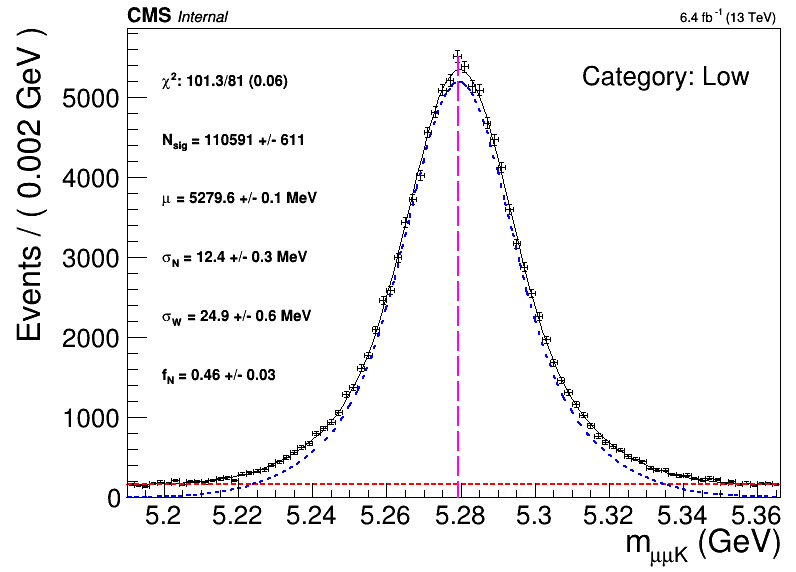

In [12]:
frame = mass.frame(rf.Title(""))
data.plotOn(frame, rf.MarkerStyle(1), rf.DrawOption('E1'), rf.MarkerColor(h.GetLineColor()), rf.LineColor(h.GetLineColor()), rf.MarkerStyle(15))
pdf_tot.plotOn(frame, rf.LineColor(h.GetLineColor()), rf.LineWidth(1))
pdf_tot.plotOn(frame, rf.Components('ebkg'), rf.LineColor(rt.kRed), rf.LineWidth(2), rf.LineStyle(7))
pdf_tot.plotOn(frame, rf.Components('esig'), rf.LineColor(rt.kBlue), rf.LineWidth(2), rf.LineStyle(7))

x_min = h.binning[1] + (h.binning[-1]-h.binning[1])*0.03
x_max = h.binning[1] + (h.binning[-1]-h.binning[1])*0.3
pTxt = rt.TPaveText(x_min, 0.2*h.GetMaximum(), x_max, h.GetMaximum())
pTxt.SetBorderSize(0)
pTxt.SetFillStyle(0)
pTxt.SetTextAlign(11)
pTxt.AddText('#chi^{{2}}: {:.1f}/{:.0f} ({:.2f})'.format(chi2.getVal(), dof, pval))
pTxt.AddText('N_{{sig}} = {:.0f} +/- {:.0f}'.format(nsig.getVal(), nsig.getError()))

pTxt.AddText('#mu = {:.1f} +/- {:.1f} MeV'.format(1e3*mean.getVal(), 1e3*mean.getError()))
pTxt.AddText('#sigma_{{N}} = {:.1f} +/- {:.1f} MeV'.format(1e3*sigmaN.getVal(), 1e3*sigmaN.getError()))
pTxt.AddText('#sigma_{{W}} = {:.1f} +/- {:.1f} MeV'.format(1e3*sigmaW.getVal(), 1e3*sigmaW.getError()))
pTxt.AddText('f_{{N}} = {:.2f} +/- {:.2f}'.format(fN.getVal(), fN.getError()))

# pTxt.AddText('#mu = {:.1f} +/- {:.1f} MeV'.format(1e3*mean.getVal(), 1e3*mean.getError()))
# pTxt.AddText('#sigma = {:.1f} +/- {:.1f} MeV'.format(1e3*sigma.getVal(), 1e3*sigma.getError()))
# pTxt.AddText('#alpha = {:.3f} +/- {:.3f}'.format(pAsym.getVal(), pAsym.getError()))
# pTxt.AddText('#rho_{{1}} = {:.3f} +/- {:.3f}'.format(rho1.getVal(), rho1.getError()))
# pTxt.AddText('#rho_{{2}} = {:.3f} +/- {:.3f}'.format(rho2.getVal(), rho2.getError()))

catText = rt.TLatex()
catText.SetTextAlign(31)
catText.SetTextSize(0.06)
catText.SetTextFont(42)
catText.SetTextSize(0.05)

c = drawOnCMSCanvas(CMS_lumi, frame)
cl.DrawLine(m_B, 0, m_B, h.GetMaximum());
pTxt.Draw()
catText.DrawLatexNDC(0.95, 0.85, 'Category: {}'.format(cat.name))
c.SaveAs('../data/calibration/Bcharged_pTspectrum/fig/MassMuMuK_data_' + cat.name + '_'+version + '.png')

### Make sDataset

In [13]:
v_B_pt = rt.RooRealVar('B_pt', 'p_{T}^{(B)}', 0, 500, 'GeV')
v_B_eta = rt.RooRealVar('B_eta', '#eta^{(B)}', -3, 3, 'GeV')
v_trgMu_pt = rt.RooRealVar('trgMu_pt', '#mu_{trg} p_{T}', 0, 1000, 'GeV')
v_N_vtx = rt.RooRealVar('N_vtx', 'N_{vtx}', 0, 1e3)

rt.RooAbsData.setDefaultStorageType(rt.RooAbsData.Tree)
ds = rt.RooDataSet('ds', 'ds', tRD_skimmed, rt.RooArgSet(mass, v_B_eta, v_B_pt, v_trgMu_pt, v_N_vtx))
ds.convertToTreeStore()

In [14]:
sData = rt.RooStats.SPlot('sData', 'sData', ds, pdf_tot, rt.RooArgList(nsig, nbkg))
sData.GetYieldFromSWeight('nsig_sw')

110596.0514534852

In [15]:
f_sw = rt.TFile(dsetRD_loc.replace('.root', '_sw.root'), 'RECREATE')
ds.convertToTreeStore()
auxTree = ds.tree()
auxTree.Write()
f_sw.Close()

In [16]:
dfRD = pd.DataFrame(rtnp.root2array(dsetRD_loc.replace('.root', '_sw.root')))
dfRD['sigSW'] = dfRD['L_nsig']/(dfRD['L_nsig']+dfRD['L_nbkg'])

# Load MC

In [17]:
mcSample = DSetLoader('Bp_JpsiK_PUc0', candDir='ntuples_B2JpsiK')
dsetMC_loc = mcSample.skimmed_dir + '/{}_corr.root'.format(cat.name)

dfMC = pd.DataFrame(rtnp.root2array(dsetMC_loc))

In [18]:
effMCgen = mcSample.effMCgen
decayBR = pickle.load(open('../data/forcedDecayChannelsFactors.pickle', 'rb'))['JPsiK']
effCAND = mcSample.effCand['effCAND']
effSkim = mcSample.getSkimEff(cat.name+'_corr')

xsec_eff = 1
dxsec = 0
for f, df in [effMCgen['xsec'], effMCgen['effGEN'], decayBR, effCAND, effSkim]:
    xsec_eff *= f
    dxsec += np.square(df/f)
dxsec = xsec_eff * np.sqrt(dxsec)
print '\nExpected evts/fb: {:.0f} +/- {:.0f}'.format(xsec_eff, dxsec)
print '\n'

r = N_sig_per_fb/xsec_eff
dr = r*np.hypot(dxsec/xsec_eff, dN_sig_per_fb/N_sig_per_fb)
print 'Ratio with observed: {:.0f}/{:.0f} = {:.2f} +/- {:.2f}'.format(N_sig_per_fb, xsec_eff, r, dr)


Expected evts/fb: 2428 +/- 122


Ratio with observed: 17280/2428 = 7.12 +/- 0.36


In [19]:
from pileup_utilities import pileupReweighter
puRew = pileupReweighter(dsetMC_loc, cat)
dfMC['wPU'] = puRew.weightsPileupMC[dfMC['N_vtx'].astype(np.int)]

# Compare

### Closure variables

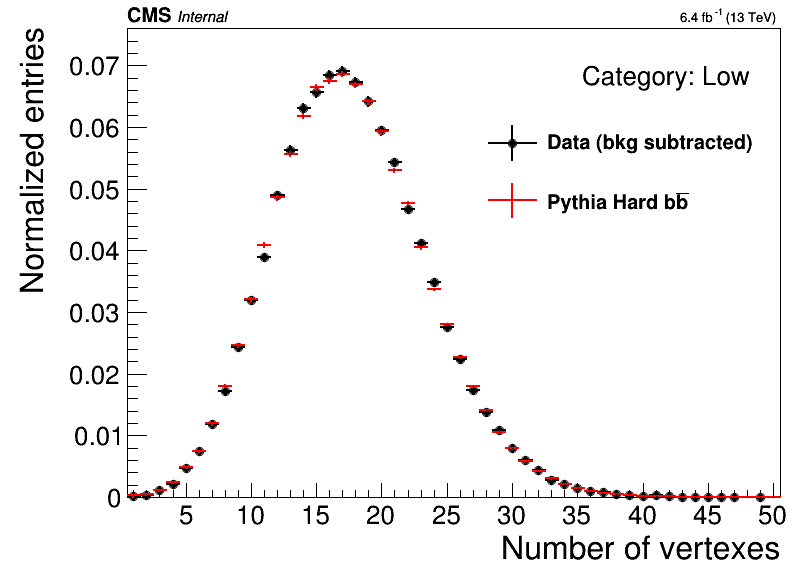

In [20]:
hRD = create_TH1D(dfRD['N_vtx'], name='hRD',
                title='',
                axis_title=['Number of vertexes', 'Normalized entries'],
                binning=[50, 0.5, 50.5],
                weights=dfRD['sigSW'],
                scale_histo='norm'
               )
hRD.SetMarkerStyle(15)

hMC = create_TH1D(dfMC['N_vtx'], name='hMC',
                  title = 'Pythia Hard b#bar{b}',
                  binning=hRD.binning,
                  weights=dfMC['wPU'],
                  scale_histo='norm' 
                 )
hMC.SetLineColor(rt.kRed)
    
leg = rt.TLegend(0.6, 0.6, 0.95,0.8)
leg.SetBorderSize(0)
leg.AddEntry(hRD, 'Data (bkg subtracted)', 'lep')
leg.AddEntry(hMC, 'Pythia Hard b#bar{b}', 'le')

CMS_lumi.integrated_lumi = lumi_tot
m = SetMaxToMaxHist([hRD, hMC])
c = drawOnCMSCanvas(CMS_lumi, [hRD, hMC], 'same')
leg.Draw()
catText.DrawLatexNDC(0.95, 0.85, 'Category: {}'.format(cat.name));

### Load MC corrections

In [21]:
loc = '../data/calibration/triggerScaleFactors/'
fTriggerSF = rt.TFile.Open(loc + 'HLT_' + cat.trg + '_SF_v7.root', 'READ')
hTriggerSF = fTriggerSF.Get('hSF_HLT_' + cat.trg)

ptmax = hTriggerSF.GetXaxis().GetXmax() - 0.01
ipmax = hTriggerSF.GetYaxis().GetXmax() - 0.01
etamax = hTriggerSF.GetZaxis().GetXmax() - 0.01

dfMC['trgSF'] = np.ones(dfMC.shape[0])
for i, (pt, eta, ip) in enumerate(dfMC[['trgMu_pt', 'trgMu_eta', 'trgMu_sigdxy']].values):
    ix = hTriggerSF.GetXaxis().FindBin(min(ptmax, pt))
    iy = hTriggerSF.GetYaxis().FindBin(min(ipmax, ip))
    iz = hTriggerSF.GetZaxis().FindBin(min(etamax, np.abs(eta)))
    dfMC.at[i, 'trgSF'] = hTriggerSF.GetBinContent(ix, iy, iz)
    if np.abs(dfMC.at[i, 'trgSF'] - 1) > 0.1:
        print (4*'{:.2f} ').format(pt, eta, ip, hTriggerSF.GetBinContent(ix, iy, iz))

7.17 0.55 5.26 0.71 
7.91 -0.17 11.48 0.84 
7.61 0.22 130.61 0.84 
7.47 -0.26 35.91 0.76 
7.53 0.05 18.43 0.77 
7.03 1.12 17.72 0.89 
7.93 -0.14 25.25 0.84 
7.35 0.62 49.04 0.81 
7.11 -0.45 13.68 0.73 
7.23 0.39 8.89 0.73 
7.61 0.19 12.35 0.84 
7.56 -0.06 6.05 0.77 
7.36 -0.52 7.66 0.82 
7.83 0.50 9.94 0.88 
7.48 0.00 5.38 0.76 
7.54 0.23 51.83 0.76 
7.35 -0.68 9.47 0.82 
7.06 -0.69 4.11 0.74 
7.63 -0.49 7.81 0.88 
7.83 -0.24 7.61 0.85 
7.06 0.87 12.26 0.89 
7.78 -0.18 17.44 0.84 
7.90 -0.62 10.38 0.89 
7.51 0.54 47.13 0.81 
7.27 -0.23 35.57 0.71 
7.40 0.28 7.49 0.77 
7.38 0.55 17.54 0.81 
7.08 -0.40 39.39 0.69 
7.16 0.11 25.54 0.69 
7.36 0.57 12.93 0.81 
7.01 1.03 10.71 0.89 
7.20 -0.74 19.23 0.73 
7.45 0.21 4.29 0.82 
7.02 -0.99 7.59 0.90 
7.59 -0.69 4.12 0.84 
7.80 -0.22 21.78 0.84 
7.10 0.26 17.79 0.68 
7.50 0.35 8.64 0.77 
7.34 -0.72 6.62 0.82 
7.12 -0.65 10.31 0.73 
7.15 -0.78 11.85 0.73 
7.72 0.76 14.47 0.89 
7.37 -0.57 13.69 0.81 
7.09 -0.41 44.28 0.70 
7.20 0.00 8.89 0.73 
7.3

7.55 -0.20 9.39 0.77 
7.01 1.19 26.47 0.88 
7.78 -0.34 12.75 0.84 
7.56 0.77 5.60 0.84 
7.73 0.18 9.58 0.85 
7.84 0.11 6.63 0.85 
7.45 0.55 11.56 0.81 
7.11 -0.61 18.12 0.73 
7.04 1.05 18.32 0.89 
7.41 -0.78 19.07 0.81 
7.06 0.57 4.88 0.74 
7.42 -0.76 14.63 0.81 
7.15 0.39 22.62 0.69 
7.12 0.27 22.82 0.69 
7.16 -0.01 15.47 0.68 
7.94 0.09 15.51 0.84 
7.04 -1.14 16.86 0.89 
7.48 -0.78 30.11 0.81 
7.08 -0.65 20.08 0.70 
7.68 -0.48 67.23 0.87 
7.88 0.48 7.43 0.88 
7.51 0.28 48.90 0.76 
7.09 -1.30 13.98 0.89 
7.75 0.61 9.65 0.88 
7.42 -0.78 7.66 0.82 
7.29 -0.41 51.14 0.76 
7.31 0.03 4.01 0.82 
7.65 0.38 16.85 0.84 
7.41 -0.11 5.37 0.76 
7.09 -0.73 10.15 0.70 
7.03 0.70 14.32 0.70 
7.71 0.11 72.96 0.84 
7.93 0.49 82.96 0.87 
7.33 -0.08 14.59 0.77 
7.70 -0.71 17.38 0.89 
7.40 0.78 55.80 0.81 
7.34 -0.61 6.05 0.82 
7.69 0.65 24.24 0.87 
7.47 -0.74 4.08 0.84 
7.17 -0.15 14.27 0.68 
7.02 1.42 5.10 0.89 
7.58 0.46 10.95 0.81 
7.74 -0.77 44.83 0.87 
7.87 0.05 7.41 0.85 
7.54 -0.24 4.39 0.82 
7.3

7.06 -0.07 45.27 0.69 
7.03 0.66 10.03 0.70 
7.56 0.60 9.63 0.82 
7.39 -0.15 17.97 0.77 
7.26 0.36 9.04 0.73 
7.09 -0.72 13.98 0.70 
7.88 0.52 13.64 0.89 
7.55 0.09 24.97 0.76 
7.55 0.35 8.64 0.77 
7.06 -0.12 24.21 0.69 
7.68 -0.09 38.14 0.84 
7.26 -0.34 4.77 0.74 
7.46 -0.62 20.14 0.81 
7.88 -0.79 40.78 0.87 
7.41 0.07 32.26 0.76 
7.77 0.56 15.17 0.89 
7.74 0.62 55.30 0.87 
7.42 -0.18 6.54 0.77 
7.81 -0.78 6.94 0.88 
7.65 0.69 9.76 0.88 
7.42 0.43 10.93 0.81 
7.32 -0.50 6.72 0.82 
7.85 -0.26 6.14 0.85 
7.87 -0.43 15.46 0.89 
7.71 -0.30 12.06 0.84 
7.45 0.28 13.63 0.77 
7.56 -0.40 11.05 0.81 
7.61 0.11 5.26 0.90 
7.70 -0.09 11.00 0.84 
7.45 0.66 10.25 0.81 
7.32 -0.42 4.26 0.84 
7.24 0.54 16.34 0.78 
7.53 -0.29 7.28 0.77 
7.20 0.13 9.67 0.69 
7.01 -1.38 19.66 0.89 
7.32 -0.04 32.75 0.76 
7.27 0.32 48.43 0.71 
7.03 -0.55 39.82 0.70 
7.19 -0.60 9.39 0.74 
7.21 -0.45 8.28 0.77 
7.12 -0.64 6.67 0.74 
7.63 0.72 15.12 0.89 
7.53 -0.23 41.47 0.76 
7.99 -0.72 32.74 0.87 
7.60 -0.55 6.56 0.82 


7.10 -1.35 14.39 0.89 
7.99 -0.76 6.21 0.88 
7.35 -0.48 12.05 0.81 
7.20 -0.30 12.55 0.70 
7.67 -0.18 25.64 0.84 
7.77 -0.46 57.82 0.87 
7.07 -0.21 20.35 0.69 
7.23 -0.54 31.42 0.76 
7.24 0.26 9.80 0.73 
7.51 0.75 8.67 0.82 
7.45 0.37 15.57 0.77 
7.44 0.49 4.11 0.84 
7.75 0.53 111.40 0.87 
7.61 0.37 47.33 0.84 
7.79 0.09 12.85 0.84 
7.31 -0.14 18.58 0.77 
7.66 -0.15 59.28 0.84 
7.25 -0.08 33.52 0.71 
7.19 0.11 8.24 0.69 
7.61 0.03 73.39 0.84 
7.95 0.43 6.35 0.88 
7.69 -0.37 7.15 0.85 
7.21 0.09 4.52 0.74 
7.02 -0.25 22.90 0.69 
7.32 0.63 12.20 0.81 
7.26 0.53 6.17 0.77 
7.40 -0.28 16.14 0.77 
7.26 0.01 7.11 0.73 
7.62 0.16 7.87 0.85 
7.28 0.32 4.49 0.74 
7.83 -0.20 18.85 0.84 
7.11 -0.10 8.43 0.69 
7.30 -0.38 7.33 0.77 
7.63 -0.78 8.68 0.88 
7.12 0.14 14.20 0.68 
7.91 -0.61 49.84 0.87 
7.93 -0.09 21.14 0.84 
7.94 -0.43 7.78 0.88 
7.74 0.13 130.53 0.84 
7.19 0.50 4.35 0.78 
7.04 0.53 15.82 0.70 
7.19 -0.75 23.05 0.73 
7.57 0.21 21.72 0.76 
7.37 0.56 25.90 0.81 
7.57 -0.63 11.00 0.81 
7.

7.46 -0.30 19.62 0.77 
7.13 -0.17 6.70 0.69 
7.49 0.20 10.96 0.77 
7.80 -0.31 43.93 0.84 
7.01 0.99 17.88 0.89 
7.02 -0.59 114.11 0.70 
7.35 -0.73 9.91 0.82 
7.65 -0.14 27.18 0.84 
7.75 0.11 7.57 0.85 
7.38 0.25 60.12 0.76 
7.89 -0.18 9.33 0.85 
7.39 -0.66 32.68 0.81 
7.79 -0.62 13.00 0.89 
7.16 -0.16 13.06 0.68 
7.96 0.53 12.61 0.89 
7.85 -0.40 26.87 0.84 
7.11 -0.38 11.51 0.68 
7.89 0.36 8.48 0.85 
7.14 0.43 17.47 0.73 
7.70 -0.66 25.53 0.87 
7.07 -0.65 44.68 0.70 
7.94 -0.16 5.15 0.90 
7.64 -0.22 57.92 0.84 
7.93 0.04 14.82 0.84 
7.09 -0.32 12.48 0.73 
7.80 -0.50 22.43 0.87 
7.44 0.50 27.30 0.81 
7.43 0.04 5.56 0.77 
7.75 -0.49 55.40 0.87 
7.59 0.16 24.68 0.76 
7.31 -0.45 5.92 0.84 
8.00 0.65 71.28 0.87 
7.71 -0.61 46.58 0.87 
7.43 0.46 6.47 0.82 
7.69 -0.12 18.45 0.84 
7.97 -0.66 8.77 0.88 
7.83 0.04 6.44 0.85 
7.67 0.40 5.90 0.88 
7.97 0.48 19.15 0.89 
7.71 0.20 6.18 0.85 
7.83 -0.20 9.94 0.85 
7.82 0.25 10.70 0.84 
7.91 -0.77 9.56 0.88 
7.17 -0.02 40.06 0.69 
7.07 -1.40 8.09 0.90

7.22 -0.40 8.83 0.73 
7.02 -1.36 5.17 0.89 
7.54 -0.58 33.35 0.81 
7.04 -0.56 24.16 0.70 
7.27 -0.63 11.54 0.78 
7.53 -0.02 136.96 0.76 
7.94 0.40 18.89 0.84 
7.07 1.38 11.09 0.89 
7.86 0.74 9.38 0.88 
7.13 -0.30 5.33 0.69 
7.15 -0.30 20.91 0.69 
7.09 -0.74 14.31 0.70 
7.42 0.33 18.10 0.77 
7.08 0.72 44.05 0.70 
7.39 0.13 5.93 0.77 
7.88 -0.22 6.57 0.85 
7.51 -0.33 9.96 0.77 
7.43 -0.06 8.81 0.77 
7.29 0.61 12.88 0.78 
7.29 0.00 6.85 0.73 
7.78 -0.72 43.63 0.87 
7.95 -0.29 17.51 0.84 
7.92 -0.40 9.62 0.85 
7.90 -0.64 9.21 0.88 
7.95 -0.09 23.12 0.84 
7.67 -0.35 6.63 0.85 
7.43 0.44 22.96 0.81 
7.01 -0.38 8.11 0.72 
7.01 1.05 14.56 0.89 
7.06 0.28 6.43 0.72 
7.79 -0.55 22.51 0.87 
7.13 -0.07 5.21 0.69 
7.76 0.53 71.02 0.87 
7.22 -0.51 38.48 0.76 
7.94 0.41 68.35 0.87 
7.22 -0.51 9.20 0.77 
7.46 0.22 14.34 0.77 
7.54 0.53 9.18 0.82 
7.44 0.05 11.11 0.77 
7.90 -0.07 5.22 0.90 
7.24 -0.45 11.84 0.78 
7.54 0.40 73.03 0.76 
7.26 -0.21 14.02 0.70 
7.48 -0.40 4.81 0.84 
7.61 -0.63 13.08 0.89 


7.61 -0.54 38.05 0.87 
7.39 0.23 11.82 0.77 
7.93 -0.07 6.55 0.85 
7.83 -0.07 20.46 0.84 
7.59 0.14 14.74 0.77 
7.74 0.50 6.22 0.88 
7.29 -0.47 24.39 0.76 
7.22 0.64 34.36 0.76 
7.29 0.59 7.87 0.77 
7.03 -1.00 23.91 0.88 
7.77 -0.06 9.31 0.85 
7.55 0.06 18.15 0.77 
7.14 -0.68 20.14 0.73 
7.17 -0.14 33.51 0.69 
7.74 -0.72 47.25 0.87 
7.73 0.38 19.65 0.84 
7.70 0.39 5.84 0.88 
8.00 0.67 39.07 0.87 
7.79 0.13 5.54 0.88 
7.07 -0.51 9.45 0.69 
7.48 -0.05 6.94 0.77 
7.33 -0.67 18.26 0.81 
7.53 0.11 11.54 0.77 
7.57 0.55 14.65 0.81 
7.86 0.41 10.00 0.88 
7.12 0.52 26.23 0.73 
7.27 0.48 10.69 0.78 
7.09 -0.24 7.58 0.72 
7.65 0.07 53.03 0.84 
7.33 0.02 13.79 0.77 
7.29 -0.70 39.67 0.76 
7.24 -0.19 21.63 0.71 
7.09 0.90 13.76 0.89 
7.11 0.29 12.57 0.68 
7.45 0.29 48.86 0.76 
7.05 -0.19 103.03 0.69 
7.60 0.63 19.87 0.89 
7.72 0.67 11.09 0.89 
7.50 -0.71 10.95 0.81 
7.91 0.77 12.57 0.89 
7.53 -0.19 10.52 0.77 
7.44 -0.75 11.55 0.81 
7.45 0.05 7.35 0.77 
7.85 0.22 19.06 0.84 
7.26 -0.67 8.13 0.77 


7.08 0.31 33.37 0.69 
7.19 -0.70 9.99 0.74 
7.89 0.01 8.77 0.85 
7.39 0.72 6.14 0.82 
7.95 -0.45 21.72 0.87 
7.17 -0.14 7.72 0.69 
7.46 0.59 16.99 0.81 
7.73 0.32 6.01 0.85 
7.58 0.51 7.05 0.82 
7.09 -0.81 5.28 0.89 
7.25 0.57 8.58 0.77 
7.51 0.25 14.10 0.77 
7.64 0.32 6.20 0.85 
7.82 -0.66 56.63 0.87 
7.12 0.13 13.95 0.68 
7.62 0.15 8.40 0.85 
7.01 1.14 23.33 0.88 
7.12 -0.49 10.50 0.73 
7.51 0.31 48.02 0.76 
7.54 -0.42 7.95 0.82 
7.47 0.19 25.38 0.76 
7.72 0.33 12.55 0.84 
7.90 -0.41 17.41 0.89 
7.26 0.37 22.02 0.71 
7.37 0.60 21.88 0.81 
7.73 0.71 20.55 0.87 
7.94 0.65 18.47 0.89 
7.63 -0.18 7.22 0.85 
7.63 0.42 21.89 0.87 
7.46 0.47 35.58 0.81 
7.51 -0.18 10.04 0.77 
7.22 0.36 15.50 0.70 
7.61 -0.35 5.55 0.88 
7.53 -0.54 17.34 0.81 
7.40 -0.08 8.50 0.77 
7.32 -0.03 63.63 0.76 
7.84 -0.43 6.22 0.88 
7.52 -0.05 15.30 0.77 
7.24 -0.11 7.05 0.73 
7.05 0.37 28.45 0.69 
7.21 0.79 6.01 0.77 
7.19 -0.64 8.51 0.74 
7.10 0.13 8.42 0.72 
7.48 -0.39 4.43 0.82 
7.36 0.61 4.10 0.84 
7.24 0.54 27

7.32 -0.29 35.14 0.76 
7.49 0.24 27.65 0.76 
7.65 -0.50 17.83 0.89 
7.24 -0.19 8.90 0.73 
7.85 -0.52 8.22 0.88 
7.05 1.43 6.61 0.90 
7.93 0.73 7.52 0.88 
7.58 0.14 9.53 0.77 
7.44 -0.64 39.59 0.81 
7.21 -0.40 10.54 0.70 
7.97 0.62 12.32 0.89 
7.25 -0.56 13.15 0.78 
7.13 0.48 7.23 0.74 
7.18 -0.36 12.48 0.68 
7.86 -0.74 10.09 0.89 
7.36 0.46 9.21 0.82 
7.83 0.30 7.51 0.85 
7.07 -1.15 7.77 0.90 
7.34 -0.18 16.44 0.77 
7.14 0.14 9.45 0.69 
7.20 0.67 7.27 0.77 
7.60 0.74 24.21 0.87 
7.09 0.81 42.06 0.88 
7.40 0.08 63.46 0.76 
7.39 -0.73 25.30 0.81 
7.04 -0.39 11.40 0.73 
7.43 -0.22 8.54 0.77 
7.30 0.00 28.22 0.71 
7.01 1.25 22.33 0.88 
7.30 -0.56 23.78 0.81 
7.11 -0.58 9.04 0.74 
7.29 -0.63 9.38 0.77 
7.39 0.16 13.52 0.77 
7.31 0.23 14.55 0.77 
7.05 -0.84 15.30 0.89 
7.05 -0.84 7.31 0.90 
7.16 -0.42 8.71 0.74 
7.82 -0.63 33.74 0.87 
7.19 -0.11 4.25 0.76 
7.46 0.53 14.59 0.81 
7.63 0.10 5.32 0.90 
7.19 0.78 10.90 0.73 
7.81 -0.10 16.94 0.84 
7.56 -0.54 24.73 0.81 
7.32 0.63 9.90 0.82 
7.96 

7.77 0.17 12.47 0.84 
7.23 0.68 38.92 0.76 
7.67 0.62 13.95 0.89 
7.66 -0.51 50.08 0.87 
7.11 -0.59 11.12 0.73 
7.04 0.30 19.52 0.73 
7.11 0.40 8.72 0.74 
7.36 0.24 4.87 0.82 
7.59 -0.13 11.55 0.77 
7.64 -0.58 18.55 0.89 
7.57 0.02 18.49 0.77 
7.93 -0.12 41.29 0.84 
7.19 0.70 12.54 0.73 
7.93 -0.61 37.88 0.87 
7.20 -0.25 25.29 0.71 
7.10 -0.08 68.33 0.69 
7.39 -0.28 23.00 0.76 
7.83 -0.00 7.79 0.85 
7.91 0.33 7.90 0.85 
7.65 0.19 18.45 0.84 
7.92 0.33 88.17 0.84 
7.07 -1.25 36.45 0.88 
7.34 -0.54 9.21 0.82 
7.67 0.26 8.47 0.85 
7.09 0.95 13.18 0.89 
7.93 0.30 8.58 0.85 
7.04 1.40 6.34 0.90 
7.63 0.02 48.83 0.84 
7.08 -0.14 16.05 0.73 
7.68 0.29 16.98 0.84 
7.04 -1.24 6.32 0.90 
7.79 -0.17 38.26 0.84 
7.15 0.24 5.14 0.69 
7.77 -0.76 10.90 0.89 
7.48 0.06 9.35 0.77 
7.48 -0.21 8.77 0.77 
7.71 0.66 30.44 0.87 
7.42 0.20 5.57 0.77 
7.67 -0.02 13.36 0.84 
7.35 0.30 6.55 0.77 
7.54 -0.17 72.39 0.76 
7.02 -1.00 6.00 0.90 
7.65 -0.65 8.94 0.88 
7.64 0.57 11.89 0.89 
7.52 -0.22 23.04 0.76 
7.85

7.87 0.07 6.62 0.85 
7.26 -0.43 36.11 0.76 
7.95 -0.72 12.86 0.89 
7.27 -0.13 7.09 0.73 
7.97 -0.45 21.47 0.87 
7.42 -0.70 25.11 0.81 
7.14 0.60 9.77 0.74 
7.21 0.75 9.68 0.77 
7.86 -0.23 12.00 0.84 
7.42 0.03 6.70 0.77 
7.23 -0.47 47.96 0.76 
7.39 0.11 40.99 0.76 
7.42 0.73 51.69 0.81 
7.18 0.62 21.59 0.73 
7.23 -0.33 4.90 0.74 
7.41 -0.70 17.79 0.81 
7.67 -0.08 6.66 0.85 
7.23 0.03 25.05 0.71 
7.72 -0.38 40.14 0.84 
7.19 -0.73 6.11 0.74 
7.89 -0.55 27.18 0.87 
7.06 -0.72 32.96 0.70 
7.75 0.22 51.04 0.84 
7.33 -0.03 11.88 0.77 
7.85 -0.45 18.99 0.89 
7.28 -0.00 28.53 0.71 
7.52 0.18 18.60 0.77 
7.46 0.61 5.99 0.84 
7.23 0.70 9.13 0.77 
7.24 -0.56 6.47 0.77 
7.35 0.01 4.03 0.82 
7.05 0.34 16.96 0.73 
7.38 0.36 6.40 0.77 
7.71 -0.03 7.42 0.85 
7.63 -0.64 15.77 0.89 
7.22 -0.73 4.77 0.83 
7.40 0.06 6.08 0.77 
7.07 -0.57 20.91 0.70 
7.23 0.39 12.90 0.70 
7.63 0.38 5.72 0.88 
7.69 -0.00 12.99 0.84 
7.84 0.34 17.71 0.84 
7.71 0.05 69.13 0.84 
7.10 0.08 28.30 0.69 
7.62 -0.30 7.43 0.85 
7.20

7.47 -0.72 36.63 0.81 
7.14 0.42 12.90 0.73 
7.43 -0.63 10.85 0.81 
7.68 -0.12 5.90 0.88 
7.06 -1.05 26.86 0.88 
7.55 0.02 20.51 0.76 
7.19 0.41 27.89 0.73 
7.67 0.78 17.68 0.89 
7.97 -0.11 19.30 0.84 
7.80 -0.24 33.20 0.84 
7.46 0.49 18.68 0.81 
7.59 0.17 9.82 0.77 
7.74 0.73 9.31 0.88 
7.28 0.37 17.76 0.70 
7.00 0.77 58.44 0.70 
7.01 1.00 12.78 0.89 
7.93 0.21 13.91 0.84 
7.50 0.68 5.73 0.84 
7.95 -0.30 5.43 0.90 
7.03 -1.01 8.37 0.90 
7.17 -0.12 40.22 0.69 
7.33 0.35 40.57 0.76 
7.23 -0.29 8.91 0.73 
7.17 0.24 12.42 0.68 
7.04 1.30 6.91 0.90 
7.10 -0.48 4.47 0.74 
7.61 0.19 17.73 0.84 
7.09 -0.54 5.15 0.70 
7.50 -0.39 12.96 0.77 
7.24 -0.27 26.86 0.71 
7.26 0.68 18.33 0.78 
7.51 0.58 13.36 0.81 
7.10 -0.03 12.63 0.73 
7.44 0.40 9.90 0.77 
7.50 0.47 14.46 0.81 
7.55 0.37 17.94 0.77 
7.39 0.43 35.45 0.81 
7.31 -0.06 5.45 0.76 
7.91 0.72 54.43 0.87 
7.17 -0.36 20.16 0.69 
7.62 -0.36 15.85 0.84 
7.83 -0.30 9.74 0.85 
7.08 0.35 38.51 0.69 
7.28 -0.46 33.74 0.76 
7.23 -0.48 23.62 0.76 
7.

7.79 0.12 15.05 0.84 
7.76 -0.04 30.80 0.84 
7.59 0.40 19.42 0.81 
7.16 -0.58 4.71 0.78 
7.04 0.82 34.56 0.88 
7.53 0.23 10.19 0.77 
7.13 0.38 6.20 0.69 
7.57 0.26 14.98 0.77 
7.94 -0.08 6.35 0.85 
7.58 0.13 40.77 0.76 
7.47 0.60 6.12 0.82 
7.35 0.44 7.66 0.82 
7.19 -0.48 5.52 0.76 
7.46 -0.60 25.46 0.81 
7.69 -0.50 50.06 0.87 
7.64 -0.08 11.25 0.84 
7.13 -0.29 5.72 0.70 
7.55 0.24 7.50 0.77 
7.29 -0.65 12.85 0.78 
7.93 0.74 7.24 0.88 
7.32 0.14 17.51 0.77 
7.88 0.45 7.31 0.88 
7.61 0.62 24.05 0.87 
7.77 0.22 12.88 0.84 
7.90 0.06 6.79 0.85 
7.12 0.45 35.84 0.73 
7.15 0.31 70.35 0.69 
7.26 -0.62 37.07 0.76 
7.69 -0.11 14.60 0.84 
7.91 -0.76 29.54 0.87 
7.76 0.17 11.55 0.84 
7.90 -0.76 8.83 0.88 
7.51 0.12 8.28 0.77 
7.67 0.44 10.05 0.89 
7.33 0.34 9.93 0.77 
7.20 -0.04 11.52 0.70 
7.72 -0.49 51.10 0.87 
7.46 -0.01 19.88 0.77 
7.52 0.46 4.62 0.84 
7.31 0.48 5.11 0.84 
7.42 -0.27 48.88 0.76 
7.51 -0.13 6.09 0.77 
7.53 -0.67 5.69 0.84 
7.32 -0.25 10.10 0.77 
7.40 -0.07 70.84 0.76 
7.48 0.

7.80 0.74 12.64 0.89 
7.93 0.73 9.60 0.88 
7.26 -0.18 6.37 0.73 
7.34 -0.58 7.78 0.82 
7.21 0.22 14.58 0.70 
7.51 -0.14 7.44 0.77 
7.37 0.59 7.57 0.82 
7.36 0.19 12.65 0.77 
7.92 0.62 8.28 0.88 
7.00 0.70 27.68 0.70 
7.50 0.14 13.80 0.77 
7.69 0.28 8.43 0.85 
7.11 -0.21 12.49 0.68 
7.37 0.10 14.28 0.77 
7.72 -0.03 7.96 0.85 
7.44 -0.72 42.28 0.81 
7.94 0.36 54.74 0.84 
7.98 0.51 6.30 0.88 
7.05 1.07 10.87 0.89 
7.40 -0.74 5.57 0.84 
7.45 -0.12 8.59 0.77 
7.51 0.05 23.32 0.76 
7.61 0.64 6.89 0.88 
7.51 -0.68 6.64 0.82 
7.42 0.38 8.02 0.77 
7.07 -0.88 15.56 0.89 
7.69 0.74 42.36 0.87 
7.32 0.57 8.02 0.82 
7.62 0.61 8.38 0.88 
7.01 -0.49 12.10 0.70 
7.29 -0.64 9.52 0.77 
7.25 -0.12 36.51 0.71 
7.15 0.29 30.31 0.69 
7.33 -0.10 16.92 0.77 
7.72 -0.58 14.79 0.89 
7.85 -0.38 17.33 0.84 
7.62 -0.27 28.68 0.84 
7.25 0.32 9.26 0.73 
7.51 0.02 16.77 0.77 
8.00 -0.00 5.94 0.88 
7.21 -0.60 31.83 0.76 
7.17 0.61 10.14 0.73 
7.99 -0.17 10.69 0.84 
7.17 0.33 99.95 0.69 
7.40 -0.78 4.11 0.84 
7.94 -0.0

7.71 0.64 6.69 0.88 
7.51 0.12 7.22 0.77 
7.71 0.74 12.98 0.89 
7.55 0.73 6.72 0.82 
7.37 0.40 134.80 0.81 
7.27 -0.17 27.59 0.71 
7.21 0.63 48.80 0.76 
7.28 0.74 17.99 0.78 
7.82 -0.07 48.76 0.84 
7.37 -0.37 6.96 0.77 
7.76 -0.29 8.84 0.85 
7.26 -0.72 40.06 0.76 
7.75 -0.13 10.99 0.84 
7.06 0.80 9.93 0.90 
7.29 -0.49 25.13 0.76 
7.32 0.02 5.16 0.76 
7.01 -0.56 8.59 0.69 
7.20 -0.71 4.27 0.83 
7.93 -0.00 22.78 0.84 
7.12 -0.74 17.34 0.73 
7.74 0.73 14.61 0.89 
7.26 0.79 6.53 0.77 
7.37 0.01 9.71 0.77 
7.22 0.18 4.56 0.74 
7.87 -0.02 7.90 0.85 
7.03 0.27 18.19 0.73 
7.64 -0.10 47.17 0.84 
7.43 -0.15 39.97 0.76 
7.57 -0.68 7.66 0.82 
7.41 0.25 17.47 0.77 
7.08 -0.37 4.40 0.79 
7.27 0.04 26.21 0.71 
7.74 0.47 23.68 0.87 
7.23 -0.66 12.90 0.78 
7.33 0.79 39.00 0.81 
7.17 -0.13 5.82 0.70 
7.80 0.12 7.91 0.85 
7.29 -0.16 12.58 0.70 
7.80 -0.14 21.51 0.84 
7.61 -0.05 29.36 0.84 
7.07 -0.69 38.79 0.70 
7.12 -0.26 11.37 0.68 
7.04 0.54 7.02 0.69 
7.93 0.59 17.47 0.89 
7.77 -0.16 15.99 0.84 
7.6

7.35 -0.14 8.57 0.77 
7.86 0.72 15.12 0.89 
7.12 -0.49 16.33 0.73 
7.48 0.75 7.11 0.82 
7.29 -0.01 4.83 0.74 
7.96 -0.07 6.16 0.85 
7.02 0.95 5.97 0.87 
7.09 0.78 22.22 0.70 
7.14 -0.65 20.79 0.73 
7.79 0.60 7.11 0.88 
7.47 0.08 4.98 0.82 
7.86 0.08 26.02 0.84 
7.77 -0.56 31.72 0.87 
7.38 0.27 16.05 0.77 
7.94 0.05 25.62 0.84 
7.44 -0.65 29.94 0.81 
7.71 -0.36 19.80 0.84 
7.73 -0.69 17.15 0.89 
7.41 0.62 24.16 0.81 
7.82 -0.03 11.68 0.84 
7.34 -0.08 9.30 0.77 
7.64 -0.07 16.64 0.84 
7.92 0.19 19.42 0.84 
7.25 0.18 15.24 0.70 
7.00 0.05 9.96 0.72 
7.78 0.16 15.61 0.84 
7.42 -0.19 15.39 0.77 
7.32 -0.50 28.20 0.81 
7.54 0.50 63.31 0.81 
7.74 0.61 16.55 0.89 
7.09 -0.23 4.16 0.79 
7.07 -0.16 9.35 0.72 
7.06 -0.38 5.07 0.77 
7.19 0.19 30.58 0.69 
7.29 0.58 25.59 0.76 
7.61 -0.53 21.28 0.87 
7.74 0.54 7.15 0.88 
7.14 0.48 11.33 0.73 
7.84 0.79 18.64 0.89 
7.06 -1.21 21.03 0.88 
7.43 0.18 17.30 0.77 
7.66 0.05 85.40 0.84 
7.96 0.26 17.34 0.84 
7.87 0.13 6.52 0.85 
7.60 -0.29 20.89 0.84 
7.55

7.87 -0.80 22.53 0.87 
7.71 0.15 48.76 0.84 
7.28 0.53 56.53 0.76 
7.52 0.79 11.92 0.81 
7.73 -0.38 12.64 0.84 
7.63 0.33 5.43 0.90 
7.92 0.43 19.64 0.89 
7.03 1.08 10.11 0.89 
7.53 0.62 16.43 0.81 
7.81 -0.11 12.18 0.84 
7.23 0.25 5.47 0.73 
7.68 0.39 12.32 0.84 
7.09 -1.26 11.88 0.89 
7.17 0.76 7.91 0.74 
7.04 1.30 14.27 0.89 
7.80 0.16 116.92 0.84 
7.25 0.55 33.80 0.76 
7.22 0.25 5.40 0.73 
7.36 0.44 8.86 0.82 
7.29 0.09 8.40 0.73 
7.57 -0.40 9.98 0.77 
7.25 -0.48 45.89 0.76 
7.33 0.43 25.66 0.81 
7.44 -0.67 8.84 0.82 
7.56 -0.22 10.78 0.77 
7.01 0.39 8.69 0.72 
7.69 -0.10 6.12 0.85 
7.11 0.15 8.72 0.69 
7.03 -0.56 9.50 0.69 
7.02 -0.79 52.36 0.70 
7.03 -0.86 24.22 0.88 
7.17 -0.50 39.02 0.73 
7.88 -0.32 8.89 0.85 
7.62 0.25 61.76 0.84 
7.18 0.07 9.83 0.69 
7.20 -0.40 42.47 0.71 
7.21 -0.69 62.65 0.76 
7.89 0.18 6.82 0.85 
7.09 -0.00 5.04 0.77 
7.19 0.06 35.01 0.69 
7.63 0.14 12.12 0.84 
7.07 -0.29 24.72 0.69 
7.83 -0.03 39.13 0.84 
7.18 -0.79 29.00 0.73 
7.98 0.49 48.11 0.87 
7.09 

7.26 -0.58 32.71 0.76 
7.09 0.94 8.58 0.90 
7.62 -0.51 11.67 0.89 
7.46 0.45 6.94 0.82 
7.35 -0.41 30.67 0.81 
7.66 0.12 12.57 0.84 
7.46 0.12 54.70 0.76 
7.86 -0.28 13.54 0.84 
7.62 0.58 7.61 0.88 
7.41 -0.39 19.06 0.77 
7.00 -0.31 10.60 0.73 
7.40 -0.27 7.58 0.77 
7.27 -0.73 12.69 0.78 
7.16 -0.02 35.62 0.69 
7.85 -0.23 20.51 0.84 
7.13 0.24 15.90 0.68 
7.51 0.25 5.89 0.77 
7.09 1.27 13.88 0.89 
7.76 -0.09 8.70 0.85 
7.84 0.41 23.21 0.87 
7.90 -0.62 24.86 0.87 
7.16 0.47 21.58 0.73 
7.10 0.76 23.64 0.70 
7.36 -0.57 10.13 0.81 
7.18 -0.68 20.45 0.73 
7.38 0.69 12.35 0.81 
7.27 0.32 7.48 0.73 
7.53 0.15 11.04 0.77 
7.96 0.32 7.61 0.85 
7.07 0.68 20.07 0.70 
7.07 1.33 6.17 0.90 
7.44 0.66 5.84 0.84 
7.04 1.13 9.50 0.90 
7.82 0.73 52.38 0.87 
7.92 0.66 6.75 0.88 
7.53 -0.27 5.66 0.77 
7.43 -0.57 6.99 0.82 
7.89 0.21 7.04 0.85 
7.31 -0.28 5.56 0.77 
7.28 -0.58 20.45 0.76 
7.83 -0.69 15.61 0.89 
7.69 0.16 22.03 0.84 
7.39 -0.13 20.29 0.76 
7.83 -0.05 20.74 0.84 
7.68 0.49 53.34 0.87 
7.97 

7.15 0.58 5.63 0.76 
7.35 0.45 34.24 0.81 
7.51 0.67 15.77 0.81 
7.29 -0.47 27.27 0.76 
7.32 -0.60 17.98 0.81 
7.19 0.47 5.30 0.71 
7.63 -0.75 18.06 0.89 
7.67 -0.32 35.04 0.84 
7.16 -0.44 27.10 0.73 
7.22 0.17 10.01 0.70 
7.10 -1.29 23.76 0.88 
7.74 0.28 8.27 0.85 
7.03 1.28 7.13 0.90 
7.08 -0.11 5.73 0.74 
7.63 -0.30 35.77 0.84 
7.09 0.32 13.31 0.73 
7.41 -0.03 8.75 0.77 
7.70 0.37 7.53 0.85 
7.26 -0.16 8.20 0.73 
7.70 -0.50 22.62 0.87 
7.94 0.56 24.71 0.87 
7.40 -0.52 7.61 0.82 
7.89 0.47 8.27 0.88 
7.08 -0.39 18.33 0.73 
7.45 -0.15 47.52 0.76 
7.36 -0.37 25.74 0.76 
7.27 0.02 12.47 0.70 
7.08 -0.38 9.88 0.72 
7.02 0.57 19.14 0.70 
7.01 -1.46 14.03 0.89 
7.30 -0.11 14.85 0.77 
7.39 0.76 7.28 0.82 
7.35 0.66 32.14 0.81 
7.27 0.51 37.47 0.76 
7.50 0.32 27.98 0.76 
7.29 0.61 7.31 0.77 
7.24 -0.35 16.17 0.70 
7.06 -0.83 21.27 0.88 
7.54 -0.50 72.42 0.81 
7.17 -0.11 18.91 0.68 
7.97 0.12 25.04 0.84 
7.11 -0.64 5.81 0.76 
7.42 0.14 9.87 0.77 
7.25 0.49 5.64 0.82 
7.09 0.24 10.16 0.73 
7.9

7.56 -0.33 35.69 0.76 
7.23 -0.08 12.03 0.70 
7.43 0.38 36.83 0.76 
7.49 -0.55 36.00 0.81 
7.98 -0.18 49.56 0.84 
7.70 0.45 8.37 0.88 
7.99 -0.33 8.96 0.85 
7.30 0.65 60.47 0.76 
7.28 0.53 11.95 0.78 
7.10 0.02 10.50 0.73 
7.06 0.93 8.67 0.90 
7.17 0.60 6.61 0.74 
7.02 -1.30 5.77 0.87 
7.78 0.67 9.73 0.88 
7.29 -0.73 13.73 0.78 
7.53 0.25 40.80 0.76 
7.78 0.09 59.37 0.84 
7.09 -0.95 10.96 0.89 
7.64 0.40 9.13 0.85 
7.44 -0.57 8.67 0.82 
7.40 0.71 12.05 0.81 
7.22 -0.37 54.07 0.71 
7.19 0.42 13.14 0.73 
7.33 0.14 7.22 0.77 
7.01 0.32 27.06 0.69 
7.04 -0.90 11.12 0.89 
7.53 0.63 8.28 0.82 
7.38 0.04 9.23 0.77 
7.16 0.62 22.35 0.73 
7.77 0.19 9.38 0.85 
7.76 -0.55 16.46 0.89 
7.83 -0.20 9.43 0.85 
7.04 -0.84 10.95 0.89 
7.10 1.35 5.09 0.89 
7.87 -0.02 39.81 0.84 
7.50 0.43 18.95 0.81 
7.52 -0.45 31.62 0.81 
7.40 0.42 8.51 0.82 
7.31 0.55 7.49 0.82 
7.92 0.26 32.81 0.84 
7.05 -0.69 7.22 0.69 
7.27 0.61 10.97 0.78 
7.77 0.09 5.72 0.88 
7.37 0.67 8.26 0.82 
7.07 0.78 6.65 0.69 
7.44 -0.72 19

7.60 0.54 54.47 0.87 
7.03 -0.12 7.39 0.72 
7.03 -0.31 4.88 0.79 
7.44 -0.34 60.53 0.76 
7.44 -0.18 33.86 0.76 
7.07 -0.96 11.30 0.89 
7.81 0.56 6.04 0.88 
7.11 -0.49 16.49 0.73 
7.02 -0.71 9.90 0.69 
7.90 -0.31 21.32 0.84 
7.33 -0.37 8.22 0.77 
7.65 0.18 6.56 0.85 
7.86 -0.67 30.36 0.87 
7.72 0.01 11.65 0.84 
7.98 0.16 5.14 0.90 
7.31 -0.65 7.01 0.82 
7.21 0.61 10.92 0.78 
7.62 -0.07 50.65 0.84 
7.40 -0.03 5.50 0.76 
7.69 -0.40 6.56 0.88 
7.35 0.33 46.14 0.76 
7.41 0.55 18.95 0.81 
7.27 -0.70 4.92 0.83 
7.16 0.29 15.14 0.68 
7.54 0.23 16.02 0.77 
7.71 -0.07 7.11 0.85 
7.44 0.58 5.20 0.84 
7.28 0.33 5.29 0.73 
7.47 0.57 12.55 0.81 
7.08 1.28 8.42 0.90 
7.38 0.11 5.75 0.77 
7.60 -0.21 6.67 0.85 
7.10 -0.58 4.88 0.74 
7.24 -0.33 4.16 0.74 
7.46 -0.49 56.93 0.81 
7.28 0.49 4.89 0.83 
7.48 0.57 7.71 0.82 
7.34 -0.50 36.73 0.81 
7.89 -0.78 19.37 0.89 
7.52 -0.03 6.37 0.77 
7.19 0.51 8.00 0.74 
7.95 -0.43 14.76 0.89 
7.07 1.03 27.34 0.88 
7.09 -0.28 81.74 0.69 
7.18 -0.15 20.68 0.69 
7.86 0.

7.44 -0.63 16.21 0.81 
7.31 -0.07 16.46 0.77 
7.27 0.37 63.89 0.71 
7.89 0.63 7.81 0.88 
7.19 0.20 22.64 0.69 
7.55 -0.01 15.73 0.77 
7.99 -0.67 22.14 0.87 
7.53 0.65 24.20 0.81 
7.43 -0.06 7.89 0.77 
7.35 0.56 5.40 0.84 
7.76 0.48 6.42 0.88 
7.49 0.66 9.24 0.82 
7.60 0.70 8.14 0.88 
7.09 -0.17 11.65 0.73 
7.60 -0.73 5.46 0.84 
7.14 -0.67 31.23 0.73 
7.37 -0.51 4.20 0.84 
7.06 -0.09 10.30 0.73 
7.85 -0.49 16.99 0.89 
7.68 0.41 19.81 0.89 
7.32 0.18 22.89 0.76 
7.04 0.27 32.42 0.69 
7.13 0.65 24.68 0.73 
7.72 0.14 29.94 0.84 
7.76 -0.19 11.74 0.84 
7.88 -0.79 8.35 0.88 
7.14 -0.36 8.15 0.69 
7.27 0.51 49.00 0.76 
7.33 0.51 84.36 0.81 
7.13 0.61 23.28 0.73 
7.06 0.70 24.31 0.70 
7.09 0.70 4.25 0.74 
7.72 -0.14 9.51 0.85 
7.99 -0.80 7.41 0.88 
7.95 0.66 17.89 0.89 
7.37 0.49 5.80 0.84 
7.24 -0.47 7.60 0.77 
7.55 0.39 44.60 0.76 
7.30 -0.42 7.09 0.82 
7.22 0.76 19.72 0.78 
7.27 0.65 6.62 0.77 
7.64 -0.68 19.66 0.89 
7.04 -0.93 5.75 0.87 
7.80 0.47 8.89 0.88 
7.03 -0.40 57.04 0.69 
7.38 0.2

7.61 -0.15 10.99 0.84 
7.20 -0.71 17.14 0.78 
7.70 0.00 7.34 0.85 
7.70 -0.36 49.38 0.84 
7.69 -0.77 13.40 0.89 
7.89 -0.49 15.72 0.89 
7.35 -0.48 10.85 0.81 
7.55 0.48 5.22 0.84 
7.14 -0.13 7.43 0.69 
7.24 -0.54 4.70 0.83 
7.31 0.43 15.20 0.81 
7.05 -0.78 7.35 0.69 
7.77 0.02 8.15 0.85 
7.62 0.48 11.13 0.89 
7.46 -0.45 6.90 0.82 
7.10 -0.46 14.99 0.70 
7.09 -1.45 33.92 0.88 
7.40 -0.66 16.21 0.81 
7.34 -0.15 25.71 0.76 
7.78 0.07 10.52 0.84 
7.50 -0.09 13.35 0.77 
7.34 -0.38 4.90 0.82 
7.03 -0.88 13.89 0.89 
7.71 -0.06 23.19 0.84 
7.78 -0.39 13.06 0.84 
7.57 0.37 8.23 0.77 
7.08 1.22 15.74 0.89 
7.39 0.67 11.91 0.81 
7.22 -0.69 10.83 0.78 
7.67 -0.17 23.02 0.84 
7.18 0.59 22.29 0.73 
7.96 0.22 34.05 0.84 
7.01 -0.68 18.23 0.70 
7.25 0.56 9.82 0.77 
7.26 0.09 7.30 0.73 
8.00 -0.45 23.13 0.87 
7.88 -0.71 23.07 0.87 
7.25 0.64 13.20 0.78 
7.75 0.33 19.87 0.84 
7.47 0.17 35.96 0.76 
7.43 0.07 28.89 0.76 
7.66 0.53 6.02 0.88 
7.82 -0.06 28.37 0.84 
7.33 -0.23 18.01 0.77 
7.29 -0.06 11.64 0

7.89 0.68 37.44 0.87 
7.37 0.03 24.61 0.76 
7.58 -0.19 9.51 0.77 
7.13 0.44 131.17 0.73 
7.84 0.39 19.02 0.84 
7.43 -0.54 27.39 0.81 
7.94 0.47 31.91 0.87 
7.04 0.36 8.12 0.72 
7.86 0.14 24.64 0.84 
7.88 -0.10 14.06 0.84 
7.46 0.31 19.49 0.77 
7.91 0.38 12.98 0.84 
7.02 0.60 5.94 0.70 
7.26 -0.25 128.82 0.71 
7.50 0.08 4.12 0.82 
7.24 -0.09 26.21 0.71 
7.90 -0.53 25.81 0.87 
7.65 -0.18 10.20 0.84 
7.47 -0.42 12.05 0.81 
7.65 -0.40 19.01 0.84 
7.07 -0.95 9.45 0.90 
7.62 0.39 7.28 0.85 
7.50 -0.79 13.48 0.81 
7.13 -0.01 6.43 0.69 
7.09 1.37 52.89 0.88 
7.84 0.09 15.37 0.84 
7.04 -0.95 24.50 0.88 
7.35 0.75 11.60 0.81 
7.39 0.34 5.16 0.76 
7.15 -0.52 6.89 0.74 
7.84 -0.13 7.03 0.85 
7.85 0.08 13.73 0.84 
7.12 0.55 4.08 0.78 
7.78 -0.04 6.54 0.85 
7.73 -0.37 31.44 0.84 
7.32 0.22 5.70 0.77 
7.76 0.37 58.95 0.84 
7.67 -0.74 32.03 0.87 
7.57 0.31 5.53 0.77 
7.12 0.62 11.55 0.73 
7.92 0.59 12.23 0.89 
7.08 -0.55 6.78 0.69 
7.57 0.13 6.44 0.77 
7.43 -0.05 22.40 0.76 
7.44 -0.67 10.72 0.81 
7.7

7.67 0.78 63.11 0.87 
7.37 0.45 6.56 0.82 
7.12 -0.50 24.58 0.73 
7.06 -1.25 9.01 0.90 
7.08 0.09 8.25 0.72 
7.23 0.15 10.92 0.70 
7.62 0.60 33.33 0.87 
7.22 0.37 7.84 0.73 
7.86 -0.28 7.55 0.85 
7.56 -0.27 21.45 0.76 
7.48 0.71 39.10 0.81 
7.09 -0.35 7.12 0.72 
7.92 0.65 43.31 0.87 
7.14 0.37 7.81 0.69 
7.18 -0.48 30.07 0.73 
7.28 -0.43 6.26 0.77 
7.20 -0.19 8.17 0.69 
7.45 -0.67 8.65 0.82 
7.48 0.74 16.24 0.81 
7.83 -0.48 46.08 0.87 
7.37 0.28 14.65 0.77 
7.23 0.05 22.50 0.71 
7.19 0.53 21.02 0.73 
7.33 -0.37 24.03 0.76 
7.78 -0.32 5.39 0.90 
7.66 0.09 15.16 0.84 
7.99 0.01 7.97 0.85 
7.12 -0.37 8.58 0.69 
7.24 0.03 10.58 0.70 
7.98 -0.51 9.64 0.88 
7.93 0.41 24.65 0.87 
7.60 0.40 23.07 0.84 
7.58 0.50 6.23 0.82 
7.97 0.53 7.16 0.88 
7.92 -0.03 63.50 0.84 
7.95 -0.73 6.28 0.88 
7.96 -0.68 13.70 0.89 
7.73 0.26 21.86 0.84 
7.39 0.78 10.29 0.81 
7.40 -0.45 9.33 0.82 
7.99 0.61 10.49 0.89 
7.31 0.03 30.34 0.76 
7.66 -0.63 7.38 0.88 
7.55 0.41 33.93 0.81 
7.95 -0.02 33.93 0.84 
7.43 -0.0

7.12 0.32 5.90 0.70 
7.40 0.53 21.47 0.81 
7.01 -1.45 21.71 0.88 
7.27 0.43 10.63 0.78 
7.29 -0.66 12.99 0.78 
7.70 -0.19 23.13 0.84 
7.90 -0.37 89.24 0.84 
7.55 -0.40 7.94 0.77 
7.77 0.35 7.33 0.85 
7.81 -0.49 53.41 0.87 
7.44 0.21 16.97 0.77 
7.32 -0.46 18.43 0.81 
7.72 0.34 8.65 0.85 
7.98 0.54 20.73 0.87 
7.02 0.66 50.04 0.70 
7.06 -0.01 10.24 0.73 
7.88 0.79 46.18 0.87 
7.30 0.11 47.44 0.71 
7.21 0.01 8.61 0.73 
7.30 0.31 13.25 0.70 
7.99 -0.41 14.17 0.89 
7.30 0.32 12.15 0.70 
7.74 0.12 26.23 0.84 
7.99 -0.63 14.30 0.89 
7.95 -0.73 8.52 0.88 
7.07 1.12 7.70 0.90 
7.44 0.56 9.38 0.82 
7.59 0.73 63.28 0.81 
7.09 -1.09 5.31 0.89 
7.07 0.71 4.45 0.74 
7.04 -0.01 24.02 0.69 
7.31 -0.13 12.02 0.77 
7.03 0.26 21.68 0.69 
7.06 1.44 9.63 0.90 
7.18 -0.52 21.13 0.73 
7.67 0.46 36.12 0.87 
7.51 0.61 14.52 0.81 
7.18 0.72 25.18 0.73 
7.59 -0.10 15.44 0.77 
7.08 -1.13 11.91 0.89 
7.44 -0.06 11.53 0.77 
7.85 0.11 29.14 0.84 
7.69 0.19 89.60 0.84 
7.78 -0.38 25.57 0.84 
7.83 -0.08 6.92 0.85 
7.

7.94 0.55 16.21 0.89 
7.66 0.64 10.42 0.89 
7.13 -0.09 9.27 0.69 
7.89 -0.70 6.90 0.88 
7.81 -0.06 58.61 0.84 
7.13 0.18 16.20 0.68 
7.13 0.35 14.53 0.68 
7.51 -0.05 4.94 0.82 
7.09 -0.97 42.90 0.88 
7.64 0.04 10.04 0.84 
7.53 0.02 11.28 0.77 
7.38 -0.54 30.36 0.81 
7.73 0.55 44.99 0.87 
7.76 0.51 10.15 0.89 
7.88 0.78 6.47 0.88 
7.35 -0.57 12.59 0.81 
7.44 0.61 24.14 0.81 
7.13 0.04 41.72 0.69 
7.05 -0.30 22.38 0.69 
7.76 -0.56 7.97 0.88 
7.03 -0.39 4.61 0.79 
7.78 0.61 6.80 0.88 
7.55 0.17 4.40 0.82 
7.47 -0.69 9.49 0.82 
7.31 -0.35 183.31 0.76 
7.29 -0.54 8.88 0.77 
7.72 0.15 10.82 0.84 
7.01 -0.61 13.85 0.70 
7.54 0.11 14.26 0.77 
7.74 0.06 12.53 0.84 
7.40 0.56 60.69 0.81 
7.87 0.54 8.50 0.88 
7.82 -0.78 38.12 0.87 
7.05 0.11 8.14 0.72 
7.86 0.61 11.38 0.89 
7.34 -0.10 5.26 0.76 
7.93 0.43 47.73 0.87 
7.99 0.24 13.16 0.84 
7.88 -0.72 7.37 0.88 
7.80 0.18 5.56 0.88 
7.08 -0.82 71.58 0.88 
7.16 -0.06 15.09 0.68 
7.37 0.15 54.98 0.76 
7.98 0.15 70.73 0.84 
7.38 0.06 30.38 0.76 
7.76 

7.05 -0.51 18.35 0.70 
7.86 -0.17 42.16 0.84 
7.08 0.08 13.02 0.73 
7.11 -0.59 26.34 0.73 
7.16 0.36 9.32 0.69 
7.52 0.19 5.65 0.77 
7.17 0.04 28.09 0.69 
7.79 -0.13 24.18 0.84 
7.50 0.54 7.27 0.82 
7.35 0.66 7.78 0.82 
7.12 -0.30 9.08 0.69 
7.61 0.02 15.50 0.84 
7.08 -0.66 10.77 0.70 
7.09 1.31 8.94 0.90 
7.35 -0.45 18.68 0.81 
7.62 -0.39 47.73 0.84 
7.61 0.06 5.10 0.90 
7.36 0.67 24.18 0.81 
7.53 0.50 12.11 0.81 
7.10 0.73 5.01 0.71 
7.68 0.11 5.91 0.88 
7.06 -0.95 6.58 0.90 
7.40 -0.22 5.03 0.76 
7.50 0.18 4.95 0.82 
7.08 -0.86 10.31 0.89 
7.77 0.17 8.87 0.85 
7.07 0.32 58.57 0.69 
7.50 0.15 15.76 0.77 
7.22 0.47 19.63 0.78 
7.60 0.75 19.30 0.89 
7.14 0.38 11.47 0.68 
7.77 -0.67 11.64 0.89 
7.22 -0.60 6.04 0.77 
7.21 -0.39 7.65 0.73 
7.65 -0.20 44.74 0.84 
7.27 0.70 27.56 0.76 
7.68 0.63 10.12 0.89 
7.04 1.01 9.41 0.90 
7.38 -0.62 4.54 0.84 
7.15 -0.40 10.11 0.73 
7.87 -0.61 8.45 0.88 
7.06 0.48 27.72 0.70 
7.95 -0.17 9.91 0.85 
7.54 0.58 6.02 0.82 
7.60 -0.48 11.02 0.81 
7.84 0.54 

7.62 0.68 7.55 0.88 
7.14 0.54 9.54 0.74 
7.51 0.63 22.60 0.81 
7.07 -0.51 5.09 0.70 
7.10 -0.34 36.00 0.69 
7.22 0.43 10.85 0.78 
7.10 1.10 14.22 0.89 
7.57 0.05 26.61 0.76 
7.16 0.07 11.92 0.68 
7.81 0.80 27.89 0.87 
7.20 0.45 10.43 0.78 
7.21 -0.00 42.83 0.71 
7.62 0.17 11.16 0.84 
7.43 0.71 13.60 0.81 
7.78 -0.68 6.02 0.88 
7.31 0.33 32.77 0.76 
7.15 0.05 37.38 0.69 
7.45 -0.74 4.41 0.84 
7.65 -0.63 22.35 0.87 
7.19 -0.34 7.25 0.69 
7.89 -0.35 11.50 0.84 
7.03 -0.43 6.02 0.69 
7.30 -0.06 13.46 0.70 
7.95 0.02 47.54 0.84 
7.29 -0.60 13.73 0.78 
7.01 0.88 5.24 0.89 
7.04 0.64 6.65 0.69 
7.37 -0.18 8.47 0.77 
7.28 -0.07 5.55 0.71 
7.10 0.21 16.19 0.73 
7.46 0.48 4.56 0.84 
7.09 0.61 4.17 0.74 
7.83 0.54 12.49 0.89 
7.19 0.45 5.19 0.71 
7.51 0.60 11.73 0.81 
7.58 0.34 28.99 0.76 
7.34 0.01 5.53 0.77 
7.60 0.13 6.04 0.77 
7.19 -0.63 20.10 0.73 
7.29 0.10 6.15 0.73 
7.02 -1.03 5.83 0.87 
7.39 -0.17 141.83 0.76 
7.16 0.14 41.36 0.69 
7.62 0.78 30.11 0.87 
7.94 0.32 7.82 0.85 
7.23 0.61 12

7.75 0.80 33.59 0.87 
7.04 1.05 15.50 0.89 
7.99 -0.79 34.76 0.87 
7.43 -0.61 8.01 0.82 
7.73 -0.47 79.42 0.87 
7.15 0.17 5.25 0.69 
7.40 -0.69 7.55 0.82 
7.79 0.75 6.64 0.88 
7.97 -0.46 13.43 0.89 
7.52 -0.07 29.49 0.76 
7.10 1.10 32.52 0.88 
7.93 -0.47 18.63 0.89 
7.89 -0.59 6.28 0.88 
7.56 -0.32 22.46 0.76 
7.63 0.34 11.20 0.84 
7.93 -0.13 6.99 0.85 
7.02 -0.10 11.23 0.73 
7.18 -0.20 5.63 0.70 
7.85 0.73 19.07 0.89 
7.65 -0.35 19.91 0.84 
7.74 -0.41 47.60 0.87 
7.11 0.12 59.40 0.69 
7.37 -0.07 6.37 0.77 
7.21 -0.15 20.05 0.71 
7.55 0.60 6.72 0.82 
7.84 0.76 11.64 0.89 
7.89 0.59 7.84 0.88 
7.41 -0.35 9.55 0.77 
7.62 0.51 14.64 0.89 
7.09 0.03 14.89 0.73 
7.75 -0.10 15.17 0.84 
7.54 0.25 5.94 0.77 
7.27 -0.08 26.04 0.71 
7.25 -0.43 22.96 0.76 
7.99 -0.36 12.64 0.84 
7.07 0.77 9.55 0.69 
7.96 -0.04 9.17 0.85 
7.70 -0.48 12.92 0.89 
8.00 -0.80 13.89 0.89 
7.36 -0.14 12.76 0.77 
7.25 -0.66 6.71 0.77 
7.54 -0.62 14.40 0.81 
7.24 -0.04 7.13 0.73 
7.57 0.34 4.31 0.82 
7.44 0.18 9.94 0.77 


7.03 -0.08 8.41 0.72 
7.35 -0.63 8.99 0.82 
7.72 0.35 30.19 0.84 
7.18 -0.37 20.12 0.69 
7.18 0.77 5.91 0.76 
7.79 -0.64 19.52 0.89 
7.94 -0.45 26.93 0.87 
7.34 0.10 14.79 0.77 
7.95 -0.37 11.31 0.84 
7.59 0.49 20.44 0.81 
7.03 -1.42 39.90 0.88 
7.88 0.80 34.64 0.87 
7.44 0.18 15.34 0.77 
7.61 0.21 30.31 0.84 
7.36 0.49 42.48 0.81 
7.09 1.00 54.19 0.88 
7.61 0.71 26.54 0.87 
7.26 -0.44 4.07 0.83 
7.05 1.41 5.90 0.87 
7.71 0.31 30.91 0.84 
7.49 0.16 46.74 0.76 
7.26 0.21 16.84 0.70 
7.24 -0.21 8.09 0.73 
7.44 -0.01 4.55 0.82 
7.28 -0.70 24.71 0.76 
7.87 -0.44 32.94 0.87 
7.37 0.14 5.68 0.77 
7.35 -0.37 12.70 0.77 
7.94 0.04 9.71 0.85 
7.62 -0.35 18.30 0.84 
7.14 -0.31 5.97 0.70 
7.63 -0.36 7.53 0.85 
7.00 -0.93 8.02 0.90 
7.67 -0.69 8.71 0.88 
7.16 -0.46 7.27 0.74 
7.10 -0.75 5.65 0.76 
7.76 -0.46 8.47 0.88 
7.02 -0.10 13.39 0.73 
7.45 0.52 7.27 0.82 
7.37 -0.59 20.59 0.81 
7.93 0.61 50.71 0.87 
7.04 1.22 64.31 0.88 
7.60 0.57 6.63 0.88 
7.26 0.56 19.03 0.78 
7.09 -0.03 5.07 0.77 
7.10 

7.70 -0.28 9.35 0.85 
7.77 -0.48 7.98 0.88 
7.63 -0.24 8.54 0.85 
7.44 -0.62 5.39 0.84 
7.61 -0.26 8.86 0.85 
7.27 -0.52 28.99 0.76 
7.20 0.53 6.78 0.74 
7.59 -0.35 15.04 0.77 
7.21 0.24 17.52 0.70 
7.71 -0.42 8.74 0.88 
7.32 0.06 10.26 0.77 
7.85 0.35 27.92 0.84 
7.55 0.43 5.45 0.84 
7.99 -0.38 15.07 0.84 
7.10 0.23 38.11 0.69 
7.61 -0.59 35.44 0.87 
7.84 -0.09 23.65 0.84 
7.72 0.08 13.66 0.84 
7.09 0.93 10.09 0.89 
7.60 0.42 6.74 0.88 
7.29 0.14 9.84 0.73 
7.91 -0.67 6.22 0.88 
7.12 0.22 15.17 0.68 
7.54 0.21 17.98 0.77 
7.67 -0.53 21.01 0.87 
7.26 -0.59 9.87 0.77 
7.17 0.66 14.72 0.73 
7.11 -0.45 5.65 0.76 
7.86 -0.19 10.87 0.84 
7.03 0.71 10.44 0.70 
7.82 -0.18 10.13 0.84 
7.46 -0.40 41.72 0.76 
7.19 -0.55 9.89 0.74 
7.76 -0.26 11.67 0.84 
7.14 0.32 8.98 0.69 
7.10 0.10 6.04 0.72 
7.23 0.57 19.46 0.78 
7.45 0.75 25.68 0.81 
7.09 -0.35 9.80 0.72 
7.72 -0.77 12.55 0.89 
7.52 0.42 43.33 0.81 
7.06 -0.32 13.19 0.73 
7.24 -0.28 71.79 0.71 
7.79 -0.53 13.41 0.89 
7.42 -0.54 12.83 0.81 
7

7.87 0.53 15.37 0.89 
7.75 0.52 9.36 0.88 
7.24 0.63 11.89 0.78 
7.87 -0.08 15.31 0.84 
7.26 0.35 6.14 0.73 
7.06 -0.81 8.73 0.90 
7.54 0.47 7.13 0.82 
7.10 0.63 5.49 0.70 
7.93 -0.08 22.40 0.84 
7.67 -0.62 18.01 0.89 
7.99 0.64 10.08 0.89 
7.14 -0.29 52.46 0.69 
7.66 -0.56 7.82 0.88 
7.82 -0.40 6.09 0.85 
7.77 -0.17 6.65 0.85 
7.63 0.25 7.09 0.85 
7.87 -0.27 7.19 0.85 
7.08 0.73 16.18 0.70 
7.71 0.07 61.12 0.84 
7.89 -0.62 15.59 0.89 
7.36 -0.23 8.50 0.77 
7.55 0.00 12.22 0.77 
7.63 0.17 19.86 0.84 
7.73 0.76 22.37 0.87 
7.81 0.42 8.60 0.88 
7.56 0.22 15.33 0.77 
7.09 -0.95 40.71 0.88 
7.28 -0.25 100.26 0.71 
7.31 0.39 5.89 0.77 
7.53 0.53 22.78 0.81 
7.13 0.18 44.93 0.69 
7.72 0.21 7.86 0.85 
7.19 -0.20 6.89 0.69 
7.27 0.45 20.18 0.76 
7.16 0.27 7.53 0.69 
7.08 -0.52 26.82 0.70 
7.42 0.51 27.28 0.81 
7.17 0.21 51.12 0.69 
7.11 0.24 9.07 0.69 
7.06 -0.36 8.23 0.72 
7.82 -0.69 27.67 0.87 
7.42 -0.36 10.85 0.77 
7.67 0.12 12.11 0.84 
7.44 -0.09 8.22 0.77 
7.86 -0.03 16.29 0.84 
7.67 0.3

7.51 -0.49 9.13 0.82 
7.66 -0.18 39.88 0.84 
7.96 0.21 12.33 0.84 
7.29 -0.28 38.28 0.71 
7.99 0.28 31.29 0.84 
7.16 0.51 9.37 0.74 
7.46 -0.65 5.71 0.84 
7.31 -0.03 10.54 0.77 
7.23 -0.51 10.64 0.78 
7.56 -0.36 25.45 0.76 
7.26 -0.67 10.53 0.78 
7.35 0.56 15.43 0.81 
7.31 -0.05 10.21 0.77 
7.12 -0.63 7.66 0.74 
7.12 0.76 50.08 0.73 
7.19 -0.16 7.47 0.69 
7.47 -0.53 4.33 0.84 
7.10 -0.54 10.32 0.70 
7.62 -0.62 19.70 0.89 
7.59 -0.15 10.63 0.77 
7.32 0.23 34.35 0.76 
7.51 -0.39 6.90 0.77 
7.53 -0.63 46.61 0.81 
7.07 -0.38 15.44 0.73 
7.02 -0.70 58.76 0.70 
7.35 0.51 17.92 0.81 
7.38 0.77 6.75 0.82 
7.90 -0.33 8.21 0.85 
7.37 -0.26 22.37 0.76 
7.11 0.31 33.74 0.69 
7.04 0.57 23.72 0.70 
7.32 0.13 23.22 0.76 
7.01 -0.73 8.05 0.69 
7.05 0.06 21.69 0.69 
7.62 0.66 13.53 0.89 
7.88 0.12 11.80 0.84 
7.15 0.37 7.79 0.69 
7.61 -0.60 79.04 0.87 
7.27 -0.49 10.43 0.78 
7.85 -0.46 33.58 0.87 
7.23 0.47 46.89 0.76 
7.36 0.46 15.14 0.81 
7.54 -0.70 13.31 0.81 
7.54 -0.69 6.58 0.82 
7.84 0.06 12.45 0

7.55 -0.32 10.30 0.77 
7.59 0.14 6.23 0.77 
7.11 -0.56 28.91 0.73 
7.01 0.73 17.13 0.70 
7.96 0.55 12.11 0.89 
7.54 0.57 4.71 0.84 
7.64 -0.65 51.41 0.87 
7.02 0.38 39.59 0.69 
7.35 0.16 8.71 0.77 
7.86 0.20 20.63 0.84 
7.75 -0.70 8.43 0.88 
7.29 -0.20 16.17 0.70 
7.80 0.79 25.70 0.87 
7.08 0.63 6.23 0.69 
7.49 0.25 27.99 0.76 
7.20 -0.56 7.81 0.77 
7.84 0.07 61.98 0.84 
7.06 -1.40 8.28 0.90 
7.95 0.32 18.22 0.84 
7.21 0.34 37.36 0.71 
7.32 -0.40 11.83 0.77 
7.60 0.48 10.29 0.89 
7.43 0.68 7.96 0.82 
7.14 -0.63 7.60 0.74 
7.02 0.25 37.81 0.69 
7.89 -0.52 19.51 0.89 
7.48 0.64 28.43 0.81 
7.45 -0.09 6.11 0.77 
7.67 -0.45 10.53 0.89 
7.11 0.35 5.90 0.70 
7.49 0.27 23.60 0.76 
7.51 -0.73 7.44 0.82 
7.54 -0.80 5.86 0.84 
7.83 0.68 91.46 0.87 
7.64 0.51 23.32 0.87 
7.50 -0.30 17.24 0.77 
7.16 -0.09 5.89 0.70 
7.70 0.18 10.47 0.84 
7.43 -0.36 17.86 0.77 
7.17 -0.71 6.23 0.74 
7.06 0.17 31.55 0.69 
7.16 -0.25 14.51 0.68 
7.23 0.13 7.87 0.73 
7.61 0.13 7.35 0.85 
7.08 -0.29 4.36 0.79 
7.03 0.9

7.77 -0.02 13.12 0.84 
7.87 -0.49 6.30 0.88 
7.25 -0.18 9.60 0.73 
7.82 0.71 6.48 0.88 
7.57 -0.58 18.52 0.81 
7.85 0.21 5.42 0.90 
7.18 -0.25 10.36 0.68 
7.81 0.37 19.65 0.84 
7.09 0.55 6.81 0.69 
7.05 0.24 20.67 0.69 
7.26 0.57 7.17 0.77 
7.09 -0.47 21.75 0.70 
7.17 0.65 5.45 0.71 
7.37 0.41 22.04 0.81 
7.25 -0.11 6.20 0.73 
7.17 0.73 14.17 0.73 
7.30 -0.42 5.46 0.84 
7.53 0.39 9.78 0.77 
7.30 0.29 8.23 0.77 
7.10 0.18 9.05 0.72 
7.11 0.41 7.64 0.74 
7.07 0.23 33.22 0.69 
7.85 -0.68 18.10 0.89 
7.46 -0.65 8.26 0.82 
7.08 -0.55 34.84 0.70 
7.55 0.49 31.37 0.81 
7.01 0.78 5.61 0.70 
7.19 0.36 5.97 0.70 
7.92 -0.04 33.44 0.84 
7.01 0.28 14.95 0.73 
7.63 -0.43 14.53 0.89 
7.17 0.43 8.26 0.74 
7.30 0.72 41.18 0.76 
7.68 0.60 32.35 0.87 
7.99 0.21 12.01 0.84 
7.51 0.25 74.79 0.76 
7.11 -0.13 6.44 0.69 
7.46 0.20 15.47 0.77 
7.43 0.18 14.45 0.77 
7.25 -0.35 5.82 0.71 
7.68 0.28 18.79 0.84 
7.96 0.36 27.56 0.84 
7.06 0.48 12.72 0.70 
7.95 -0.08 16.26 0.84 
7.17 0.27 7.20 0.69 
7.50 0.15 39.0

7.63 -0.44 32.13 0.87 
7.87 0.44 7.91 0.88 
7.35 0.65 8.44 0.82 
7.50 0.69 5.16 0.84 
7.69 0.06 25.57 0.84 
7.37 0.05 13.70 0.77 
7.58 -0.32 5.02 0.76 
7.94 -0.64 25.26 0.87 
7.45 0.05 10.35 0.77 
7.65 -0.73 12.15 0.89 
7.62 -0.76 6.67 0.88 
7.26 0.33 41.98 0.71 
7.82 -0.76 12.09 0.89 
7.91 -0.77 11.40 0.89 
7.10 -1.04 19.89 0.89 
7.15 -0.54 24.22 0.73 
7.59 0.17 14.90 0.77 
7.04 -0.21 7.54 0.72 
7.50 0.16 5.43 0.76 
7.17 -0.04 13.05 0.68 
7.45 0.35 12.49 0.77 
7.28 0.79 9.10 0.77 
7.21 0.50 13.57 0.78 
7.87 0.53 10.16 0.89 
7.05 -0.77 7.96 0.69 
7.28 -0.22 5.94 0.71 
7.82 0.25 33.12 0.84 
7.38 0.27 4.30 0.82 
7.73 0.58 9.64 0.88 
7.45 -0.35 8.14 0.77 
8.00 0.39 11.50 0.84 
7.57 -0.08 14.44 0.77 
7.07 0.20 16.28 0.73 
7.21 -0.06 12.01 0.70 
7.42 0.48 89.55 0.81 
7.38 -0.40 31.96 0.76 
7.33 0.06 15.58 0.77 
7.94 -0.54 19.74 0.89 
7.10 -1.07 22.78 0.88 
7.80 0.01 29.89 0.84 
7.68 -0.72 20.49 0.87 
7.16 0.19 12.71 0.68 
7.14 -0.21 15.49 0.68 
7.03 1.46 15.40 0.89 
7.06 -0.46 19.91 0.70 
7

7.07 -1.38 7.24 0.90 
7.74 0.63 35.96 0.87 
7.09 -1.46 10.94 0.89 
7.06 0.15 6.45 0.72 
7.96 -0.10 31.97 0.84 
7.37 -0.41 17.34 0.81 
7.05 0.27 41.86 0.69 
7.24 0.63 6.17 0.77 
7.30 0.71 12.64 0.81 
7.19 -0.68 16.45 0.73 
7.61 0.14 6.08 0.85 
7.77 0.38 23.53 0.84 
7.27 0.11 41.93 0.71 
7.02 0.86 41.93 0.88 
7.61 -0.48 11.31 0.89 
7.78 -0.25 7.95 0.85 
7.30 -0.21 23.09 0.71 
7.58 -0.74 46.47 0.81 
7.67 0.29 56.93 0.84 
7.24 0.19 5.84 0.71 
7.39 -0.01 7.53 0.77 
7.07 1.04 9.50 0.90 
7.85 0.50 7.33 0.88 
7.22 0.40 17.04 0.78 
7.92 0.42 19.08 0.89 
7.68 -0.22 34.93 0.84 
7.35 -0.07 15.74 0.77 
7.37 -0.64 15.30 0.81 
7.50 0.46 38.34 0.81 
7.51 0.22 12.96 0.77 
7.43 -0.58 20.35 0.81 
7.08 0.60 16.41 0.70 
7.46 -0.71 8.72 0.82 
7.15 0.54 25.81 0.73 
7.67 -0.01 7.87 0.85 
7.90 0.62 8.68 0.88 
7.47 0.75 7.90 0.82 
7.65 0.78 9.26 0.88 
7.02 -0.75 8.19 0.69 
7.60 0.13 10.58 0.84 
7.67 0.17 14.85 0.84 
7.75 -0.17 10.31 0.84 
7.04 0.55 11.28 0.70 
7.19 -0.56 16.26 0.73 
7.03 -1.12 9.00 0.90 
7.76 0

7.23 -0.53 7.04 0.77 
7.21 0.61 8.26 0.77 
7.23 0.56 6.31 0.77 
7.88 0.52 6.74 0.88 
7.25 -0.21 7.23 0.73 
7.27 0.44 6.62 0.77 
7.23 -0.06 6.66 0.73 
7.28 0.05 22.70 0.71 
7.30 0.74 4.70 0.83 
7.39 -0.51 8.22 0.82 
7.28 0.18 6.90 0.73 
7.46 -0.36 13.41 0.77 
7.92 0.22 6.80 0.85 
7.41 -0.53 20.00 0.81 
7.01 -0.09 13.63 0.73 
7.60 -0.12 36.32 0.84 
7.23 0.39 4.90 0.74 
7.59 0.14 8.84 0.77 
7.09 -1.15 7.70 0.90 
7.06 0.12 60.10 0.69 
7.75 0.64 23.86 0.87 
7.62 -0.66 19.94 0.89 
7.57 -0.66 16.18 0.81 
7.16 0.64 85.08 0.73 
7.41 0.36 63.10 0.76 
7.56 0.21 20.46 0.76 
7.30 0.05 13.18 0.70 
7.25 -0.60 34.71 0.76 
7.05 1.12 5.12 0.89 
7.71 -0.07 5.24 0.90 
7.23 -0.07 30.84 0.71 
7.65 0.04 13.18 0.84 
7.93 -0.50 12.33 0.89 
7.82 0.45 23.24 0.87 
7.63 0.18 8.24 0.85 
7.55 0.43 17.17 0.81 
7.79 0.30 22.55 0.84 
7.10 0.56 6.96 0.74 
7.66 -0.24 14.29 0.84 
7.50 0.71 20.32 0.81 
7.81 -0.03 8.72 0.85 
7.41 0.01 6.79 0.77 
7.18 -0.22 6.47 0.69 
7.32 -0.64 8.65 0.82 
7.77 -0.28 33.38 0.84 
7.12 0.06 8.

7.73 0.03 12.19 0.84 
7.28 -0.27 31.69 0.71 
7.33 0.27 8.00 0.77 
7.08 -0.38 9.97 0.72 
7.36 -0.21 35.84 0.76 
7.42 -0.34 4.69 0.82 
7.12 0.79 8.38 0.74 
7.92 0.66 44.07 0.87 
7.93 0.75 7.14 0.88 
7.66 -0.61 15.54 0.89 
7.52 0.15 17.01 0.77 
7.72 -0.14 19.01 0.84 
7.84 -0.67 19.08 0.89 
7.51 0.48 4.87 0.84 
7.29 -0.29 6.05 0.73 
7.27 -0.07 12.58 0.70 
7.58 -0.74 126.94 0.81 
7.73 -0.24 24.03 0.84 
7.07 1.36 6.23 0.90 
7.56 0.23 31.40 0.76 
7.26 0.16 11.38 0.70 
7.33 -0.05 25.07 0.76 
7.09 0.26 10.77 0.73 
7.28 0.06 19.66 0.70 
7.51 -0.62 8.08 0.82 
7.47 0.64 13.35 0.81 
7.53 0.47 7.70 0.82 
7.83 -0.55 8.27 0.88 
7.28 -0.75 12.31 0.78 
7.24 -0.72 4.92 0.83 
7.60 0.70 36.35 0.87 
7.41 -0.13 8.78 0.77 
7.83 0.33 98.95 0.84 
7.86 0.63 72.17 0.87 
7.10 -0.20 7.90 0.72 
7.53 0.04 11.49 0.77 
7.03 -0.51 9.07 0.69 
7.09 0.51 7.55 0.69 
7.27 0.67 12.01 0.78 
7.98 0.26 8.60 0.85 
7.94 0.45 9.53 0.88 
7.83 -0.38 12.25 0.84 
7.14 -0.61 7.25 0.74 
7.42 0.38 10.27 0.77 
7.90 0.60 9.97 0.88 
7.91 -0.

7.68 0.15 73.30 0.84 
7.08 0.05 15.18 0.73 
7.01 0.03 10.43 0.73 
7.92 0.59 24.89 0.87 
7.66 0.80 14.43 0.89 
7.01 0.93 6.22 0.90 
7.12 0.45 17.40 0.73 
7.44 0.48 35.97 0.81 
7.18 -0.49 9.95 0.74 
7.53 -0.45 16.62 0.81 
7.51 -0.03 67.73 0.76 
7.07 -0.81 10.10 0.89 
7.37 0.61 19.69 0.81 
7.61 -0.59 35.97 0.87 
7.37 0.54 9.13 0.82 
7.54 -0.57 29.58 0.81 
7.73 -0.67 10.16 0.89 
7.67 0.33 18.72 0.84 
7.31 -0.37 10.75 0.77 
7.06 0.12 26.50 0.69 
7.29 0.27 52.12 0.71 
7.14 0.05 19.73 0.68 
7.12 -0.70 37.25 0.73 
7.78 0.14 9.40 0.85 
7.68 -0.55 30.21 0.87 
7.55 0.20 7.72 0.77 
7.41 -0.63 5.50 0.84 
7.24 -0.33 24.52 0.71 
7.92 0.74 28.23 0.87 
7.17 0.32 12.51 0.68 
7.68 -0.51 25.30 0.87 
7.81 -0.04 5.55 0.88 
7.09 1.15 12.98 0.89 
7.49 -0.46 13.44 0.81 
7.04 1.14 6.12 0.90 
7.20 0.55 8.76 0.77 
7.86 0.79 51.95 0.87 
7.87 -0.53 13.64 0.89 
7.02 1.00 18.02 0.89 
7.05 -0.52 23.08 0.70 
7.42 -0.30 16.84 0.77 
7.34 0.59 77.64 0.81 
7.22 0.68 8.32 0.77 
7.35 0.41 7.30 0.82 
7.15 -0.62 18.54 0.73 
7.

7.49 -0.23 5.60 0.77 
7.71 0.25 110.67 0.84 
7.04 0.50 14.30 0.70 
7.20 0.03 24.37 0.69 
7.89 -0.71 8.07 0.88 
7.62 -0.62 59.78 0.87 
7.13 0.08 11.37 0.68 
7.34 -0.33 11.30 0.77 
7.97 0.78 33.72 0.87 
7.23 0.43 22.14 0.76 
7.29 0.76 30.70 0.76 
7.71 -0.15 20.61 0.84 
7.77 0.02 19.66 0.84 
7.28 -0.21 19.85 0.70 
7.56 0.35 62.32 0.76 
7.06 0.19 8.79 0.72 
7.40 0.04 6.13 0.77 
7.97 0.10 24.11 0.84 
7.54 0.40 38.66 0.76 
7.64 -0.65 11.69 0.89 
7.51 0.67 8.17 0.82 
7.45 -0.31 26.91 0.76 
7.69 -0.17 47.51 0.84 
7.79 0.70 10.40 0.89 
7.05 -1.14 13.14 0.89 
7.71 -0.70 6.18 0.88 
7.18 0.22 7.01 0.69 
7.76 -0.18 6.73 0.85 
7.14 -0.30 27.30 0.69 
7.12 -0.30 41.46 0.69 
7.75 0.36 65.29 0.84 
7.33 -0.16 7.02 0.77 
7.07 0.23 8.32 0.72 
7.04 -0.41 9.68 0.69 
7.54 0.39 6.31 0.77 
7.28 -0.12 67.26 0.71 
7.61 -0.19 24.69 0.84 
7.66 -0.48 43.74 0.87 
7.47 0.62 5.68 0.84 
8.00 0.38 8.47 0.85 
7.48 0.43 28.21 0.81 
7.00 -0.38 9.50 0.72 
7.98 -0.18 27.79 0.84 
7.94 0.02 17.48 0.84 
7.59 0.17 7.82 0.77 
7.05

7.18 0.42 34.50 0.73 
7.94 0.42 24.39 0.87 
7.90 0.39 53.67 0.84 
7.89 -0.74 14.41 0.89 
7.78 0.50 13.60 0.89 
7.04 -0.29 5.47 0.77 
7.43 0.54 7.27 0.82 
7.89 0.50 8.68 0.88 
7.53 0.76 10.02 0.81 
7.37 -0.09 4.50 0.82 
8.00 0.15 35.99 0.84 
7.09 -1.35 61.31 0.88 
7.62 0.05 34.25 0.84 
7.12 0.34 7.74 0.69 
7.63 -0.26 13.92 0.84 
7.70 -0.09 27.62 0.84 
7.35 -0.77 7.62 0.82 
7.39 -0.14 5.28 0.76 
7.94 -0.69 13.47 0.89 
7.44 0.45 5.30 0.84 
7.23 0.39 21.26 0.71 
7.61 -0.43 27.66 0.87 
7.06 -0.80 14.99 0.89 
7.36 0.67 4.55 0.84 
7.50 0.42 28.15 0.81 
7.92 0.11 5.04 0.90 
7.45 0.26 34.77 0.76 
7.81 0.28 10.38 0.84 
7.74 0.72 31.80 0.87 
7.73 -0.10 52.62 0.84 
7.04 0.64 16.17 0.70 
7.54 0.24 10.52 0.77 
7.75 0.47 10.74 0.89 
7.80 0.02 46.78 0.84 
7.71 -0.04 66.52 0.84 
7.23 0.04 27.22 0.71 
7.52 0.05 37.10 0.76 
7.10 0.07 5.77 0.70 
7.39 -0.21 5.24 0.76 
7.07 -0.09 10.11 0.73 
7.37 0.36 14.68 0.77 
7.27 -0.12 20.08 0.71 
7.27 0.69 8.72 0.77 
7.31 0.04 17.84 0.77 
7.71 0.29 21.20 0.84 
7.33 0.

7.40 0.46 9.87 0.82 
7.36 -0.36 44.58 0.76 
7.34 0.04 11.34 0.77 
7.58 -0.66 8.83 0.82 
7.20 0.43 5.32 0.76 
7.13 0.12 6.41 0.69 
7.28 -0.72 7.50 0.77 
7.53 -0.50 9.38 0.82 
7.21 -0.27 8.06 0.73 
7.60 0.46 6.91 0.82 
7.95 0.42 155.48 0.87 
7.55 0.08 10.33 0.77 
7.42 0.22 29.09 0.76 
7.07 -0.31 24.99 0.69 
7.29 0.70 6.28 0.77 
7.77 0.07 41.69 0.84 
7.61 0.52 14.47 0.89 
7.30 0.19 19.45 0.70 
7.16 -0.09 12.62 0.68 
7.00 0.43 5.02 0.70 
7.39 -0.68 7.17 0.82 
7.46 -0.10 12.27 0.77 
7.15 -0.07 19.97 0.68 
7.83 -0.30 13.61 0.84 
7.16 -0.10 6.08 0.69 
7.33 -0.07 11.75 0.77 
7.11 0.63 68.46 0.73 
7.53 0.23 23.74 0.76 
7.08 -0.10 18.60 0.73 
7.76 0.60 29.08 0.87 
7.12 -0.51 16.96 0.73 
7.18 0.18 13.50 0.68 
7.46 -0.61 5.33 0.84 
7.18 -0.07 10.94 0.68 
7.35 -0.05 4.70 0.82 
7.17 0.19 7.26 0.69 
7.49 0.46 10.07 0.81 
7.82 0.37 23.79 0.84 
7.87 0.11 13.51 0.84 
7.46 0.70 11.18 0.81 
7.96 -0.65 28.86 0.87 
7.11 0.19 24.70 0.69 
7.89 0.57 9.18 0.88 
7.20 0.19 5.09 0.69 
7.04 -1.23 6.19 0.90 
7.26 0.

7.54 -0.42 71.33 0.81 
7.44 0.57 39.42 0.81 
7.88 0.76 19.63 0.89 
7.48 0.59 25.02 0.81 
7.10 -0.71 14.96 0.70 
7.02 0.79 9.22 0.69 
7.56 0.06 25.03 0.76 
7.09 -1.07 8.46 0.90 
7.39 0.69 6.58 0.82 
7.31 0.68 61.31 0.81 
7.24 0.29 5.82 0.71 
7.68 0.46 22.58 0.87 
7.62 0.17 31.12 0.84 
7.08 0.37 30.14 0.69 
7.98 -0.05 6.02 0.85 
7.84 0.09 9.36 0.85 
7.49 0.41 58.06 0.81 
7.07 -0.76 10.01 0.70 
7.92 0.79 9.24 0.88 
7.87 0.24 24.39 0.84 
7.27 0.55 18.46 0.78 
7.62 0.25 52.43 0.84 
7.08 -0.77 7.01 0.69 
7.57 0.61 12.37 0.81 
7.07 0.20 27.51 0.69 
7.51 -0.31 9.76 0.77 
7.76 -0.01 20.97 0.84 
7.37 -0.19 15.51 0.77 
7.47 -0.36 8.91 0.77 
7.33 -0.43 33.30 0.81 
7.20 0.76 26.12 0.73 
7.70 0.30 8.95 0.85 
7.79 0.15 58.74 0.84 
7.08 1.00 5.23 0.89 
7.07 -0.10 8.34 0.72 
7.04 -0.51 17.90 0.70 
7.50 -0.05 12.74 0.77 
7.02 -1.33 41.47 0.88 
7.89 0.69 18.53 0.89 
7.23 -0.59 68.28 0.76 
7.53 0.55 15.45 0.81 
7.02 -1.04 12.10 0.89 
7.45 0.20 9.72 0.77 
7.18 -0.43 56.82 0.73 
7.65 0.14 8.58 0.85 
7.55 0.

7.65 -0.50 16.86 0.89 
7.04 -0.40 20.82 0.69 
7.26 0.26 7.80 0.73 
7.16 0.71 13.15 0.73 
7.64 0.60 15.87 0.89 
7.43 -0.37 15.51 0.77 
7.26 0.72 5.66 0.82 
7.14 -0.63 6.88 0.74 
7.65 -0.32 15.81 0.84 
7.70 -0.37 9.28 0.85 
7.45 0.74 11.58 0.81 
7.91 0.18 7.57 0.85 
7.59 -0.23 9.40 0.77 
7.56 -0.61 42.45 0.81 
7.92 0.35 15.98 0.84 
7.66 0.67 25.67 0.87 
7.66 0.40 7.50 0.85 
7.53 0.02 5.75 0.77 
7.79 -0.60 9.47 0.88 
7.07 0.52 5.09 0.70 
7.90 -0.52 19.04 0.89 
7.94 -0.63 18.10 0.89 
7.90 0.27 9.69 0.85 
7.73 -0.02 6.75 0.85 
7.64 0.72 51.85 0.87 
7.82 -0.50 14.77 0.89 
7.85 -0.66 9.19 0.88 
7.23 -0.64 6.78 0.77 
7.10 -0.41 5.43 0.70 
7.05 0.18 12.94 0.73 
7.19 0.32 18.41 0.68 
7.58 0.61 151.46 0.81 
7.56 -0.44 8.32 0.82 
7.64 -0.22 7.75 0.85 
7.80 -0.08 26.03 0.84 
7.23 0.45 21.45 0.76 
7.16 0.10 16.22 0.68 
7.08 -0.75 10.63 0.70 
7.30 -0.77 23.50 0.81 
7.84 -0.03 29.53 0.84 
7.62 0.31 5.47 0.90 
7.39 -0.77 41.54 0.81 
7.87 -0.06 12.04 0.84 
7.21 -0.14 16.76 0.70 
7.71 0.47 18.01 0.89 
7.

7.04 0.99 21.50 0.88 
7.05 -0.69 5.74 0.70 
7.77 -0.01 19.50 0.84 
7.40 -0.33 10.32 0.77 
7.11 -0.38 5.93 0.70 
7.47 0.18 100.89 0.76 
7.16 0.74 47.55 0.73 
7.08 -0.14 55.19 0.69 
7.73 -0.78 7.56 0.88 
7.82 0.09 40.53 0.84 
7.16 0.29 13.41 0.68 
7.47 0.33 56.59 0.76 
7.28 -0.19 7.69 0.73 
7.42 0.66 4.83 0.84 
7.10 -1.40 8.55 0.90 
7.37 -0.66 27.96 0.81 
7.28 -0.66 6.09 0.77 
7.48 0.07 54.87 0.76 
7.02 -1.11 33.91 0.88 
7.16 0.74 7.64 0.74 
7.98 0.26 5.63 0.88 
7.44 0.31 5.93 0.77 
7.15 0.73 4.85 0.78 
7.03 -0.22 4.69 0.79 
7.14 0.73 15.09 0.73 
7.39 0.75 24.42 0.81 
7.16 -0.75 37.26 0.73 
7.20 -0.79 5.73 0.76 
7.31 -0.42 6.59 0.82 
7.23 -0.44 16.21 0.78 
7.09 -0.45 24.16 0.70 
7.51 0.65 11.37 0.81 
7.28 -0.44 9.30 0.77 
7.29 -0.25 21.34 0.71 
7.08 0.64 70.83 0.70 
7.06 -0.98 8.72 0.90 
7.40 -0.44 22.26 0.81 
7.02 -0.84 29.48 0.88 
7.08 -1.14 17.24 0.89 
7.43 0.16 16.18 0.77 
7.31 -0.04 7.66 0.77 
7.17 0.36 53.02 0.69 
7.03 0.75 8.05 0.69 
7.02 -0.70 28.19 0.70 
7.66 -0.17 14.38 0.84 
7

7.38 -0.69 10.05 0.81 
7.14 0.36 7.63 0.69 
7.73 0.38 8.73 0.85 
7.30 -0.51 6.58 0.77 
7.53 -0.28 35.76 0.76 
7.05 -1.35 6.50 0.90 
7.09 -0.39 15.10 0.73 
7.25 -0.06 12.66 0.70 
7.04 0.93 15.86 0.89 
7.23 -0.21 60.30 0.71 
7.97 0.59 53.90 0.87 
7.36 0.59 4.91 0.84 
7.75 -0.64 29.37 0.87 
7.60 0.29 12.02 0.77 
7.77 0.53 50.56 0.87 
7.64 0.40 14.73 0.89 
7.48 0.34 8.17 0.77 
7.15 -0.30 8.14 0.69 
7.22 0.37 60.65 0.71 
7.74 0.09 6.97 0.85 
7.92 0.11 6.36 0.85 
7.20 0.54 6.90 0.77 
7.76 -0.77 13.52 0.89 
7.31 -0.66 31.10 0.81 
7.46 -0.51 9.02 0.82 
7.49 -0.42 67.02 0.81 
7.66 0.33 18.87 0.84 
7.12 -0.60 6.56 0.74 
7.31 0.37 7.87 0.77 
7.76 0.48 21.82 0.87 
7.08 -1.36 13.64 0.89 
7.42 0.16 9.47 0.77 
7.25 0.19 22.95 0.71 
7.94 0.14 5.81 0.88 
7.76 0.24 9.54 0.85 
7.17 0.05 7.76 0.69 
7.43 -0.75 10.07 0.81 
7.31 -0.75 9.02 0.82 
7.42 -0.39 5.93 0.77 
7.65 0.77 11.76 0.89 
7.58 -0.30 11.50 0.77 
7.10 0.04 21.51 0.69 
7.08 -0.47 6.13 0.69 
7.12 0.41 4.73 0.78 
7.64 -0.77 6.39 0.88 
7.73 -0.20 

7.53 0.03 7.82 0.77 
7.28 0.43 11.28 0.78 
7.07 -1.03 5.17 0.89 
7.07 1.26 14.89 0.89 
7.56 0.71 35.34 0.81 
7.40 0.25 5.07 0.76 
7.79 0.47 32.66 0.87 
7.94 0.62 79.01 0.87 
7.89 0.08 35.00 0.84 
7.00 0.60 4.83 0.74 
7.31 -0.40 24.41 0.76 
7.61 0.21 6.81 0.85 
7.04 0.08 12.34 0.73 
7.15 0.11 20.80 0.69 
7.69 0.00 5.89 0.88 
7.07 -0.73 11.13 0.70 
7.27 0.12 11.54 0.70 
7.96 0.66 54.27 0.87 
7.22 0.17 13.53 0.70 
7.53 -0.39 10.95 0.77 
7.05 0.96 6.27 0.90 
7.42 -0.41 4.62 0.84 
7.85 -0.75 21.47 0.87 
7.58 -0.71 19.01 0.81 
7.16 -0.26 4.53 0.76 
7.86 -0.21 5.02 0.90 
7.10 0.54 17.63 0.73 
7.60 0.17 5.92 0.77 
7.26 -0.78 6.72 0.77 
7.30 0.00 25.95 0.76 
7.08 -0.10 33.61 0.69 
7.08 0.51 7.08 0.69 
7.09 0.75 6.59 0.69 
7.08 0.31 11.95 0.73 
7.40 -0.29 11.66 0.77 
7.31 0.44 5.63 0.84 
7.60 0.17 7.08 0.85 
7.08 -0.29 11.01 0.73 
7.14 0.10 5.59 0.70 
7.74 0.74 8.79 0.88 
7.79 0.41 12.39 0.89 
7.78 -0.14 27.67 0.84 
7.79 -0.56 26.51 0.87 
7.26 -0.63 8.73 0.77 
7.60 0.03 23.53 0.84 
7.06 1.08 6.1

7.23 -0.37 6.30 0.73 
7.37 0.40 18.21 0.77 
7.30 -0.59 31.85 0.76 
7.24 0.26 7.98 0.73 
7.70 0.31 10.35 0.84 
7.40 -0.12 4.42 0.82 
7.36 0.20 6.78 0.77 
7.54 -0.17 32.61 0.76 
7.05 0.65 5.68 0.70 
7.43 -0.38 14.34 0.77 
7.27 -0.32 18.76 0.70 
7.04 0.98 33.95 0.88 
7.83 0.65 43.78 0.87 
7.96 -0.68 23.17 0.87 
7.14 -0.19 4.74 0.76 
7.56 0.56 10.99 0.81 
7.59 0.56 11.16 0.81 
7.72 -0.26 23.04 0.84 
7.56 0.20 8.05 0.77 
7.03 -0.14 16.93 0.73 
7.19 0.10 27.58 0.69 
7.83 -0.59 46.24 0.87 
7.44 -0.16 6.04 0.77 
7.04 1.30 7.13 0.90 
7.14 0.18 7.88 0.69 
7.69 -0.54 55.09 0.87 
7.18 0.05 33.61 0.69 
7.01 0.43 7.17 0.69 
7.88 -0.01 17.48 0.84 
7.13 -0.64 4.83 0.78 
7.20 -0.14 34.28 0.71 
7.35 -0.39 8.20 0.77 
7.64 0.35 30.19 0.84 
7.94 -0.19 10.43 0.84 
7.14 0.68 8.84 0.74 
7.20 -0.18 5.11 0.69 
7.98 -0.72 9.01 0.88 
7.29 0.73 10.39 0.78 
7.40 -0.49 8.07 0.82 
7.71 0.01 6.58 0.85 
7.75 0.55 6.77 0.88 
7.26 -0.67 11.06 0.78 
7.55 0.64 12.18 0.81 
7.68 -0.22 34.77 0.84 
7.69 0.48 7.31 0.88 
7.06 0.

7.50 -0.58 6.50 0.82 
7.53 0.62 21.29 0.81 
7.01 -1.35 7.07 0.90 
7.01 -0.63 30.87 0.70 
7.22 -0.61 10.15 0.78 
7.87 -0.45 36.72 0.87 
7.89 -0.35 39.16 0.84 
7.14 -0.11 16.79 0.68 
7.31 0.59 11.54 0.81 
7.49 0.30 16.11 0.77 
7.02 -0.15 6.38 0.72 
7.64 -0.16 16.34 0.84 
7.20 -0.75 4.12 0.78 
7.28 -0.43 5.93 0.82 
7.76 -0.38 79.09 0.84 
7.23 0.72 4.82 0.83 
7.95 0.16 13.66 0.84 
7.48 0.52 14.37 0.81 
7.23 -0.18 12.59 0.70 
7.94 -0.02 30.89 0.84 
7.26 -0.36 5.52 0.71 
7.04 0.71 27.80 0.70 
7.92 -0.01 5.14 0.90 
7.95 0.19 32.37 0.84 
7.76 -0.50 22.62 0.87 
7.17 0.79 7.27 0.74 
7.11 0.08 56.73 0.69 
7.87 -0.49 8.34 0.88 
7.39 0.08 6.35 0.77 
7.68 -0.59 19.34 0.89 
7.23 0.58 12.53 0.78 
7.39 0.48 7.12 0.82 
7.71 0.49 6.23 0.88 
7.27 0.05 25.08 0.71 
7.04 0.66 4.89 0.74 
7.85 0.36 10.42 0.84 
7.51 -0.17 10.53 0.77 
7.87 -0.55 12.12 0.89 
7.02 0.36 7.23 0.72 
7.76 0.64 9.65 0.88 
7.51 0.30 9.06 0.77 
7.86 -0.51 7.89 0.88 
7.09 -0.30 12.95 0.73 
7.50 -0.38 12.58 0.77 
7.91 0.41 10.27 0.89 
7.90

7.33 0.56 8.76 0.82 
7.03 -0.35 13.30 0.73 
7.58 -0.42 5.94 0.84 
7.25 0.33 11.09 0.70 
7.02 -0.02 6.25 0.72 
7.71 0.36 7.04 0.85 
7.36 -0.71 5.76 0.84 
7.68 -0.42 8.84 0.88 
7.56 -0.79 8.94 0.82 
7.91 0.51 22.90 0.87 
7.49 -0.42 13.33 0.81 
7.14 -0.10 14.40 0.68 
7.60 0.69 12.56 0.81 
7.76 -0.01 22.98 0.84 
7.44 -0.12 28.88 0.76 
7.71 0.50 21.74 0.87 
7.18 0.27 15.55 0.68 
7.46 0.49 41.24 0.81 
7.56 0.13 6.14 0.77 
7.66 0.16 51.61 0.84 
7.04 1.29 8.81 0.90 
7.59 0.49 7.88 0.82 
7.39 0.39 12.28 0.77 
7.30 0.66 4.56 0.84 
7.33 0.43 7.65 0.82 
7.85 -0.72 6.34 0.88 
7.20 -0.37 18.94 0.68 
7.23 0.77 102.78 0.76 
7.87 -0.44 24.75 0.87 
7.03 -1.19 11.29 0.89 
7.27 0.51 39.99 0.76 
7.69 0.14 12.56 0.84 
7.17 -0.36 4.19 0.76 
7.70 -0.38 19.91 0.84 
7.08 -0.93 7.20 0.90 
7.19 -0.10 9.85 0.69 
7.66 -0.77 12.70 0.89 
7.74 0.17 23.50 0.84 
7.58 0.47 33.60 0.81 
7.31 0.67 34.16 0.81 
7.26 0.12 9.80 0.73 
7.14 -0.43 4.76 0.78 
7.95 -0.71 8.51 0.88 
7.50 0.17 80.06 0.76 
7.35 0.40 23.09 0.76 
7.15 -0

7.21 0.22 9.94 0.73 
7.64 0.50 16.61 0.89 
7.19 -0.39 7.21 0.69 
7.39 0.28 5.25 0.76 
7.99 -0.05 13.89 0.84 
7.10 -0.47 78.68 0.70 
7.07 0.37 132.37 0.69 
7.21 0.14 5.99 0.71 
7.56 0.42 14.70 0.81 
7.73 0.13 10.88 0.84 
7.17 0.22 9.99 0.69 
7.01 1.21 13.15 0.89 
7.58 0.14 6.27 0.77 
7.04 -0.43 28.70 0.70 
7.96 -0.05 6.27 0.85 
7.47 0.42 17.50 0.81 
7.55 0.12 16.52 0.77 
7.52 -0.68 11.75 0.81 
7.34 -0.18 27.48 0.76 
7.47 0.23 10.14 0.77 
7.91 -0.45 48.65 0.87 
7.47 -0.63 8.81 0.82 
7.55 0.66 15.80 0.81 
7.64 0.71 8.21 0.88 
7.87 0.48 10.88 0.89 
7.34 0.71 43.03 0.81 
7.20 -0.04 26.52 0.69 
7.22 0.45 73.07 0.76 
7.80 0.79 16.00 0.89 
7.31 -0.59 12.41 0.81 
7.13 -0.74 74.52 0.73 
7.52 -0.75 9.91 0.82 
7.85 0.15 18.14 0.84 
7.11 -0.07 42.58 0.69 
7.42 -0.18 6.89 0.77 
7.66 0.01 10.22 0.84 
7.54 -0.59 12.71 0.81 
7.05 0.97 9.48 0.90 
7.90 0.08 12.97 0.84 
7.56 0.58 6.32 0.82 
7.32 -0.62 16.61 0.81 
7.54 -0.45 10.56 0.81 
7.33 -0.36 17.51 0.77 
7.82 0.15 12.33 0.84 
7.20 -0.55 10.91 0.73 
7.

7.64 -0.42 7.92 0.88 
7.70 0.27 9.04 0.85 
7.54 0.47 11.37 0.81 
7.74 -0.44 37.85 0.87 
7.45 -0.41 13.34 0.81 
7.75 -0.19 13.37 0.84 
7.45 -0.54 27.27 0.81 
7.63 0.52 24.36 0.87 
7.06 -0.61 15.33 0.70 
7.78 0.18 22.54 0.84 
7.49 -0.71 71.81 0.81 
7.48 -0.48 35.62 0.81 
7.11 0.18 39.31 0.69 
7.30 0.29 39.42 0.71 
7.21 -0.22 7.11 0.73 
7.19 -0.39 18.17 0.68 
7.66 0.50 7.11 0.88 
7.02 0.53 22.62 0.70 
7.74 0.23 17.54 0.84 
7.68 -0.18 8.62 0.85 
7.23 0.63 4.13 0.83 
7.97 -0.43 29.72 0.87 
7.82 0.19 7.53 0.85 
7.91 0.37 6.70 0.85 
7.46 0.14 13.01 0.77 
7.93 -0.03 5.48 0.90 
7.58 0.62 24.70 0.81 
7.00 -0.92 10.61 0.89 
7.28 0.08 19.22 0.70 
7.12 0.08 6.59 0.69 
7.63 0.47 20.33 0.87 
7.42 0.68 6.59 0.82 
7.34 0.06 4.27 0.82 
7.49 -0.13 27.61 0.76 
7.85 -0.11 7.14 0.85 
7.36 0.78 12.77 0.81 
7.53 -0.61 9.53 0.82 
7.32 0.33 6.10 0.77 
7.74 -0.11 26.44 0.84 
7.36 -0.67 5.41 0.84 
7.63 -0.15 7.82 0.85 
7.99 0.70 23.28 0.87 
7.88 0.29 13.90 0.84 
7.09 -1.03 44.19 0.88 
7.78 0.67 18.81 0.89 
7.95 0

7.30 0.07 64.53 0.76 
7.20 -0.54 12.12 0.73 
7.28 -0.10 6.10 0.73 
7.30 -0.36 8.65 0.73 
7.86 -0.44 53.51 0.87 
7.08 0.13 5.69 0.74 
7.46 -0.63 4.56 0.84 
7.09 0.88 17.14 0.89 
7.25 0.16 8.67 0.73 
7.73 0.08 35.92 0.84 
7.58 -0.38 11.69 0.77 
7.09 -0.56 19.53 0.70 
7.93 0.65 10.34 0.89 
7.48 0.23 24.95 0.76 
7.61 0.73 22.92 0.87 
7.43 -0.04 11.19 0.77 
7.08 0.66 28.00 0.70 
7.20 -0.06 4.81 0.76 
7.93 0.67 7.89 0.88 
7.12 -0.35 84.01 0.69 
7.44 0.38 15.82 0.77 
7.59 -0.11 19.77 0.77 
7.31 -0.16 74.52 0.76 
7.12 -0.36 8.96 0.69 
7.63 -0.40 13.35 0.84 
7.97 0.27 58.73 0.84 
7.52 -0.49 8.81 0.82 
7.04 1.35 19.11 0.89 
7.54 0.51 29.39 0.81 
7.78 0.04 7.50 0.85 
7.58 -0.24 7.18 0.77 
7.45 -0.78 14.75 0.81 
7.27 -0.54 6.01 0.77 
7.89 -0.09 7.66 0.85 
7.28 0.62 12.57 0.78 
7.36 0.57 21.08 0.81 
7.52 -0.58 90.26 0.81 
7.62 0.70 8.52 0.88 
7.15 0.72 10.94 0.73 
7.78 0.47 11.87 0.89 
7.78 -0.52 8.23 0.88 
7.23 0.19 10.52 0.70 
7.19 0.16 23.01 0.69 
7.34 0.06 16.24 0.77 
7.27 -0.14 13.38 0.70 
7.2

7.57 0.06 29.16 0.76 
7.41 0.03 9.44 0.77 
7.56 0.24 27.44 0.76 
7.99 0.38 21.45 0.84 
7.41 0.59 8.11 0.82 
7.01 0.72 6.48 0.69 
7.24 -0.26 37.99 0.71 
7.93 0.56 9.34 0.88 
7.07 0.82 14.50 0.89 
7.78 0.04 30.12 0.84 
7.93 -0.36 5.63 0.88 
7.54 -0.50 38.32 0.81 
7.18 0.60 16.06 0.73 
7.19 0.53 6.85 0.74 
7.71 -0.11 6.16 0.85 
7.05 -0.10 26.21 0.69 
7.33 0.57 56.63 0.81 
7.41 -0.59 12.56 0.81 
7.84 0.57 6.69 0.88 
7.06 0.66 6.05 0.69 
7.99 0.14 15.11 0.84 
7.37 -0.23 27.53 0.76 
7.77 0.15 16.48 0.84 
7.42 -0.19 47.01 0.76 
7.34 0.68 21.73 0.81 
7.05 -0.20 4.75 0.79 
7.26 -0.00 27.40 0.71 
7.34 0.01 18.91 0.77 
7.79 -0.58 15.83 0.89 
7.47 0.76 19.26 0.81 
7.44 -0.48 10.35 0.81 
7.75 0.37 17.61 0.84 
8.00 -0.76 10.24 0.89 
7.52 0.52 104.45 0.81 
7.68 -0.20 39.91 0.84 
7.39 0.38 17.86 0.77 
7.44 0.69 4.57 0.84 
7.64 -0.72 10.88 0.89 
7.81 -0.16 34.65 0.84 
7.07 1.13 9.86 0.90 
7.17 -0.04 10.95 0.68 
7.08 -0.55 4.91 0.74 
7.96 0.08 11.14 0.84 
7.53 0.03 8.44 0.77 
7.25 -0.45 7.47 0.77 
7.86 

7.07 -0.99 53.70 0.88 
7.87 0.08 8.40 0.85 
7.20 -0.01 5.13 0.73 
7.51 0.67 7.19 0.82 
7.52 -0.16 10.16 0.77 
7.29 -0.08 10.89 0.70 
7.07 -0.72 13.66 0.70 
7.71 0.47 8.26 0.88 
7.16 0.53 11.83 0.73 
7.41 0.22 8.20 0.77 
7.78 -0.32 11.02 0.84 
7.47 0.56 6.79 0.82 
7.60 0.74 36.65 0.87 
7.87 -0.74 7.43 0.88 
7.00 -0.64 4.59 0.74 
7.47 -0.11 35.37 0.76 
7.21 -0.06 6.87 0.73 
7.31 -0.08 31.65 0.76 
7.15 -0.75 13.56 0.73 
7.74 0.08 20.41 0.84 
7.41 -0.14 14.98 0.77 
7.39 0.67 7.74 0.82 
7.86 -0.10 7.99 0.85 
7.99 -0.24 7.66 0.85 
7.28 -0.19 132.37 0.71 
7.90 0.34 7.74 0.85 
7.53 -0.38 7.98 0.77 
7.89 0.76 10.00 0.89 
7.07 -0.27 6.05 0.72 
7.48 -0.47 50.51 0.81 
7.38 0.17 10.81 0.77 
7.18 -0.23 4.50 0.76 
7.83 -0.56 24.18 0.87 
7.08 0.55 31.73 0.70 
7.53 0.45 25.08 0.81 
7.11 0.56 13.18 0.73 
7.71 -0.40 9.66 0.88 
7.47 -0.58 10.66 0.81 
7.08 0.07 32.69 0.69 
7.10 0.11 7.47 0.72 
7.51 -0.35 34.86 0.76 
7.66 -0.58 30.13 0.87 
7.66 0.69 12.03 0.89 
7.84 -0.64 8.05 0.88 
7.94 -0.20 10.13 0.84 
7

7.41 -0.66 56.70 0.81 
7.87 -0.38 49.87 0.84 
7.78 0.21 11.33 0.84 
7.98 0.56 8.82 0.88 
7.15 0.04 12.46 0.68 
7.40 0.17 7.24 0.77 
7.86 0.10 9.37 0.85 
7.86 -0.02 15.70 0.84 
7.09 0.47 10.06 0.70 
7.56 0.62 21.72 0.81 
7.88 -0.71 10.54 0.89 
7.48 0.63 11.68 0.81 
7.42 -0.33 16.01 0.77 
7.45 -0.19 4.91 0.82 
7.31 0.41 7.78 0.82 
7.06 1.46 32.59 0.88 
7.14 0.28 11.51 0.68 
7.48 0.01 10.07 0.77 
7.37 0.48 15.47 0.81 
7.13 -0.74 11.30 0.73 
7.53 0.54 21.82 0.81 
7.23 -0.65 29.44 0.76 
7.60 -0.26 12.98 0.77 
7.45 -0.18 4.83 0.82 
7.66 0.33 6.14 0.85 
7.16 -0.20 10.33 0.68 
8.00 -0.61 12.47 0.89 
7.74 0.11 13.50 0.84 
7.17 0.21 36.63 0.69 
7.09 -0.21 38.52 0.69 
7.12 -0.39 4.05 0.76 
7.36 -0.71 14.12 0.81 
7.17 0.17 37.88 0.69 
7.89 0.47 28.87 0.87 
7.49 -0.15 4.57 0.82 
7.06 1.09 7.28 0.90 
7.17 -0.46 5.33 0.71 
7.47 -0.41 9.80 0.82 
7.88 0.34 5.27 0.90 
7.30 0.44 35.55 0.81 
7.50 0.47 20.16 0.81 
7.22 -0.53 16.72 0.78 
7.54 -0.07 14.50 0.77 
7.09 -0.13 7.73 0.72 
7.90 -0.59 10.54 0.89 
7.

7.36 0.05 10.69 0.77 
7.06 0.96 24.34 0.88 
7.29 -0.44 23.98 0.76 
7.82 -0.11 12.54 0.84 
7.56 0.38 5.94 0.77 
7.40 -0.10 7.99 0.77 
7.47 0.13 18.76 0.77 
7.47 0.31 32.30 0.76 
7.18 0.23 7.66 0.69 
7.91 -0.66 7.42 0.88 
7.42 0.77 11.84 0.81 
7.62 -0.25 22.60 0.84 
7.08 -0.56 16.47 0.70 
7.80 0.59 17.94 0.89 
7.87 -0.54 103.22 0.87 
7.55 -0.74 20.07 0.81 
7.37 -0.36 16.27 0.77 
7.72 -0.04 7.87 0.85 
7.86 -0.06 11.51 0.84 
7.01 0.57 8.03 0.69 
7.02 -1.46 71.75 0.88 
7.26 -0.75 5.60 0.82 
7.91 0.67 6.10 0.88 
7.42 -0.05 16.20 0.77 
7.35 -0.78 29.51 0.81 
7.18 -0.47 4.65 0.78 
7.83 -0.29 7.65 0.85 
7.71 0.64 13.45 0.89 
7.54 0.20 4.02 0.82 
7.80 0.67 11.30 0.89 
7.41 0.78 4.57 0.84 
7.86 0.64 35.99 0.87 
7.21 -0.70 16.55 0.78 
7.78 -0.25 71.96 0.84 
7.25 0.75 11.78 0.78 
7.05 -0.19 15.50 0.73 
7.85 -0.11 46.70 0.84 
7.99 -0.26 7.07 0.85 
7.09 0.31 4.10 0.79 
7.29 -0.56 18.68 0.78 
7.81 -0.04 9.21 0.85 
7.55 -0.29 86.00 0.76 
7.94 0.76 9.85 0.88 
7.07 0.94 22.24 0.88 
7.06 0.83 11.24 0.89 


7.81 0.05 11.63 0.84 
7.10 0.00 12.67 0.68 
7.07 -0.37 8.01 0.72 
7.91 -0.79 24.07 0.87 
7.45 0.28 4.56 0.82 
7.24 -0.08 4.84 0.74 
7.39 -0.24 10.15 0.77 
7.24 -0.15 8.73 0.73 
7.92 -0.17 15.91 0.84 
7.06 0.97 6.45 0.90 
7.57 -0.75 7.86 0.82 
7.97 -0.61 36.01 0.87 
7.26 -0.07 31.06 0.71 
7.97 -0.55 10.39 0.89 
7.61 0.10 14.64 0.84 
7.62 0.79 7.48 0.88 
7.52 0.28 9.69 0.77 
7.76 -0.57 18.53 0.89 
7.33 -0.41 56.90 0.81 
7.37 -0.53 9.45 0.82 
7.30 -0.39 10.29 0.70 
7.51 0.19 26.56 0.76 
7.72 -0.26 13.34 0.84 
7.93 0.54 9.83 0.88 
7.99 0.54 47.11 0.87 
7.36 -0.05 11.20 0.77 
7.34 -0.29 9.27 0.77 
7.35 -0.36 23.83 0.76 
7.94 0.41 9.81 0.88 
7.66 0.69 48.11 0.87 
7.13 0.67 26.45 0.73 
7.74 -0.10 9.13 0.85 
7.30 -0.63 111.85 0.76 
7.07 0.73 7.28 0.69 
7.04 -1.40 43.53 0.88 
7.05 1.14 5.78 0.87 
7.17 0.26 40.73 0.69 
7.42 0.12 22.19 0.76 
7.94 0.45 6.06 0.88 
7.17 0.37 22.56 0.69 
7.79 0.61 48.89 0.87 
7.12 -0.79 11.23 0.73 
7.53 -0.05 4.93 0.82 
7.58 -0.60 10.67 0.81 
7.87 0.66 36.27 0.87 
7.

7.31 0.15 8.15 0.77 
7.51 -0.40 10.11 0.77 
7.40 0.44 24.64 0.81 
7.83 0.22 48.18 0.84 
7.16 -0.47 6.42 0.74 
7.13 0.63 23.63 0.73 
7.34 -0.15 5.02 0.76 
7.07 1.23 54.93 0.88 
7.34 0.02 73.07 0.76 
7.98 0.69 35.07 0.87 
7.41 0.61 10.49 0.81 
7.58 0.04 12.51 0.77 
7.99 -0.31 7.08 0.85 
7.48 0.19 11.14 0.77 
7.52 0.63 8.80 0.82 
7.05 -1.20 8.68 0.90 
7.92 0.43 37.83 0.87 
7.51 0.01 9.28 0.77 
7.96 -0.14 81.44 0.84 
7.33 -0.12 13.79 0.77 
7.67 -0.15 22.21 0.84 
7.09 -0.58 15.97 0.70 
7.50 -0.07 4.45 0.82 
7.26 0.73 9.54 0.77 
7.41 -0.36 11.23 0.77 
7.57 -0.18 10.45 0.77 
7.99 0.07 18.69 0.84 
7.53 0.20 7.78 0.77 
7.53 -0.36 13.10 0.77 
7.47 -0.48 7.01 0.82 
7.92 -0.26 8.56 0.85 
7.64 -0.01 13.45 0.84 
7.33 -0.07 57.57 0.76 
7.39 0.67 10.05 0.81 
7.68 0.16 46.81 0.84 
7.78 -0.78 6.28 0.88 
7.16 0.30 6.33 0.69 
7.06 0.14 6.17 0.72 
7.93 -0.67 12.79 0.89 
7.37 -0.42 54.04 0.81 
7.18 -0.41 11.07 0.73 
7.23 -0.50 5.02 0.76 
7.10 -0.84 19.15 0.89 
7.16 0.40 9.20 0.69 
7.28 -0.47 5.01 0.76 
7.72

7.66 0.50 32.04 0.87 
7.92 0.45 46.63 0.87 
7.00 1.36 8.51 0.90 
7.10 -0.88 19.93 0.89 
7.42 -0.06 23.22 0.76 
7.83 0.21 92.15 0.84 
7.41 0.43 27.84 0.81 
7.17 -0.23 20.94 0.69 
7.88 0.35 7.49 0.85 
7.32 0.68 22.84 0.81 
7.44 -0.75 5.44 0.84 
7.83 -0.00 13.73 0.84 
7.55 -0.71 5.64 0.84 
7.84 0.40 10.62 0.89 
7.83 -0.33 7.17 0.85 
7.18 -0.46 6.59 0.74 
7.08 -0.76 7.88 0.69 
7.96 0.70 10.81 0.89 
7.16 -0.38 24.55 0.69 
7.65 0.27 5.14 0.90 
7.07 0.76 75.44 0.70 
7.59 0.67 4.97 0.84 
7.35 -0.42 8.70 0.82 
7.09 1.44 22.30 0.88 
7.35 -0.19 33.28 0.76 
7.86 -0.39 7.79 0.85 
7.42 0.56 18.68 0.81 
7.40 0.37 18.44 0.77 
7.01 1.36 10.92 0.89 
7.83 0.45 31.28 0.87 
7.35 0.39 5.63 0.77 
7.93 0.47 31.97 0.87 
7.63 -0.60 39.03 0.87 
7.25 -0.01 14.29 0.70 
7.85 -0.45 89.96 0.87 
8.00 0.42 14.05 0.89 
7.45 0.09 7.42 0.77 
7.20 -0.46 5.77 0.76 
7.34 -0.60 8.04 0.82 
7.42 -0.12 6.73 0.77 
7.55 -0.73 59.29 0.81 
7.84 -0.73 75.99 0.87 
7.14 -0.70 16.19 0.73 
7.11 0.39 12.52 0.68 
7.00 -0.68 16.56 0.70 
7.9

7.98 -0.15 8.81 0.85 
7.07 -0.39 25.37 0.69 
7.21 0.58 28.23 0.76 
7.55 0.46 6.21 0.82 
7.79 -0.12 32.53 0.84 
7.10 0.31 7.61 0.69 
7.20 -0.51 4.69 0.83 
7.24 -0.40 24.70 0.76 
7.51 0.05 13.75 0.77 
7.59 0.09 8.10 0.77 
7.55 -0.54 9.86 0.82 
7.36 0.09 7.05 0.77 
7.81 0.44 8.39 0.88 
7.34 0.28 7.44 0.77 
7.26 0.01 7.19 0.73 
7.90 0.62 77.27 0.87 
7.56 -0.11 9.88 0.77 
7.81 0.51 27.27 0.87 
7.48 0.19 19.96 0.77 
7.80 0.36 7.36 0.85 
7.39 0.05 38.64 0.76 
7.55 -0.57 5.10 0.84 
7.98 0.42 7.49 0.88 
7.36 -0.56 22.12 0.81 
7.81 0.64 11.99 0.89 
7.81 -0.44 8.68 0.88 
7.19 -0.62 24.81 0.73 
7.38 -0.15 5.13 0.76 
7.04 -0.76 16.25 0.70 
7.24 -0.59 8.52 0.77 
7.37 -0.46 6.93 0.82 
7.97 -0.44 21.11 0.87 
7.89 -0.11 29.90 0.84 
7.99 0.74 9.26 0.88 
7.59 -0.51 39.37 0.81 
7.77 -0.12 22.22 0.84 
7.99 -0.68 6.36 0.88 
7.23 -0.75 6.62 0.77 
7.69 0.42 16.67 0.89 
7.82 0.08 13.11 0.84 
7.27 -0.49 5.56 0.82 
7.08 -0.18 25.03 0.69 
7.64 -0.04 13.84 0.84 
7.35 -0.66 9.04 0.82 
7.35 -0.59 35.65 0.81 
7.69 -0

7.07 0.11 9.80 0.72 
7.56 -0.12 6.17 0.77 
7.15 0.72 7.18 0.74 
7.96 -0.29 11.74 0.84 
7.76 -0.11 12.95 0.84 
7.71 0.39 5.67 0.88 
7.04 -0.42 12.94 0.70 
7.77 -0.64 9.82 0.88 
7.36 -0.22 24.45 0.76 
7.96 0.61 8.39 0.88 
7.26 -0.21 14.93 0.70 
7.72 -0.71 14.83 0.89 
7.07 -0.11 4.63 0.79 
7.08 1.16 19.15 0.89 
7.30 -0.60 9.68 0.82 
7.51 0.12 78.00 0.76 
7.54 0.01 5.97 0.77 
7.21 0.58 4.49 0.83 
7.82 0.45 49.80 0.87 
7.13 -0.09 34.15 0.69 
7.06 0.34 11.67 0.73 
7.94 0.15 16.82 0.84 
7.48 0.66 9.34 0.82 
7.43 0.07 10.73 0.77 
7.90 0.34 35.61 0.84 
7.60 -0.33 109.88 0.84 
7.40 0.45 14.00 0.81 
7.83 0.09 15.57 0.84 
7.71 0.03 48.88 0.84 
7.29 -0.79 27.19 0.76 
7.60 0.44 11.01 0.89 
7.31 -0.62 7.97 0.82 
7.55 0.07 35.29 0.76 
7.69 0.75 14.49 0.89 
7.01 0.77 5.25 0.70 
7.79 0.14 12.46 0.84 
7.07 -0.35 9.58 0.72 
8.00 -0.64 10.49 0.89 
7.87 -0.24 18.97 0.84 
7.28 -0.61 5.07 0.76 
7.06 -0.59 9.14 0.69 
7.23 0.60 8.62 0.77 
7.42 -0.12 8.49 0.77 
7.76 0.38 12.83 0.84 
7.11 -0.33 14.30 0.68 
7.29 0

7.47 0.74 11.58 0.81 
7.09 -0.51 11.32 0.70 
7.45 0.17 5.82 0.77 
7.61 -0.48 31.38 0.87 
7.76 -0.58 8.01 0.88 
7.69 0.55 13.97 0.89 
7.11 -0.29 12.72 0.68 
7.92 0.32 20.79 0.84 
7.32 -0.07 10.63 0.77 
7.36 -0.22 7.77 0.77 
7.99 0.25 6.51 0.85 
7.25 -0.65 10.01 0.78 
7.09 -0.45 15.05 0.70 
7.10 -0.64 5.31 0.71 
7.99 -0.49 8.49 0.88 
7.82 0.62 10.93 0.89 
7.15 0.06 15.05 0.68 
7.15 -0.71 8.68 0.74 
7.36 -0.60 9.03 0.82 
7.52 -0.40 19.14 0.81 
7.57 -0.16 15.90 0.77 
7.21 0.05 18.36 0.70 
7.20 0.14 7.02 0.73 
7.56 0.75 12.92 0.81 
7.03 -0.72 4.20 0.74 
7.61 0.24 25.70 0.84 
7.11 -0.26 4.76 0.76 
7.58 -0.05 15.02 0.77 
7.14 0.65 22.72 0.73 
7.74 0.61 16.11 0.89 
7.26 -0.00 9.40 0.73 
7.34 -0.24 7.64 0.77 
7.28 -0.52 4.98 0.83 
7.78 -0.25 24.37 0.84 
7.55 0.24 17.46 0.77 
7.50 -0.39 18.12 0.77 
7.76 -0.67 13.73 0.89 
7.72 0.59 43.51 0.87 
7.83 -0.79 25.00 0.87 
7.65 -0.16 18.26 0.84 
7.15 -0.63 14.13 0.73 
7.56 0.47 23.25 0.81 
7.36 -0.02 4.78 0.82 
7.13 0.78 13.32 0.73 
7.09 0.73 8.91 0.69 

7.29 -0.03 10.64 0.70 
7.09 0.85 11.58 0.89 
7.00 -1.19 38.45 0.88 
7.38 -0.63 5.05 0.84 
7.11 -0.63 9.09 0.74 
7.04 -1.02 35.70 0.88 
7.95 -0.46 30.00 0.87 
7.56 0.35 17.53 0.77 
7.30 0.35 13.07 0.77 
7.12 0.07 52.82 0.69 
7.47 0.18 22.55 0.76 
7.43 0.01 117.01 0.76 
7.25 -0.21 11.66 0.70 
7.47 -0.36 8.58 0.77 
7.45 0.68 5.96 0.84 
7.18 -0.26 8.90 0.69 
7.20 0.75 8.92 0.74 
7.22 0.34 15.98 0.70 
7.30 -0.57 15.60 0.78 
7.45 0.06 43.85 0.76 
7.86 0.16 18.45 0.84 
7.92 -0.17 17.83 0.84 
7.52 -0.08 4.86 0.82 
7.09 1.10 8.40 0.90 
7.98 -0.79 8.11 0.88 
7.09 0.77 17.85 0.70 
7.53 -0.39 20.35 0.76 
7.94 0.24 14.44 0.84 
7.95 0.45 14.72 0.89 
7.12 -0.01 6.31 0.69 
7.66 -0.19 24.51 0.84 
7.25 -0.09 8.36 0.73 
7.44 -0.50 8.24 0.82 
7.62 -0.10 5.94 0.88 
7.07 -0.38 12.53 0.73 
7.99 0.67 8.87 0.88 
7.23 0.47 6.67 0.77 
7.39 -0.37 85.76 0.76 
7.37 -0.18 18.03 0.77 
7.06 0.50 4.28 0.74 
7.50 0.76 41.43 0.81 
7.84 0.65 25.66 0.87 
8.00 0.17 12.06 0.84 
7.27 -0.76 7.04 0.77 
7.75 -0.10 8.93 0.85 
7.5

7.70 0.06 9.21 0.85 
7.18 -0.42 5.84 0.76 
7.07 -0.34 8.16 0.72 
7.12 -0.45 70.28 0.73 
7.85 -0.52 8.48 0.88 
7.15 -0.45 9.54 0.74 
7.79 -0.21 31.84 0.84 
7.29 0.78 8.48 0.77 
7.06 0.06 9.00 0.72 
7.43 0.37 43.87 0.76 
7.94 0.18 47.14 0.84 
7.83 -0.55 7.19 0.88 
7.64 0.15 20.58 0.84 
7.04 -1.31 23.82 0.88 
7.80 -0.17 6.52 0.85 
7.44 0.59 11.84 0.81 
7.52 -0.40 99.75 0.81 
7.84 0.45 8.57 0.88 
7.71 0.23 7.56 0.85 
7.86 0.24 13.31 0.84 
7.09 1.14 16.85 0.89 
7.82 0.06 16.35 0.84 
7.61 0.40 8.10 0.85 
7.78 -0.34 13.42 0.84 
7.31 -0.79 8.22 0.82 
7.88 -0.68 6.38 0.88 
7.01 0.97 5.78 0.87 
7.10 -0.55 28.12 0.73 
7.18 -0.04 6.65 0.69 
7.87 0.35 8.03 0.85 
7.93 -0.05 11.54 0.84 
7.94 0.07 18.66 0.84 
7.96 -0.35 6.91 0.85 
7.37 0.68 4.42 0.84 
7.58 -0.58 10.30 0.81 
7.26 -0.73 4.58 0.83 
7.22 -0.29 32.78 0.71 
7.30 0.58 15.32 0.78 
7.24 -0.20 4.82 0.74 
7.06 -0.60 13.91 0.70 
7.21 0.36 17.17 0.70 
7.55 0.52 9.55 0.82 
7.86 0.44 44.82 0.87 
7.29 0.20 8.82 0.73 
7.39 -0.49 28.60 0.81 
7.07 -0.46

7.97 -0.32 17.32 0.84 
7.34 0.65 47.89 0.81 
7.93 0.78 17.75 0.89 
7.08 -0.70 8.96 0.69 
7.78 0.07 27.06 0.84 
7.04 1.20 20.21 0.88 
7.02 0.66 13.76 0.70 
7.30 0.19 41.08 0.76 
7.17 0.48 5.92 0.76 
7.62 -0.18 20.16 0.84 
7.26 -0.12 36.08 0.71 
7.60 0.53 12.57 0.89 
7.54 -0.05 8.33 0.77 
7.34 0.07 8.46 0.77 
7.32 -0.51 23.82 0.81 
7.45 -0.23 23.92 0.76 
7.90 -0.54 11.20 0.89 
7.84 0.47 14.01 0.89 
7.24 -0.58 19.85 0.78 
7.39 0.58 22.24 0.81 
7.35 0.38 40.96 0.76 
7.38 0.08 42.31 0.76 
7.36 -0.31 4.54 0.82 
7.06 0.03 10.79 0.73 
7.09 0.23 23.93 0.69 
7.55 0.71 7.90 0.82 
7.87 0.04 8.85 0.85 
7.27 -0.75 13.26 0.78 
7.74 0.07 17.32 0.84 
7.34 -0.00 22.14 0.76 
7.77 -0.11 19.26 0.84 
7.23 -0.79 12.60 0.78 
7.30 -0.38 54.26 0.71 
7.63 -0.10 17.51 0.84 
7.96 -0.53 26.30 0.87 
7.05 0.55 8.67 0.69 
7.30 -0.28 72.57 0.71 
7.71 -0.41 6.59 0.88 
7.89 0.69 14.03 0.89 
7.26 0.57 16.92 0.78 
7.31 0.11 39.04 0.76 
7.57 0.70 14.32 0.81 
7.01 0.98 5.22 0.89 
7.46 0.53 9.29 0.82 
7.81 0.78 21.55 0.87 
7.

7.12 -0.43 16.24 0.73 
7.09 0.56 5.70 0.70 
7.02 0.72 25.40 0.70 
7.45 -0.10 19.12 0.77 
7.06 1.23 57.52 0.88 
7.18 0.74 9.02 0.74 
7.74 -0.20 13.86 0.84 
7.17 -0.00 4.96 0.76 
7.99 -0.31 11.83 0.84 
7.46 -0.56 15.14 0.81 
7.01 -1.07 7.45 0.90 
7.04 -0.82 11.21 0.89 
7.90 0.73 38.67 0.87 
7.75 0.61 12.52 0.89 
7.19 -0.37 16.28 0.68 
7.57 -0.58 5.29 0.84 
7.03 -0.79 12.34 0.70 
7.07 0.34 31.99 0.69 
7.14 -0.01 8.97 0.69 
7.89 0.42 11.90 0.89 
7.07 -0.34 6.32 0.72 
7.47 0.55 41.15 0.81 
7.06 -0.08 7.51 0.72 
7.07 -0.46 15.40 0.70 
7.24 -0.20 10.79 0.70 
7.51 -0.38 7.82 0.77 
7.10 0.55 20.24 0.70 
7.51 0.38 25.88 0.76 
7.13 0.09 6.19 0.69 
7.03 1.05 5.83 0.87 
7.39 -0.69 40.55 0.81 
7.30 0.02 18.98 0.70 
7.21 -0.09 13.62 0.70 
7.08 -0.61 51.38 0.70 
7.58 -0.51 9.98 0.82 
7.62 -0.02 11.32 0.84 
7.10 0.47 13.44 0.70 
7.34 0.71 12.55 0.81 
7.38 0.33 6.83 0.77 
7.02 -0.42 24.16 0.70 
7.14 0.37 19.87 0.68 
7.63 -0.39 7.31 0.85 
7.64 0.03 10.70 0.84 
7.60 0.02 35.48 0.84 
7.67 0.28 77.30 0.84 


7.11 -0.55 58.11 0.73 
7.49 -0.44 10.56 0.81 
7.87 -0.72 7.21 0.88 
7.67 -0.69 14.41 0.89 
7.83 0.40 21.47 0.87 
7.81 0.41 18.77 0.89 
7.50 0.27 10.23 0.77 
7.58 0.39 6.11 0.77 
7.08 0.89 54.89 0.88 
7.87 -0.06 10.50 0.84 
7.16 -0.10 4.38 0.76 
7.09 -0.19 22.67 0.69 
7.81 0.49 11.59 0.89 
7.43 -0.17 23.43 0.76 
7.57 0.29 11.04 0.77 
7.21 -0.32 13.24 0.70 
7.63 0.42 8.39 0.88 
7.07 -0.78 21.69 0.70 
7.47 0.27 80.42 0.76 
7.04 -1.42 10.09 0.89 
7.75 -0.36 14.48 0.84 
7.71 0.22 10.14 0.84 
7.11 -0.41 14.15 0.73 
7.43 -0.32 54.75 0.76 
7.46 0.04 6.58 0.77 
7.93 0.65 38.89 0.87 
7.06 0.45 6.18 0.69 
7.98 0.09 22.85 0.84 
7.40 -0.40 46.51 0.76 
7.39 0.59 6.54 0.82 
7.18 0.74 7.84 0.74 
7.88 0.54 20.27 0.87 
7.34 0.53 40.04 0.81 
7.54 0.76 7.65 0.82 
8.00 0.26 13.35 0.84 
7.48 -0.66 18.65 0.81 
7.27 -0.18 11.13 0.70 
7.24 -0.51 12.38 0.78 
7.52 0.62 24.84 0.81 
7.54 -0.79 5.98 0.84 
7.30 0.41 5.79 0.82 
7.45 -0.45 12.48 0.81 
7.48 0.67 7.66 0.82 
7.47 -0.77 7.69 0.82 
7.15 -0.32 12.50 0.68 
7

7.44 -0.75 31.76 0.81 
7.46 0.41 15.56 0.81 
7.48 -0.77 9.77 0.82 
7.13 0.59 30.64 0.73 
7.31 -0.18 7.62 0.77 
7.22 -0.63 19.16 0.78 
7.99 -0.28 12.81 0.84 
7.14 -0.51 9.51 0.74 
7.32 0.25 22.25 0.76 
7.01 -0.52 6.41 0.69 
7.18 -0.73 68.54 0.73 
7.17 -0.32 35.19 0.69 
7.68 0.40 16.75 0.84 
7.86 0.20 12.51 0.84 
7.71 0.23 45.81 0.84 
7.38 -0.45 11.41 0.81 
7.70 0.31 40.81 0.84 
7.52 -0.10 5.20 0.76 
7.08 1.32 6.85 0.90 
7.55 -0.59 10.96 0.81 
7.41 0.12 44.60 0.76 
7.28 0.43 20.31 0.76 
7.15 0.07 7.15 0.69 
7.36 -0.06 6.53 0.77 
7.18 -0.72 6.97 0.74 
7.71 -0.67 17.27 0.89 
7.64 0.37 7.37 0.85 
7.51 0.46 91.41 0.81 
7.34 0.06 9.55 0.77 
7.41 0.40 9.88 0.82 
7.43 0.62 10.18 0.81 
7.16 0.02 18.99 0.68 
7.06 0.25 28.21 0.69 
7.19 0.78 6.62 0.74 
7.04 1.24 26.01 0.88 
7.02 0.68 13.17 0.70 
7.55 0.49 31.25 0.81 
7.60 0.09 12.05 0.84 
7.23 0.57 7.58 0.77 
7.59 -0.73 9.73 0.82 
7.66 0.39 5.38 0.90 
7.50 0.42 22.89 0.81 
7.48 -0.15 40.75 0.76 
7.45 0.23 6.43 0.77 
7.28 0.29 8.81 0.73 
7.07 0.29 4

7.83 -0.69 7.71 0.88 
7.75 0.18 11.92 0.84 
7.70 0.02 5.66 0.88 
7.45 0.51 5.39 0.84 
7.34 0.22 16.39 0.77 
7.69 -0.50 36.16 0.87 
7.59 -0.14 5.79 0.77 
7.79 0.01 25.03 0.84 
7.25 -0.68 9.63 0.77 
7.53 -0.29 14.23 0.77 
7.65 0.56 9.96 0.88 
7.97 -0.51 36.48 0.87 
7.27 0.22 6.66 0.73 
7.58 -0.31 94.19 0.76 
7.23 -0.40 55.60 0.76 
7.16 -0.65 16.08 0.73 
7.39 0.09 9.76 0.77 
7.36 -0.61 57.29 0.81 
7.05 -1.05 10.81 0.89 
7.38 -0.48 18.64 0.81 
7.60 0.58 21.92 0.87 
7.12 -0.13 42.28 0.69 
7.77 0.44 13.40 0.89 
7.32 0.50 10.22 0.81 
7.30 0.63 10.87 0.78 
7.18 0.66 4.86 0.78 
7.65 -0.12 5.75 0.88 
7.49 0.70 12.67 0.81 
7.70 0.17 5.73 0.88 
7.48 -0.39 10.89 0.77 
7.58 0.58 15.27 0.81 
7.44 0.80 6.32 0.82 
7.10 0.02 5.40 0.77 
7.55 -0.55 18.46 0.81 
7.53 0.63 5.41 0.84 
7.00 -1.04 23.39 0.88 
7.74 0.14 5.07 0.90 
7.33 -0.15 7.63 0.77 
7.50 -0.08 5.31 0.76 
7.38 -0.24 5.77 0.77 
7.71 0.72 6.27 0.88 
7.34 0.20 33.78 0.76 
7.54 0.04 8.54 0.77 
7.70 0.44 7.50 0.88 
7.72 -0.01 32.10 0.84 
7.15 -0.32

7.24 0.43 18.39 0.78 
7.60 0.06 4.81 0.82 
7.03 1.07 12.53 0.89 
7.97 0.17 45.73 0.84 
7.24 -0.12 15.73 0.70 
7.24 0.53 5.81 0.82 
7.27 -0.43 33.56 0.76 
7.82 -0.36 61.54 0.84 
7.67 -0.57 15.62 0.89 
7.00 -0.70 14.46 0.70 
7.20 -0.12 8.25 0.69 
7.83 -0.44 44.13 0.87 
7.60 0.79 13.20 0.89 
7.15 0.76 7.83 0.74 
7.18 0.22 14.01 0.68 
7.81 -0.31 13.27 0.84 
7.20 -0.52 57.44 0.73 
7.19 -0.45 11.18 0.73 
7.71 -0.18 8.51 0.85 
7.44 -0.69 32.91 0.81 
7.45 0.71 4.59 0.84 
7.89 -0.51 21.24 0.87 
7.11 0.21 7.86 0.69 
7.71 0.06 28.26 0.84 
7.11 0.22 17.25 0.68 
7.65 0.20 7.08 0.85 
7.62 -0.48 13.11 0.89 
7.93 -0.59 75.63 0.87 
7.08 -1.05 26.78 0.88 
7.37 0.69 11.52 0.81 
7.16 -0.34 9.38 0.69 
7.94 0.40 22.05 0.84 
7.63 0.42 22.29 0.87 
7.06 -0.70 10.61 0.70 
7.77 0.09 21.84 0.84 
7.75 0.33 43.05 0.84 
8.00 -0.76 18.61 0.89 
7.71 0.60 63.69 0.87 
7.20 0.34 6.43 0.73 
7.10 0.92 13.73 0.89 
7.03 0.50 7.11 0.69 
7.11 0.30 8.27 0.69 
7.38 0.72 45.08 0.81 
7.52 0.17 5.17 0.76 
7.72 -0.60 7.72 0.88 
7.60

7.99 0.68 11.11 0.89 
7.29 -0.33 13.64 0.70 
7.46 0.60 8.71 0.82 
7.59 0.14 8.07 0.77 
7.06 1.02 21.45 0.88 
7.10 -1.35 11.39 0.89 
7.34 0.51 10.74 0.81 
7.57 -0.04 11.71 0.77 
7.57 0.04 20.03 0.76 
7.97 -0.11 21.52 0.84 
7.12 0.06 5.31 0.69 
7.08 0.93 13.78 0.89 
7.01 0.64 40.93 0.70 
7.88 0.11 50.55 0.84 
7.60 0.15 10.76 0.77 
7.58 0.79 9.31 0.82 
7.03 -0.34 9.65 0.72 
7.17 -0.45 5.21 0.71 
7.54 -0.23 7.23 0.77 
7.23 -0.05 6.63 0.73 
7.66 0.02 6.15 0.85 
7.71 -0.53 18.11 0.89 
7.69 0.08 12.87 0.84 
7.35 -0.20 32.52 0.76 
7.04 -0.84 11.62 0.89 
7.59 -0.65 12.52 0.81 
7.07 0.07 10.18 0.73 
7.46 0.14 8.05 0.77 
7.31 0.24 7.12 0.77 
7.27 -0.46 8.07 0.77 
7.64 0.53 65.68 0.87 
7.40 -0.42 5.93 0.84 
7.82 0.23 5.01 0.90 
7.50 0.16 134.16 0.76 
7.72 0.40 8.50 0.88 
7.75 0.66 68.67 0.87 
7.63 -0.68 6.26 0.88 
7.98 0.71 10.41 0.89 
7.68 -0.13 7.45 0.85 
7.16 0.29 5.40 0.69 
7.70 -0.54 22.04 0.87 
7.02 1.19 12.51 0.89 
7.42 0.14 7.03 0.77 
7.99 0.41 48.61 0.87 
7.10 1.21 8.43 0.90 
7.47 0.03 18

7.70 -0.70 16.63 0.89 
7.59 0.22 35.22 0.76 
7.13 0.42 17.50 0.73 
7.22 -0.79 9.60 0.77 
7.86 -0.00 5.76 0.88 
7.61 -0.10 17.25 0.84 
7.80 0.38 30.27 0.84 
7.52 -0.54 20.87 0.81 
7.86 0.15 35.28 0.84 
7.58 0.45 10.24 0.81 
7.05 -0.23 19.28 0.73 
7.87 -0.39 13.70 0.84 
7.57 0.74 7.53 0.82 
7.09 0.37 24.41 0.69 
7.48 0.19 11.86 0.77 
7.28 -0.20 6.32 0.73 
7.50 0.78 10.57 0.81 
7.56 -0.13 42.37 0.76 
7.65 -0.14 26.79 0.84 
7.21 0.61 17.50 0.78 
7.48 0.57 11.95 0.81 
7.07 -1.04 7.93 0.90 
7.81 -0.59 18.62 0.89 
7.43 0.63 9.29 0.82 
7.17 0.65 8.31 0.74 
7.90 -0.30 21.17 0.84 
7.96 -0.03 53.35 0.84 
7.17 0.79 5.87 0.76 
7.89 0.19 7.08 0.85 
7.09 1.01 41.35 0.88 
7.93 -0.57 10.43 0.89 
7.68 0.61 10.10 0.89 
7.46 -0.25 8.89 0.77 
7.16 0.26 15.73 0.68 
7.60 0.04 32.04 0.76 
7.76 0.61 11.03 0.89 
7.27 -0.33 7.48 0.73 
7.02 -0.08 5.34 0.77 
7.35 0.76 18.60 0.81 
7.31 0.20 27.90 0.76 
7.98 -0.66 29.85 0.87 
7.63 -0.66 14.53 0.89 
7.21 -0.25 18.21 0.70 
7.13 0.12 5.06 0.69 
7.84 0.31 10.96 0.84 
7.

7.54 -0.52 10.26 0.81 
7.16 -0.14 17.74 0.68 
7.42 0.11 24.01 0.76 
7.21 0.75 11.19 0.78 
7.55 0.15 11.05 0.77 
7.11 -0.23 11.23 0.68 
7.05 -1.13 15.79 0.89 
7.82 -0.41 12.93 0.89 
7.15 -0.62 16.81 0.73 
7.13 0.23 11.33 0.68 
7.78 0.31 12.99 0.84 
7.34 0.20 16.26 0.77 
7.65 -0.23 44.80 0.84 
7.27 0.56 16.68 0.78 
7.66 -0.01 5.74 0.88 
7.43 0.48 24.99 0.81 
8.00 0.58 17.73 0.89 
7.43 -0.27 30.63 0.76 
7.13 -0.06 8.99 0.69 
7.73 -0.19 6.44 0.85 
7.46 0.08 19.40 0.77 
7.18 0.34 19.41 0.68 
7.59 -0.52 7.77 0.82 
7.53 -0.19 9.11 0.77 
7.23 0.67 7.31 0.77 
7.07 -1.11 7.83 0.90 
7.93 0.52 20.05 0.87 
7.69 -0.79 7.77 0.88 
7.56 -0.49 29.98 0.81 
7.47 0.51 24.95 0.81 
7.83 0.60 42.64 0.87 
7.30 0.79 13.74 0.81 
7.82 0.66 99.87 0.87 
7.17 -0.00 7.00 0.69 
7.63 0.08 43.27 0.84 
7.96 -0.17 83.25 0.84 
7.45 -0.14 7.49 0.77 
7.09 0.34 35.66 0.69 
7.42 -0.01 106.78 0.76 
7.36 0.65 5.16 0.84 
7.39 -0.38 10.60 0.77 
7.25 0.21 12.49 0.70 
7.11 0.08 5.85 0.70 
7.79 0.46 42.53 0.87 
7.05 -1.16 10.37 0.89 

7.66 0.62 63.97 0.87 
7.07 0.80 11.70 0.70 
7.14 0.70 7.81 0.74 
7.14 -0.41 8.47 0.74 
7.51 0.24 11.67 0.77 
7.12 0.76 10.71 0.73 
7.59 0.55 19.65 0.81 
7.31 0.54 47.04 0.81 
7.47 -0.38 10.46 0.77 
7.50 -0.57 10.06 0.81 
7.69 -0.37 5.99 0.88 
7.35 0.43 9.33 0.82 
7.51 0.21 4.25 0.82 
7.91 -0.20 21.01 0.84 
7.54 0.68 5.33 0.84 
7.19 -0.64 4.72 0.78 
7.13 0.17 16.50 0.68 
7.62 -0.18 13.48 0.84 
7.33 -0.30 8.59 0.77 
7.51 0.08 8.03 0.77 
7.35 0.40 9.94 0.77 
7.57 0.26 9.78 0.77 
7.18 -0.79 69.94 0.73 
7.61 -0.23 30.11 0.84 
7.19 0.08 15.29 0.68 
7.88 -0.73 10.35 0.89 
7.95 0.75 17.77 0.89 
7.29 0.24 6.28 0.73 
7.28 0.08 11.39 0.70 
7.60 0.12 67.51 0.76 
7.41 0.76 80.10 0.81 
7.96 -0.67 17.69 0.89 
7.68 -0.62 11.27 0.89 
7.62 -0.46 71.24 0.87 
7.14 -0.16 12.46 0.68 
7.51 0.08 19.25 0.77 
7.40 -0.48 6.68 0.82 
7.62 -0.29 5.19 0.90 
7.53 0.29 16.51 0.77 
7.01 -0.56 26.48 0.70 
7.44 -0.01 19.64 0.77 
7.50 -0.43 53.12 0.81 
7.44 0.13 9.77 0.77 
7.12 -0.68 10.79 0.73 
7.91 -0.15 12.00 0.84 
7.8

7.94 -0.50 45.96 0.87 
7.11 0.78 12.48 0.73 
7.54 -0.07 29.74 0.76 
7.44 -0.72 10.44 0.81 
7.95 0.69 15.64 0.89 
7.80 -0.08 11.02 0.84 
7.63 0.50 16.27 0.89 
7.05 -1.42 13.10 0.89 
7.65 -0.05 32.42 0.84 
7.72 0.15 7.13 0.85 
7.09 0.45 12.48 0.70 
7.58 -0.06 42.19 0.76 
7.56 0.09 16.01 0.77 
7.01 -0.74 36.37 0.70 
7.42 -0.06 17.15 0.77 
7.61 -0.65 26.71 0.87 
7.71 -0.43 46.77 0.87 
7.62 0.75 17.02 0.89 
7.02 -0.71 20.57 0.70 
7.81 0.48 12.84 0.89 
7.64 -0.19 8.74 0.85 
7.36 -0.44 16.77 0.81 
7.92 -0.69 33.01 0.87 
7.55 -0.28 19.52 0.77 
7.80 0.77 6.14 0.88 
7.66 0.42 12.62 0.89 
7.72 0.50 16.46 0.89 
7.48 -0.13 7.51 0.77 
7.34 0.07 8.61 0.77 
7.60 -0.29 15.32 0.77 
7.05 -1.11 6.84 0.90 
7.86 0.70 38.88 0.87 
7.30 -0.04 12.25 0.70 
7.57 0.70 20.01 0.81 
7.59 -0.71 6.81 0.82 
7.87 0.43 9.38 0.88 
7.07 -1.05 10.27 0.89 
7.66 0.17 21.12 0.84 
7.16 -0.57 12.87 0.73 
7.20 -0.75 69.15 0.73 
7.74 -0.46 14.49 0.89 
7.60 0.69 13.59 0.89 
7.62 0.00 94.09 0.84 
7.60 0.39 6.38 0.85 
7.73 0.37 14.84 

7.15 -0.35 4.87 0.76 
7.30 -0.04 17.24 0.77 
7.57 0.33 11.20 0.77 
7.42 -0.24 34.71 0.76 
7.49 -0.65 42.08 0.81 
7.69 0.34 8.57 0.85 
7.35 -0.38 24.50 0.76 
7.11 0.13 10.63 0.68 
7.92 -0.58 21.03 0.87 
7.10 -1.28 7.59 0.90 
7.13 0.37 45.63 0.69 
7.83 -0.56 9.63 0.88 
7.72 -0.35 9.07 0.85 
7.92 0.06 5.44 0.90 
7.54 -0.26 4.58 0.82 
7.84 0.17 18.48 0.84 
7.95 -0.17 5.59 0.88 
7.08 -0.68 28.51 0.70 
7.43 -0.57 10.10 0.81 
7.53 0.08 25.73 0.76 
7.96 0.75 16.89 0.89 
7.25 0.64 23.34 0.76 
7.84 0.60 7.33 0.88 
7.25 0.63 10.69 0.78 
7.01 -0.83 66.09 0.88 
7.17 0.58 21.69 0.73 
7.02 0.52 11.57 0.70 
7.51 0.51 5.00 0.84 
7.94 -0.50 6.25 0.88 
7.21 0.22 36.48 0.71 
7.21 -0.00 13.55 0.70 
7.35 0.58 5.30 0.84 
7.34 -0.69 49.17 0.81 
7.52 0.04 8.24 0.77 
7.40 -0.23 14.41 0.77 
7.13 0.32 5.33 0.69 
7.43 0.77 26.00 0.81 
7.05 0.81 19.57 0.89 
7.24 0.41 7.09 0.77 
7.39 0.29 13.03 0.77 
7.95 -0.33 5.13 0.90 
7.18 -0.07 12.61 0.68 
7.18 -0.21 46.24 0.69 
7.59 -0.20 18.43 0.77 
7.06 -0.74 14.07 0.70 
7.5

7.06 -0.96 11.30 0.89 
7.29 -0.35 13.44 0.70 
7.70 0.76 77.74 0.87 
7.35 -0.15 9.07 0.77 
7.27 -0.24 5.06 0.73 
7.48 -0.49 6.56 0.82 
7.98 -0.05 7.12 0.85 
7.31 0.11 18.43 0.77 
7.97 0.65 6.91 0.88 
7.30 -0.31 4.60 0.74 
7.63 -0.18 18.18 0.84 
7.14 0.21 8.26 0.69 
7.73 -0.14 17.27 0.84 
7.57 -0.22 9.51 0.77 
7.43 0.78 9.46 0.82 
7.74 0.12 10.01 0.84 
7.71 0.56 16.03 0.89 
7.28 -0.11 9.54 0.73 
7.61 0.60 6.35 0.88 
7.61 -0.21 38.51 0.84 
7.56 -0.06 50.70 0.76 
7.35 -0.48 6.87 0.82 
7.38 0.65 13.22 0.81 
7.70 0.65 11.17 0.89 
7.56 0.69 14.53 0.81 
7.92 0.70 8.51 0.88 
7.43 0.79 16.23 0.81 
7.12 -0.24 22.49 0.69 
7.71 0.28 6.17 0.85 
7.48 -0.37 9.73 0.77 
7.51 0.13 26.43 0.76 
7.21 -0.26 5.28 0.73 
7.41 -0.53 8.56 0.82 
7.03 -0.90 55.08 0.88 
7.62 0.79 6.77 0.88 
7.11 -0.60 9.54 0.74 
7.27 0.05 8.21 0.73 
7.73 0.11 22.96 0.84 
7.78 0.16 11.01 0.84 
7.56 -0.70 14.46 0.81 
7.41 -0.04 12.86 0.77 
7.15 -0.18 7.08 0.69 
7.02 -0.50 17.31 0.70 
7.92 0.65 8.03 0.88 
7.18 -0.50 12.54 0.73 
7.62 -0

7.08 -1.04 35.88 0.88 
8.00 0.09 24.63 0.84 
7.27 -0.17 6.75 0.73 
7.78 0.08 17.68 0.84 
7.49 -0.31 23.30 0.76 
7.13 -0.19 35.43 0.69 
7.36 0.37 21.36 0.76 
7.64 -0.63 74.20 0.87 
7.53 0.39 6.30 0.77 
7.97 -0.76 41.28 0.87 
7.35 -0.59 11.11 0.81 
7.15 0.31 6.54 0.69 
7.78 0.37 14.97 0.84 
7.81 -0.65 43.00 0.87 
7.42 -0.06 5.06 0.76 
7.67 0.70 27.52 0.87 
7.83 -0.23 23.35 0.84 
7.95 0.45 21.60 0.87 
7.85 0.16 21.19 0.84 
7.41 -0.77 43.39 0.81 
7.78 0.08 8.58 0.85 
7.25 -0.03 10.67 0.70 
7.85 -0.80 55.73 0.87 
7.38 0.49 11.89 0.81 
7.72 -0.08 16.22 0.84 
7.74 -0.08 38.50 0.84 
7.56 -0.33 15.98 0.77 
7.16 0.15 8.04 0.69 
7.37 0.57 35.72 0.81 
7.89 -0.80 7.76 0.88 
7.09 1.04 13.48 0.89 
7.09 0.08 26.87 0.69 
7.60 -0.07 15.72 0.84 
7.22 -0.35 7.48 0.73 
7.72 -0.17 14.65 0.84 
7.70 -0.58 19.40 0.89 
7.90 0.35 11.08 0.84 
7.27 0.44 11.94 0.78 
7.08 1.25 15.63 0.89 
7.32 -0.33 20.92 0.76 
7.06 -0.61 6.76 0.69 
7.52 -0.07 56.37 0.76 
7.16 -0.56 21.03 0.73 
7.53 -0.53 47.74 0.81 
7.69 -0.34 23.4

7.19 -0.45 11.13 0.73 
7.70 -0.73 10.16 0.89 
7.40 -0.09 14.95 0.77 
7.26 0.44 59.15 0.76 
7.86 0.09 10.64 0.84 
7.10 -0.34 40.94 0.69 
7.06 -1.41 18.93 0.89 
7.44 0.36 7.05 0.77 
7.41 -0.04 7.48 0.77 
7.06 -0.95 25.64 0.88 
7.00 -0.42 41.69 0.70 
7.69 0.05 5.08 0.90 
7.96 0.76 6.56 0.88 
7.08 0.54 27.94 0.70 
7.97 0.32 18.93 0.84 
7.06 -0.15 8.95 0.72 
7.42 -0.01 8.43 0.77 
7.88 0.05 23.18 0.84 
7.13 0.27 6.55 0.69 
7.48 0.73 15.10 0.81 
7.63 -0.11 31.19 0.84 
7.81 -0.37 12.30 0.84 
7.06 -0.31 4.47 0.79 
7.60 0.23 7.28 0.77 
7.05 0.78 16.65 0.70 
7.45 0.44 7.59 0.82 
7.74 0.36 19.74 0.84 
7.94 -0.75 45.51 0.87 
7.28 0.03 14.04 0.70 
7.13 0.44 16.06 0.73 
7.08 -0.47 11.11 0.70 
7.32 0.33 6.08 0.77 
7.53 0.51 15.77 0.81 
7.62 -0.33 33.63 0.84 
7.99 0.66 10.02 0.89 
7.34 0.16 4.28 0.82 
7.66 0.57 23.51 0.87 
7.21 0.28 32.95 0.71 
7.78 0.31 20.20 0.84 
7.24 -0.38 49.18 0.71 
7.82 0.29 8.56 0.85 
7.33 0.44 11.39 0.81 
7.07 1.12 9.76 0.90 
7.43 -0.61 5.81 0.84 
7.37 -0.11 22.38 0.76 
7.86 -

7.50 0.20 25.04 0.76 
7.46 0.59 7.79 0.82 
7.99 -0.48 15.64 0.89 
7.67 0.59 22.00 0.87 
7.79 -0.27 11.40 0.84 
7.51 -0.34 10.56 0.77 
7.73 0.35 17.30 0.84 
7.57 0.48 33.21 0.81 
7.90 0.39 20.47 0.84 
7.89 -0.52 7.36 0.88 
7.74 -0.17 9.80 0.85 
7.02 -0.84 10.73 0.89 
7.90 0.12 20.23 0.84 
7.56 -0.35 6.59 0.77 
7.49 -0.22 20.58 0.76 
7.02 -0.46 6.34 0.69 
7.68 -0.28 38.85 0.84 
7.54 -0.45 7.68 0.82 
7.68 0.32 15.19 0.84 
7.56 0.35 21.10 0.76 
7.06 -1.20 6.11 0.90 
7.65 -0.63 20.17 0.87 
7.40 0.03 56.23 0.76 
7.15 0.63 9.42 0.74 
7.50 -0.79 4.57 0.84 
7.79 -0.10 16.59 0.84 
7.31 0.42 22.81 0.81 
7.65 0.67 23.55 0.87 
7.46 -0.30 18.59 0.77 
7.25 -0.23 5.85 0.71 
7.12 -0.16 8.35 0.69 
7.31 0.54 11.79 0.81 
7.94 -0.09 14.20 0.84 
7.35 0.13 4.18 0.82 
7.53 0.26 4.68 0.82 
7.62 0.68 12.51 0.89 
7.46 -0.52 7.16 0.82 
7.69 0.18 8.09 0.85 
7.16 0.38 6.58 0.69 
7.94 -0.64 29.75 0.87 
7.64 0.24 8.34 0.85 
7.45 -0.78 9.95 0.82 
7.29 -0.59 4.90 0.83 
7.83 -0.02 27.59 0.84 
7.79 0.64 13.33 0.89 
7.38 

7.52 -0.12 7.54 0.77 
7.30 -0.29 26.58 0.71 
7.20 -0.19 8.77 0.69 
7.18 0.16 18.98 0.68 
7.10 -0.18 9.13 0.72 
7.24 0.05 27.88 0.71 
7.47 -0.21 10.74 0.77 
7.30 -0.07 56.85 0.76 
7.72 -0.29 12.38 0.84 
7.83 -0.27 8.58 0.85 
7.60 -0.21 9.72 0.77 
7.22 0.32 7.12 0.73 
7.45 -0.49 13.11 0.81 
7.53 -0.37 4.33 0.82 
7.10 -0.05 12.22 0.68 
7.34 0.11 22.28 0.76 
7.29 0.33 56.64 0.71 
7.88 0.22 10.43 0.84 
7.70 0.40 26.42 0.84 
7.45 0.15 5.03 0.76 
7.07 0.60 24.81 0.70 
7.35 0.69 15.32 0.81 
7.03 -1.48 9.31 0.90 
7.14 -0.73 37.13 0.73 
7.97 -0.17 6.78 0.85 
7.75 -0.31 9.28 0.85 
7.12 -0.16 10.77 0.68 
7.30 0.31 143.61 0.71 
7.22 0.11 13.51 0.70 
7.71 0.12 96.07 0.84 
7.42 0.11 11.09 0.77 
7.61 0.01 18.38 0.84 
7.43 -0.71 15.82 0.81 
7.24 0.48 5.71 0.82 
7.98 -0.31 8.79 0.85 
7.75 -0.60 46.64 0.87 
7.03 0.16 27.16 0.69 
7.18 0.72 32.78 0.73 
7.75 0.59 9.52 0.88 
7.08 0.02 11.56 0.73 
7.76 -0.23 7.56 0.85 
7.85 0.14 10.05 0.84 
7.04 -0.54 29.78 0.70 
7.78 -0.68 23.76 0.87 
7.41 -0.52 44.42 0.81 


7.26 0.20 63.53 0.71 
7.91 -0.09 5.23 0.90 
7.80 0.31 11.34 0.84 
7.10 0.36 6.05 0.72 
7.79 -0.55 25.44 0.87 
7.19 -0.02 7.23 0.69 
7.97 0.62 6.58 0.88 
7.27 0.46 22.38 0.76 
7.83 0.67 15.04 0.89 
7.09 -1.28 13.48 0.89 
7.44 0.33 29.55 0.76 
7.28 -0.30 87.97 0.71 
7.71 0.70 15.23 0.89 
7.22 0.07 5.41 0.73 
7.62 -0.22 29.57 0.84 
7.52 0.02 6.25 0.77 
7.34 -0.40 80.11 0.76 
7.81 -0.73 29.70 0.87 
7.04 -1.48 17.57 0.89 
7.32 -0.18 6.82 0.77 
7.14 0.19 5.31 0.69 
7.67 0.06 47.10 0.84 
7.57 0.75 17.66 0.81 
7.74 0.33 11.08 0.84 
7.17 -0.19 4.94 0.76 
7.12 -0.38 6.09 0.69 
7.22 0.30 26.51 0.71 
7.23 0.09 13.68 0.70 
7.67 -0.70 22.02 0.87 
7.13 -0.71 40.91 0.73 
7.35 0.04 9.51 0.77 
7.20 0.46 11.55 0.78 
7.19 0.22 35.99 0.69 
7.43 -0.63 7.40 0.82 
7.37 -0.40 5.55 0.84 
7.19 -0.13 22.47 0.69 
7.67 0.40 40.61 0.87 
7.90 0.25 8.73 0.85 
7.09 0.50 6.14 0.69 
7.78 -0.61 41.56 0.87 
7.88 0.31 31.42 0.84 
7.43 0.09 4.57 0.82 
7.10 0.38 14.61 0.68 
7.65 -0.10 14.74 0.84 
7.16 0.20 22.87 0.69 
7.20 -0

7.75 0.10 5.80 0.88 
7.55 -0.71 14.71 0.81 
7.25 0.24 29.32 0.71 
7.56 0.53 9.35 0.82 
7.30 -0.49 4.81 0.83 
7.45 -0.66 29.57 0.81 
7.21 -0.29 12.55 0.70 
7.84 -0.04 21.45 0.84 
7.38 -0.16 10.44 0.77 
7.93 0.02 7.23 0.85 
7.99 0.28 8.76 0.85 
7.44 -0.34 8.87 0.77 
7.06 -1.38 17.41 0.89 
7.23 -0.79 14.09 0.78 
7.42 0.21 27.74 0.76 
7.33 0.62 143.25 0.81 
7.15 -0.13 55.34 0.69 
7.50 -0.06 18.19 0.77 
7.63 0.22 24.44 0.84 
7.91 0.32 21.52 0.84 
7.31 -0.05 7.76 0.77 
7.80 -0.69 37.78 0.87 
7.57 -0.33 9.58 0.77 
7.62 0.15 31.06 0.84 
7.99 -0.04 10.44 0.84 
7.35 -0.34 10.18 0.77 
7.33 0.10 5.50 0.76 
7.30 -0.37 11.23 0.70 
7.59 0.43 17.61 0.81 
7.01 0.70 19.73 0.70 
7.12 -0.11 6.80 0.69 
7.69 0.69 7.39 0.88 
7.60 -0.69 30.95 0.87 
7.95 0.05 7.00 0.85 
7.31 -0.79 7.26 0.82 
7.31 0.65 7.26 0.82 
7.67 -0.68 37.26 0.87 
7.71 -0.48 14.04 0.89 
7.37 -0.06 26.53 0.76 
7.17 0.12 18.86 0.68 
7.01 0.54 4.66 0.74 
7.13 -0.36 5.20 0.69 
7.91 -0.69 47.60 0.87 
7.68 -0.04 42.80 0.84 
7.02 0.94 7.58 0.90 


7.21 -0.59 17.34 0.78 
7.13 -0.27 22.90 0.69 
7.03 0.25 19.22 0.73 
7.41 -0.75 31.67 0.81 
7.63 -0.53 20.56 0.87 
7.01 0.38 13.74 0.73 
7.23 0.47 6.90 0.77 
7.75 -0.02 6.94 0.85 
7.23 -0.44 7.50 0.77 
7.37 0.16 6.59 0.77 
7.07 -1.46 62.61 0.88 
7.19 -0.21 5.62 0.70 
7.03 -0.50 10.47 0.70 
7.53 0.38 18.16 0.77 
7.16 0.19 32.72 0.69 
7.22 0.06 9.11 0.73 
7.21 -0.51 11.41 0.78 
7.45 -0.79 7.27 0.82 
7.76 0.49 33.62 0.87 
7.75 0.02 31.51 0.84 
7.55 -0.26 5.52 0.77 
7.26 -0.36 59.25 0.71 
7.80 -0.19 19.35 0.84 
7.88 0.35 6.06 0.85 
7.42 0.67 14.44 0.81 
7.05 -1.00 25.04 0.88 
7.35 0.71 12.37 0.81 
7.09 0.06 30.32 0.69 
7.64 0.77 6.17 0.88 
7.01 0.01 9.52 0.72 
7.07 -0.89 7.31 0.90 
7.67 0.33 35.46 0.84 
7.50 0.09 5.00 0.76 
7.31 0.49 7.88 0.82 
7.73 0.67 10.78 0.89 
7.38 0.25 23.53 0.76 
7.23 -0.10 6.69 0.73 
7.37 0.39 21.69 0.76 
7.47 0.77 6.19 0.82 
7.79 0.16 15.77 0.84 
7.06 0.83 8.25 0.90 
7.34 -0.70 39.05 0.81 
7.19 0.59 12.14 0.73 
7.07 0.04 58.77 0.69 
7.71 0.67 31.35 0.87 
7.90 0.50

7.72 0.26 13.24 0.84 
7.49 -0.36 11.17 0.77 
7.06 -0.57 22.05 0.70 
7.11 -0.57 5.84 0.76 
7.60 0.19 13.48 0.77 
7.39 0.56 24.12 0.81 
7.75 -0.02 28.16 0.84 
7.90 -0.52 41.11 0.87 
7.78 0.23 32.23 0.84 
7.82 0.55 6.45 0.88 
7.32 -0.79 6.15 0.82 
7.95 -0.58 83.05 0.87 
7.30 0.64 11.96 0.78 
7.51 0.30 23.08 0.76 
7.10 0.50 7.47 0.69 
7.96 -0.29 17.59 0.84 
7.05 0.76 6.79 0.69 
7.08 1.33 14.08 0.89 
7.50 0.42 8.09 0.82 
7.94 -0.06 13.42 0.84 
7.92 -0.79 21.25 0.87 
7.87 0.11 22.21 0.84 
7.80 0.18 22.37 0.84 
7.48 -0.63 7.37 0.82 
7.43 -0.53 11.08 0.81 
7.09 0.72 9.27 0.69 
7.89 0.62 31.77 0.87 
7.61 -0.18 10.45 0.84 
7.24 0.52 39.76 0.76 
7.88 0.37 11.34 0.84 
7.22 0.13 8.72 0.73 
7.07 -1.20 8.73 0.90 
7.19 -0.59 4.06 0.78 
7.92 0.37 11.16 0.84 
7.06 1.48 22.05 0.88 
7.05 0.38 47.90 0.69 
7.44 -0.17 9.43 0.77 
7.52 -0.68 6.11 0.82 
7.69 -0.00 25.10 0.84 
7.41 0.48 9.03 0.82 
7.66 0.14 13.87 0.84 
7.22 0.61 7.53 0.77 
7.14 -0.20 4.08 0.76 
7.58 0.39 27.14 0.76 
7.80 -0.07 12.50 0.84 
7.84 -

7.52 -0.21 12.01 0.77 
7.26 0.71 19.13 0.78 
7.19 -0.63 8.02 0.74 
7.78 -0.76 12.53 0.89 
7.63 0.49 20.27 0.87 
7.89 -0.12 8.91 0.85 
7.64 0.16 17.48 0.84 
7.02 1.18 14.93 0.89 
7.08 -0.92 19.08 0.89 
7.25 0.35 4.71 0.74 
7.02 0.94 10.74 0.89 
7.02 0.86 29.32 0.88 
7.52 0.21 4.78 0.82 
7.77 0.37 19.74 0.84 
7.52 0.60 44.16 0.81 
7.48 -0.10 5.02 0.76 
7.39 0.46 30.18 0.81 
7.33 -0.41 5.72 0.84 
7.84 0.19 8.53 0.85 
7.09 -0.62 7.40 0.69 
7.36 -0.04 5.79 0.77 
7.35 0.17 23.29 0.76 
7.74 0.47 22.81 0.87 
7.18 0.33 4.16 0.76 
7.18 0.33 51.55 0.69 
7.72 0.57 82.46 0.87 
7.26 -0.80 6.78 0.77 
7.83 0.69 11.19 0.89 
7.48 0.43 4.36 0.84 
7.57 0.12 40.97 0.76 
7.92 -0.39 26.02 0.84 
7.26 -0.58 30.55 0.76 
7.51 -0.58 8.81 0.82 
7.26 0.58 20.77 0.76 
7.17 0.35 15.66 0.68 
7.58 0.01 8.32 0.77 
7.24 0.11 12.91 0.70 
7.86 -0.09 20.05 0.84 
7.04 -0.06 5.56 0.74 
7.31 -0.40 15.62 0.77 
7.48 -0.60 13.33 0.81 
7.39 0.76 8.67 0.82 
7.86 0.55 7.78 0.88 
7.37 -0.37 8.58 0.77 
7.01 0.74 20.13 0.70 
7.78 0.32 

7.46 0.34 5.17 0.76 
7.77 -0.02 18.82 0.84 
7.03 1.13 30.41 0.88 
7.04 -0.56 5.20 0.70 
7.02 -0.74 33.34 0.70 
7.96 -0.05 25.16 0.84 
7.37 -0.10 30.16 0.76 
7.46 -0.52 40.86 0.81 
7.70 -0.51 14.29 0.89 
7.76 0.18 22.49 0.84 
7.57 0.69 6.97 0.82 
7.69 -0.67 11.83 0.89 
7.05 -1.27 11.72 0.89 
7.15 0.78 19.81 0.73 
7.32 0.13 14.18 0.77 
7.48 0.46 19.18 0.81 
7.35 0.03 11.20 0.77 
7.04 -1.24 10.80 0.89 
7.42 0.14 12.78 0.77 
7.53 0.10 30.62 0.76 
7.91 0.19 6.37 0.85 
7.00 0.17 9.92 0.72 
7.87 -0.47 10.00 0.89 
7.91 0.01 9.75 0.85 
7.81 0.69 8.11 0.88 
7.42 -0.73 14.79 0.81 
7.74 0.37 28.40 0.84 
7.87 -0.46 7.67 0.88 
7.23 -0.19 8.55 0.73 
7.47 -0.30 6.63 0.77 
7.91 0.38 18.13 0.84 
7.01 1.32 6.54 0.90 
7.16 -0.63 6.20 0.74 
7.21 0.61 8.76 0.77 
7.03 1.46 14.88 0.89 
7.11 0.35 16.17 0.68 
7.08 -0.87 18.56 0.89 
7.20 -0.57 13.66 0.78 
7.76 0.49 13.02 0.89 
7.45 0.56 5.03 0.84 
7.74 -0.49 8.00 0.88 
7.17 -0.57 24.72 0.73 
7.47 0.68 10.10 0.81 
7.71 -0.73 10.69 0.89 
7.18 0.29 14.63 0.68 
7.12

7.07 0.84 6.43 0.90 
7.38 0.75 16.90 0.81 
7.38 -0.23 16.22 0.77 
7.05 0.22 6.06 0.72 
7.37 -0.41 18.74 0.81 
7.16 -0.38 6.80 0.69 
7.32 0.50 19.32 0.81 
7.73 0.27 27.66 0.84 
7.08 -0.74 5.80 0.70 
7.98 0.27 19.21 0.84 
7.26 -0.05 16.35 0.70 
7.28 0.18 15.08 0.70 
7.84 -0.41 9.54 0.88 
7.22 0.79 12.45 0.78 
7.34 0.23 23.24 0.76 
7.32 0.35 18.69 0.77 
8.00 0.70 14.11 0.89 
7.33 -0.47 25.37 0.81 
7.37 0.47 25.86 0.81 
7.18 0.10 22.25 0.69 
7.97 -0.33 29.20 0.84 
7.85 0.78 10.29 0.89 
7.42 -0.09 14.40 0.77 
7.88 0.42 6.20 0.88 
7.33 -0.19 6.59 0.77 
7.32 0.76 6.75 0.82 
7.65 -0.78 10.26 0.89 
7.65 0.18 14.32 0.84 
7.91 -0.12 17.82 0.84 
7.42 0.12 14.80 0.77 
7.09 0.18 15.76 0.73 
7.10 0.76 31.91 0.70 
7.36 0.76 14.40 0.81 
7.25 -0.71 15.72 0.78 
7.41 -0.50 11.48 0.81 
7.14 0.76 6.49 0.74 
7.65 -0.16 6.44 0.85 
7.99 0.59 8.15 0.88 
7.05 -1.04 7.75 0.90 
7.38 -0.42 6.12 0.82 
7.02 0.78 14.88 0.70 
7.21 0.49 7.51 0.77 
7.24 0.16 8.57 0.73 
7.68 -0.42 26.15 0.87 
7.01 0.66 7.82 0.69 
7.83 0.7

7.10 -0.34 12.02 0.73 
7.85 0.56 21.07 0.87 
7.89 0.31 85.17 0.84 
7.89 -0.08 18.15 0.84 
7.05 -0.66 4.87 0.74 
7.73 -0.65 34.04 0.87 
7.12 -0.62 11.57 0.73 
7.59 0.40 13.12 0.77 
7.42 -0.37 6.35 0.77 
7.25 -0.62 21.49 0.76 
7.40 -0.29 8.64 0.77 
7.26 -0.76 9.91 0.77 
7.06 -1.36 9.05 0.90 
7.04 1.07 19.71 0.89 
7.63 -0.70 6.56 0.88 
7.86 0.72 18.89 0.89 
7.21 -0.43 16.24 0.78 
7.84 0.28 25.88 0.84 
7.65 -0.29 8.64 0.85 
7.04 0.59 28.09 0.70 
7.80 -0.65 7.83 0.88 
7.64 0.07 30.76 0.84 
7.10 1.13 24.57 0.88 
7.32 -0.74 4.23 0.84 
7.46 -0.02 14.48 0.77 
7.79 -0.31 5.92 0.88 
7.79 -0.13 10.60 0.84 
7.77 0.11 6.43 0.85 
7.22 0.11 7.54 0.73 
7.38 -0.26 26.47 0.76 
7.32 -0.12 21.74 0.76 
7.74 -0.55 19.04 0.89 
7.99 -0.37 5.09 0.90 
7.69 -0.48 68.47 0.87 
7.46 -0.25 24.03 0.76 
7.48 0.66 19.38 0.81 
7.33 -0.67 14.74 0.81 
7.01 -1.07 34.64 0.88 
7.08 1.26 30.74 0.88 
7.10 -0.33 107.85 0.69 
7.44 0.05 12.12 0.77 
7.91 -0.69 7.62 0.88 
7.09 1.13 6.00 0.90 
7.26 0.73 7.32 0.77 
7.23 -0.01 39.62 0.

7.02 -1.04 28.95 0.88 
7.52 -0.15 6.45 0.77 
7.87 0.18 8.09 0.85 
7.06 -1.17 24.38 0.88 
7.81 0.53 34.41 0.87 
7.96 0.46 13.03 0.89 
7.13 0.47 11.35 0.73 
7.88 0.57 8.40 0.88 
7.74 0.11 9.08 0.85 
7.04 0.74 8.95 0.69 
7.06 -0.19 10.63 0.73 
7.67 -0.51 8.74 0.88 
7.76 -0.57 9.66 0.88 
7.92 -0.79 11.71 0.89 
7.10 -0.61 4.99 0.74 
7.44 0.20 11.37 0.77 
7.93 -0.59 7.51 0.88 
7.77 -0.52 21.94 0.87 
7.33 -0.32 4.76 0.82 
7.99 0.03 20.78 0.84 
7.54 0.45 4.81 0.84 
7.22 0.11 17.49 0.70 
7.71 0.46 28.34 0.87 
7.13 0.22 9.75 0.69 
7.53 -0.58 4.09 0.84 
7.93 -0.42 8.11 0.88 
7.91 0.11 6.50 0.85 
7.58 -0.49 8.94 0.82 
7.57 -0.14 26.07 0.76 
7.12 0.50 5.24 0.71 
7.91 -0.07 57.51 0.84 
7.25 0.06 26.20 0.71 
7.15 -0.49 13.15 0.73 
7.39 0.18 21.52 0.76 
7.07 0.40 7.13 0.72 
7.49 0.11 9.02 0.77 
7.74 0.29 16.74 0.84 
7.98 -0.02 21.33 0.84 
7.48 -0.21 7.98 0.77 
7.01 0.89 5.73 0.87 
7.26 -0.46 121.57 0.76 
7.12 -0.34 24.29 0.69 
7.18 -0.12 24.57 0.69 
7.64 0.75 8.89 0.88 
7.03 -0.68 4.11 0.74 
7.44 -0.2

7.71 -0.71 140.70 0.87 
7.64 -0.65 41.75 0.87 
7.23 -0.69 10.49 0.78 
7.13 -0.65 7.68 0.74 
7.53 0.39 17.72 0.77 
7.89 0.61 18.97 0.89 
7.17 -0.19 11.84 0.68 
7.08 0.73 5.49 0.70 
7.65 -0.53 13.55 0.89 
7.08 0.23 108.49 0.69 
7.84 -0.37 12.54 0.84 
7.15 -0.11 16.47 0.68 
7.55 0.33 6.46 0.77 
7.28 -0.51 19.32 0.78 
7.33 0.11 6.88 0.77 
7.99 0.73 15.78 0.89 
7.46 0.30 71.69 0.76 
7.73 -0.46 81.72 0.87 
7.65 -0.35 24.92 0.84 
7.61 -0.10 13.26 0.84 
7.07 -0.73 8.55 0.69 
7.85 -0.20 15.93 0.84 
7.92 -0.44 10.00 0.88 
7.50 -0.07 7.02 0.77 
7.75 0.74 20.59 0.87 
7.92 -0.28 5.97 0.88 
7.16 -0.76 49.10 0.73 
7.12 0.56 8.53 0.74 
7.07 -1.04 25.71 0.88 
7.32 -0.10 19.17 0.77 
7.92 0.38 6.38 0.85 
7.77 -0.78 6.17 0.88 
7.36 0.37 48.89 0.76 
7.86 0.15 5.01 0.90 
7.16 -0.78 63.63 0.73 
7.12 0.15 35.48 0.69 
7.89 0.45 74.63 0.87 
7.80 -0.25 14.23 0.84 
7.51 -0.21 8.34 0.77 
7.02 0.34 20.09 0.69 
7.51 -0.55 20.91 0.81 
7.82 -0.68 6.40 0.88 
7.42 -0.79 6.27 0.82 
7.69 -0.43 26.78 0.87 
7.93 0.32 9.66 0

7.23 0.06 4.33 0.74 
7.37 -0.32 7.90 0.77 
7.14 0.33 8.18 0.69 
7.71 -0.07 9.56 0.85 
7.43 0.39 28.61 0.76 
7.03 -1.05 35.97 0.88 
7.18 0.11 7.54 0.69 
7.35 0.68 10.07 0.81 
7.14 0.46 9.33 0.74 
7.14 -0.15 5.06 0.69 
7.83 -0.34 25.25 0.84 
7.38 0.35 25.20 0.76 
7.21 -0.68 15.90 0.78 
7.02 0.68 6.90 0.69 
7.13 0.53 32.85 0.73 
7.89 -0.32 6.46 0.85 
7.95 0.30 133.49 0.84 
7.49 0.45 10.25 0.81 
7.67 -0.56 24.32 0.87 
7.40 -0.30 15.50 0.77 
7.21 0.50 9.03 0.77 
7.74 -0.14 17.94 0.84 
7.08 -0.14 7.84 0.72 
7.47 0.35 56.32 0.76 
7.42 0.64 9.18 0.82 
7.30 -0.18 50.10 0.76 
7.37 0.16 11.71 0.77 
7.81 -0.01 9.86 0.85 
7.39 -0.39 14.67 0.77 
7.78 0.08 5.38 0.90 
7.49 -0.56 5.89 0.84 
7.31 0.01 7.66 0.77 
7.51 -0.59 14.91 0.81 
7.66 -0.17 15.76 0.84 
7.92 -0.65 7.98 0.88 
7.39 -0.11 32.19 0.76 
7.42 -0.17 5.78 0.77 
7.86 0.44 8.20 0.88 
7.55 0.11 23.10 0.76 
7.65 0.11 16.74 0.84 
7.38 0.28 6.62 0.77 
7.50 0.60 8.42 0.82 
7.34 -0.35 28.15 0.76 
7.70 -0.56 10.01 0.89 
7.83 0.64 10.78 0.89 
7.37 0.6

7.36 -0.43 33.78 0.81 
7.23 0.30 4.96 0.74 
7.54 -0.65 16.55 0.81 
7.77 -0.34 5.68 0.88 
7.81 -0.45 13.24 0.89 
7.44 -0.33 6.22 0.77 
7.13 0.39 94.04 0.69 
7.06 0.38 23.34 0.69 
7.05 0.95 47.52 0.88 
7.25 0.57 8.44 0.77 
7.52 -0.24 23.98 0.76 
7.27 0.47 12.11 0.78 
7.75 -0.62 31.67 0.87 
7.43 -0.56 4.98 0.84 
7.14 -0.09 6.25 0.69 
7.17 -0.59 15.04 0.73 
7.56 0.05 16.47 0.77 
7.17 -0.09 34.04 0.69 
7.01 -0.91 9.89 0.90 
7.16 -0.04 5.50 0.69 
7.81 -0.41 19.34 0.89 
7.60 0.29 9.44 0.77 
7.08 0.38 13.40 0.73 
7.15 0.30 4.69 0.76 
7.32 0.23 14.83 0.77 
7.07 0.31 13.49 0.73 
7.71 0.58 12.31 0.89 
7.34 0.09 13.13 0.77 
7.61 0.74 17.52 0.89 
7.05 -1.44 24.74 0.88 
7.73 -0.74 10.47 0.89 
7.82 0.74 12.65 0.89 
7.44 -0.11 14.53 0.77 
7.31 0.59 15.30 0.81 
7.77 -0.58 33.09 0.87 
7.96 -0.67 17.58 0.89 
7.11 -0.17 11.99 0.68 
7.04 0.90 9.65 0.90 
7.03 -1.23 25.68 0.88 
7.10 0.17 43.20 0.69 
7.75 0.78 19.26 0.89 
7.91 -0.76 45.57 0.87 
7.77 0.08 27.07 0.84 
7.48 0.17 17.49 0.77 
7.48 0.79 5.97 0.84 


7.61 -0.27 7.89 0.85 
7.19 -0.05 37.32 0.69 
7.64 0.12 8.80 0.85 
7.93 0.66 8.73 0.88 
7.97 0.78 6.47 0.88 
7.69 -0.44 23.07 0.87 
7.85 -0.06 5.52 0.88 
7.33 -0.12 9.21 0.77 
7.24 -0.18 8.86 0.73 
7.98 0.75 25.08 0.87 
7.65 0.40 8.92 0.88 
7.89 -0.26 15.13 0.84 
7.85 -0.07 21.02 0.84 
7.38 -0.45 4.75 0.84 
7.73 0.63 8.23 0.88 
7.38 0.34 29.41 0.76 
7.25 0.55 8.64 0.77 
7.55 -0.33 4.34 0.82 
7.32 0.34 22.05 0.76 
7.86 0.53 13.16 0.89 
7.25 -0.57 39.50 0.76 
7.05 -0.96 5.84 0.87 
7.31 0.28 18.40 0.77 
7.32 -0.50 9.78 0.82 
7.51 0.02 5.88 0.77 
7.04 0.03 5.87 0.74 
7.32 0.72 6.48 0.82 
7.49 -0.36 8.58 0.77 
7.33 0.39 4.28 0.82 
7.02 0.06 8.46 0.72 
7.31 0.28 12.53 0.77 
7.99 0.68 9.65 0.88 
7.94 0.74 7.31 0.88 
7.20 -0.75 10.24 0.78 
7.03 -1.25 48.62 0.88 
7.37 -0.73 14.94 0.81 
7.57 -0.49 34.88 0.81 
7.79 -0.14 7.38 0.85 
7.80 -0.59 28.82 0.87 
7.18 -0.09 38.50 0.69 
7.20 -0.43 55.06 0.73 
7.48 0.22 68.25 0.76 
7.28 0.22 14.14 0.70 
7.75 -0.75 13.68 0.89 
7.18 -0.63 11.68 0.73 
7.14 0.45

7.45 -0.66 5.83 0.84 
7.28 0.39 18.55 0.70 
7.19 0.13 10.72 0.68 
7.36 0.54 22.67 0.81 
7.91 0.37 12.03 0.84 
7.15 -0.40 30.88 0.73 
7.61 -0.08 5.71 0.88 
7.04 -1.26 19.69 0.89 
7.87 0.43 7.94 0.88 
7.61 0.10 57.75 0.84 
7.99 0.48 6.18 0.88 
7.08 0.46 5.97 0.70 
7.64 0.15 16.77 0.84 
7.46 0.03 12.64 0.77 
7.32 -0.10 55.71 0.76 
7.67 -0.60 110.13 0.87 
7.09 1.11 6.65 0.90 
7.79 0.17 12.52 0.84 
7.38 -0.12 8.95 0.77 
7.03 -0.45 20.04 0.70 
7.15 -0.24 25.12 0.69 
7.14 0.73 5.40 0.71 
7.92 -0.50 7.92 0.88 
7.06 -1.16 28.33 0.88 
7.22 0.06 66.94 0.71 
7.15 -0.48 5.83 0.76 
7.05 0.48 11.38 0.70 
7.74 -0.15 5.26 0.90 
7.51 0.64 62.45 0.81 
7.00 -0.66 24.14 0.70 
7.97 -0.23 6.32 0.85 
7.79 -0.78 6.40 0.88 
7.12 -0.63 10.66 0.73 
7.85 -0.34 46.05 0.84 
7.71 -0.19 14.73 0.84 
7.13 -0.25 42.04 0.69 
7.63 -0.07 27.93 0.84 
7.29 0.79 140.55 0.76 
7.62 0.28 18.05 0.84 
7.41 -0.15 42.19 0.76 
7.52 -0.53 21.58 0.81 
7.97 0.04 17.51 0.84 
7.28 0.14 9.66 0.73 
7.11 0.09 30.19 0.69 
7.30 -0.01 6.11 0.77 

7.59 -0.59 5.32 0.84 
7.95 -0.51 8.39 0.88 
7.51 -0.49 8.80 0.82 
7.61 -0.58 30.43 0.87 
7.05 0.41 7.74 0.69 
7.06 0.68 8.15 0.69 
7.16 -0.74 11.57 0.73 
7.72 0.30 8.49 0.85 
7.02 1.16 12.17 0.89 
7.32 -0.59 18.20 0.81 
7.28 -0.32 5.40 0.73 
7.19 -0.22 5.79 0.70 
7.19 -0.38 32.64 0.69 
7.03 0.72 8.10 0.69 
7.19 -0.00 14.37 0.68 
7.06 -0.26 10.91 0.73 
7.10 1.25 6.14 0.90 
7.28 0.43 7.10 0.77 
7.10 -0.11 19.29 0.73 
7.53 -0.14 34.22 0.76 
7.75 -0.39 30.08 0.84 
7.18 -0.15 12.12 0.68 
7.08 -0.84 19.27 0.89 
7.88 -0.76 12.25 0.89 
7.31 -0.60 8.96 0.82 
7.18 -0.04 20.58 0.69 
7.86 -0.57 20.14 0.87 
7.62 -0.63 10.45 0.89 
7.73 0.37 7.23 0.85 
7.07 -0.59 11.32 0.70 
7.04 -1.09 16.67 0.89 
7.41 0.57 4.65 0.84 
7.05 0.88 5.64 0.87 
7.07 -0.02 12.32 0.73 
7.87 0.30 5.87 0.88 
7.62 -0.03 43.97 0.84 
7.42 0.05 4.56 0.82 
7.04 0.13 39.33 0.69 
7.62 -0.75 9.73 0.88 
7.38 -0.66 15.75 0.81 
7.79 -0.37 86.33 0.84 
7.44 -0.38 16.80 0.77 
7.68 0.02 7.21 0.85 
7.16 -0.71 89.35 0.73 
7.65 -0.46 14.04 0.89

7.33 0.76 22.48 0.81 
7.00 0.72 5.46 0.70 
7.18 0.17 17.50 0.68 
7.24 0.03 36.61 0.71 
7.59 0.14 43.48 0.76 
7.50 -0.53 23.00 0.81 
7.12 -0.51 10.67 0.73 
7.89 -0.41 7.44 0.88 
7.66 0.18 27.40 0.84 
7.66 -0.49 12.94 0.89 
7.53 -0.02 15.83 0.77 
7.91 -0.36 13.10 0.84 
7.12 0.37 28.11 0.69 
7.35 0.65 20.79 0.81 
7.10 1.26 7.39 0.90 
7.64 0.34 7.65 0.85 
7.08 0.98 6.34 0.90 
7.04 -1.02 10.78 0.89 
7.13 -0.35 98.31 0.69 
7.73 0.63 6.28 0.88 
7.51 0.18 9.52 0.77 
7.30 0.09 18.41 0.70 
7.41 0.38 22.03 0.76 
7.02 0.76 5.57 0.70 
7.91 -0.12 60.44 0.84 
7.69 0.47 31.62 0.87 
7.75 -0.01 11.83 0.84 
7.49 -0.13 16.46 0.77 
7.47 0.16 14.67 0.77 
7.76 0.56 14.86 0.89 
7.64 0.39 5.12 0.90 
7.66 -0.08 20.12 0.84 
7.42 -0.59 15.45 0.81 
7.45 0.16 6.05 0.77 
7.32 -0.48 53.97 0.81 
7.59 0.50 8.75 0.82 
7.52 0.09 15.30 0.77 
7.00 1.42 6.70 0.90 
7.65 -0.17 11.22 0.84 
7.01 -0.65 10.62 0.70 
7.36 0.05 17.67 0.77 
7.60 -0.66 23.89 0.81 
7.30 0.41 7.98 0.77 
7.16 -0.15 15.19 0.68 
7.35 0.09 5.29 0.76 
7.62 0

7.92 -0.32 7.52 0.85 
7.33 -0.10 40.00 0.76 
7.14 -0.57 11.01 0.73 
7.64 0.30 12.45 0.84 
7.01 0.40 6.10 0.72 
7.74 -0.14 9.78 0.85 
7.16 -0.66 24.95 0.73 
7.06 0.77 14.97 0.70 
7.71 0.50 17.93 0.89 
7.53 0.52 16.21 0.81 
7.20 -0.36 13.83 0.68 
7.46 -0.58 10.74 0.81 
7.15 -0.37 6.41 0.69 
7.15 -0.59 6.04 0.74 
7.02 0.33 43.77 0.69 
7.08 -1.13 7.06 0.90 
7.79 0.57 16.30 0.89 
7.12 0.05 31.83 0.69 
7.64 0.24 7.94 0.85 
7.25 0.29 12.96 0.70 
7.11 -0.15 8.39 0.69 
7.05 0.88 15.35 0.89 
7.82 0.40 12.16 0.84 
7.92 0.17 5.38 0.90 
7.23 0.66 5.06 0.76 
7.25 0.79 7.44 0.77 
7.96 -0.54 28.74 0.87 
7.44 0.43 19.04 0.81 
7.15 -0.52 9.53 0.74 
7.23 -0.76 4.21 0.83 
7.26 -0.27 5.37 0.73 
7.35 0.50 4.16 0.84 
7.82 0.14 20.56 0.84 
7.86 0.06 20.67 0.84 
7.24 0.48 22.95 0.76 
7.71 0.06 9.37 0.85 
7.38 0.13 19.32 0.77 
7.70 -0.55 20.20 0.87 
7.08 -0.47 34.87 0.70 
7.17 0.47 6.81 0.74 
7.07 0.01 76.64 0.69 
7.52 0.40 7.16 0.77 
7.36 -0.16 59.58 0.76 
7.87 0.04 5.81 0.88 
7.91 -0.17 8.53 0.85 
7.72 0.74 1

7.04 0.61 19.53 0.70 
7.04 0.36 9.83 0.72 
7.96 -0.24 12.49 0.84 
7.38 -0.01 16.89 0.77 
7.66 0.53 8.75 0.88 
7.57 0.07 10.98 0.77 
7.38 0.02 8.45 0.77 
7.61 -0.25 49.81 0.84 
7.40 -0.22 9.30 0.77 
7.39 -0.53 5.21 0.84 
7.04 0.58 15.30 0.70 
7.50 0.31 4.26 0.82 
7.02 0.57 23.89 0.70 
7.22 0.43 21.50 0.76 
7.56 -0.56 17.65 0.81 
7.56 -0.75 8.20 0.82 
7.96 0.42 13.72 0.89 
7.04 0.55 25.81 0.70 
7.08 1.31 6.41 0.90 
7.13 -0.31 6.00 0.70 
7.70 -0.22 10.94 0.84 
7.41 0.30 16.35 0.77 
7.28 -0.26 38.66 0.71 
7.74 0.64 11.14 0.89 
7.48 -0.31 11.69 0.77 
7.25 0.63 8.06 0.77 
7.79 -0.57 18.59 0.89 
8.00 0.21 9.50 0.85 
7.38 -0.07 10.03 0.77 
7.40 -0.55 24.90 0.81 
7.57 0.37 25.46 0.76 
7.08 -1.16 9.39 0.90 
7.46 -0.21 30.92 0.76 
7.03 -0.68 7.23 0.69 
7.37 0.36 20.28 0.76 
7.39 -0.52 28.84 0.81 
7.65 -0.08 5.88 0.88 
7.35 -0.73 28.63 0.81 
7.93 -0.62 38.02 0.87 
7.88 0.33 28.60 0.84 
7.80 -0.61 64.99 0.87 
7.61 -0.19 5.50 0.90 
7.15 0.76 19.60 0.73 
7.74 0.12 13.99 0.84 
7.52 -0.01 9.20 0.77 
7.

7.88 -0.24 7.68 0.85 
7.49 0.38 26.35 0.76 
7.09 -1.10 8.50 0.90 
7.72 0.15 78.88 0.84 
7.36 0.15 7.48 0.77 
7.00 -1.48 7.93 0.90 
7.31 0.40 28.84 0.76 
7.96 0.42 7.07 0.88 
7.23 -0.56 6.80 0.77 
7.85 0.20 6.63 0.85 
7.61 -0.74 7.98 0.88 
7.39 -0.60 10.73 0.81 
7.74 -0.35 36.53 0.84 
7.43 -0.49 27.79 0.81 
7.11 0.54 6.66 0.74 
7.70 0.09 40.22 0.84 
7.19 0.52 15.21 0.73 
7.99 0.73 26.30 0.87 
7.03 -0.34 6.03 0.72 
7.69 -0.33 6.16 0.85 
7.41 -0.73 18.13 0.81 
7.71 -0.46 38.22 0.87 
7.71 0.11 8.34 0.85 
7.78 -0.29 6.83 0.85 
7.68 0.60 17.78 0.89 
7.52 0.53 5.14 0.84 
7.88 -0.62 30.07 0.87 
7.91 0.17 46.14 0.84 
7.42 0.51 9.50 0.82 
7.09 1.45 26.09 0.88 
7.97 -0.31 7.64 0.85 
7.33 -0.01 5.82 0.77 
7.21 -0.16 12.70 0.70 
7.06 0.49 123.22 0.70 
7.80 0.59 22.95 0.87 
7.29 -0.04 8.20 0.73 
7.37 -0.71 8.17 0.82 
7.02 -0.75 9.13 0.69 
7.24 0.56 5.15 0.76 
7.75 0.44 22.10 0.87 
7.70 -0.45 51.69 0.87 
7.19 0.30 8.83 0.69 
7.68 -0.51 41.00 0.87 
7.47 -0.20 44.00 0.76 
7.38 0.07 9.73 0.77 
7.16 -0.3

7.17 0.41 9.03 0.74 
7.10 -0.74 16.29 0.73 
7.97 -0.34 14.94 0.84 
7.51 0.76 5.76 0.84 
7.20 -0.40 5.75 0.70 
7.01 0.19 8.77 0.72 
7.26 0.63 22.62 0.76 
7.40 0.75 13.85 0.81 
7.50 0.18 29.38 0.76 
7.86 -0.76 8.83 0.88 
7.53 -0.27 67.40 0.76 
7.09 -1.10 20.35 0.88 
7.19 -0.37 7.38 0.69 
7.18 -0.02 11.14 0.68 
7.15 0.48 7.35 0.74 
7.01 0.81 8.82 0.90 
7.30 -0.18 37.37 0.76 
7.70 0.02 5.05 0.90 
7.04 0.10 15.89 0.73 
7.07 0.58 5.24 0.70 
7.47 -0.18 16.03 0.77 
7.18 -0.59 4.39 0.78 
7.60 -0.31 5.54 0.88 
7.93 0.49 27.36 0.87 
7.97 0.27 6.21 0.85 
7.56 0.05 11.23 0.77 
7.34 -0.41 8.84 0.82 
7.14 -0.65 21.09 0.73 
7.29 0.00 22.69 0.71 
7.42 -0.63 14.45 0.81 
7.64 0.41 14.44 0.89 
7.80 0.66 14.10 0.89 
7.30 -0.54 5.42 0.84 
7.59 -0.65 7.07 0.82 
7.11 0.31 68.09 0.69 
7.43 -0.08 35.33 0.76 
7.17 0.56 35.41 0.73 
7.21 0.41 72.37 0.76 
7.97 -0.78 15.65 0.89 
7.92 -0.41 15.00 0.89 
7.94 -0.02 7.65 0.85 
7.92 -0.46 17.88 0.89 
7.62 -0.09 61.28 0.84 
7.14 0.39 7.63 0.69 
7.81 -0.39 8.46 0.85 
7.36 

7.38 0.08 4.31 0.82 
7.31 -0.23 7.18 0.77 
7.46 -0.18 5.05 0.76 
7.19 -0.43 22.62 0.73 
7.20 -0.77 7.24 0.74 
7.28 0.74 7.44 0.77 
7.83 -0.41 27.86 0.87 
7.97 0.05 13.32 0.84 
8.00 0.63 9.64 0.88 
7.21 0.25 7.82 0.73 
7.28 0.37 12.10 0.70 
7.13 0.43 20.12 0.73 
7.78 -0.79 53.46 0.87 
7.55 0.22 11.18 0.77 
7.14 0.45 7.27 0.74 
7.07 -0.04 11.53 0.73 
7.03 -1.07 25.98 0.88 
7.05 -1.11 23.79 0.88 
7.87 -0.26 11.08 0.84 
7.02 -0.68 4.46 0.74 
7.27 0.48 51.52 0.76 
7.54 0.36 72.50 0.76 
7.36 -0.21 28.19 0.76 
7.66 -0.06 6.55 0.85 
7.11 -0.26 12.37 0.68 
7.63 -0.09 21.24 0.84 
7.33 -0.08 10.13 0.77 
7.17 -0.65 12.05 0.73 
7.62 0.34 5.10 0.90 
7.58 -0.59 15.76 0.81 
7.23 0.44 11.98 0.78 
7.40 0.59 5.62 0.84 
7.14 0.79 8.38 0.74 
7.61 -0.42 15.54 0.89 
7.42 -0.44 7.76 0.82 
7.66 -0.70 28.10 0.87 
7.43 0.01 23.27 0.76 
7.73 0.67 14.22 0.89 
7.07 -0.90 14.54 0.89 
7.76 0.45 13.97 0.89 
7.13 0.23 51.02 0.69 
7.08 1.41 10.16 0.89 
7.83 -0.60 11.52 0.89 
7.46 -0.65 4.62 0.84 
7.07 0.35 6.72 0.72 
7.

7.26 -0.49 13.44 0.78 
7.44 0.52 12.32 0.81 
7.24 -0.64 4.37 0.83 
7.10 -1.43 10.51 0.89 
7.32 0.44 47.05 0.81 
7.67 0.27 22.35 0.84 
7.39 0.60 15.90 0.81 
7.07 -0.06 5.97 0.74 
7.05 0.71 8.72 0.69 
7.10 0.63 26.92 0.70 
7.50 -0.56 8.91 0.82 
7.10 -0.16 11.90 0.68 
7.27 0.37 10.64 0.70 
7.24 -0.06 24.35 0.71 
7.40 0.55 9.05 0.82 
7.09 0.95 56.37 0.88 
7.34 0.45 6.30 0.82 
7.57 0.52 16.11 0.81 
7.50 0.08 10.02 0.77 
7.68 -0.32 34.66 0.84 
7.13 0.12 9.80 0.69 
7.51 -0.65 8.29 0.82 
7.67 0.62 13.41 0.89 
7.81 0.10 16.87 0.84 
7.42 0.45 20.88 0.81 
7.42 -0.51 4.79 0.84 
7.95 -0.23 8.24 0.85 
7.92 -0.07 15.01 0.84 
7.10 0.64 59.31 0.73 
7.51 0.36 17.61 0.77 
7.39 -0.18 5.32 0.76 
7.83 0.67 21.75 0.87 
7.06 1.38 10.75 0.89 
7.81 -0.77 18.51 0.89 
7.39 -0.68 20.23 0.81 
7.35 -0.79 13.79 0.81 
7.28 0.43 47.98 0.76 
7.56 0.36 40.87 0.76 
7.64 0.61 50.42 0.87 
7.71 0.31 28.71 0.84 
7.05 1.27 33.75 0.88 
7.90 -0.25 11.41 0.84 
7.57 0.79 5.93 0.84 
7.46 -0.19 9.15 0.77 
7.96 0.50 75.49 0.87 
7.45 

7.40 0.61 6.11 0.82 
7.55 -0.64 7.21 0.82 
7.19 -0.20 10.85 0.68 
7.04 -0.69 12.83 0.70 
7.16 0.32 24.91 0.69 
7.34 -0.51 5.24 0.84 
7.16 0.27 108.62 0.69 
7.82 -0.71 18.13 0.89 
7.16 -0.13 23.76 0.69 
7.84 -0.29 6.69 0.85 
7.49 -0.37 10.84 0.77 
7.69 0.34 60.05 0.84 
7.78 -0.43 55.71 0.87 
7.17 -0.18 10.21 0.68 
7.81 -0.69 18.02 0.89 
7.72 0.02 5.34 0.90 
7.08 0.15 19.57 0.73 
7.94 -0.50 14.05 0.89 
7.47 0.70 51.93 0.81 
7.31 0.51 4.62 0.84 
7.28 -0.79 22.46 0.76 
7.06 1.21 8.76 0.90 
7.54 0.10 13.87 0.77 
7.27 0.33 8.79 0.73 
7.99 0.25 9.89 0.85 
7.33 -0.74 21.72 0.81 
7.31 0.46 13.20 0.81 
7.82 0.47 7.34 0.88 
7.22 0.22 31.07 0.71 
7.16 -0.76 9.45 0.74 
7.14 -0.37 15.00 0.68 
7.89 -0.36 18.35 0.84 
7.52 0.02 9.60 0.77 
7.89 0.14 5.02 0.90 
7.89 0.16 5.14 0.90 
7.27 -0.77 14.80 0.78 
7.91 0.62 7.47 0.88 
7.05 0.19 66.09 0.69 
7.71 0.65 17.41 0.89 
7.05 -0.37 30.39 0.69 
7.53 0.09 13.13 0.77 
7.31 0.54 4.40 0.84 
7.55 0.04 9.28 0.77 
7.55 -0.58 5.67 0.84 
7.01 -0.77 5.35 0.70 
7.88 -0

7.39 0.62 4.51 0.84 
7.44 -0.45 61.79 0.81 
7.70 -0.48 59.85 0.87 
7.06 -0.98 13.90 0.89 
7.53 0.19 18.18 0.77 
7.78 -0.04 53.23 0.84 
7.04 -1.29 108.79 0.88 
7.29 -0.73 10.61 0.78 
7.11 -0.11 5.83 0.70 
7.52 0.15 76.19 0.76 
7.60 0.49 48.10 0.87 
7.43 -0.05 5.49 0.76 
7.10 -0.40 33.19 0.73 
7.93 0.51 7.49 0.88 
7.54 -0.17 20.75 0.76 
7.93 0.32 6.37 0.85 
7.26 0.58 15.97 0.78 
7.87 -0.54 12.39 0.89 
7.52 0.45 16.71 0.81 
7.25 0.54 55.11 0.76 
7.59 -0.24 6.79 0.77 
7.01 -0.20 46.01 0.69 
7.28 0.40 6.57 0.73 
7.32 -0.42 4.74 0.84 
7.33 -0.44 9.36 0.82 
7.49 0.61 18.40 0.81 
7.62 -0.24 8.69 0.85 
7.24 -0.04 13.44 0.70 
7.70 0.18 6.49 0.85 
7.04 0.35 7.63 0.72 
7.99 0.39 15.59 0.84 
7.16 -0.23 17.29 0.68 
7.34 0.70 95.18 0.81 
7.66 0.56 43.01 0.87 
7.41 0.77 40.23 0.81 
7.17 -0.39 13.47 0.68 
7.13 0.76 6.40 0.74 
7.02 1.19 13.68 0.89 
7.93 -0.23 6.96 0.85 
7.22 0.69 85.92 0.76 
7.34 -0.49 23.88 0.81 
7.91 0.63 7.60 0.88 
7.87 0.42 14.47 0.89 
7.59 -0.31 7.95 0.77 
7.74 0.35 27.59 0.84 
7.3

7.14 -0.47 35.79 0.73 
7.92 -0.67 58.23 0.87 
7.09 -1.06 9.10 0.90 
7.59 0.34 65.98 0.76 
7.73 -0.08 21.28 0.84 
7.76 -0.01 97.84 0.84 
7.90 0.03 10.91 0.84 
7.28 0.04 8.80 0.73 
7.63 0.17 11.40 0.84 
7.07 1.22 8.66 0.90 
7.23 -0.52 4.82 0.83 
7.25 0.69 7.92 0.77 
7.63 -0.20 59.91 0.84 
7.20 0.14 8.50 0.73 
7.60 -0.14 8.79 0.77 
7.99 0.49 6.28 0.88 
7.94 0.02 14.47 0.84 
7.31 -0.39 11.63 0.77 
7.62 0.75 7.93 0.88 
7.35 0.47 17.70 0.81 
7.79 -0.27 6.92 0.85 
7.29 0.71 20.37 0.76 
7.81 -0.08 21.52 0.84 
7.08 0.39 16.17 0.73 
7.74 -0.50 12.58 0.89 
7.38 -0.61 29.14 0.81 
7.48 0.38 34.23 0.76 
7.08 -0.80 16.21 0.70 
7.31 0.15 55.35 0.76 
7.84 -0.57 11.72 0.89 
7.30 -0.04 4.86 0.82 
7.03 0.62 6.66 0.69 
7.38 -0.21 10.59 0.77 
7.42 0.39 7.81 0.77 
7.09 -0.14 78.84 0.69 
7.93 0.61 21.52 0.87 
7.62 0.31 8.67 0.85 
7.60 0.50 24.67 0.87 
7.86 0.32 6.03 0.85 
7.80 -0.03 15.97 0.84 
7.16 -0.18 5.42 0.69 
7.44 -0.35 11.77 0.77 
7.15 0.23 26.10 0.69 
7.53 0.64 17.85 0.81 
7.35 -0.40 15.70 0.77 
7.32

7.53 -0.16 14.30 0.77 
7.23 0.72 16.16 0.78 
7.26 0.36 7.33 0.73 
7.74 0.68 7.84 0.88 
7.13 0.18 33.84 0.69 
7.39 -0.41 18.14 0.81 
7.66 0.21 9.70 0.85 
7.02 -0.46 6.31 0.69 
7.93 0.52 12.69 0.89 
7.41 -0.60 16.35 0.81 
7.30 0.23 12.22 0.77 
7.47 -0.42 9.78 0.82 
7.50 -0.39 5.30 0.76 
7.32 0.09 12.42 0.77 
7.86 -0.30 19.19 0.84 
7.60 0.73 5.14 0.84 
7.97 0.32 21.31 0.84 
7.42 0.70 38.68 0.81 
7.58 -0.07 123.57 0.76 
7.99 0.44 10.87 0.89 
7.15 -0.23 26.30 0.69 
7.54 -0.29 22.40 0.76 
7.12 -0.53 7.65 0.74 
7.99 -0.49 18.41 0.89 
7.37 0.09 14.29 0.77 
7.07 -0.97 15.21 0.89 
7.32 0.07 139.30 0.76 
7.57 0.26 19.50 0.77 
7.16 -0.15 28.01 0.69 
7.82 -0.48 34.95 0.87 
7.61 0.68 9.14 0.88 
7.06 -0.09 25.05 0.69 
7.43 -0.47 8.11 0.82 
7.83 0.50 14.89 0.89 
7.26 -0.72 17.20 0.78 
7.76 0.15 5.11 0.90 
7.02 -0.54 92.65 0.70 
7.90 -0.30 15.71 0.84 
7.68 -0.17 29.28 0.84 
7.33 0.56 22.47 0.81 
7.26 -0.72 5.35 0.76 
7.59 0.52 12.06 0.81 
7.64 -0.65 9.89 0.88 
7.86 0.21 5.11 0.90 
7.15 0.71 8.75 0.74 


7.38 -0.57 15.57 0.81 
7.02 -1.08 7.35 0.90 
7.50 -0.08 6.51 0.77 
7.86 0.51 25.98 0.87 
7.24 -0.37 7.58 0.73 
7.56 0.20 5.27 0.76 
7.78 -0.14 16.89 0.84 
7.32 -0.75 15.23 0.81 
7.64 0.67 6.03 0.88 
7.32 -0.51 10.25 0.81 
7.83 -0.55 22.85 0.87 
7.77 0.05 57.35 0.84 
7.96 -0.42 15.55 0.89 
7.93 0.35 28.03 0.84 
7.79 -0.04 11.09 0.84 
7.32 -0.73 6.64 0.82 
7.76 0.68 9.68 0.88 
7.05 -0.08 7.84 0.72 
7.13 0.53 26.16 0.73 
7.20 -0.61 18.53 0.73 
7.14 -0.20 14.93 0.68 
7.74 0.05 10.92 0.84 
7.45 -0.20 52.32 0.76 
7.06 1.34 9.70 0.90 
7.73 -0.07 8.37 0.85 
7.91 0.15 22.47 0.84 
7.18 -0.47 7.27 0.74 
7.02 0.74 6.81 0.69 
7.08 1.02 29.60 0.88 
7.98 0.47 16.88 0.89 
7.65 -0.15 9.69 0.85 
7.57 -0.43 20.87 0.81 
7.06 -0.06 8.01 0.72 
7.64 -0.56 26.86 0.87 
7.45 0.36 9.79 0.77 
7.18 -0.14 8.23 0.69 
7.39 0.19 4.22 0.82 
7.81 -0.57 47.20 0.87 
7.82 -0.57 51.22 0.87 
7.28 -0.40 15.66 0.78 
7.93 0.55 55.21 0.87 
7.05 -0.43 8.07 0.69 
7.91 -0.52 6.95 0.88 
7.27 -0.09 18.06 0.70 
7.44 0.70 6.12 0.82 
7.

7.72 0.74 29.41 0.87 
7.03 -0.91 41.63 0.88 
7.35 0.05 112.81 0.76 
7.63 0.28 14.67 0.84 
7.54 0.48 14.94 0.81 
7.55 0.06 44.70 0.76 
7.37 0.10 4.53 0.82 
7.38 0.18 15.87 0.77 
7.35 0.42 5.21 0.84 
7.20 0.05 31.31 0.69 
7.11 0.34 32.41 0.69 
7.25 0.03 60.76 0.71 
7.76 -0.27 42.20 0.84 
7.02 0.83 25.72 0.88 
7.77 -0.48 6.25 0.88 
7.53 0.14 8.36 0.77 
7.71 0.75 43.77 0.87 
7.92 -0.05 5.20 0.90 
7.04 1.26 5.04 0.89 
7.29 0.60 5.27 0.76 
7.48 0.13 11.18 0.77 
7.18 -0.62 58.72 0.73 
7.57 -0.30 7.19 0.77 
7.54 -0.57 4.14 0.84 
7.92 0.53 14.12 0.89 
7.23 0.72 4.43 0.83 
7.92 -0.10 18.21 0.84 
7.42 0.18 49.21 0.76 
7.97 -0.79 6.42 0.88 
7.95 -0.45 15.60 0.89 
7.73 0.75 22.32 0.87 
7.48 0.41 21.39 0.81 
7.86 -0.40 13.29 0.89 
7.39 -0.56 12.84 0.81 
7.10 0.74 11.80 0.70 
7.83 -0.01 25.99 0.84 
7.91 0.46 64.87 0.87 
7.79 -0.45 10.79 0.89 
7.65 -0.53 13.36 0.89 
7.04 0.54 12.07 0.70 
7.03 -1.03 53.13 0.88 
7.11 -0.58 28.77 0.73 
7.37 -0.55 8.38 0.82 
7.79 -0.23 6.24 0.85 
7.03 -0.69 9.08 0.69 
7.3

7.77 0.43 9.00 0.88 
7.91 -0.30 19.69 0.84 
7.07 -1.23 13.09 0.89 
7.04 -0.27 56.72 0.69 
7.19 -0.42 5.81 0.76 
7.74 -0.22 14.27 0.84 
7.59 0.36 14.44 0.77 
7.31 0.50 5.97 0.84 
7.15 -0.35 5.09 0.69 
7.40 -0.70 10.06 0.81 
7.78 -0.30 29.47 0.84 
7.79 -0.50 27.54 0.87 
7.68 0.25 22.50 0.84 
7.93 -0.01 38.16 0.84 
7.34 -0.31 9.41 0.77 
7.64 -0.12 105.30 0.84 
7.61 0.20 10.85 0.84 
7.59 -0.67 11.66 0.81 
7.07 1.29 8.24 0.90 
7.19 0.26 22.96 0.69 
7.92 -0.09 7.21 0.85 
7.09 -0.67 14.18 0.70 
7.17 0.25 17.24 0.68 
7.45 0.67 12.29 0.81 
7.61 -0.65 13.78 0.89 
7.56 0.78 5.88 0.84 
7.22 0.03 4.48 0.74 
7.45 0.51 52.00 0.81 
7.85 -0.33 8.93 0.85 
7.94 -0.51 8.95 0.88 
7.68 0.50 25.04 0.87 
7.61 0.34 13.14 0.84 
7.80 0.07 7.88 0.85 
7.52 -0.74 22.84 0.81 
7.59 0.74 8.25 0.82 
7.74 -0.37 15.02 0.84 
7.17 -0.72 5.77 0.76 
7.01 1.16 7.14 0.90 
7.27 0.53 10.28 0.78 
7.33 -0.11 17.93 0.77 
7.96 0.11 5.72 0.88 
7.79 -0.00 9.78 0.85 
7.13 -0.24 15.38 0.68 
7.46 0.48 19.14 0.81 
7.53 -0.75 17.22 0.81 
7

7.92 0.11 9.58 0.85 
7.30 -0.31 57.84 0.76 
7.07 0.67 5.62 0.70 
7.73 -0.75 8.07 0.88 
7.61 0.48 19.08 0.89 
7.91 -0.76 14.30 0.89 
7.54 0.32 21.42 0.76 
7.65 0.12 15.90 0.84 
7.06 -0.42 23.54 0.70 
7.58 -0.37 15.63 0.77 
7.40 0.05 21.49 0.76 
7.10 -0.47 33.17 0.70 
7.94 -0.45 23.98 0.87 
7.03 1.31 29.56 0.88 
7.49 -0.66 19.34 0.81 
7.41 -0.65 12.53 0.81 
7.55 0.37 55.35 0.76 
7.59 0.04 101.42 0.76 
7.38 -0.58 8.73 0.82 
7.42 0.53 5.86 0.84 
7.33 0.71 22.48 0.81 
7.45 -0.13 15.84 0.77 
7.03 -0.42 6.26 0.69 
7.33 0.57 13.27 0.81 
7.84 0.80 15.91 0.89 
7.21 0.62 11.11 0.78 
7.52 -0.40 10.62 0.77 
7.77 0.23 5.95 0.88 
7.00 0.21 20.30 0.69 
7.31 -0.06 14.91 0.77 
7.66 -0.17 9.31 0.85 
7.53 -0.57 6.09 0.82 
7.26 -0.21 5.54 0.71 
7.42 0.68 63.77 0.81 
7.76 0.76 17.79 0.89 
7.79 0.47 6.23 0.88 
7.35 0.05 10.24 0.77 
7.56 -0.58 9.60 0.82 
7.65 0.71 19.89 0.89 
7.87 -0.50 12.38 0.89 
7.50 0.24 15.71 0.77 
7.68 -0.14 33.63 0.84 
7.57 0.74 15.90 0.81 
7.47 -0.75 23.01 0.81 
7.12 -0.08 27.36 0.69 

7.03 -0.72 37.87 0.70 
7.84 0.60 9.42 0.88 
7.18 -0.23 4.41 0.76 
7.96 0.07 10.41 0.84 
7.68 0.80 74.33 0.87 
7.56 0.67 7.30 0.82 
7.05 0.10 30.10 0.69 
7.44 -0.35 38.67 0.76 
7.01 0.27 7.09 0.72 
7.27 0.08 4.61 0.74 
7.04 0.26 19.71 0.73 
7.50 -0.69 9.69 0.82 
7.44 0.78 37.27 0.81 
7.02 -1.44 21.33 0.88 
7.80 -0.08 5.82 0.88 
7.22 -0.31 7.43 0.73 
7.58 -0.41 4.56 0.84 
7.90 -0.07 12.77 0.84 
7.56 0.14 17.24 0.77 
7.57 0.72 4.83 0.84 
7.10 0.62 35.26 0.70 
7.51 -0.65 8.19 0.82 
7.48 0.05 12.59 0.77 
7.05 0.76 21.94 0.70 
7.62 0.59 56.49 0.87 
7.95 0.42 19.23 0.89 
7.36 -0.69 5.10 0.84 
7.09 -0.39 10.54 0.73 
7.65 0.22 12.60 0.84 
7.55 -0.17 4.04 0.82 
7.64 -0.12 67.45 0.84 
7.23 0.05 14.13 0.70 
7.65 -0.64 8.63 0.88 
7.72 0.14 8.24 0.85 
7.95 0.37 12.01 0.84 
7.56 -0.47 8.62 0.82 
7.86 0.21 8.44 0.85 
7.92 -0.29 39.95 0.84 
7.86 -0.56 7.63 0.88 
7.78 0.67 8.09 0.88 
7.26 -0.68 18.89 0.78 
7.86 -0.61 12.23 0.89 
7.77 -0.18 10.02 0.84 
7.20 0.79 6.13 0.77 
7.96 -0.08 16.24 0.84 
8.00 0.1

7.22 0.24 17.54 0.70 
7.06 -0.22 6.39 0.72 
7.94 0.13 11.08 0.84 
7.28 -0.34 7.67 0.73 
7.66 0.68 13.45 0.89 
7.02 0.66 4.33 0.74 
7.57 0.69 27.81 0.81 
7.24 0.66 31.62 0.76 
7.55 -0.20 23.99 0.76 
7.89 0.50 16.75 0.89 
7.06 -0.72 41.00 0.70 
7.89 -0.58 13.96 0.89 
7.22 0.56 16.00 0.78 
7.56 -0.70 18.56 0.81 
7.26 0.36 15.27 0.70 
7.24 -0.32 18.37 0.70 
7.20 -0.17 6.46 0.73 
7.38 -0.27 16.28 0.77 
7.23 -0.03 23.67 0.71 
7.90 -0.39 19.51 0.84 
7.15 -0.22 15.91 0.68 
7.03 -0.52 7.47 0.69 
7.06 1.30 18.77 0.89 
7.80 0.78 60.12 0.87 
7.95 -0.26 6.58 0.85 
7.59 0.20 6.54 0.77 
7.35 -0.64 29.83 0.81 
7.65 -0.68 8.56 0.88 
7.88 -0.43 7.06 0.88 
7.08 0.07 11.46 0.73 
7.05 0.71 13.63 0.70 
7.96 -0.21 5.77 0.88 
7.75 0.34 72.49 0.84 
7.36 -0.69 9.94 0.82 
7.39 -0.10 5.87 0.77 
7.50 0.10 5.70 0.77 
7.61 0.15 36.01 0.84 
7.09 -1.48 9.40 0.90 
7.30 -0.13 11.31 0.70 
7.08 0.15 9.03 0.72 
7.17 -0.73 14.43 0.73 
7.98 -0.09 14.88 0.84 
7.83 0.16 26.10 0.84 
7.34 0.31 16.80 0.77 
7.50 0.11 12.78 0.77 
7

7.73 -0.66 6.96 0.88 
7.55 0.39 16.23 0.77 
7.99 0.14 17.18 0.84 
7.78 0.41 13.53 0.89 
7.87 0.68 23.23 0.87 
7.45 -0.68 13.59 0.81 
7.57 0.09 38.57 0.76 
7.90 0.35 37.03 0.84 
7.83 -0.35 32.90 0.84 
7.48 -0.61 17.66 0.81 
7.57 -0.53 29.82 0.81 
7.99 0.54 35.87 0.87 
7.54 0.46 21.01 0.81 
7.28 0.80 14.05 0.78 
7.55 -0.47 104.50 0.81 
7.14 0.36 5.64 0.70 
7.14 0.67 4.52 0.78 
7.38 0.69 6.05 0.82 
7.17 0.06 10.77 0.68 
7.53 0.00 18.11 0.77 
7.08 1.10 16.06 0.89 
7.32 0.25 126.67 0.76 
7.33 -0.71 11.14 0.81 
7.80 0.60 61.71 0.87 
7.81 0.50 9.73 0.88 
7.95 -0.58 31.69 0.87 
7.47 0.46 17.38 0.81 
7.09 -0.72 7.51 0.69 
7.24 -0.36 5.32 0.73 
7.61 -0.02 19.02 0.84 
7.19 0.72 34.81 0.73 
7.74 -0.32 11.49 0.84 
7.11 -0.63 43.53 0.73 
7.21 -0.62 22.16 0.76 
7.91 0.79 19.58 0.89 
7.95 -0.15 6.41 0.85 
7.01 -0.18 16.74 0.73 
7.27 -0.49 16.25 0.78 
7.47 0.14 33.54 0.76 
7.38 0.45 20.44 0.81 
7.69 0.61 69.71 0.87 
7.56 0.68 15.14 0.81 
7.48 0.16 9.88 0.77 
7.67 0.13 8.63 0.85 
7.79 -0.20 10.68 0.84 


7.47 0.08 20.90 0.76 
7.21 -0.12 16.49 0.70 
7.72 0.60 14.10 0.89 
7.69 0.41 10.24 0.89 
7.38 0.69 15.36 0.81 
7.76 -0.34 35.48 0.84 
7.63 0.76 15.85 0.89 
7.62 -0.61 20.21 0.87 
7.41 0.15 28.54 0.76 
7.70 0.74 16.16 0.89 
7.53 -0.71 4.75 0.84 
7.82 -0.58 7.66 0.88 
7.63 -0.36 13.19 0.84 
7.10 -0.63 14.38 0.73 
7.93 0.76 11.41 0.89 
7.08 0.67 39.67 0.70 
7.68 -0.60 10.46 0.89 
7.48 0.24 23.40 0.76 
7.34 -0.07 25.24 0.76 
7.16 -0.29 10.64 0.68 
7.84 0.32 12.47 0.84 
7.74 -0.36 5.47 0.90 
7.51 0.24 9.31 0.77 
7.38 -0.38 13.59 0.77 
7.45 -0.52 6.38 0.82 
7.15 -0.18 9.57 0.69 
7.11 0.58 19.57 0.73 
7.67 0.27 11.42 0.84 
7.62 0.33 6.25 0.85 
7.77 0.72 18.90 0.89 
7.05 -1.07 31.76 0.88 
7.01 0.59 26.11 0.70 
7.47 0.44 52.06 0.81 
7.03 1.40 8.64 0.90 
7.82 -0.64 9.82 0.88 
7.93 -0.19 6.84 0.85 
7.17 0.18 5.48 0.69 
7.07 -0.39 13.95 0.73 
7.08 -0.50 4.94 0.74 
7.52 -0.23 7.07 0.77 
7.76 0.74 6.44 0.88 
7.34 -0.38 18.18 0.77 
7.51 -0.32 11.25 0.77 
7.80 0.44 56.86 0.87 
7.42 0.61 9.42 0.82 
7.4

7.81 -0.10 9.46 0.85 
7.58 0.46 5.70 0.84 
7.88 -0.36 5.76 0.88 
7.27 -0.31 7.67 0.73 
7.52 0.49 7.53 0.82 
7.63 -0.41 11.03 0.89 
7.49 -0.33 9.08 0.77 
7.10 -0.03 8.66 0.69 
7.86 -0.24 74.28 0.84 
7.72 0.04 7.39 0.85 
7.29 -0.30 10.64 0.70 
7.78 0.14 31.98 0.84 
7.40 -0.11 15.20 0.77 
7.61 0.69 28.15 0.87 
7.43 -0.02 12.37 0.77 
7.06 1.39 13.93 0.89 
7.23 0.73 13.09 0.78 
7.75 -0.40 9.39 0.85 
7.55 0.55 11.79 0.81 
7.17 -0.08 5.77 0.70 
7.45 0.54 11.34 0.81 
7.77 0.73 19.39 0.89 
7.19 -0.78 30.49 0.73 
7.10 -0.89 17.25 0.89 
7.36 0.66 24.94 0.81 
7.75 0.47 12.93 0.89 
7.90 -0.33 13.35 0.84 
7.43 0.65 11.94 0.81 
7.73 0.43 6.53 0.88 
7.24 -0.72 16.03 0.78 
7.50 0.53 13.19 0.81 
7.93 -0.13 27.50 0.84 
7.75 -0.34 24.38 0.84 
7.23 0.78 17.63 0.78 
7.20 0.42 14.98 0.73 
7.67 -0.15 82.46 0.84 
7.39 -0.38 38.33 0.76 
7.66 0.16 12.55 0.84 
7.12 -0.64 23.58 0.73 
7.52 0.35 9.02 0.77 
7.25 -0.04 9.12 0.73 
7.72 0.40 13.52 0.89 
7.73 0.52 11.44 0.89 
7.60 -0.64 8.06 0.88 
7.50 -0.29 12.87 0.77 


8.00 -0.38 7.90 0.85 
7.11 -0.58 5.34 0.71 
7.82 0.72 7.97 0.88 
7.82 0.38 27.40 0.84 
7.20 0.24 21.18 0.71 
7.60 -0.66 22.67 0.87 
7.36 0.32 17.36 0.77 
7.16 -0.05 6.54 0.69 
7.72 -0.72 18.08 0.89 
7.04 0.12 36.73 0.69 
7.51 0.58 18.02 0.81 
7.47 -0.69 8.95 0.82 
7.50 -0.51 4.88 0.84 
7.06 1.12 5.17 0.89 
7.31 0.75 6.57 0.82 
7.25 0.37 7.66 0.73 
7.19 -0.51 6.32 0.74 
7.07 0.50 12.08 0.70 
7.02 -1.11 8.31 0.90 
7.25 0.66 17.01 0.78 
7.31 -0.66 9.63 0.82 
7.01 -0.48 46.38 0.70 
7.16 -0.37 42.31 0.69 
7.93 0.80 16.67 0.89 
7.91 -0.59 15.46 0.89 
7.44 0.10 4.85 0.82 
7.48 -0.73 18.60 0.81 
7.99 -0.59 9.14 0.88 
7.36 0.67 5.92 0.84 
7.61 0.15 28.99 0.84 
7.06 -0.93 14.86 0.89 
7.64 0.33 12.83 0.84 
7.84 0.27 6.74 0.85 
7.56 -0.70 7.69 0.82 
7.08 -0.36 9.07 0.72 
7.62 0.11 28.58 0.84 
7.49 -0.61 17.06 0.81 
7.90 0.18 71.97 0.84 
7.39 -0.62 8.08 0.82 
7.81 -0.07 7.44 0.85 
7.16 0.31 7.00 0.69 
7.60 -0.03 16.07 0.77 
7.17 0.70 9.89 0.74 
7.58 0.45 12.51 0.81 
7.46 0.21 37.24 0.76 
7.95 0.08 

7.08 -0.40 6.02 0.69 
7.03 0.56 28.08 0.70 
7.14 0.39 10.54 0.68 
7.07 -1.38 5.84 0.87 
7.73 0.33 39.18 0.84 
7.47 -0.30 7.44 0.77 
7.07 -1.04 9.02 0.90 
7.31 0.08 10.64 0.77 
7.63 0.42 13.58 0.89 
7.40 0.20 31.85 0.76 
7.14 -0.47 5.24 0.71 
7.18 0.05 21.00 0.69 
7.06 0.72 21.11 0.70 
7.99 -0.30 34.53 0.84 
8.00 -0.56 21.62 0.87 
7.18 -0.00 13.66 0.68 
7.48 -0.16 9.56 0.77 
7.64 -0.02 15.11 0.84 
7.74 -0.56 8.51 0.88 
7.98 -0.31 11.60 0.84 
7.43 -0.59 6.49 0.82 
7.32 -0.55 60.06 0.81 
7.27 -0.13 7.92 0.73 
7.56 0.68 23.78 0.81 
7.45 0.07 11.85 0.77 
7.13 -0.48 10.67 0.73 
7.98 -0.36 11.15 0.84 
7.09 -0.87 6.22 0.90 
7.61 -0.09 41.68 0.84 
7.70 0.76 7.09 0.88 
7.06 -0.17 29.73 0.69 
7.37 0.10 6.86 0.77 
7.93 0.19 27.35 0.84 
7.47 0.72 15.39 0.81 
7.86 -0.16 13.67 0.84 
7.49 -0.40 17.25 0.81 
7.37 -0.57 18.95 0.81 
7.38 -0.13 5.51 0.77 
7.97 0.51 19.50 0.89 
7.23 0.21 33.65 0.71 
7.88 -0.64 23.95 0.87 
7.04 -0.11 17.31 0.73 
7.35 -0.36 7.86 0.77 
7.14 -0.21 6.27 0.69 
7.04 0.83 23.46 0.8

7.42 0.23 54.40 0.76 
7.42 -0.28 15.92 0.77 
7.06 1.32 6.95 0.90 
7.56 -0.12 6.00 0.77 
7.68 0.21 11.01 0.84 
7.79 -0.72 12.57 0.89 
7.24 -0.12 37.09 0.71 
7.03 -1.36 16.95 0.89 
7.14 0.72 15.72 0.73 
7.12 0.12 17.24 0.68 
7.64 0.46 11.56 0.89 
7.92 -0.73 12.76 0.89 
7.37 -0.30 12.30 0.77 
7.55 0.07 28.45 0.76 
7.62 0.22 8.52 0.85 
7.62 -0.74 32.34 0.87 
7.46 0.41 43.79 0.81 
7.55 0.56 5.50 0.84 
7.50 0.01 6.57 0.77 
7.84 -0.40 8.79 0.85 
7.56 -0.29 14.36 0.77 
7.64 0.49 13.75 0.89 
7.52 -0.70 9.24 0.82 
7.93 0.03 7.42 0.85 
7.41 -0.04 8.53 0.77 
7.64 -0.47 8.64 0.88 
7.57 0.20 5.22 0.76 
7.85 0.05 5.17 0.90 
7.55 -0.71 21.38 0.81 
7.95 -0.39 14.67 0.84 
7.24 0.46 13.12 0.78 
7.07 0.68 6.75 0.69 
7.62 -0.79 9.64 0.88 
7.22 -0.41 14.35 0.78 
7.48 0.32 23.30 0.76 
7.50 -0.20 19.33 0.77 
7.56 -0.14 33.54 0.76 
7.60 0.30 13.52 0.84 
7.50 0.01 7.17 0.77 
7.78 0.76 7.11 0.88 
7.33 -0.41 18.63 0.81 
7.11 -0.57 4.78 0.78 
7.63 0.11 92.03 0.84 
7.46 -0.24 9.49 0.77 
7.93 -0.35 7.86 0.85 
7.69 -

7.36 0.03 29.19 0.76 
7.26 0.18 20.63 0.71 
7.08 -0.51 25.35 0.70 
7.60 0.60 13.48 0.89 
7.38 0.12 6.78 0.77 
7.79 0.09 18.97 0.84 
7.35 0.65 4.98 0.84 
7.84 -0.38 42.08 0.84 
7.06 1.09 6.08 0.90 
7.18 -0.41 21.81 0.73 
7.09 0.30 13.73 0.73 
7.18 0.47 7.13 0.74 
7.07 -0.54 16.93 0.70 
7.36 0.50 6.17 0.82 
7.20 -0.43 23.60 0.73 
7.76 0.13 89.66 0.84 
7.22 -0.08 27.73 0.71 
7.52 0.33 57.54 0.76 
7.81 0.53 26.53 0.87 
7.16 0.50 12.92 0.73 
7.09 1.32 5.11 0.89 
7.53 0.20 19.23 0.77 
7.08 1.24 9.15 0.90 
7.02 0.48 5.13 0.70 
7.08 -1.00 40.60 0.88 
7.27 0.49 13.06 0.78 
7.77 0.34 63.22 0.84 
7.47 -0.57 86.50 0.81 
7.97 -0.23 19.14 0.84 
7.05 0.39 17.89 0.73 
7.53 -0.22 49.88 0.76 
7.63 0.48 7.50 0.88 
7.96 0.06 21.78 0.84 
7.64 -0.47 15.96 0.89 
7.10 0.23 5.77 0.70 
7.37 0.52 5.88 0.84 
7.27 0.13 8.36 0.73 
7.84 -0.74 23.30 0.87 
7.68 -0.73 9.57 0.88 
7.04 -1.07 12.89 0.89 
7.38 -0.47 52.05 0.81 
7.70 -0.29 17.53 0.84 
7.47 -0.52 21.17 0.81 
7.85 -0.32 6.87 0.85 
7.05 -0.77 10.37 0.70 
7.45 

7.01 1.43 17.21 0.89 
7.61 0.72 7.04 0.88 
7.77 -0.52 7.35 0.88 
7.66 -0.47 25.85 0.87 
7.49 0.36 26.14 0.76 
7.44 -0.16 20.65 0.76 
7.71 -0.62 20.51 0.87 
7.86 0.09 36.42 0.84 
7.35 0.46 4.59 0.84 
7.18 -0.13 9.04 0.69 
7.52 -0.49 21.72 0.81 
7.54 0.07 8.08 0.77 
7.26 -0.24 5.11 0.73 
7.18 -0.17 20.20 0.69 
7.03 0.51 6.12 0.69 
7.21 0.56 6.02 0.77 
7.26 -0.39 7.25 0.73 
7.01 -1.06 51.67 0.88 
7.38 -0.64 10.66 0.81 
7.30 -0.34 11.82 0.77 
7.18 -0.68 18.60 0.73 
7.86 -0.78 10.40 0.89 
7.26 -0.18 15.22 0.70 
7.72 -0.53 11.58 0.89 
7.64 -0.03 11.32 0.84 
7.68 0.73 10.88 0.89 
7.91 0.17 6.02 0.85 
7.13 0.61 5.86 0.76 
7.91 -0.20 8.50 0.85 
7.19 -0.37 8.80 0.69 
7.32 -0.18 12.07 0.77 
7.85 -0.47 27.05 0.87 
7.30 -0.66 4.55 0.84 
7.79 -0.05 29.66 0.84 
7.54 -0.62 11.96 0.81 
7.07 -0.67 5.94 0.70 
7.04 -0.06 9.49 0.72 
7.18 0.25 4.72 0.76 
7.58 -0.43 8.05 0.82 
7.10 0.18 13.76 0.73 
7.35 -0.71 9.38 0.82 
7.19 -0.11 41.49 0.69 
7.09 0.91 17.41 0.89 
7.50 -0.76 13.69 0.81 
7.38 0.65 50.46 0.81 

7.82 0.77 13.86 0.89 
7.56 -0.64 27.07 0.81 
7.33 -0.62 5.60 0.84 
7.18 -0.59 8.82 0.74 
7.16 -0.73 27.77 0.73 
7.85 -0.21 12.03 0.84 
7.57 0.50 5.02 0.84 
7.66 0.33 32.31 0.84 
7.67 0.43 8.77 0.88 
7.23 0.07 16.33 0.70 
7.91 0.25 9.34 0.85 
7.22 -0.74 16.33 0.78 
7.15 -0.65 7.83 0.74 
7.51 -0.33 20.26 0.76 
7.19 -0.27 7.18 0.69 
7.01 -0.90 7.67 0.90 
7.62 0.57 19.09 0.89 
7.95 -0.50 11.50 0.89 
7.46 -0.11 5.78 0.77 
7.47 0.13 12.74 0.77 
7.61 0.12 8.85 0.85 
7.28 0.48 18.20 0.78 
7.86 -0.47 7.07 0.88 
7.96 -0.46 7.17 0.88 
7.26 0.61 9.99 0.77 
7.40 0.09 5.70 0.77 
7.72 -0.11 14.40 0.84 
7.53 -0.24 9.31 0.77 
7.04 -1.27 7.43 0.90 
7.47 -0.30 4.59 0.82 
7.16 0.17 9.41 0.69 
7.79 -0.30 27.04 0.84 
7.61 -0.58 27.06 0.87 
7.07 1.40 65.35 0.88 
7.80 0.37 27.36 0.84 
7.41 -0.51 9.22 0.82 
7.24 0.62 7.14 0.77 
7.70 -0.34 7.87 0.85 
7.44 0.37 10.87 0.77 
7.21 0.65 14.52 0.78 
7.91 0.67 7.80 0.88 
7.09 -1.12 7.55 0.90 
7.05 -1.39 9.52 0.90 
7.87 0.23 11.36 0.84 
7.00 -1.16 6.11 0.90 
7.59 -0.12

7.15 -0.34 13.89 0.68 
7.89 0.44 18.75 0.89 
7.76 -0.17 23.28 0.84 
7.62 -0.40 58.59 0.87 
7.51 -0.30 10.19 0.77 
7.53 0.67 5.43 0.84 
7.48 -0.79 20.58 0.81 
7.75 0.78 28.65 0.87 
7.84 -0.41 6.92 0.88 
7.37 0.07 5.85 0.77 
7.18 -0.77 27.92 0.73 
7.01 0.59 16.35 0.70 
7.29 0.69 43.70 0.76 
7.96 0.14 5.19 0.90 
7.74 0.70 21.53 0.87 
7.09 -0.66 29.40 0.70 
7.79 -0.18 29.16 0.84 
7.26 0.07 7.73 0.73 
7.59 -0.23 15.99 0.77 
7.46 0.42 4.66 0.84 
7.16 0.69 9.75 0.74 
7.37 0.46 17.38 0.81 
7.39 0.16 18.68 0.77 
7.08 0.80 11.72 0.89 
7.91 -0.05 13.72 0.84 
7.63 -0.08 8.52 0.85 
7.89 0.19 16.29 0.84 
7.78 -0.59 169.67 0.87 
7.88 -0.03 6.40 0.85 
7.21 -0.03 7.83 0.73 
7.18 0.34 5.77 0.70 
7.17 0.11 24.06 0.69 
7.99 -0.33 26.29 0.84 
7.75 0.72 18.61 0.89 
7.32 -0.12 4.78 0.82 
7.26 -0.21 23.79 0.71 
7.15 -0.21 15.90 0.68 
7.51 -0.76 11.61 0.81 
7.28 -0.46 45.00 0.76 
7.66 -0.02 8.84 0.85 
7.99 -0.15 10.07 0.84 
7.61 -0.43 10.83 0.89 
7.92 0.03 5.75 0.88 
7.83 -0.62 8.12 0.88 
7.19 0.32 11.94 0.68 

7.50 0.50 7.50 0.82 
7.74 0.74 13.58 0.89 
7.58 0.67 11.33 0.81 
7.81 -0.32 18.30 0.84 
7.14 -0.33 30.36 0.69 
7.19 0.10 6.63 0.69 
7.30 -0.76 13.28 0.78 
7.35 0.63 12.65 0.81 
7.55 0.80 8.85 0.82 
7.34 -0.21 4.45 0.82 
7.77 0.51 28.98 0.87 
7.49 0.45 49.10 0.81 
7.38 -0.73 8.82 0.82 
7.85 -0.68 17.41 0.89 
7.43 0.03 21.74 0.76 
7.22 -0.36 30.54 0.71 
7.95 0.43 51.28 0.87 
7.17 -0.37 5.86 0.70 
7.32 0.50 35.17 0.81 
7.43 0.57 13.62 0.81 
7.80 0.61 7.51 0.88 
7.30 -0.29 11.96 0.70 
7.39 0.60 5.39 0.84 
7.36 0.25 29.09 0.76 
7.37 -0.19 14.25 0.77 
7.66 -0.53 27.41 0.87 
7.58 0.16 6.56 0.77 
7.71 -0.32 25.03 0.84 
7.14 0.07 5.46 0.69 
7.95 0.70 13.20 0.89 
7.05 1.33 23.77 0.88 
7.94 -0.47 9.42 0.88 
7.65 -0.20 15.31 0.84 
7.44 0.03 65.42 0.76 
7.14 -0.03 9.58 0.69 
7.96 -0.48 20.31 0.87 
7.32 0.03 5.53 0.77 
7.36 -0.40 4.26 0.84 
7.40 -0.72 18.35 0.81 
7.24 0.05 36.37 0.71 
7.34 -0.65 27.77 0.81 
7.86 -0.77 6.99 0.88 
7.32 0.55 7.30 0.82 
7.14 0.46 10.86 0.73 
7.20 0.21 15.52 0.68 
7.06 -

7.63 0.58 14.32 0.89 
7.44 0.43 48.44 0.81 
7.97 -0.11 8.68 0.85 
7.71 0.15 12.68 0.84 
7.23 -0.18 5.89 0.71 
7.93 0.53 20.74 0.87 
7.42 0.23 17.23 0.77 
7.62 0.48 31.77 0.87 
7.22 -0.09 5.02 0.73 
7.63 0.38 8.02 0.85 
7.54 -0.28 5.64 0.77 
7.95 0.27 6.51 0.85 
7.99 -0.40 6.52 0.88 
7.64 0.16 20.03 0.84 
7.22 -0.57 5.86 0.82 
7.57 0.65 6.56 0.82 
7.78 -0.59 30.20 0.87 
7.52 -0.46 8.91 0.82 
7.87 0.61 26.50 0.87 
7.30 0.33 6.39 0.77 
7.54 -0.49 11.00 0.81 
7.60 -0.41 20.69 0.81 
7.90 -0.65 10.06 0.89 
7.47 0.74 10.97 0.81 
7.54 0.08 22.10 0.76 
7.74 0.09 17.10 0.84 
7.77 0.66 29.59 0.87 
7.64 -0.07 29.28 0.84 
7.02 1.06 10.62 0.89 
7.37 -0.24 6.58 0.77 
7.45 -0.02 8.79 0.77 
7.99 -0.22 6.43 0.85 
7.16 -0.12 12.88 0.68 
7.94 -0.28 14.50 0.84 
7.09 0.23 4.24 0.79 
7.47 -0.06 12.62 0.77 
7.58 -0.77 138.49 0.81 
7.05 -0.69 4.94 0.74 
7.39 -0.31 8.40 0.77 
7.79 -0.30 7.02 0.85 
7.41 0.35 12.26 0.77 
7.37 0.68 25.33 0.81 
7.14 -0.58 5.56 0.76 
7.05 0.22 35.03 0.69 
7.32 -0.34 6.58 0.77 
7.76 

7.72 0.39 7.54 0.85 
7.36 -0.15 24.74 0.76 
7.41 0.23 5.19 0.76 
7.46 0.04 12.23 0.77 
7.00 -0.62 91.41 0.70 
7.07 -0.08 81.55 0.69 
7.80 0.42 8.38 0.88 
7.35 0.37 13.26 0.77 
7.41 -0.79 85.31 0.81 
7.33 -0.77 27.74 0.81 
7.65 -0.53 12.80 0.89 
7.19 0.15 8.86 0.69 
7.77 0.54 39.36 0.87 
7.06 -0.69 4.41 0.74 
7.20 -0.21 10.07 0.70 
7.60 0.43 17.57 0.81 
7.36 0.30 9.01 0.77 
7.06 -0.61 8.08 0.69 
7.71 -0.37 14.02 0.84 
7.44 0.58 19.89 0.81 
7.22 -0.80 18.33 0.78 
7.74 0.38 64.76 0.84 
7.73 0.24 20.68 0.84 
7.26 -0.74 5.10 0.76 
7.79 -0.66 16.10 0.89 
7.00 -1.10 5.28 0.89 
7.15 -0.70 5.79 0.76 
7.40 -0.00 17.26 0.77 
7.79 0.46 16.09 0.89 
7.23 -0.08 6.60 0.73 
7.90 -0.11 19.11 0.84 
7.17 -0.74 20.73 0.73 
7.39 0.25 62.55 0.76 
7.90 0.14 30.34 0.84 
7.16 0.42 13.21 0.73 
7.68 -0.48 13.16 0.89 
7.15 -0.04 18.71 0.68 
7.31 -0.35 6.35 0.77 
7.16 -0.27 7.04 0.69 
7.45 -0.27 7.60 0.77 
7.94 0.10 57.99 0.84 
7.25 0.67 53.74 0.76 
7.04 -0.81 8.12 0.90 
7.98 -0.00 6.35 0.85 
7.66 0.17 12.05 0.84 


7.04 -0.68 17.19 0.70 
7.04 1.33 20.01 0.88 
7.94 0.42 8.04 0.88 
7.87 -0.62 7.89 0.88 
7.81 0.57 20.27 0.87 
7.64 0.30 6.42 0.85 
7.27 -0.49 11.97 0.78 
7.29 -0.43 32.75 0.76 
7.64 -0.41 27.83 0.87 
7.41 -0.28 23.85 0.76 
7.62 0.71 6.87 0.88 
7.32 0.18 21.20 0.76 
7.85 -0.14 134.60 0.84 
7.81 0.05 26.62 0.84 
7.90 -0.68 30.72 0.87 
7.41 0.77 8.73 0.82 
7.13 0.45 4.88 0.78 
7.02 0.56 12.17 0.70 
7.06 1.21 10.27 0.89 
7.72 0.13 13.87 0.84 
7.96 -0.75 8.13 0.88 
7.75 0.33 13.71 0.84 
7.50 -0.72 106.46 0.81 
7.73 0.67 16.08 0.89 
7.33 0.03 10.79 0.77 
7.10 -0.51 18.81 0.73 
7.40 0.38 24.87 0.76 
7.65 -0.33 9.42 0.85 
7.90 0.72 11.22 0.89 
7.48 -0.10 8.60 0.77 
7.68 -0.02 20.25 0.84 
7.90 0.32 7.70 0.85 
7.62 0.79 20.13 0.87 
7.36 -0.61 6.23 0.82 
7.70 0.64 8.97 0.88 
7.15 0.16 4.09 0.76 
7.74 0.80 8.19 0.88 
7.45 0.63 11.53 0.81 
7.30 0.30 20.65 0.76 
7.66 -0.58 39.91 0.87 
7.73 -0.09 11.84 0.84 
7.92 0.00 13.11 0.84 
7.96 0.21 7.85 0.85 
7.38 -0.30 20.58 0.76 
7.92 -0.36 7.38 0.85 
7.75 

7.20 -0.14 6.05 0.73 
7.36 -0.42 15.87 0.81 
7.09 0.81 13.40 0.89 
7.41 0.43 6.72 0.82 
7.96 -0.72 27.01 0.87 
7.46 0.55 8.10 0.82 
7.37 -0.03 10.89 0.77 
7.11 0.74 26.50 0.73 
7.23 0.69 21.56 0.76 
7.54 0.49 23.77 0.81 
7.61 0.04 12.74 0.84 
7.06 -0.35 17.49 0.73 
7.42 0.75 6.43 0.82 
7.34 0.31 32.72 0.76 
7.65 0.37 11.95 0.84 
7.46 0.27 137.43 0.76 
7.48 0.44 10.56 0.81 
7.04 1.21 9.18 0.90 
7.11 -0.31 6.24 0.69 
7.11 0.42 8.35 0.74 
7.12 -0.59 32.79 0.73 
7.76 -0.42 14.92 0.89 
7.80 -0.34 25.21 0.84 
7.46 0.38 6.62 0.77 
7.69 0.53 18.18 0.89 
7.49 -0.30 8.23 0.77 
7.37 -0.10 20.14 0.76 
7.21 -0.77 10.60 0.78 
7.43 -0.69 4.71 0.84 
7.54 -0.57 8.81 0.82 
7.58 -0.66 5.43 0.84 
7.07 -0.29 10.80 0.73 
7.25 -0.08 32.93 0.71 
7.04 -1.19 7.06 0.90 
7.85 0.03 7.98 0.85 
7.41 -0.47 48.63 0.81 
7.38 -0.73 5.57 0.84 
7.10 -0.89 14.65 0.89 
7.92 0.27 7.87 0.85 
7.45 0.67 37.32 0.81 
7.62 -0.06 36.45 0.84 
7.55 0.36 58.85 0.76 
7.64 0.34 24.95 0.84 
7.22 0.74 11.36 0.78 
7.42 0.37 49.14 0.76 
7.6

7.82 0.24 15.50 0.84 
7.56 0.62 9.42 0.82 
7.85 0.48 49.13 0.87 
7.61 -0.26 5.22 0.90 
7.49 0.40 6.76 0.77 
7.17 0.54 4.46 0.78 
7.90 -0.40 25.33 0.84 
7.41 -0.25 10.70 0.77 
7.81 0.26 7.55 0.85 
7.03 -0.84 46.31 0.88 
7.29 -0.09 14.62 0.70 
7.50 0.61 11.12 0.81 
7.17 0.52 18.35 0.73 
7.19 -0.77 39.49 0.73 
7.79 -0.80 6.81 0.88 
7.91 -0.16 28.71 0.84 
7.04 -0.12 21.14 0.69 
7.06 0.41 17.05 0.70 
7.09 -0.46 7.22 0.69 
7.54 0.13 10.47 0.77 
7.77 -0.66 28.66 0.87 
7.68 0.24 74.14 0.84 
7.10 0.53 11.85 0.70 
7.16 -0.07 25.03 0.69 
7.57 0.21 16.56 0.77 
7.14 -0.04 5.50 0.70 
7.01 -1.42 13.99 0.89 
7.67 -0.17 8.50 0.85 
7.93 0.11 19.25 0.84 
7.05 -0.59 4.37 0.74 
7.45 -0.59 20.65 0.81 
7.36 -0.28 7.16 0.77 
7.92 -0.56 9.59 0.88 
7.50 -0.73 51.05 0.81 
7.06 -0.37 9.19 0.72 
7.12 0.25 7.22 0.69 
7.41 0.62 41.29 0.81 
7.17 -0.64 12.46 0.73 
7.08 0.47 11.31 0.70 
7.20 0.40 6.98 0.73 
7.42 -0.19 23.11 0.76 
7.60 0.72 72.20 0.81 
7.81 0.71 31.40 0.87 
7.35 0.42 27.05 0.81 
7.29 0.11 5.70 0.71 
7.1

7.52 0.06 12.39 0.77 
7.47 -0.53 10.12 0.81 
7.16 0.65 26.89 0.73 
7.40 0.21 20.09 0.76 
7.46 0.76 26.96 0.81 
7.81 0.58 17.48 0.89 
7.36 -0.61 11.98 0.81 
7.15 -0.58 26.13 0.73 
7.36 0.52 8.99 0.82 
7.79 -0.46 21.41 0.87 
7.17 -0.32 4.82 0.76 
7.68 0.23 5.58 0.88 
7.34 -0.54 16.65 0.81 
7.71 0.55 7.52 0.88 
7.53 0.23 6.08 0.77 
7.08 -1.29 10.02 0.89 
7.09 1.45 21.64 0.88 
7.09 -0.14 10.05 0.73 
7.90 0.19 21.56 0.84 
7.76 0.35 6.94 0.85 
7.43 0.54 5.02 0.84 
7.30 -0.74 18.94 0.81 
7.61 0.17 30.19 0.84 
7.26 -0.31 14.96 0.70 
7.21 0.02 6.75 0.73 
7.49 -0.05 6.94 0.77 
7.39 0.11 26.14 0.76 
7.03 -0.65 10.05 0.70 
7.03 -0.60 26.02 0.70 
7.24 0.48 15.70 0.78 
7.61 -0.34 7.31 0.85 
7.72 0.61 21.05 0.87 
7.50 0.42 6.42 0.82 
7.65 0.14 10.32 0.84 
7.30 -0.57 6.24 0.82 
7.64 0.11 10.30 0.84 
7.01 -0.46 6.66 0.69 
7.29 0.18 4.14 0.74 
7.76 0.47 22.44 0.87 
7.37 -0.03 10.14 0.77 
7.77 -0.57 7.01 0.88 
7.29 0.56 16.74 0.78 
7.78 0.09 8.70 0.85 
7.75 0.02 20.84 0.84 
7.69 0.15 49.62 0.84 
7.60 -0.

7.26 0.79 11.85 0.78 
7.20 -0.32 28.35 0.69 
7.52 -0.64 23.48 0.81 
7.48 -0.01 14.61 0.77 
7.60 0.74 13.55 0.89 
7.60 0.70 5.38 0.84 
7.45 0.76 8.15 0.82 
7.28 0.64 12.81 0.78 
7.62 0.22 13.02 0.84 
7.45 0.37 15.88 0.77 
7.06 0.47 6.09 0.69 
7.42 -0.10 21.21 0.76 
7.54 -0.58 13.07 0.81 
7.78 -0.75 46.22 0.87 
7.41 -0.69 37.31 0.81 
7.73 0.71 17.30 0.89 
7.56 0.51 7.40 0.82 
7.71 -0.51 11.27 0.89 
7.09 -1.09 14.34 0.89 
7.33 0.14 7.29 0.77 
7.84 -0.11 6.03 0.85 
7.43 0.76 20.18 0.81 
7.03 -1.20 12.44 0.89 
7.32 -0.27 10.26 0.77 
7.43 -0.37 17.82 0.77 
7.95 0.11 21.73 0.84 
7.02 -1.35 37.16 0.88 
7.87 -0.40 9.27 0.85 
7.11 0.11 7.35 0.69 
7.06 -0.92 10.37 0.89 
7.04 1.50 18.88 0.89 
7.48 0.08 12.00 0.77 
7.51 -0.75 8.03 0.82 
7.42 -0.38 29.90 0.76 
7.46 -0.35 50.50 0.76 
7.92 -0.48 25.03 0.87 
7.81 0.02 8.67 0.85 
7.52 -0.22 7.92 0.77 
7.39 -0.20 4.24 0.82 
7.04 0.17 8.17 0.72 
7.81 -0.15 19.70 0.84 
7.07 0.18 15.72 0.73 
7.53 0.77 7.46 0.82 
7.07 -1.21 16.49 0.89 
7.07 -0.33 14.19 0.73 

7.12 0.14 18.01 0.68 
7.64 0.77 105.12 0.87 
7.11 -0.71 22.58 0.73 
7.06 1.39 9.34 0.90 
7.15 0.05 25.36 0.69 
7.19 -0.37 9.44 0.69 
7.95 0.01 50.99 0.84 
7.26 0.08 8.56 0.73 
7.15 -0.67 8.81 0.74 
7.77 0.77 9.17 0.88 
7.92 0.53 16.69 0.89 
7.09 -1.21 34.78 0.88 
7.08 -1.19 21.17 0.88 
7.15 0.07 12.47 0.68 
7.75 0.74 17.13 0.89 
7.40 -0.54 27.49 0.81 
7.59 -0.69 12.07 0.81 
7.61 0.50 12.11 0.89 
7.64 -0.07 7.50 0.85 
7.97 -0.19 6.57 0.85 
7.03 -0.38 24.23 0.69 
7.96 0.08 12.47 0.84 
7.02 -0.70 43.43 0.70 
7.96 -0.27 8.90 0.85 
7.04 -0.57 11.54 0.70 
7.15 -0.62 12.14 0.73 
7.10 -0.78 18.59 0.73 
7.34 -0.19 4.75 0.82 
7.08 -1.06 6.74 0.90 
7.45 0.59 15.49 0.81 
7.19 0.05 21.29 0.69 
7.52 -0.64 6.72 0.82 
7.01 1.50 37.02 0.88 
7.22 -0.04 10.29 0.70 
7.58 0.16 4.93 0.82 
7.92 -0.53 52.18 0.87 
7.63 -0.71 24.80 0.87 
7.23 -0.75 9.96 0.77 
7.52 0.52 7.13 0.82 
7.06 -0.55 7.63 0.69 
7.64 -0.61 7.37 0.88 
7.33 0.26 4.72 0.82 
7.64 -0.03 13.20 0.84 
7.90 -0.53 7.23 0.88 
7.16 0.75 16.93 0.73 
7

7.06 0.43 17.64 0.70 
7.26 -0.75 52.43 0.76 
7.10 0.80 21.55 0.73 
7.90 0.12 7.55 0.85 
7.65 0.45 47.94 0.87 
7.08 -0.15 9.58 0.72 
7.03 -0.16 6.15 0.72 
7.06 0.05 17.80 0.73 
7.35 -0.74 8.24 0.82 
7.65 -0.32 28.12 0.84 
7.22 -0.48 16.06 0.78 
7.30 -0.47 7.63 0.82 
7.13 0.38 5.87 0.70 
7.84 -0.13 34.41 0.84 
7.18 -0.14 20.01 0.69 
7.73 -0.47 9.61 0.88 
7.77 0.29 26.20 0.84 
7.02 -0.19 25.00 0.69 
7.06 0.69 8.82 0.69 
7.40 0.12 7.97 0.77 
7.54 -0.10 11.13 0.77 
7.25 0.27 8.52 0.73 
7.78 0.32 5.80 0.88 
7.03 1.25 15.69 0.89 
7.90 0.44 8.84 0.88 
7.97 0.41 59.94 0.87 
7.72 0.60 7.72 0.88 
7.78 0.39 11.44 0.84 
7.71 0.55 7.79 0.88 
7.68 0.48 6.19 0.88 
7.33 0.10 10.40 0.77 
7.56 0.41 21.47 0.81 
7.49 -0.03 38.95 0.76 
7.76 0.04 5.53 0.88 
7.69 0.53 7.00 0.88 
7.41 0.02 21.49 0.76 
7.57 -0.50 12.30 0.81 
7.09 1.00 8.52 0.90 
7.20 -0.19 47.24 0.69 
7.15 -0.15 14.39 0.68 
7.53 0.47 19.56 0.81 
7.89 0.30 7.79 0.85 
7.07 1.10 12.74 0.89 
7.68 -0.71 29.21 0.87 
7.58 0.55 22.75 0.81 
7.90 0.33 13

7.55 -0.24 8.38 0.77 
7.23 0.45 23.17 0.76 
7.05 0.11 15.19 0.73 
7.03 1.02 63.07 0.88 
7.64 0.56 9.00 0.88 
7.83 -0.47 13.87 0.89 
7.01 0.86 61.74 0.88 
7.33 0.27 13.12 0.77 
7.08 0.02 57.02 0.69 
7.67 -0.60 7.40 0.88 
7.92 0.26 9.62 0.85 
7.43 0.12 13.18 0.77 
7.88 0.57 12.80 0.89 
7.60 0.24 13.30 0.84 
7.64 0.42 37.74 0.87 
7.21 -0.17 24.26 0.71 
7.02 0.83 14.85 0.89 
7.02 0.73 14.94 0.70 
7.98 0.04 79.55 0.84 
7.22 0.65 47.45 0.76 
7.37 0.48 23.74 0.81 
7.23 -0.08 21.21 0.71 
7.63 -0.09 55.11 0.84 
7.71 -0.09 5.96 0.88 
7.46 0.04 21.07 0.76 
7.53 -0.32 5.10 0.76 
7.56 0.08 7.86 0.77 
7.43 0.56 29.94 0.81 
7.11 -0.54 4.09 0.78 
7.85 -0.34 24.07 0.84 
7.53 0.08 7.20 0.77 
7.86 -0.25 13.28 0.84 
7.79 -0.76 7.76 0.88 
7.51 -0.12 25.45 0.76 
7.07 0.49 17.07 0.70 
7.52 -0.63 13.53 0.81 
7.10 -0.47 14.33 0.73 
7.26 0.20 7.50 0.73 
7.14 -0.41 9.65 0.74 
7.09 -0.46 9.79 0.69 
7.87 -0.12 18.40 0.84 
7.74 -0.62 12.73 0.89 
7.65 -0.48 13.56 0.89 
7.16 -0.14 10.89 0.68 
7.08 -1.40 27.78 0.88 
7

7.77 -0.03 5.57 0.88 
7.33 0.07 14.45 0.77 
7.94 -0.40 19.60 0.84 
7.72 0.64 11.66 0.89 
7.10 1.31 16.46 0.89 
7.44 0.59 9.95 0.82 
7.50 0.46 7.18 0.82 
7.71 0.20 7.49 0.85 
7.69 -0.79 9.17 0.88 
7.26 -0.75 13.86 0.78 
7.19 -0.59 10.11 0.73 
7.07 -1.27 58.93 0.88 
7.33 0.44 10.98 0.81 
7.32 0.54 7.33 0.82 
7.98 -0.58 8.30 0.88 
7.17 0.37 7.24 0.69 
7.24 0.10 7.70 0.73 
7.11 0.43 9.41 0.74 
7.09 0.11 12.40 0.73 
7.35 -0.28 6.47 0.77 
7.29 0.68 5.38 0.76 
7.49 -0.14 16.25 0.77 
7.53 -0.01 19.08 0.77 
7.35 -0.12 6.33 0.77 
7.36 -0.09 25.08 0.76 
7.59 -0.18 6.96 0.77 
7.90 0.69 16.30 0.89 
7.80 0.16 6.83 0.85 
7.16 -0.59 10.24 0.73 
7.03 -0.60 13.19 0.70 
7.13 -0.26 20.56 0.69 
7.16 0.59 13.15 0.73 
7.94 0.32 16.42 0.84 
7.78 -0.45 9.10 0.88 
7.79 0.58 9.53 0.88 
7.87 -0.74 9.40 0.88 
7.67 -0.04 16.74 0.84 
7.46 0.27 5.11 0.76 
7.13 0.30 19.77 0.68 
7.90 0.33 11.83 0.84 
7.73 0.38 15.24 0.84 
7.38 0.74 13.63 0.81 
7.79 0.33 7.95 0.85 
7.47 -0.23 22.10 0.76 
7.63 0.23 6.79 0.85 
7.02 0.28 4

7.16 0.49 13.13 0.73 
7.89 0.44 38.07 0.87 
7.17 0.15 24.91 0.69 
7.50 -0.33 12.27 0.77 
7.19 0.50 11.23 0.73 
7.30 0.02 5.34 0.73 
7.53 0.36 7.19 0.77 
7.55 0.43 34.79 0.81 
7.70 -0.32 10.69 0.84 
7.98 0.29 31.46 0.84 
7.44 -0.14 8.86 0.77 
7.39 0.70 54.95 0.81 
7.02 1.11 10.33 0.89 
7.03 -0.96 16.59 0.89 
7.14 -0.52 21.43 0.73 
7.07 0.69 11.49 0.70 
7.31 -0.70 7.18 0.82 
7.90 -0.37 6.35 0.85 
7.56 0.25 9.03 0.77 
7.40 0.03 8.89 0.77 
7.99 0.43 37.77 0.87 
7.27 0.49 7.91 0.77 
7.39 0.37 8.73 0.77 
7.97 -0.17 18.41 0.84 
7.77 0.32 5.76 0.88 
7.97 0.61 39.04 0.87 
7.18 -0.26 5.63 0.70 
7.37 -0.49 7.58 0.82 
7.66 0.47 16.44 0.89 
7.37 -0.49 15.09 0.81 
7.54 0.32 24.87 0.76 
7.05 0.41 22.28 0.70 
7.19 -0.46 8.95 0.74 
7.56 -0.14 6.80 0.77 
7.65 -0.39 13.40 0.84 
7.60 0.05 10.83 0.77 
7.91 0.72 66.02 0.87 
7.01 0.95 37.78 0.88 
7.95 0.14 17.73 0.84 
7.17 0.07 29.36 0.69 
7.81 -0.38 7.65 0.85 
7.11 -0.37 29.27 0.69 
7.01 -0.81 21.00 0.88 
7.82 0.11 37.17 0.84 
7.10 0.49 21.63 0.73 
7.08 -1.

7.27 0.09 6.35 0.73 
7.22 0.64 29.59 0.76 
7.53 -0.72 43.21 0.81 
7.18 0.42 54.61 0.73 
7.75 -0.39 14.03 0.84 
7.60 0.07 12.10 0.84 
7.95 0.56 8.89 0.88 
7.20 0.72 7.73 0.77 
7.07 1.27 14.40 0.89 
7.19 0.01 32.52 0.69 
7.63 0.12 10.33 0.84 
7.84 0.31 8.27 0.85 
7.88 -0.60 24.69 0.87 
7.06 0.77 5.00 0.70 
7.80 0.09 24.52 0.84 
7.11 0.74 5.65 0.76 
7.70 0.49 21.45 0.87 
7.49 -0.71 14.39 0.81 
7.12 -0.30 17.03 0.68 
7.86 0.04 15.00 0.84 
7.32 -0.35 12.61 0.77 
7.23 -0.13 10.43 0.70 
7.95 0.06 57.07 0.84 
7.04 1.29 7.35 0.90 
7.84 -0.06 6.06 0.85 
7.71 0.31 23.25 0.84 
7.32 0.17 14.64 0.77 
7.47 0.29 8.86 0.77 
7.59 0.66 16.02 0.81 
7.07 0.75 7.73 0.69 
7.83 -0.22 11.93 0.84 
7.01 1.01 30.43 0.88 
7.28 0.10 11.72 0.70 
7.04 0.50 8.06 0.69 
7.00 -0.61 5.24 0.70 
7.59 -0.68 6.04 0.82 
7.76 0.40 18.25 0.89 
7.30 -0.23 11.82 0.77 
7.81 0.44 32.44 0.87 
7.47 -0.70 10.36 0.81 
7.85 -0.08 10.65 0.84 
7.07 -0.03 21.51 0.69 
7.32 0.49 7.85 0.82 
7.02 1.00 60.13 0.88 
7.15 0.58 12.10 0.73 
7.39 -0.3

7.77 -0.32 22.14 0.84 
7.74 0.18 9.84 0.85 
7.67 0.23 5.63 0.88 
7.57 0.43 39.06 0.81 
7.08 0.36 11.20 0.73 
7.89 0.51 16.69 0.89 
7.22 0.64 8.54 0.77 
7.75 -0.14 18.76 0.84 
7.24 -0.68 13.55 0.78 
7.02 -0.53 11.84 0.70 
7.67 0.75 20.95 0.87 
7.07 -0.32 18.93 0.73 
7.67 0.36 28.75 0.84 
7.35 0.29 11.03 0.77 
7.16 0.30 43.49 0.69 
7.43 0.31 8.49 0.77 
7.55 0.63 14.17 0.81 
7.60 -0.19 7.43 0.77 
7.28 0.43 9.97 0.77 
7.42 0.29 51.70 0.76 
7.90 0.58 16.35 0.89 
7.21 -0.58 10.63 0.78 
7.61 0.11 8.55 0.85 
7.76 -0.72 18.02 0.89 
7.59 0.51 4.20 0.84 
7.26 -0.48 28.96 0.76 
7.79 -0.29 36.56 0.84 
7.40 -0.36 6.17 0.77 
7.44 0.66 12.78 0.81 
7.55 -0.25 13.34 0.77 
7.55 -0.65 20.68 0.81 
7.13 -0.46 6.23 0.74 
7.87 -0.08 34.89 0.84 
7.93 0.07 6.39 0.85 
7.42 -0.14 24.27 0.76 
7.72 -0.67 33.47 0.87 
7.80 0.06 22.93 0.84 
7.74 0.15 6.61 0.85 
7.82 -0.47 11.63 0.89 
7.09 1.17 6.41 0.90 
7.42 -0.31 31.67 0.76 
7.53 -0.18 22.01 0.76 
7.37 -0.11 25.75 0.76 
7.14 -0.32 5.11 0.69 
7.04 -0.52 15.20 0.70 
7

7.06 0.56 4.40 0.74 
7.61 -0.68 8.17 0.88 
7.90 -0.03 14.86 0.84 
7.82 -0.56 7.11 0.88 
7.98 -0.61 19.03 0.89 
7.79 -0.78 9.55 0.88 
7.01 -1.13 36.45 0.88 
7.18 -0.19 11.09 0.68 
7.58 0.20 43.96 0.76 
7.38 0.73 58.75 0.81 
7.35 -0.23 30.67 0.76 
7.22 -0.43 10.28 0.78 
7.25 0.01 11.53 0.70 
7.88 -0.51 48.52 0.87 
7.70 0.01 9.97 0.85 
7.00 0.34 7.35 0.72 
7.73 0.53 8.54 0.88 
7.28 0.62 22.98 0.76 
7.00 -0.26 36.13 0.69 
7.78 0.02 14.77 0.84 
7.80 0.34 14.28 0.84 
7.14 0.69 5.21 0.71 
7.39 0.65 14.46 0.81 
7.60 0.46 58.77 0.87 
7.93 0.41 9.89 0.88 
7.83 0.47 22.81 0.87 
7.08 -0.48 10.46 0.70 
7.52 -0.04 7.40 0.77 
7.33 -0.57 22.06 0.81 
7.19 -0.13 10.43 0.68 
7.70 0.13 69.67 0.84 
7.50 0.34 6.12 0.77 
7.13 0.73 6.12 0.74 
7.58 -0.26 5.85 0.77 
7.30 0.41 19.29 0.78 
7.38 0.36 22.43 0.76 
7.32 -0.70 14.82 0.81 
7.24 0.16 6.31 0.73 
7.50 -0.41 6.39 0.82 
7.55 0.72 32.00 0.81 
7.13 -0.63 15.36 0.73 
7.34 0.69 6.50 0.82 
7.40 0.22 14.04 0.77 
7.30 -0.22 14.01 0.70 
7.17 -0.36 49.80 0.69 
7.72 

7.83 -0.01 5.29 0.90 
7.03 -0.72 12.26 0.70 
7.13 -0.05 21.68 0.69 
7.68 0.05 15.96 0.84 
7.49 0.02 16.92 0.77 
7.06 1.21 30.53 0.88 
7.14 0.04 5.58 0.70 
7.68 -0.13 12.44 0.84 
7.33 -0.40 44.08 0.81 
7.18 0.11 6.04 0.69 
7.48 0.19 50.82 0.76 
7.69 -0.37 16.82 0.84 
7.45 0.25 8.20 0.77 
7.39 0.23 4.94 0.82 
7.44 0.43 8.24 0.82 
7.92 0.43 21.31 0.87 
7.85 0.38 44.07 0.84 
7.08 -0.53 25.42 0.70 
7.07 0.08 13.76 0.73 
7.29 0.55 10.39 0.78 
7.42 0.23 18.96 0.77 
7.81 -0.11 52.68 0.84 
7.78 -0.54 32.35 0.87 
7.35 0.71 9.39 0.82 
7.18 0.71 6.15 0.74 
7.07 -0.06 9.59 0.72 
7.08 0.89 6.66 0.90 
7.97 0.69 9.92 0.88 
7.48 0.76 6.62 0.82 
7.55 -0.58 4.87 0.84 
7.32 -0.11 22.74 0.76 
7.99 -0.64 50.93 0.87 
7.39 -0.68 4.42 0.84 
7.17 0.65 12.81 0.73 
7.56 -0.59 7.11 0.82 
7.39 -0.57 9.58 0.82 
7.03 -0.99 28.61 0.88 
7.30 -0.02 30.05 0.76 
7.42 -0.74 74.53 0.81 
7.49 0.29 6.66 0.77 
7.54 0.32 20.22 0.76 
7.75 0.15 44.86 0.84 
7.36 -0.62 13.27 0.81 
7.45 -0.60 26.41 0.81 
7.90 0.37 10.50 0.84 
7.34 0

7.08 -0.69 42.78 0.70 
7.94 -0.02 10.62 0.84 
7.06 -1.15 20.36 0.88 
7.19 0.05 24.35 0.69 
7.56 0.66 6.44 0.82 
7.11 -0.80 12.76 0.73 
7.14 -0.41 4.54 0.78 
7.87 0.68 13.66 0.89 
7.21 -0.67 188.12 0.76 
7.50 0.57 20.47 0.81 
7.09 0.09 15.06 0.73 
7.13 0.06 33.21 0.69 
7.50 0.78 10.90 0.81 
7.04 -1.45 7.29 0.90 
7.36 0.78 6.23 0.82 
7.19 -0.05 10.09 0.68 
7.50 -0.25 5.33 0.76 
7.03 -1.28 18.06 0.89 
7.99 0.72 12.51 0.89 
7.39 0.37 5.49 0.76 
7.23 -0.31 9.79 0.73 
7.45 -0.06 9.63 0.77 
7.07 1.18 10.59 0.89 
7.67 0.77 13.83 0.89 
7.36 -0.66 16.90 0.81 
7.55 0.51 16.67 0.81 
7.66 0.52 16.37 0.89 
7.72 0.42 16.62 0.89 
7.88 -0.60 21.79 0.87 
7.38 -0.65 6.61 0.82 
7.05 0.77 14.84 0.70 
7.65 -0.78 16.94 0.89 
7.82 -0.08 46.93 0.84 
7.28 0.76 98.46 0.76 
7.50 0.16 20.69 0.76 
7.71 -0.00 5.87 0.88 
7.57 0.16 9.52 0.77 
7.42 0.05 122.96 0.76 
7.47 0.48 19.22 0.81 
7.94 -0.66 19.20 0.89 
7.59 -0.40 24.51 0.81 
7.89 -0.00 26.04 0.84 
7.26 0.12 22.39 0.71 
7.99 0.73 17.54 0.89 
7.01 -0.91 16.20 0.8

7.21 -0.37 4.46 0.74 
7.69 -0.21 14.05 0.84 
7.53 -0.02 19.66 0.77 
7.86 -0.08 10.48 0.84 
7.13 0.20 18.94 0.68 
7.46 0.37 5.16 0.76 
7.16 -0.16 17.22 0.68 
7.88 0.55 9.19 0.88 
7.46 0.19 17.10 0.77 
7.02 1.05 17.76 0.89 
7.29 -0.65 5.75 0.82 
7.27 -0.00 18.47 0.70 
7.32 -0.38 10.30 0.77 
7.84 0.55 6.56 0.88 
7.22 -0.71 4.98 0.83 
7.90 -0.44 18.92 0.89 
7.45 0.42 36.23 0.81 
7.85 -0.59 17.20 0.89 
7.21 0.23 19.00 0.70 
7.53 -0.06 10.26 0.77 
7.64 0.37 28.74 0.84 
7.64 -0.02 13.96 0.84 
7.24 -0.63 4.94 0.83 
7.42 -0.39 7.20 0.77 
7.52 0.09 5.75 0.77 
7.74 -0.52 66.65 0.87 
7.80 -0.51 12.89 0.89 
7.16 0.62 9.19 0.74 
7.85 -0.40 26.84 0.84 
7.29 0.66 7.46 0.77 
7.41 0.35 32.08 0.76 
7.13 0.75 16.94 0.73 
7.96 -0.20 6.32 0.85 
7.37 0.64 14.33 0.81 
7.39 0.18 7.40 0.77 
7.71 -0.42 23.60 0.87 
7.39 -0.54 14.40 0.81 
7.06 -0.02 37.40 0.69 
7.22 0.23 8.17 0.73 
7.59 -0.02 10.13 0.77 
7.56 -0.02 70.50 0.76 
7.52 0.12 6.89 0.77 
7.15 0.64 22.35 0.73 
7.53 0.33 8.14 0.77 
7.19 0.49 4.44 0.78 
7.5

7.86 -0.62 26.22 0.87 
7.09 -0.40 14.26 0.70 
7.54 0.34 4.09 0.82 
7.95 0.04 15.02 0.84 
7.75 -0.47 6.72 0.88 
7.70 -0.17 8.94 0.85 
7.07 -0.55 32.59 0.70 
7.40 -0.44 14.29 0.81 
7.29 -0.13 19.39 0.70 
7.91 -0.40 11.63 0.84 
7.25 0.71 35.35 0.76 
7.02 0.31 9.95 0.72 
7.81 0.33 13.26 0.84 
7.51 -0.36 24.94 0.76 
7.25 0.77 5.72 0.82 
7.60 0.40 19.30 0.77 
7.41 -0.00 25.29 0.76 
7.31 -0.56 29.24 0.81 
7.18 0.07 25.96 0.69 
7.38 -0.04 13.43 0.77 
7.33 -0.45 47.14 0.81 
7.93 -0.22 8.31 0.85 
7.09 1.00 27.79 0.88 
7.74 -0.14 8.85 0.85 
7.76 -0.62 9.97 0.88 
7.47 0.12 85.23 0.76 
7.17 -0.11 10.37 0.68 
7.87 -0.31 33.53 0.84 
7.64 0.56 22.03 0.87 
7.09 -0.24 87.22 0.69 
7.08 -0.57 5.95 0.70 
7.30 -0.45 6.19 0.82 
7.88 0.53 9.57 0.88 
7.85 0.24 12.98 0.84 
7.51 0.27 20.70 0.76 
7.12 0.62 43.47 0.73 
7.35 -0.52 12.67 0.81 
7.21 -0.01 24.41 0.71 
7.40 -0.15 12.30 0.77 
7.76 0.20 50.10 0.84 
7.69 -0.64 33.41 0.87 
7.84 0.38 19.05 0.84 
7.85 0.35 47.97 0.84 
7.91 -0.42 7.91 0.88 
7.02 -0.61 21.54 0

7.41 0.03 15.31 0.77 
7.03 0.05 19.30 0.73 
7.51 0.01 15.00 0.77 
7.64 0.44 12.66 0.89 
7.07 -1.21 20.80 0.88 
7.28 -0.55 5.33 0.76 
7.84 0.46 20.24 0.87 
7.72 -0.42 20.14 0.87 
7.65 -0.57 28.54 0.87 
7.02 1.10 36.81 0.88 
7.20 -0.50 15.44 0.78 
7.62 0.02 5.11 0.90 
7.03 -0.44 13.09 0.70 
7.44 -0.32 20.26 0.76 
7.29 -0.10 22.67 0.71 
7.70 -0.40 35.65 0.84 
7.97 -0.18 10.92 0.84 
7.30 -0.27 17.86 0.70 
7.06 -0.85 8.64 0.90 
7.24 -0.38 39.63 0.71 
7.01 0.37 25.23 0.69 
7.82 -0.50 7.40 0.88 
7.05 -0.02 4.99 0.79 
7.46 -0.57 19.53 0.81 
7.13 -0.19 36.85 0.69 
7.21 0.39 4.98 0.74 
7.67 -0.75 23.88 0.87 
7.30 -0.37 6.57 0.73 
7.30 0.22 17.50 0.77 
7.05 0.44 6.51 0.69 
7.06 -1.44 5.40 0.89 
7.86 -0.65 17.30 0.89 
7.17 0.55 10.01 0.73 
7.88 -0.76 25.53 0.87 
7.39 -0.20 8.69 0.77 
7.84 -0.07 10.24 0.84 
7.69 0.26 79.55 0.84 
7.02 -1.05 27.13 0.88 
7.32 0.05 9.53 0.77 
7.28 -0.70 9.29 0.77 
7.27 0.47 15.88 0.78 
7.15 -0.49 63.84 0.73 
7.55 0.41 27.24 0.81 
7.02 -1.17 37.11 0.88 
7.09 0.79 8.60 0

7.19 0.70 15.27 0.73 
7.81 -0.31 6.05 0.85 
7.21 -0.61 9.92 0.77 
7.83 0.08 5.29 0.90 
7.59 0.47 36.76 0.81 
7.06 -0.21 61.77 0.69 
7.66 0.68 6.44 0.88 
7.83 0.29 9.37 0.85 
7.62 -0.62 18.97 0.89 
7.58 0.30 5.26 0.76 
7.92 0.79 11.96 0.89 
7.36 0.49 16.74 0.81 
7.03 -0.78 13.05 0.70 
7.85 -0.75 7.59 0.88 
7.03 0.47 6.41 0.69 
7.09 -1.33 7.83 0.90 
7.16 -0.10 22.93 0.69 
7.64 -0.33 36.51 0.84 
7.95 0.34 76.79 0.84 
7.18 0.54 16.39 0.73 
7.21 0.10 9.01 0.73 
7.28 0.35 5.05 0.73 
7.10 -0.41 9.32 0.74 
7.95 0.33 9.03 0.85 
7.04 -1.07 38.73 0.88 
7.29 -0.09 12.47 0.70 
7.45 -0.13 30.42 0.76 
7.08 0.47 11.99 0.70 
7.07 -0.23 7.16 0.72 
7.49 -0.32 24.02 0.76 
7.54 -0.44 57.51 0.81 
7.50 0.52 12.55 0.81 
7.77 0.18 16.66 0.84 
7.36 -0.43 11.56 0.81 
7.67 0.21 37.29 0.84 
7.94 0.22 14.41 0.84 
7.81 -0.37 10.11 0.84 
7.41 0.43 11.69 0.81 
7.01 -1.07 12.45 0.89 
7.19 0.33 13.30 0.68 
7.72 -0.48 15.16 0.89 
7.64 -0.18 56.08 0.84 
7.42 -0.06 12.15 0.77 
7.84 -0.37 7.73 0.85 
7.71 -0.46 6.61 0.88 
7.

7.48 0.04 14.35 0.77 
7.34 -0.44 46.62 0.81 
7.62 0.11 7.57 0.85 
7.78 0.31 12.50 0.84 
7.15 0.46 21.92 0.73 
7.69 0.24 10.95 0.84 
7.05 -0.88 22.08 0.88 
7.93 -0.39 11.96 0.84 
7.21 0.14 11.63 0.70 
7.34 -0.09 22.24 0.76 
7.75 0.16 7.64 0.85 
7.20 0.06 7.20 0.73 
7.37 -0.25 17.36 0.77 
7.38 -0.09 64.37 0.76 
7.44 -0.57 8.62 0.82 
7.32 -0.65 35.70 0.81 
7.02 1.06 61.45 0.88 
7.88 -0.40 12.27 0.89 
7.88 -0.62 24.30 0.87 
7.75 0.69 28.24 0.87 
7.91 -0.42 20.51 0.87 
7.37 0.31 5.53 0.77 
7.31 -0.67 20.47 0.81 
7.74 -0.64 12.76 0.89 
7.53 -0.73 19.25 0.81 
7.19 -0.47 48.69 0.73 
7.27 0.48 4.89 0.83 
7.87 0.30 12.29 0.84 
7.37 -0.31 52.20 0.76 
7.45 0.38 7.13 0.77 
7.57 0.59 20.93 0.81 
7.81 -0.03 12.29 0.84 
7.03 -0.66 10.54 0.70 
7.52 -0.70 8.08 0.82 
7.22 -0.08 6.04 0.73 
7.22 0.11 10.23 0.70 
7.12 -0.06 39.97 0.69 
7.84 0.10 15.80 0.84 
7.86 -0.66 16.72 0.89 
7.61 -0.76 21.92 0.87 
7.95 -0.17 6.47 0.85 
7.15 -0.64 12.58 0.73 
7.21 0.24 33.75 0.71 
7.89 -0.34 26.00 0.84 
7.14 -0.49 21.14

7.73 0.78 13.78 0.89 
7.41 0.58 11.67 0.81 
7.49 0.77 56.46 0.81 
7.93 -0.55 7.74 0.88 
7.22 0.72 11.65 0.78 
7.04 0.49 11.86 0.70 
7.44 0.03 60.00 0.76 
7.40 0.18 6.37 0.77 
7.26 0.52 12.28 0.78 
7.10 -0.02 5.40 0.77 
7.89 -0.66 14.13 0.89 
7.54 -0.77 7.96 0.82 
7.38 -0.63 13.37 0.81 
7.74 0.51 9.58 0.88 
7.16 0.55 12.88 0.73 
7.30 0.57 7.38 0.82 
7.55 0.37 8.74 0.77 
7.85 0.18 35.79 0.84 
7.09 0.63 9.15 0.69 
8.00 -0.24 7.34 0.85 
7.19 0.39 10.92 0.68 
7.06 0.38 27.11 0.69 
7.22 -0.46 6.61 0.77 
7.05 -1.17 9.14 0.90 
7.62 0.13 8.87 0.85 
7.17 -0.76 25.17 0.73 
7.38 0.38 5.17 0.76 
7.43 0.39 80.92 0.76 
7.05 -0.27 25.97 0.69 
7.46 -0.06 6.89 0.77 
7.74 -0.37 24.18 0.84 
7.97 -0.43 23.79 0.87 
7.82 -0.73 10.04 0.89 
7.59 -0.22 8.63 0.77 
7.12 -0.04 13.57 0.68 
7.85 -0.37 14.83 0.84 
7.01 0.26 6.70 0.72 
7.74 0.18 40.21 0.84 
7.40 -0.56 23.08 0.81 
7.02 0.40 45.07 0.70 
7.50 -0.07 21.88 0.76 
7.33 0.26 13.53 0.77 
7.52 0.22 4.78 0.82 
7.48 0.12 8.55 0.77 
7.23 -0.54 9.34 0.77 
7.08 -0.2

7.04 1.07 15.19 0.89 
7.73 -0.69 10.85 0.89 
7.68 0.08 25.87 0.84 
7.36 -0.63 5.78 0.84 
7.38 0.72 8.43 0.82 
7.98 0.01 5.55 0.88 
7.40 0.48 23.01 0.81 
7.01 -0.82 17.56 0.89 
7.27 0.66 9.77 0.77 
7.87 0.72 14.14 0.89 
7.58 -0.40 9.26 0.82 
7.44 -0.41 31.54 0.81 
7.77 0.64 9.80 0.88 
7.93 0.56 9.06 0.88 
7.43 -0.63 15.50 0.81 
7.23 -0.66 20.48 0.76 
7.13 0.71 6.95 0.74 
7.03 0.56 50.99 0.70 
7.14 0.76 9.95 0.74 
7.06 -1.30 43.13 0.88 
7.01 0.00 10.33 0.73 
7.44 0.44 13.72 0.81 
7.06 0.60 58.91 0.70 
7.69 -0.67 26.63 0.87 
7.91 -0.41 16.07 0.89 
7.28 0.52 10.51 0.78 
7.41 0.58 12.23 0.81 
7.63 0.58 12.44 0.89 
7.83 0.33 7.95 0.85 
7.09 0.79 8.77 0.69 
7.97 0.11 14.27 0.84 
7.51 -0.55 7.39 0.82 
7.19 0.03 5.44 0.69 
7.63 0.35 5.50 0.90 
7.47 -0.12 8.36 0.77 
7.38 0.09 37.21 0.76 
7.76 -0.65 35.08 0.87 
7.73 0.66 8.61 0.88 
7.12 -0.13 14.13 0.68 
7.61 0.57 6.02 0.88 
7.60 -0.30 15.70 0.77 
7.97 0.39 14.18 0.84 
7.49 -0.47 17.49 0.81 
7.95 -0.54 24.61 0.87 
7.12 0.52 10.73 0.73 
7.88 -0.61

7.05 -0.72 5.35 0.70 
7.90 0.03 5.66 0.88 
7.78 0.60 13.49 0.89 
7.17 -0.41 9.57 0.74 
7.68 -0.64 25.37 0.87 
7.73 -0.29 14.02 0.84 
7.33 0.41 5.66 0.84 
7.84 -0.61 21.03 0.87 
7.66 0.34 5.89 0.88 
7.47 0.68 4.65 0.84 
7.96 -0.34 51.30 0.84 
7.47 -0.69 4.47 0.84 
7.06 0.91 26.47 0.88 
7.39 0.38 34.30 0.76 
7.04 0.92 16.97 0.89 
7.06 1.07 24.51 0.88 
7.75 0.31 41.62 0.84 
7.21 0.38 5.11 0.73 
7.07 -0.33 13.88 0.73 
7.30 -0.28 4.40 0.74 
7.53 0.50 25.87 0.81 
7.09 1.19 31.32 0.88 
7.28 -0.13 30.46 0.71 
7.05 -1.01 26.08 0.88 
7.83 0.08 6.53 0.85 
7.24 -0.16 7.67 0.73 
7.85 0.36 8.14 0.85 
7.24 -0.50 4.93 0.83 
7.25 0.13 11.47 0.70 
7.59 -0.37 24.90 0.76 
7.23 0.29 7.46 0.73 
7.39 -0.03 49.73 0.76 
7.30 -0.46 22.23 0.81 
7.96 -0.19 60.90 0.84 
7.25 0.66 19.06 0.78 
7.54 -0.23 31.60 0.76 
7.46 -0.41 32.26 0.81 
7.42 0.65 9.11 0.82 
7.11 -0.19 31.50 0.69 
7.72 -0.27 14.37 0.84 
7.61 0.57 12.87 0.89 
7.61 0.30 5.25 0.90 
7.17 -0.04 5.20 0.69 
7.41 -0.36 4.55 0.82 
7.42 -0.62 13.00 0.81 
7.81

7.67 0.10 10.53 0.84 
7.31 0.61 7.58 0.82 
7.98 0.52 21.06 0.87 
7.60 -0.79 30.93 0.81 
7.03 -0.61 25.88 0.70 
7.51 0.23 59.91 0.76 
7.20 -0.74 10.63 0.73 
7.23 -0.49 79.35 0.76 
7.36 0.66 32.85 0.81 
7.64 0.61 10.73 0.89 
7.09 -0.28 10.14 0.73 
7.31 -0.71 53.71 0.81 
7.42 -0.51 6.98 0.82 
7.30 0.10 9.01 0.77 
7.62 0.60 13.18 0.89 
7.19 0.43 13.70 0.73 
7.39 0.50 8.56 0.82 
7.46 -0.51 8.69 0.82 
7.14 0.41 22.31 0.73 
7.81 -0.09 7.92 0.85 
7.17 -0.53 9.03 0.74 
7.66 -0.49 13.92 0.89 
7.02 1.08 112.79 0.88 
7.21 0.49 20.23 0.76 
7.67 -0.41 7.54 0.88 
7.75 0.63 52.20 0.87 
7.34 -0.14 8.23 0.77 
7.62 -0.16 39.36 0.84 
7.81 -0.55 8.41 0.88 
7.05 0.52 7.33 0.69 
7.02 1.12 8.33 0.90 
7.93 -0.37 50.87 0.84 
7.68 0.47 17.48 0.89 
7.08 1.06 28.40 0.88 
7.02 0.49 18.78 0.70 
7.38 0.15 7.13 0.77 
7.08 1.33 31.95 0.88 
7.25 -0.11 12.05 0.70 
7.36 -0.27 25.26 0.76 
7.78 0.38 30.53 0.84 
7.42 -0.66 47.60 0.81 
7.58 -0.53 10.44 0.81 
7.17 -0.74 12.17 0.73 
7.53 0.64 51.20 0.81 
7.59 0.70 18.21 0.81 
7

7.40 0.12 15.49 0.77 
7.13 0.56 7.49 0.74 
7.11 0.51 4.93 0.78 
7.72 0.08 17.91 0.84 
7.04 1.07 5.26 0.89 
7.04 0.98 47.67 0.88 
7.88 0.23 7.92 0.85 
7.58 -0.67 17.11 0.81 
7.31 -0.11 7.39 0.77 
7.15 0.77 32.52 0.73 
7.57 0.13 11.91 0.77 
7.16 0.50 30.86 0.73 
7.38 -0.21 8.57 0.77 
7.54 0.54 11.65 0.81 
7.86 0.39 6.43 0.85 
7.21 -0.53 10.68 0.78 
7.31 -0.07 78.62 0.76 
7.82 -0.69 9.01 0.88 
7.30 -0.29 5.86 0.77 
7.72 0.78 12.64 0.89 
7.33 -0.61 9.74 0.82 
7.68 -0.27 6.92 0.85 
7.78 -0.12 12.48 0.84 
7.53 -0.22 43.46 0.76 
7.06 1.09 12.85 0.89 
7.28 0.25 6.64 0.73 
7.31 -0.70 11.15 0.81 
7.03 1.14 14.02 0.89 
7.94 -0.57 37.22 0.87 
7.04 -0.35 14.89 0.73 
7.10 -1.14 5.36 0.89 
7.53 0.06 5.38 0.76 
7.49 0.47 21.70 0.81 
7.14 -0.18 7.15 0.69 
7.66 0.28 6.16 0.85 
7.81 -0.18 7.27 0.85 
7.07 -0.69 10.78 0.70 
7.77 -0.33 9.33 0.85 
7.23 -0.04 7.24 0.73 
7.31 -0.59 26.35 0.81 
7.93 -0.15 11.88 0.84 
7.25 0.57 12.01 0.78 
7.68 -0.08 26.11 0.84 
7.84 0.28 15.44 0.84 
7.71 0.39 23.45 0.84 
7.68 0

7.43 -0.51 13.85 0.81 
7.38 -0.74 14.22 0.81 
7.06 0.80 27.88 0.88 
7.62 0.10 109.89 0.84 
7.48 -0.54 12.19 0.81 
7.01 -1.26 21.04 0.88 
7.55 0.16 21.50 0.76 
7.98 -0.60 14.89 0.89 
7.13 -0.05 15.39 0.68 
7.57 0.61 20.03 0.81 
7.98 0.42 11.30 0.89 
7.66 0.05 13.02 0.84 
7.48 -0.19 10.83 0.77 
7.78 -0.36 9.25 0.85 
7.01 -0.61 13.12 0.70 
7.02 0.11 8.90 0.72 
7.91 0.44 17.58 0.89 
7.08 0.08 86.67 0.69 
7.83 -0.28 14.59 0.84 
7.07 0.49 31.94 0.70 
7.02 -0.38 16.58 0.73 
7.08 0.74 6.26 0.69 
7.11 0.74 36.60 0.73 
7.02 0.43 20.30 0.70 
7.49 -0.57 7.33 0.82 
7.84 -0.34 6.91 0.85 
7.05 0.39 15.72 0.73 
7.69 -0.62 6.67 0.88 
7.86 -0.61 7.95 0.88 
7.17 0.56 8.93 0.74 
7.95 0.17 5.94 0.88 
7.65 0.15 54.07 0.84 
7.32 0.74 6.02 0.82 
7.69 0.29 17.98 0.84 
7.43 -0.79 6.07 0.82 
7.23 -0.74 5.99 0.82 
7.50 -0.18 27.11 0.76 
7.70 -0.56 11.89 0.89 
7.26 -0.19 42.79 0.71 
7.53 0.39 11.64 0.77 
7.54 0.61 18.17 0.81 
7.15 -0.71 7.75 0.74 
7.35 0.02 6.07 0.77 
7.67 -0.10 13.11 0.84 
7.86 0.45 8.57 0.88 
7.

7.61 -0.67 11.71 0.89 
7.22 -0.04 9.62 0.73 
7.12 0.77 28.05 0.73 
7.27 -0.08 31.89 0.71 
7.83 -0.50 8.86 0.88 
7.55 -0.40 5.42 0.76 
7.01 -1.36 9.73 0.90 
7.18 0.27 33.43 0.69 
7.63 0.52 7.05 0.88 
7.30 0.33 13.39 0.70 
7.78 0.01 9.14 0.85 
7.52 -0.32 14.36 0.77 
7.33 -0.09 7.21 0.77 
7.91 0.20 18.35 0.84 
7.25 0.57 13.39 0.78 
7.73 0.50 8.66 0.88 
7.03 -0.76 13.64 0.70 
7.18 0.62 6.71 0.74 
7.22 -0.34 20.00 0.71 
7.29 0.67 14.82 0.78 
7.61 0.60 24.58 0.87 
7.65 0.67 10.90 0.89 
7.03 -0.54 4.63 0.74 
7.22 -0.77 21.24 0.76 
7.68 0.28 12.53 0.84 
7.48 -0.22 34.65 0.76 
7.56 -0.76 4.76 0.84 
7.96 0.55 12.08 0.89 
7.89 -0.14 13.34 0.84 
7.06 -0.20 13.69 0.73 
7.22 -0.42 21.91 0.76 
7.81 0.21 18.61 0.84 
7.25 0.46 18.93 0.78 
7.38 -0.63 5.14 0.84 
7.38 0.33 17.36 0.77 
7.73 -0.34 15.32 0.84 
7.27 -0.66 10.70 0.78 
7.27 0.64 34.54 0.76 
7.97 -0.41 11.04 0.89 
7.04 -1.04 34.19 0.88 
7.40 0.41 5.11 0.84 
7.18 0.74 4.36 0.78 
7.01 0.15 42.38 0.69 
7.54 0.44 6.44 0.82 
7.89 0.79 46.66 0.87 
7.3

7.42 -0.62 8.81 0.82 
7.50 0.33 49.71 0.76 
7.09 1.15 27.75 0.88 
7.31 -0.41 27.05 0.81 
7.66 -0.33 6.76 0.85 
7.81 -0.72 15.19 0.89 
7.81 0.43 23.05 0.87 
7.55 0.79 5.93 0.84 
7.39 0.13 17.40 0.77 
7.08 0.96 26.84 0.88 
7.03 0.54 31.13 0.70 
7.66 0.59 27.10 0.87 
7.21 0.31 13.59 0.70 
7.26 0.27 6.86 0.73 
7.32 -0.33 5.24 0.76 
7.26 0.01 15.41 0.70 
7.04 0.23 14.51 0.73 
7.98 0.36 10.49 0.84 
7.82 0.35 14.32 0.84 
7.90 -0.62 12.10 0.89 
7.18 -0.34 65.19 0.69 
7.06 -1.37 22.95 0.88 
7.03 0.38 55.91 0.69 
7.09 0.65 11.24 0.70 
7.05 -0.22 23.97 0.69 
7.51 0.04 13.99 0.77 
7.49 -0.14 21.95 0.76 
7.82 0.52 8.55 0.88 
7.09 -1.41 9.21 0.90 
7.87 0.61 7.45 0.88 
7.33 0.61 57.10 0.81 
7.67 0.07 8.26 0.85 
7.77 0.53 29.36 0.87 
7.64 0.47 24.83 0.87 
7.69 -0.13 10.51 0.84 
7.21 0.30 22.85 0.71 
7.08 0.12 14.47 0.73 
7.65 -0.18 14.24 0.84 
7.20 -0.01 9.50 0.73 
7.49 -0.62 15.27 0.81 
7.23 -0.58 33.08 0.76 
7.75 0.02 19.46 0.84 
7.97 -0.44 62.26 0.87 
7.37 0.53 9.47 0.82 
7.62 -0.03 11.74 0.84 
7.0

7.29 -0.59 5.44 0.76 
7.74 0.70 6.38 0.88 
7.13 -0.13 4.72 0.76 
7.57 -0.43 46.29 0.81 
7.19 -0.32 43.66 0.69 
7.68 -0.29 7.63 0.85 
7.28 0.22 16.26 0.70 
7.73 -0.23 31.36 0.84 
7.10 -0.60 5.86 0.76 
7.32 -0.49 15.62 0.81 
7.43 0.76 41.97 0.81 
7.09 0.02 8.47 0.72 
7.96 0.63 32.08 0.87 
7.07 0.04 7.89 0.72 
7.46 0.17 13.50 0.77 
7.55 -0.15 29.43 0.76 
7.03 -0.64 8.78 0.69 
7.47 -0.51 6.50 0.82 
7.32 0.31 72.34 0.76 
7.07 -0.14 10.36 0.73 
7.30 0.19 12.97 0.70 
7.53 -0.15 4.44 0.82 
7.27 0.22 13.10 0.70 
7.93 -0.57 24.34 0.87 
7.52 -0.50 87.32 0.81 
7.37 0.17 8.54 0.77 
7.15 0.24 7.36 0.69 
7.81 -0.21 20.85 0.84 
7.20 -0.67 6.00 0.76 
7.14 0.30 7.69 0.69 
7.64 0.57 32.67 0.87 
7.89 -0.42 10.46 0.89 
7.75 0.32 25.05 0.84 
7.49 0.78 8.61 0.82 
7.93 0.13 20.52 0.84 
7.68 -0.21 41.39 0.84 
7.53 -0.27 19.04 0.77 
7.84 0.31 16.43 0.84 
7.06 -0.11 6.88 0.72 
7.12 0.02 41.09 0.69 
7.75 0.43 68.48 0.87 
7.45 0.05 27.99 0.76 
7.25 -0.74 10.80 0.78 
7.12 0.19 6.74 0.69 
7.03 0.10 19.22 0.73 
7.23 

7.47 -0.34 11.92 0.77 
7.75 0.19 10.18 0.84 
7.79 -0.66 27.67 0.87 
7.68 0.50 24.93 0.87 
7.07 1.30 7.31 0.90 
8.00 0.06 6.11 0.85 
7.19 0.10 17.16 0.68 
7.50 0.02 17.65 0.77 
7.32 -0.04 17.84 0.77 
7.34 0.38 14.59 0.77 
7.44 0.33 9.89 0.77 
7.54 0.12 12.76 0.77 
7.62 0.09 23.42 0.84 
7.49 0.48 15.22 0.81 
7.54 0.17 6.59 0.77 
7.07 0.34 6.74 0.72 
7.88 -0.50 27.39 0.87 
7.24 0.07 20.44 0.71 
7.60 -0.77 23.36 0.81 
7.11 0.64 6.55 0.74 
8.00 -0.61 33.58 0.87 
7.61 -0.11 18.69 0.84 
7.02 -0.41 8.84 0.69 
7.93 -0.52 22.55 0.87 
7.87 -0.19 29.93 0.84 
7.61 0.56 9.97 0.88 
7.44 0.26 28.31 0.76 
7.58 -0.14 34.56 0.76 
7.90 0.43 14.32 0.89 
7.84 0.56 8.79 0.88 
7.19 -0.57 6.69 0.74 
7.61 -0.31 15.69 0.84 
7.48 0.25 8.46 0.77 
7.60 -0.06 29.67 0.76 
7.37 0.07 80.68 0.76 
7.10 -0.73 13.90 0.73 
7.88 -0.30 10.16 0.84 
7.05 0.01 16.86 0.73 
7.69 0.66 21.76 0.87 
7.60 -0.41 23.19 0.81 
7.06 -1.08 5.86 0.87 
7.56 -0.77 9.07 0.82 
7.29 0.57 5.38 0.76 
7.31 -0.16 16.59 0.77 
7.38 -0.58 9.93 0.82 
7.77

7.04 0.63 16.23 0.70 
7.95 -0.06 24.49 0.84 
7.83 -0.25 10.93 0.84 
7.40 0.48 15.87 0.81 
7.46 0.00 4.70 0.82 
7.19 0.24 21.79 0.69 
7.06 -1.22 10.60 0.89 
7.41 0.71 7.26 0.82 
7.84 -0.01 11.17 0.84 
7.10 0.74 29.25 0.73 
7.41 0.74 30.50 0.81 
7.80 0.54 26.51 0.87 
7.94 0.36 23.85 0.84 
7.79 0.72 9.59 0.88 
7.74 -0.67 39.60 0.87 
7.04 -0.86 9.17 0.90 
7.40 0.44 20.09 0.81 
7.84 -0.36 9.82 0.85 
7.26 -0.54 13.88 0.78 
7.06 1.18 21.86 0.88 
7.62 -0.15 61.91 0.84 
7.54 0.49 54.87 0.81 
7.11 -0.06 77.57 0.69 
7.97 0.75 14.82 0.89 
7.09 -0.78 31.55 0.70 
7.59 -0.12 9.24 0.77 
7.32 -0.61 30.50 0.81 
7.08 0.23 75.52 0.69 
7.25 -0.02 7.28 0.73 
7.94 0.02 16.27 0.84 
7.63 -0.56 16.82 0.89 
7.09 0.43 15.32 0.70 
7.20 -0.49 10.22 0.78 
7.98 0.20 29.74 0.84 
7.03 -1.28 13.17 0.89 
7.61 -0.57 7.28 0.88 
7.18 0.51 8.25 0.74 
7.82 -0.04 7.03 0.85 
7.78 -0.19 9.25 0.85 
7.08 0.84 9.35 0.90 
7.03 0.56 7.69 0.69 
7.41 -0.44 9.10 0.82 
7.25 0.04 4.84 0.74 
7.29 -0.20 8.90 0.73 
7.80 0.69 14.28 0.89 
7.68

7.32 0.71 6.77 0.82 
7.39 0.32 5.00 0.82 
7.97 0.57 12.26 0.89 
7.95 0.12 12.50 0.84 
7.09 -0.38 12.43 0.73 
7.01 -1.43 33.62 0.88 
7.95 0.64 13.43 0.89 
7.67 0.25 12.18 0.84 
7.17 0.28 10.09 0.68 
7.07 -1.00 13.26 0.89 
7.70 0.05 25.45 0.84 
7.97 -0.21 12.14 0.84 
7.88 0.77 6.66 0.88 
7.47 -0.15 9.50 0.77 
7.32 0.26 13.44 0.77 
7.63 0.74 6.22 0.88 
7.51 -0.72 22.74 0.81 
7.13 0.10 11.98 0.68 
7.62 0.31 39.50 0.84 
7.20 0.29 6.97 0.73 
7.43 0.01 48.36 0.76 
7.06 -0.09 63.00 0.69 
7.41 0.68 7.82 0.82 
7.64 -0.51 17.54 0.89 
7.14 -0.60 21.51 0.73 
7.10 -0.56 12.41 0.70 
7.56 -0.74 6.76 0.82 
7.41 -0.48 77.62 0.81 
7.27 -0.04 15.38 0.70 
7.70 -0.07 6.69 0.85 
7.59 -0.49 4.94 0.84 
7.49 -0.46 29.29 0.81 
7.43 0.33 15.54 0.77 
7.90 -0.43 72.36 0.87 
7.22 -0.70 20.46 0.76 
7.95 -0.43 64.91 0.87 
7.34 0.11 8.05 0.77 
7.72 -0.05 7.67 0.85 
7.86 -0.38 36.32 0.84 
7.26 0.71 14.59 0.78 
7.36 0.05 7.40 0.77 
7.20 -0.36 10.15 0.70 
7.30 -0.42 6.25 0.82 
7.07 -0.42 7.53 0.69 
7.77 -0.64 10.07 0.89 


7.43 -0.08 23.08 0.76 
7.69 0.69 44.09 0.87 
7.37 -0.49 29.08 0.81 
7.11 -0.40 14.02 0.73 
7.53 -0.61 7.03 0.82 
7.77 -0.56 13.50 0.89 
7.75 0.08 6.73 0.85 
7.88 -0.24 11.77 0.84 
7.92 0.17 10.81 0.84 
7.90 0.01 7.80 0.85 
7.87 -0.44 23.33 0.87 
7.57 -0.26 8.19 0.77 
7.02 -1.02 76.95 0.88 
7.99 -0.12 14.71 0.84 
7.07 0.20 15.81 0.73 
7.52 -0.62 15.85 0.81 
7.04 0.27 12.23 0.73 
7.67 -0.61 15.21 0.89 
7.97 0.44 46.99 0.87 
7.39 0.42 5.68 0.84 
7.77 -0.72 11.77 0.89 
7.17 -0.56 14.46 0.73 
7.03 -0.36 30.25 0.69 
7.47 0.41 7.25 0.82 
7.04 0.71 8.40 0.69 
7.00 0.53 5.23 0.70 
7.02 0.48 23.60 0.70 
7.05 0.54 12.17 0.70 
7.37 0.48 15.56 0.81 
7.89 -0.55 19.91 0.89 
7.51 0.23 41.56 0.76 
7.84 0.58 7.02 0.88 
7.91 0.12 14.25 0.84 
7.46 -0.26 98.51 0.76 
7.87 0.07 21.60 0.84 
7.05 0.68 12.42 0.70 
7.43 -0.17 7.17 0.77 
7.17 -0.08 80.39 0.69 
7.72 -0.57 42.08 0.87 
7.29 -0.56 8.20 0.77 
7.48 -0.17 48.19 0.76 
7.74 0.74 42.78 0.87 
7.18 0.33 9.75 0.69 
7.84 0.23 22.23 0.84 
7.08 0.63 4.06 0.74 
7

7.76 0.36 10.33 0.84 
7.21 -0.80 5.75 0.82 
7.43 -0.37 9.46 0.77 
7.03 -0.95 49.16 0.88 
7.75 -0.05 9.88 0.85 
7.23 0.38 10.05 0.70 
7.26 -0.80 11.31 0.78 
7.38 -0.02 5.50 0.76 
7.51 -0.08 5.55 0.77 
7.06 -0.13 29.42 0.69 
7.32 -0.31 31.34 0.76 
7.28 -0.39 14.02 0.70 
7.46 0.08 9.56 0.77 
7.10 -0.23 18.87 0.73 
7.04 0.29 30.97 0.69 
7.02 0.54 48.56 0.70 
7.67 0.06 11.71 0.84 
7.68 0.30 17.81 0.84 
7.13 0.29 8.81 0.69 
7.50 -0.29 6.52 0.77 
7.10 -1.04 10.12 0.89 
7.27 0.51 33.89 0.76 
7.29 0.56 23.40 0.76 
7.49 -0.64 9.96 0.82 
7.43 0.56 10.30 0.81 
7.10 0.31 8.71 0.72 
7.36 0.08 62.88 0.76 
7.40 -0.52 8.69 0.82 
7.10 1.27 25.32 0.88 
7.20 -0.14 4.79 0.74 
7.98 -0.09 5.88 0.88 
7.43 -0.77 19.37 0.81 
7.46 -0.19 17.69 0.77 
7.43 -0.60 14.32 0.81 
7.13 -0.05 6.79 0.69 
7.40 0.39 22.92 0.76 
7.20 -0.74 16.07 0.78 
7.08 -1.33 18.21 0.89 
7.36 -0.53 16.18 0.81 
7.07 1.04 16.41 0.89 
7.06 0.08 65.98 0.69 
7.74 -0.59 17.11 0.89 
7.45 0.31 11.87 0.77 
7.91 0.09 24.57 0.84 
7.08 0.58 52.72 0.70 

7.62 -0.38 46.40 0.84 
7.01 0.08 11.05 0.73 
7.57 0.70 16.21 0.81 
7.79 0.53 13.93 0.89 
7.13 -0.38 5.91 0.70 
7.24 -0.40 10.72 0.78 
7.92 0.28 5.98 0.88 
7.99 0.37 29.04 0.84 
7.34 0.16 18.76 0.77 
7.08 0.58 9.32 0.69 
7.64 0.26 39.28 0.84 
7.44 -0.68 11.19 0.81 
7.33 0.51 9.88 0.82 
7.09 -0.97 12.75 0.89 
7.48 0.23 6.74 0.77 
7.24 0.25 31.38 0.71 
7.59 0.31 51.47 0.76 
7.82 0.58 55.17 0.87 
7.07 0.39 8.97 0.72 
7.39 -0.41 17.42 0.81 
7.02 1.23 6.89 0.90 
7.37 0.52 8.16 0.82 
7.05 0.63 16.63 0.70 
7.76 -0.60 13.60 0.89 
7.48 -0.12 12.64 0.77 
7.61 0.19 13.19 0.84 
7.59 0.20 8.86 0.77 
7.16 -0.55 8.11 0.74 
7.74 -0.04 10.73 0.84 
7.78 -0.30 9.31 0.85 
7.93 -0.48 6.54 0.88 
7.11 0.68 113.20 0.73 
7.85 0.02 5.06 0.90 
7.76 -0.11 10.31 0.84 
7.06 0.98 30.06 0.88 
7.60 0.64 32.70 0.87 
7.81 0.01 35.54 0.84 
7.36 0.58 8.21 0.82 
7.88 -0.02 20.51 0.84 
7.36 -0.68 10.69 0.81 
7.87 -0.64 6.90 0.88 
7.51 0.52 7.26 0.82 
7.17 0.32 4.66 0.76 
7.59 0.06 7.03 0.77 
7.09 -0.68 5.66 0.70 
7.19 0.47 7

7.77 0.30 31.67 0.84 
7.15 0.25 8.17 0.69 
7.82 0.19 15.62 0.84 
7.25 0.12 25.48 0.71 
7.37 -0.49 5.17 0.84 
7.77 -0.30 6.69 0.85 
7.70 -0.24 24.89 0.84 
7.83 -0.78 6.48 0.88 
7.08 1.47 39.35 0.88 
7.44 0.18 13.60 0.77 
7.05 -0.69 5.74 0.70 
7.32 -0.14 30.35 0.76 
7.96 -0.08 71.37 0.84 
7.11 -0.13 14.31 0.68 
7.45 0.26 4.30 0.82 
7.97 0.56 10.59 0.89 
7.65 -0.04 9.70 0.85 
7.27 -0.79 13.87 0.78 
7.84 -0.74 7.90 0.88 
7.82 -0.32 6.93 0.85 
7.77 -0.75 15.30 0.89 
7.25 0.47 54.96 0.76 
7.72 -0.38 32.26 0.84 
7.59 0.68 18.07 0.81 
7.07 -1.46 8.22 0.90 
7.38 -0.09 49.06 0.76 
7.65 -0.64 7.64 0.88 
7.83 -0.37 42.19 0.84 
7.17 -0.71 8.08 0.74 
7.14 -0.51 11.67 0.73 
7.03 1.35 20.19 0.88 
7.71 0.55 7.80 0.88 
7.90 0.32 7.07 0.85 
7.32 0.61 20.59 0.81 
7.40 0.75 7.09 0.82 
7.32 -0.61 4.20 0.84 
7.77 0.56 7.32 0.88 
7.03 0.04 13.08 0.73 
7.36 -0.61 21.27 0.81 
7.22 -0.16 6.30 0.73 
7.97 0.50 28.95 0.87 
7.64 -0.29 5.64 0.88 
7.93 0.26 11.73 0.84 
7.04 -1.43 14.92 0.89 
7.36 -0.05 40.73 0.76 
7.2

7.72 -0.68 38.28 0.87 
7.20 0.73 11.23 0.73 
7.74 -0.17 7.94 0.85 
7.87 0.14 18.29 0.84 
7.99 -0.38 13.79 0.84 
7.62 -0.15 12.32 0.84 
7.04 -0.04 11.87 0.73 
7.32 -0.32 30.25 0.76 
7.20 -0.16 11.90 0.68 
7.92 0.46 18.43 0.89 
7.56 -0.31 5.26 0.76 
7.31 -0.58 18.45 0.81 
7.67 -0.25 7.69 0.85 
7.21 0.34 20.36 0.71 
7.02 -0.92 9.02 0.90 
7.72 -0.32 6.14 0.85 
7.08 -1.06 19.05 0.89 
7.25 -0.12 22.73 0.71 
7.04 0.99 11.17 0.89 
7.83 -0.24 21.92 0.84 
7.03 1.14 7.51 0.90 
7.48 -0.04 7.14 0.77 
7.83 -0.70 16.34 0.89 
7.97 -0.36 18.00 0.84 
7.60 -0.59 12.17 0.81 
7.31 -0.00 5.85 0.77 
7.44 -0.43 6.38 0.82 
7.50 -0.13 60.03 0.76 
7.04 0.27 35.51 0.69 
7.67 -0.66 81.75 0.87 
7.46 -0.57 21.21 0.81 
7.60 -0.38 16.33 0.77 
7.84 -0.64 56.67 0.87 
7.53 0.54 10.73 0.81 
7.55 -0.49 4.49 0.84 
7.82 -0.20 5.47 0.90 
7.05 1.32 31.83 0.88 
7.47 -0.37 9.66 0.77 
7.39 0.17 15.01 0.77 
7.39 0.43 12.79 0.81 
7.84 0.80 6.88 0.88 
7.26 0.61 24.13 0.76 
7.18 -0.71 4.69 0.78 
7.93 -0.50 8.04 0.88 
7.86 0.10 29.97 

7.35 -0.79 37.35 0.81 
7.02 0.92 8.44 0.90 
7.36 -0.44 16.36 0.81 
7.24 0.19 13.39 0.70 
7.50 -0.61 15.86 0.81 
7.57 0.12 7.69 0.77 
7.79 -0.31 7.33 0.85 
7.00 -0.18 19.32 0.73 
7.05 0.69 31.35 0.70 
7.72 0.52 7.09 0.88 
7.90 0.34 6.66 0.85 
7.53 0.50 16.81 0.81 
7.66 -0.63 19.94 0.89 
7.51 0.71 23.24 0.81 
7.66 -0.22 9.25 0.85 
7.53 0.58 6.36 0.82 
7.10 1.39 27.11 0.88 
7.03 0.51 10.95 0.70 
7.19 0.19 4.07 0.76 
7.38 -0.04 13.17 0.77 
7.69 -0.16 6.80 0.85 
7.96 0.26 9.35 0.85 
7.30 -0.57 9.70 0.77 
7.37 0.33 8.17 0.77 
7.84 -0.52 13.48 0.89 
7.43 -0.02 4.94 0.82 
7.91 -0.59 7.58 0.88 
7.26 0.04 16.74 0.70 
7.15 -0.12 32.30 0.69 
7.63 0.42 56.97 0.87 
7.67 -0.47 6.65 0.88 
7.59 -0.13 8.61 0.77 
7.05 -0.50 11.47 0.70 
7.67 0.68 7.80 0.88 
7.15 -0.68 6.08 0.74 
7.43 -0.52 7.51 0.82 
7.25 0.40 12.14 0.70 
7.98 -0.32 5.04 0.90 
7.55 -0.19 34.48 0.76 
7.46 -0.03 39.03 0.76 
7.85 0.31 47.55 0.84 
7.94 -0.39 37.69 0.84 
7.02 -0.69 18.51 0.70 
7.64 -0.64 6.44 0.88 
7.60 -0.72 64.12 0.87 
7.31 

7.02 0.55 11.30 0.70 
7.02 0.73 10.24 0.70 
7.24 -0.65 17.54 0.78 
7.49 0.61 17.35 0.81 
7.33 -0.42 14.89 0.81 
7.28 -0.63 30.49 0.76 
7.06 -0.13 5.99 0.74 
7.05 -1.48 15.93 0.89 
7.54 0.13 6.52 0.77 
7.35 -0.59 21.80 0.81 
7.74 -0.56 21.81 0.87 
7.90 0.66 11.11 0.89 
7.02 -0.22 27.20 0.69 
7.78 -0.04 6.06 0.85 
7.70 0.69 9.65 0.88 
7.98 0.63 8.69 0.88 
7.35 0.22 9.84 0.77 
7.79 -0.74 6.77 0.88 
7.03 1.39 11.87 0.89 
7.50 -0.65 5.33 0.84 
7.13 -0.12 4.53 0.76 
7.11 0.72 4.86 0.78 
7.05 -0.16 16.85 0.73 
7.97 -0.46 36.85 0.87 
7.54 0.53 5.09 0.84 
7.08 0.71 10.80 0.70 
7.39 0.61 18.51 0.81 
7.03 1.22 13.15 0.89 
7.95 0.70 31.35 0.87 
7.16 0.17 11.43 0.68 
7.09 0.30 17.58 0.73 
7.74 -0.46 11.78 0.89 
7.07 1.22 21.14 0.88 
7.10 0.99 8.45 0.90 
7.29 -0.40 13.27 0.78 
7.48 0.35 19.08 0.77 
7.75 0.28 6.75 0.85 
7.06 -0.20 21.04 0.69 
7.89 -0.57 9.01 0.88 
7.79 0.11 95.82 0.84 
7.93 0.64 9.65 0.88 
7.18 0.80 6.93 0.74 
7.37 0.11 26.60 0.76 
7.08 -0.64 5.21 0.70 
7.45 -0.12 26.69 0.76 
7.74 -0

7.36 0.16 5.43 0.76 
7.15 0.72 12.31 0.73 
7.20 -0.64 6.72 0.77 
7.59 0.16 18.32 0.77 
7.47 -0.50 12.97 0.81 
7.07 -0.77 5.81 0.70 
7.02 0.99 21.73 0.88 
7.05 -0.73 27.71 0.70 
7.60 0.31 15.55 0.84 
7.46 -0.19 6.43 0.77 
7.44 -0.45 18.67 0.81 
7.41 -0.06 29.60 0.76 
7.58 -0.05 18.91 0.77 
7.56 0.12 7.97 0.77 
7.34 0.64 9.87 0.82 
7.34 -0.19 18.42 0.77 
7.16 -0.75 36.89 0.73 
7.57 -0.37 5.57 0.77 
7.06 0.49 4.34 0.74 
7.23 -0.70 9.23 0.77 
7.07 -1.16 10.99 0.89 
7.49 -0.54 7.39 0.82 
7.74 -0.04 9.53 0.85 
7.58 0.01 11.76 0.77 
7.76 -0.61 29.66 0.87 
7.07 1.39 7.04 0.90 
7.06 0.53 28.98 0.70 
7.15 0.67 13.59 0.73 
7.41 -0.07 12.34 0.77 
7.83 -0.21 21.45 0.84 
7.63 0.38 21.28 0.84 
7.94 -0.11 19.49 0.84 
7.91 0.05 13.73 0.84 
7.87 -0.46 16.36 0.89 
7.66 -0.44 8.37 0.88 
7.07 0.03 37.31 0.69 
7.10 -0.03 23.94 0.69 
7.27 0.16 8.94 0.73 
7.22 0.23 7.55 0.73 
7.21 -0.78 6.73 0.77 
7.10 0.08 13.52 0.73 
7.44 0.47 19.80 0.81 
7.66 0.38 46.98 0.84 
7.55 -0.61 9.87 0.82 
7.01 -1.33 43.04 0.88 
7.

7.35 -0.20 16.83 0.77 
8.00 0.77 34.24 0.87 
7.16 0.06 8.47 0.69 
7.20 0.52 30.84 0.73 
7.19 -0.42 9.91 0.74 
7.72 0.00 70.04 0.84 
7.82 0.63 6.44 0.88 
7.38 -0.37 9.36 0.77 
7.46 0.45 23.92 0.81 
7.02 1.40 10.58 0.89 
7.09 0.07 19.95 0.73 
7.28 0.50 6.98 0.77 
7.43 -0.68 5.26 0.84 
7.61 -0.77 129.85 0.87 
7.67 0.37 12.91 0.84 
7.46 -0.08 58.25 0.76 
7.77 0.21 10.07 0.84 
7.15 0.38 9.54 0.69 
7.62 0.34 10.58 0.84 
7.73 0.75 20.25 0.87 
7.58 0.79 11.96 0.81 
7.09 0.72 13.39 0.70 
7.84 0.46 35.73 0.87 
7.64 0.48 9.27 0.88 
7.41 0.45 8.26 0.82 
7.37 0.65 5.27 0.84 
7.02 1.37 17.22 0.89 
7.57 0.03 9.30 0.77 
7.06 -0.77 5.20 0.70 
7.15 0.58 33.42 0.73 
7.88 -0.10 52.92 0.84 
7.09 -0.11 6.95 0.72 
7.39 -0.59 5.95 0.84 
7.53 0.12 17.88 0.77 
7.07 0.44 7.26 0.69 
7.26 -0.27 30.79 0.71 
7.24 0.41 17.71 0.78 
7.43 -0.63 80.64 0.81 
7.25 -0.46 12.98 0.78 
7.72 -0.50 16.12 0.89 
7.01 1.28 6.14 0.90 
7.03 -0.95 7.31 0.90 
7.99 -0.17 24.95 0.84 
7.35 -0.10 4.36 0.82 
7.09 -0.75 23.80 0.70 
7.88 -0.6

7.51 -0.55 45.96 0.81 
7.99 0.09 5.46 0.90 
7.49 -0.74 4.06 0.84 
7.31 -0.11 28.35 0.76 
7.20 0.15 12.07 0.68 
7.87 -0.66 6.70 0.88 
7.65 -0.60 12.26 0.89 
7.46 -0.37 8.20 0.77 
7.46 -0.19 12.59 0.77 
7.81 0.76 8.81 0.88 
7.45 -0.74 13.20 0.81 
7.36 0.45 21.38 0.81 
7.91 0.13 39.81 0.84 
7.48 0.01 14.26 0.77 
7.80 0.60 12.52 0.89 
7.44 -0.62 7.95 0.82 
7.77 0.04 13.00 0.84 
7.27 0.06 33.98 0.71 
7.31 -0.15 20.04 0.76 
7.98 0.29 10.44 0.84 
7.37 0.69 6.89 0.82 
7.13 -0.23 28.30 0.69 
7.55 0.80 7.22 0.82 
7.58 0.02 8.93 0.77 
7.12 -0.71 14.87 0.73 
7.96 -0.78 6.25 0.88 
7.76 0.07 20.67 0.84 
7.48 -0.59 8.70 0.82 
7.03 -0.45 16.32 0.70 
7.16 0.56 35.99 0.73 
7.29 0.70 4.30 0.83 
7.53 0.20 7.77 0.77 
7.95 0.08 10.33 0.84 
7.26 0.56 5.95 0.82 
7.10 -0.98 28.09 0.88 
7.69 0.28 40.39 0.84 
7.54 0.49 10.55 0.81 
7.00 -0.43 14.93 0.70 
7.74 0.03 12.80 0.84 
7.68 -0.39 9.25 0.85 
7.28 0.37 4.10 0.74 
7.75 -0.54 10.00 0.88 
7.99 -0.35 15.54 0.84 
7.85 -0.50 11.17 0.89 
7.22 0.10 13.97 0.70 
7.68 

7.68 0.57 17.17 0.89 
7.87 0.72 20.12 0.87 
7.47 -0.21 8.30 0.77 
7.32 -0.47 21.04 0.81 
7.82 0.53 7.84 0.88 
7.86 -0.40 39.86 0.87 
7.20 0.31 8.55 0.73 
7.95 -0.43 25.65 0.87 
7.88 -0.40 10.37 0.89 
7.07 0.80 4.37 0.74 
7.72 0.49 7.48 0.88 
7.62 -0.32 11.02 0.84 
7.52 -0.31 5.27 0.76 
7.01 0.98 23.21 0.88 
7.29 0.30 9.02 0.73 
7.01 0.52 20.12 0.70 
7.82 0.58 25.71 0.87 
7.12 -0.35 13.68 0.68 
7.15 -0.19 5.36 0.69 
7.23 0.70 12.89 0.78 
7.81 -0.33 23.29 0.84 
7.08 -0.38 8.04 0.72 
7.09 0.55 16.01 0.70 
7.53 0.32 7.51 0.77 
7.65 -0.48 22.12 0.87 
7.16 0.74 9.73 0.74 
7.04 -0.75 38.47 0.70 
7.36 0.23 26.29 0.76 
7.32 0.06 6.02 0.77 
7.34 0.41 23.74 0.81 
7.10 -0.18 7.88 0.72 
7.26 0.60 10.83 0.78 
7.78 -0.37 44.77 0.84 
7.66 0.43 7.01 0.88 
7.44 -0.32 14.72 0.77 
7.92 0.23 6.85 0.85 
7.93 0.56 57.26 0.87 
7.97 0.36 17.52 0.84 
7.44 -0.33 4.50 0.82 
7.31 0.75 9.56 0.82 
7.09 0.24 5.55 0.74 
7.32 0.23 13.39 0.77 
7.04 -0.68 37.47 0.70 
7.74 0.80 9.08 0.88 
7.64 0.40 14.83 0.89 
7.09 0.04 1

7.91 0.57 14.80 0.89 
7.04 -0.24 17.98 0.73 
7.73 0.36 9.71 0.85 
7.56 -0.00 22.72 0.76 
7.27 0.27 12.92 0.70 
7.32 0.59 9.40 0.82 
7.18 0.74 7.83 0.74 
7.91 -0.00 14.79 0.84 
7.20 0.48 21.14 0.76 
7.22 -0.39 12.48 0.70 
7.94 0.34 7.95 0.85 
7.21 0.46 5.59 0.82 
7.70 -0.28 6.51 0.85 
7.40 -0.16 4.31 0.82 
7.87 -0.37 7.47 0.85 
7.25 -0.55 15.31 0.78 
7.50 -0.61 5.43 0.84 
7.25 0.49 46.01 0.76 
7.05 -0.63 8.19 0.69 
7.80 -0.33 9.01 0.85 
7.06 0.65 13.92 0.70 
7.10 1.46 11.73 0.89 
7.60 -0.17 7.73 0.77 
7.01 -0.43 8.36 0.69 
7.22 -0.01 25.61 0.71 
7.25 -0.26 50.20 0.71 
7.88 -0.01 10.17 0.84 
7.92 -0.19 7.31 0.85 
7.84 -0.75 19.23 0.89 
7.47 -0.47 8.38 0.82 
7.38 -0.67 4.97 0.84 
7.98 -0.14 6.47 0.85 
7.08 -0.97 5.58 0.87 
7.44 0.19 10.97 0.77 
7.26 0.31 31.70 0.71 
7.28 -0.40 12.05 0.70 
7.43 0.73 41.76 0.81 
7.06 -0.49 17.96 0.70 
7.58 0.52 25.13 0.81 
7.31 0.52 9.72 0.82 
7.05 -0.62 7.28 0.69 
7.09 -0.09 4.07 0.79 
7.52 -0.55 8.92 0.82 
7.17 0.12 13.17 0.68 
7.60 0.51 15.66 0.81 
7.42 

7.93 -0.26 5.24 0.90 
7.11 0.11 23.90 0.69 
7.43 0.12 21.15 0.76 
7.25 0.10 15.81 0.70 
7.57 -0.50 9.84 0.82 
7.44 -0.06 10.33 0.77 
7.81 -0.61 11.54 0.89 
7.51 -0.75 67.51 0.81 
7.37 -0.18 17.67 0.77 
7.19 -0.64 10.74 0.73 
7.13 -0.11 9.56 0.69 
7.40 -0.28 10.12 0.77 
7.85 -0.27 25.85 0.84 
7.23 0.11 11.47 0.70 
7.43 -0.79 12.47 0.81 
7.81 0.48 13.92 0.89 
7.04 0.88 11.23 0.89 
7.06 -0.99 8.96 0.90 
7.88 -0.14 43.79 0.84 
7.57 -0.10 40.49 0.76 
7.31 -0.51 15.70 0.81 
7.27 -0.14 57.48 0.71 
7.49 -0.50 7.87 0.82 
7.25 0.42 13.15 0.78 
7.56 -0.24 21.34 0.76 
7.54 0.29 6.50 0.77 
7.09 0.49 39.09 0.70 
7.37 -0.67 17.67 0.81 
7.44 0.24 39.05 0.76 
7.31 0.36 13.57 0.77 
7.60 -0.69 8.90 0.88 
7.75 0.33 11.07 0.84 
7.06 -0.48 7.91 0.69 
7.96 0.36 18.26 0.84 
7.06 -0.49 17.15 0.70 
7.08 -0.38 4.33 0.79 
7.82 -0.01 11.05 0.84 
7.22 0.70 6.57 0.77 
7.39 0.43 9.10 0.82 
7.86 0.13 5.84 0.88 
7.66 -0.27 5.98 0.88 
7.30 0.35 17.78 0.77 
7.66 0.61 7.59 0.88 
7.34 -0.40 50.09 0.76 
7.51 -0.32 21.48 0.7

7.96 0.49 37.07 0.87 
7.43 0.25 6.30 0.77 
7.03 0.99 35.66 0.88 
7.61 -0.34 8.27 0.85 
7.53 -0.51 4.61 0.84 
7.24 -0.53 28.87 0.76 
7.73 -0.57 10.76 0.89 
7.18 -0.52 20.13 0.73 
7.13 -0.57 27.70 0.73 
7.51 0.69 30.27 0.81 
7.87 -0.77 56.35 0.87 
7.44 -0.70 6.40 0.82 
7.72 -0.75 6.13 0.88 
7.59 -0.07 7.14 0.77 
7.46 -0.69 10.65 0.81 
7.72 0.26 6.64 0.85 
7.10 -0.78 4.54 0.74 
7.30 0.03 12.15 0.77 
7.94 -0.38 8.30 0.85 
7.06 -0.69 25.81 0.70 
7.05 -1.14 48.94 0.88 
7.27 -0.55 54.69 0.76 
7.06 0.01 4.71 0.79 
7.36 -0.79 6.16 0.82 
7.05 -0.73 13.49 0.70 
7.53 -0.20 7.89 0.77 
7.87 -0.11 62.77 0.84 
7.70 0.04 12.93 0.84 
7.07 -1.09 17.07 0.89 
7.28 -0.24 9.83 0.73 
7.06 0.48 15.01 0.70 
7.03 0.55 68.20 0.70 
7.42 -0.17 9.28 0.77 
7.88 0.12 8.38 0.85 
7.03 -0.84 10.57 0.89 
7.07 1.43 5.20 0.89 
7.26 0.18 4.36 0.74 
7.66 0.69 44.20 0.87 
7.34 -0.24 72.67 0.76 
7.30 0.01 6.69 0.73 
7.62 -0.56 6.24 0.88 
7.82 0.28 12.45 0.84 
7.21 0.45 23.02 0.76 
7.46 -0.76 13.59 0.81 
7.27 -0.38 12.07 0.70 
7

7.41 0.19 12.22 0.77 
7.24 0.14 18.15 0.70 
7.39 0.43 4.27 0.84 
7.67 0.51 37.37 0.87 
7.41 -0.60 55.43 0.81 
7.43 0.09 6.55 0.77 
7.71 0.43 45.84 0.87 
7.58 0.76 9.04 0.82 
7.28 -0.03 15.90 0.70 
7.45 0.15 11.39 0.77 
7.17 0.66 4.72 0.78 
7.25 -0.04 22.67 0.71 
7.46 -0.39 10.00 0.77 
7.79 -0.43 27.35 0.87 
7.93 0.13 5.37 0.90 
7.09 0.58 13.81 0.70 
7.70 -0.36 6.87 0.85 
7.43 0.16 28.54 0.76 
7.06 1.32 11.32 0.89 
7.44 0.37 41.99 0.76 
7.53 0.04 9.54 0.77 
7.50 -0.25 15.27 0.77 
7.04 1.32 5.73 0.87 
7.29 0.59 5.56 0.82 
7.04 1.17 18.23 0.89 
7.79 0.22 16.72 0.84 
7.79 -0.74 52.57 0.87 
7.27 -0.10 5.46 0.73 
7.76 0.54 18.60 0.89 
7.11 0.65 14.22 0.73 
7.36 0.70 9.97 0.82 
7.03 0.00 11.48 0.73 
7.04 -0.43 31.28 0.70 
7.38 0.39 6.97 0.77 
7.49 0.13 27.66 0.76 
7.12 0.30 4.65 0.76 
7.19 0.17 22.37 0.69 
7.43 -0.16 127.78 0.76 
7.31 -0.30 29.39 0.76 
7.88 -0.20 17.80 0.84 
7.39 -0.11 29.86 0.76 
7.53 0.08 73.95 0.76 
7.55 0.03 6.29 0.77 
7.65 0.32 5.65 0.88 
7.49 -0.64 12.78 0.81 
7.51 0.23

7.49 0.13 32.09 0.76 
7.11 0.78 57.79 0.73 
7.73 0.56 30.23 0.87 
7.22 -0.55 6.99 0.77 
7.20 0.68 5.90 0.82 
7.79 0.41 49.20 0.87 
7.41 0.37 5.40 0.76 
7.98 0.77 8.49 0.88 
7.75 -0.41 13.09 0.89 
7.20 -0.32 17.60 0.68 
7.40 0.64 16.22 0.81 
7.04 0.07 26.78 0.69 
7.48 -0.54 17.85 0.81 
7.94 -0.46 14.18 0.89 
7.54 0.53 19.38 0.81 
7.37 0.57 5.49 0.84 
7.58 0.50 6.37 0.82 
7.50 0.06 4.99 0.82 
7.81 0.64 14.74 0.89 
7.13 0.60 8.04 0.74 
7.74 -0.62 15.44 0.89 
7.50 0.14 5.84 0.77 
7.47 0.78 8.48 0.82 
7.79 0.54 11.82 0.89 
7.52 0.58 16.36 0.81 
7.45 0.12 21.29 0.76 
7.50 0.54 6.72 0.82 
7.61 -0.70 8.60 0.88 
7.41 -0.16 6.03 0.77 
7.34 -0.56 9.81 0.82 
7.41 0.73 11.63 0.81 
7.59 0.79 37.35 0.81 
7.04 -0.61 16.53 0.70 
7.32 -0.57 34.59 0.81 
7.12 -0.26 7.52 0.69 
7.33 0.28 9.52 0.77 
7.19 -0.55 10.00 0.73 
7.04 -0.58 5.78 0.70 
7.54 -0.43 6.29 0.82 
7.84 0.19 35.51 0.84 
7.88 -0.19 21.66 0.84 
7.04 -1.39 32.61 0.88 
7.57 0.77 4.97 0.84 
7.94 0.63 42.80 0.87 
7.91 -0.17 7.03 0.85 
7.34 0.65 13

7.70 -0.54 20.63 0.87 
7.41 -0.59 24.49 0.81 
7.95 -0.38 15.49 0.84 
7.45 -0.12 6.66 0.77 
7.95 0.52 17.38 0.89 
7.54 -0.04 8.72 0.77 
7.39 -0.66 22.07 0.81 
7.31 -0.06 10.52 0.77 
7.01 -0.91 11.22 0.89 
7.73 -0.63 26.49 0.87 
7.78 -0.19 12.64 0.84 
7.14 0.13 83.51 0.69 
7.23 -0.31 21.96 0.71 
7.80 0.35 19.84 0.84 
7.70 0.43 25.89 0.87 
7.49 -0.47 11.97 0.81 
7.51 -0.16 17.58 0.77 
7.98 -0.78 22.28 0.87 
7.30 -0.05 14.69 0.77 
7.41 0.05 14.05 0.77 
7.64 -0.21 17.78 0.84 
7.61 -0.72 6.23 0.88 
7.13 -0.28 25.60 0.69 
7.59 -0.53 8.22 0.82 
7.21 -0.55 31.58 0.76 
7.06 -1.44 13.99 0.89 
7.86 0.69 10.55 0.89 
7.93 0.78 16.08 0.89 
7.35 -0.54 12.16 0.81 
7.83 0.36 9.19 0.85 
7.31 -0.33 11.38 0.77 
7.44 0.32 6.12 0.77 
7.63 0.58 7.37 0.88 
7.15 -0.74 5.07 0.71 
7.74 0.42 21.41 0.87 
7.02 -1.07 7.84 0.90 
7.92 -0.72 13.04 0.89 
7.13 -0.39 6.94 0.69 
7.16 -0.37 9.85 0.69 
7.98 -0.57 33.95 0.87 
7.48 -0.38 34.34 0.76 
7.61 0.63 48.81 0.87 
7.90 -0.24 5.03 0.90 
7.18 0.36 15.34 0.68 
7.59 0.07 12.

7.35 0.05 16.80 0.77 
7.55 0.05 12.88 0.77 
7.82 -0.03 22.24 0.84 
7.63 0.18 6.82 0.85 
7.40 -0.33 25.72 0.76 
7.11 -0.36 11.03 0.68 
7.64 -0.13 11.25 0.84 
7.96 0.18 21.22 0.84 
7.56 0.68 16.66 0.81 
7.03 -0.93 6.53 0.90 
7.21 -0.10 30.34 0.71 
7.88 -0.65 29.98 0.87 
7.88 -0.30 16.31 0.84 
7.86 0.61 86.35 0.87 
7.37 -0.54 6.85 0.82 
7.13 -0.11 14.47 0.68 
7.54 0.53 10.98 0.81 
7.19 0.55 8.80 0.74 
7.22 -0.20 18.99 0.70 
7.91 -0.17 16.69 0.84 
7.09 0.01 5.63 0.74 
7.29 -0.58 7.29 0.77 
7.90 -0.05 15.01 0.84 
7.16 -0.03 32.24 0.69 
7.71 -0.31 15.86 0.84 
7.37 0.13 4.75 0.82 
7.09 -0.31 10.38 0.73 
7.03 0.59 10.40 0.70 
7.87 -0.26 7.67 0.85 
7.75 -0.57 14.63 0.89 
7.08 0.45 7.96 0.69 
7.03 0.62 6.96 0.69 
7.48 -0.02 6.20 0.77 
7.76 -0.14 8.21 0.85 
7.44 -0.21 8.67 0.77 
7.86 -0.74 7.30 0.88 
7.63 -0.75 10.76 0.89 
7.37 0.46 7.10 0.82 
7.03 -0.06 62.07 0.69 
7.88 -0.70 8.61 0.88 
7.37 -0.40 53.69 0.81 
7.25 0.30 15.26 0.70 
7.79 0.58 6.86 0.88 
7.01 -0.57 6.04 0.69 
7.07 0.53 7.56 0.69 
7

7.85 0.19 6.75 0.85 
7.97 0.40 8.33 0.88 
7.04 0.03 6.21 0.72 
7.11 0.66 7.32 0.74 
7.71 -0.30 14.63 0.84 
7.69 0.49 42.01 0.87 
7.00 -1.20 7.64 0.90 
7.94 -0.51 13.15 0.89 
7.52 -0.51 4.76 0.84 
7.43 -0.72 12.20 0.81 
7.17 0.01 4.25 0.76 
7.94 -0.60 16.58 0.89 
7.86 0.75 47.23 0.87 
7.05 1.15 6.40 0.90 
7.07 -1.22 23.00 0.88 
7.99 0.31 15.30 0.84 
7.57 -0.42 42.83 0.81 
7.53 -0.46 22.67 0.81 
7.37 0.57 5.74 0.84 
7.71 -0.02 10.25 0.84 
7.32 0.35 18.91 0.77 
7.62 0.35 12.46 0.84 
7.45 -0.15 16.84 0.77 
7.56 0.57 6.42 0.82 
7.07 -0.70 21.23 0.70 
7.08 0.48 6.00 0.69 
7.58 -0.77 26.63 0.81 
7.37 0.03 15.05 0.77 
7.08 -0.44 9.05 0.69 
7.27 0.35 4.42 0.74 
7.04 1.36 22.31 0.88 
7.61 -0.12 14.05 0.84 
7.22 -0.24 17.07 0.70 
7.47 -0.15 5.53 0.77 
7.39 -0.15 5.94 0.77 
7.50 -0.53 4.97 0.84 
7.69 0.32 10.53 0.84 
7.58 -0.14 76.23 0.76 
7.06 -0.09 24.91 0.69 
7.42 -0.12 11.16 0.77 
7.37 -0.40 15.20 0.77 
7.39 0.19 15.66 0.77 
7.80 -0.51 12.23 0.89 
7.83 -0.01 42.46 0.84 
7.55 0.23 41.73 0.76 
7

7.64 0.38 66.80 0.84 
7.16 -0.25 21.49 0.69 
7.08 -0.33 13.43 0.73 
7.56 -0.72 20.39 0.81 
7.78 0.03 36.56 0.84 
7.43 -0.16 5.10 0.76 
7.54 -0.61 15.03 0.81 
7.96 -0.63 73.28 0.87 
7.41 -0.15 17.45 0.77 
7.31 -0.76 9.74 0.82 
7.27 0.68 27.99 0.76 
7.83 0.61 10.59 0.89 
7.92 -0.32 133.02 0.84 
7.26 0.51 18.40 0.78 
7.07 0.30 17.99 0.73 
7.72 -0.60 6.59 0.88 
7.81 0.58 6.38 0.88 
7.87 0.10 10.83 0.84 
7.83 0.59 7.02 0.88 
7.78 -0.28 44.86 0.84 
7.89 -0.69 58.57 0.87 
7.52 -0.72 14.68 0.81 
7.75 0.05 28.95 0.84 
7.68 -0.59 23.56 0.87 
7.60 0.56 33.71 0.81 
7.08 -0.26 7.19 0.72 
7.12 -0.16 12.03 0.68 
7.49 -0.24 15.51 0.77 
7.63 0.35 15.05 0.84 
7.09 -0.49 4.77 0.74 
7.10 0.49 6.48 0.69 
7.04 0.74 8.39 0.69 
7.14 -0.00 25.52 0.69 
7.09 0.59 12.41 0.70 
7.64 -0.65 11.82 0.89 
7.28 0.73 59.57 0.76 
7.58 0.41 117.05 0.81 
7.06 0.75 8.83 0.69 
7.57 -0.17 21.26 0.76 
7.06 1.17 18.62 0.89 
7.75 -0.67 6.95 0.88 
7.19 0.13 15.11 0.68 
7.65 0.50 13.04 0.89 
7.25 -0.04 46.57 0.71 
7.42 0.24 25.93 0.

7.18 -0.77 27.06 0.73 
7.13 0.40 24.68 0.73 
7.24 -0.30 5.09 0.73 
7.86 0.06 13.99 0.84 
7.80 0.34 14.25 0.84 
7.97 0.59 12.55 0.89 
7.12 0.07 4.99 0.76 
7.62 0.71 8.16 0.88 
7.42 0.07 5.54 0.77 
7.51 -0.58 7.32 0.82 
7.56 0.32 8.62 0.77 
7.16 0.16 20.12 0.69 
7.77 0.63 41.48 0.87 
7.44 -0.21 9.24 0.77 
7.06 -0.35 72.43 0.69 
7.20 0.59 29.92 0.73 
7.26 -0.56 130.77 0.76 
7.23 -0.56 18.05 0.78 
7.63 0.34 34.20 0.84 
7.88 0.61 21.68 0.87 
7.40 -0.46 42.31 0.81 
7.60 -0.58 12.10 0.89 
7.42 0.27 13.00 0.77 
7.59 0.14 6.70 0.77 
7.75 0.44 56.76 0.87 
7.08 0.38 12.73 0.73 
7.49 0.23 25.39 0.76 
7.43 -0.37 6.02 0.77 
7.04 -0.65 9.05 0.69 
7.68 -0.35 12.45 0.84 
7.20 -0.06 9.64 0.73 
7.99 0.10 6.18 0.85 
7.25 -0.37 23.53 0.71 
7.59 -0.41 26.42 0.81 
7.48 0.34 86.20 0.76 
7.46 -0.47 4.91 0.84 
7.13 -0.13 5.47 0.69 
7.40 0.10 51.91 0.76 
7.54 0.43 6.15 0.82 
7.99 -0.55 13.32 0.89 
7.93 0.54 7.15 0.88 
7.72 0.50 10.55 0.89 
7.23 0.66 20.74 0.76 
7.54 0.36 4.86 0.82 
7.97 -0.07 19.98 0.84 
7.07 0.

7.11 0.66 10.00 0.74 
7.67 0.61 7.79 0.88 
7.09 0.98 57.32 0.88 
7.73 -0.66 43.11 0.87 
7.60 0.30 19.46 0.77 
7.63 -0.32 15.82 0.84 
7.53 0.51 7.28 0.82 
7.21 0.51 9.32 0.77 
7.87 -0.71 13.15 0.89 
7.48 0.16 8.06 0.77 
7.52 -0.25 5.66 0.77 
7.53 0.32 6.13 0.77 
7.36 -0.17 4.29 0.82 
7.41 0.12 6.93 0.77 
7.13 0.76 67.04 0.73 
7.23 -0.72 42.53 0.76 
7.56 0.64 14.22 0.81 
7.16 0.40 7.65 0.74 
7.61 -0.00 14.04 0.84 
7.42 -0.06 50.26 0.76 
7.00 -0.68 25.40 0.70 
7.04 0.54 6.14 0.69 
7.35 -0.12 11.27 0.77 
7.33 -0.65 8.52 0.82 
7.07 0.41 55.34 0.70 
7.96 -0.11 10.50 0.84 
7.07 -0.44 35.39 0.70 
7.75 0.43 19.58 0.89 
7.02 -1.10 10.02 0.89 
7.39 -0.69 59.24 0.81 
7.08 0.26 15.72 0.73 
7.90 0.76 6.53 0.88 
7.71 0.61 15.00 0.89 
7.52 -0.47 11.04 0.81 
7.87 -0.22 6.46 0.85 
7.78 0.71 79.54 0.87 
7.65 -0.57 21.82 0.87 
7.66 -0.14 6.13 0.85 
7.16 -0.46 5.89 0.76 
7.91 0.48 15.54 0.89 
7.82 -0.11 20.48 0.84 
7.58 0.23 45.77 0.76 
7.29 0.13 38.99 0.71 
7.72 0.76 7.37 0.88 
7.77 -0.45 51.74 0.87 
7.30

7.31 0.65 31.63 0.81 
7.68 0.36 25.27 0.84 
7.20 -0.64 18.64 0.73 
7.91 0.74 12.81 0.89 
7.10 1.44 13.40 0.89 
7.59 -0.24 12.72 0.77 
7.80 -0.02 48.36 0.84 
7.30 -0.17 43.46 0.76 
7.13 0.24 88.67 0.69 
7.08 -0.36 15.85 0.73 
7.95 -0.09 6.40 0.85 
7.92 0.44 6.36 0.88 
7.03 -0.67 15.69 0.70 
7.66 0.28 12.61 0.84 
7.20 0.10 10.13 0.70 
7.44 0.71 8.08 0.82 
7.61 0.32 7.91 0.85 
7.04 1.39 12.45 0.89 
7.89 0.06 23.09 0.84 
7.67 -0.75 18.79 0.89 
7.12 0.10 16.75 0.68 
7.49 -0.39 28.33 0.76 
7.54 -0.09 42.90 0.76 
7.07 0.92 18.37 0.89 
7.23 0.29 4.76 0.74 
7.25 -0.59 9.22 0.77 
7.24 -0.15 35.80 0.71 
7.78 -0.64 6.64 0.88 
7.60 -0.49 6.99 0.88 
7.34 0.42 16.06 0.81 
7.54 -0.33 36.79 0.76 
7.15 0.22 20.44 0.69 
7.92 -0.02 5.10 0.90 
7.65 0.54 9.66 0.88 
7.09 0.04 8.03 0.72 
7.49 0.35 13.99 0.77 
7.99 0.45 8.19 0.88 
7.54 0.44 12.09 0.81 
7.79 -0.44 41.22 0.87 
7.03 -0.24 5.28 0.77 
7.77 -0.60 7.13 0.88 
7.05 -0.57 6.84 0.69 
7.37 -0.67 7.37 0.82 
7.07 1.22 11.99 0.89 
7.75 0.33 45.51 0.84 
7.06 

7.47 0.11 5.16 0.76 
7.96 -0.31 5.30 0.90 
7.93 0.07 11.31 0.84 
7.54 -0.57 14.41 0.81 
7.39 0.61 4.41 0.84 
7.24 0.73 19.95 0.78 
7.66 -0.38 35.59 0.84 
7.13 -0.11 12.81 0.68 
7.59 0.62 13.31 0.81 
7.79 0.35 6.91 0.85 
7.20 0.17 4.34 0.76 
7.98 -0.09 10.04 0.84 
7.80 -0.63 9.57 0.88 
7.50 0.39 13.53 0.77 
7.13 -0.64 12.53 0.73 
7.29 0.09 9.08 0.73 
7.82 0.41 7.29 0.88 
7.04 -0.09 12.16 0.73 
7.46 -0.55 9.46 0.82 
7.19 0.01 24.95 0.69 
7.79 0.52 44.97 0.87 
7.58 -0.79 43.47 0.81 
7.05 -1.33 12.66 0.89 
7.59 0.01 21.88 0.76 
7.80 0.30 5.43 0.90 
7.14 0.60 45.53 0.73 
7.84 -0.30 17.45 0.84 
7.84 -0.42 21.13 0.87 
7.20 -0.07 16.50 0.70 
7.59 -0.15 16.94 0.77 
7.25 0.39 18.19 0.70 
7.69 0.32 10.11 0.84 
7.04 0.36 7.95 0.72 
7.61 0.69 44.92 0.87 
7.44 -0.10 15.87 0.77 
7.25 0.52 70.02 0.76 
7.59 -0.13 8.59 0.77 
7.17 -0.35 23.06 0.69 
7.11 0.77 6.34 0.74 
7.76 0.29 20.28 0.84 
7.49 0.34 18.95 0.77 
7.14 -0.21 5.16 0.69 
7.97 -0.08 5.19 0.90 
7.13 0.46 40.53 0.73 
7.07 0.33 6.55 0.72 
7.46 -

7.18 -0.34 40.07 0.69 
7.89 0.74 19.01 0.89 
7.65 -0.47 7.63 0.88 
7.57 0.45 7.40 0.82 
7.34 0.74 9.60 0.82 
7.71 -0.37 6.57 0.85 
7.51 -0.31 5.71 0.77 
7.10 -1.09 9.88 0.90 
7.76 -0.66 6.92 0.88 
8.00 0.66 16.45 0.89 
7.89 0.12 6.71 0.85 
7.35 -0.44 11.34 0.81 
7.96 0.31 5.86 0.88 
7.80 -0.17 11.10 0.84 
7.95 -0.60 12.22 0.89 
7.41 0.77 27.05 0.81 
7.48 0.08 4.54 0.82 
7.33 0.60 6.72 0.82 
7.55 -0.00 5.08 0.76 
7.63 -0.73 14.04 0.89 
7.25 -0.48 8.21 0.77 
7.10 0.43 4.75 0.74 
7.18 0.74 17.79 0.73 
7.50 -0.66 10.42 0.81 
7.30 0.28 7.41 0.77 
7.81 -0.43 26.20 0.87 
7.39 0.01 11.78 0.77 
7.42 -0.68 22.05 0.81 
7.48 0.79 10.20 0.81 
7.42 -0.44 16.13 0.81 
7.37 -0.40 19.04 0.77 
7.88 -0.47 12.63 0.89 
7.47 0.33 5.22 0.76 
7.77 0.67 9.06 0.88 
7.74 0.66 39.81 0.87 
7.21 0.46 19.80 0.78 
7.68 0.30 9.87 0.85 
7.36 0.13 15.11 0.77 
7.54 0.04 14.36 0.77 
7.47 -0.43 5.94 0.84 
7.80 -0.31 9.69 0.85 
7.43 -0.37 25.20 0.76 
7.25 -0.65 24.48 0.76 
7.54 0.54 63.19 0.81 
7.49 -0.42 10.58 0.81 
7.12 0.

7.68 0.02 12.01 0.84 
7.44 -0.13 16.62 0.77 
7.02 0.37 65.47 0.69 
7.02 0.42 76.22 0.70 
7.83 0.55 15.93 0.89 
7.47 -0.73 4.83 0.84 
7.13 -0.15 4.61 0.76 
7.76 0.26 9.49 0.85 
7.36 0.29 25.73 0.76 
7.61 -0.58 9.34 0.88 
7.31 0.12 18.20 0.77 
7.07 0.72 10.14 0.70 
7.63 0.16 5.20 0.90 
7.37 0.28 29.30 0.76 
7.13 -0.12 4.34 0.76 
7.20 -0.44 8.47 0.74 
7.57 -0.15 47.01 0.76 
7.67 -0.60 10.37 0.89 
7.08 0.16 16.53 0.73 
7.33 -0.08 27.75 0.76 
7.78 -0.11 22.88 0.84 
7.79 -0.75 8.55 0.88 
7.87 0.24 9.78 0.85 
7.06 -0.91 21.26 0.88 
7.95 0.16 54.34 0.84 
7.88 -0.13 7.46 0.85 
7.98 -0.33 33.66 0.84 
7.47 0.22 25.98 0.76 
7.04 -0.17 18.45 0.73 
7.64 0.30 33.92 0.84 
7.33 0.56 11.06 0.81 
7.35 -0.13 5.40 0.76 
7.01 0.56 20.07 0.70 
7.75 0.76 16.52 0.89 
7.72 -0.41 23.26 0.87 
7.17 -0.61 7.38 0.74 
7.22 -0.42 131.72 0.76 
7.07 0.50 18.89 0.70 
7.65 -0.36 8.83 0.85 
7.65 0.33 7.79 0.85 
7.67 0.19 45.49 0.84 
7.84 0.56 8.75 0.88 
7.16 0.31 59.30 0.69 
7.21 -0.33 20.48 0.71 
7.10 -0.49 29.03 0.73 
7.

7.40 -0.18 14.25 0.77 
7.51 -0.72 12.26 0.81 
7.14 0.78 20.94 0.73 
7.42 -0.22 48.77 0.76 
7.37 -0.43 22.77 0.81 
7.70 0.18 5.72 0.88 
7.85 -0.39 37.84 0.84 
7.11 0.20 4.27 0.76 
7.66 -0.55 8.05 0.88 
7.50 0.59 19.91 0.81 
7.13 0.07 11.72 0.68 
7.09 -0.52 8.72 0.69 
7.87 0.18 21.75 0.84 
7.77 -0.77 14.97 0.89 
7.10 -0.41 29.98 0.73 
7.22 0.03 36.32 0.71 
7.40 -0.70 5.31 0.84 
7.04 0.73 6.06 0.69 
7.78 0.60 19.61 0.89 
7.36 0.45 24.59 0.81 
7.50 -0.43 16.10 0.81 
7.74 -0.49 46.53 0.87 
7.29 0.78 7.03 0.77 
7.74 -0.29 6.14 0.85 
7.75 -0.78 9.14 0.88 
7.56 -0.67 13.09 0.81 
7.45 0.53 19.18 0.81 
7.98 -0.31 14.21 0.84 
7.24 0.44 7.98 0.77 
7.44 0.16 58.26 0.76 
7.87 -0.51 9.04 0.88 
7.63 -0.39 7.32 0.85 
7.22 0.61 42.56 0.76 
7.09 1.33 11.26 0.89 
7.04 0.23 50.99 0.69 
7.49 0.48 8.77 0.82 
7.39 -0.52 42.63 0.81 
7.50 -0.48 6.73 0.82 
7.11 0.52 29.45 0.73 
7.48 -0.23 13.15 0.77 
7.20 0.21 9.27 0.73 
7.78 0.72 7.41 0.88 
7.86 0.69 8.03 0.88 
7.08 -1.01 21.09 0.88 
7.78 0.27 9.23 0.85 
7.12 -

7.48 0.17 6.14 0.77 
7.64 -0.52 13.95 0.89 
7.07 -0.10 40.63 0.69 
7.81 -0.12 26.31 0.84 
7.24 -0.44 5.33 0.76 
7.77 0.05 59.91 0.84 
7.54 0.23 6.76 0.77 
7.77 0.76 48.09 0.87 
7.50 0.54 53.07 0.81 
7.56 -0.21 5.60 0.77 
7.19 -0.48 20.17 0.73 
7.65 -0.11 14.08 0.84 
7.65 -0.09 12.69 0.84 
8.00 -0.31 16.42 0.84 
7.35 0.39 33.00 0.76 
7.70 -0.50 45.85 0.87 
7.31 0.35 9.51 0.77 
7.57 -0.19 12.33 0.77 
7.89 0.41 6.34 0.88 
7.98 -0.18 8.07 0.85 
7.88 -0.63 7.03 0.88 
7.81 -0.75 34.93 0.87 
7.52 -0.41 9.48 0.82 
7.05 0.17 13.53 0.73 
7.02 -0.97 15.69 0.89 
7.58 -0.23 41.51 0.76 
7.16 -0.14 16.35 0.68 
7.37 -0.01 13.31 0.77 
7.05 0.45 30.50 0.70 
7.21 -0.03 16.53 0.70 
7.42 -0.65 5.07 0.84 
7.36 -0.12 35.52 0.76 
7.91 0.57 30.07 0.87 
7.35 0.26 68.93 0.76 
7.40 0.06 8.29 0.77 
7.90 -0.12 10.89 0.84 
7.24 0.09 23.37 0.71 
7.59 0.62 18.15 0.81 
7.15 0.31 37.80 0.69 
7.25 0.09 34.23 0.71 
7.57 0.40 11.68 0.81 
7.82 0.08 7.51 0.85 
7.70 0.10 10.67 0.84 
7.05 0.44 17.40 0.70 
7.41 0.71 7.26 0.82 


7.78 0.06 7.49 0.85 
7.85 -0.00 23.41 0.84 
7.33 0.10 8.98 0.77 
7.37 -0.07 20.66 0.76 
7.92 0.33 21.40 0.84 
7.59 -0.22 17.03 0.77 
7.42 0.43 14.09 0.81 
7.52 -0.36 14.26 0.77 
7.14 0.41 6.94 0.74 
7.71 0.08 6.50 0.85 
7.98 0.36 10.65 0.84 
7.04 -0.72 6.45 0.69 
7.54 -0.40 7.87 0.82 
7.50 0.62 21.57 0.81 
7.04 -1.31 27.82 0.88 
7.06 0.57 15.05 0.70 
7.31 -0.08 22.63 0.76 
7.53 -0.49 7.56 0.82 
7.48 0.34 9.05 0.77 
7.10 -0.79 9.13 0.74 
7.84 0.29 17.96 0.84 
7.95 -0.02 8.43 0.85 
7.46 -0.14 6.99 0.77 
7.74 0.78 12.06 0.89 
7.58 0.72 6.96 0.82 
7.59 0.52 18.30 0.81 
7.68 0.57 20.14 0.87 
7.46 0.57 18.40 0.81 
7.54 -0.12 11.85 0.77 
7.58 0.34 23.18 0.76 
7.10 -0.19 5.54 0.70 
7.74 0.23 7.28 0.85 
7.63 -0.06 8.41 0.85 
7.05 -1.24 17.76 0.89 
7.38 0.15 5.33 0.76 
7.79 0.45 8.86 0.88 
7.02 -0.06 10.91 0.73 
7.11 0.00 9.22 0.69 
7.57 0.59 16.61 0.81 
7.23 0.06 46.69 0.71 
7.03 -0.69 7.73 0.69 
7.01 -0.64 11.50 0.70 
7.50 -0.59 5.16 0.84 
7.10 -1.03 38.32 0.88 
7.67 0.74 9.23 0.88 
7.96 0.54 

7.81 -0.45 9.61 0.88 
7.58 0.03 23.53 0.76 
7.93 -0.20 9.83 0.85 
7.64 -0.79 22.47 0.87 
7.37 -0.14 7.95 0.77 
7.30 0.07 6.76 0.73 
7.62 0.62 17.57 0.89 
7.18 -0.32 25.33 0.69 
7.10 -0.00 22.64 0.69 
7.77 -0.66 9.58 0.88 
7.56 0.21 6.26 0.77 
7.95 -0.72 24.59 0.87 
7.22 -0.69 6.94 0.77 
7.71 0.09 7.46 0.85 
7.81 0.34 5.57 0.88 
7.04 0.85 23.17 0.88 
7.88 -0.03 14.67 0.84 
7.42 0.65 49.68 0.81 
7.09 0.61 5.14 0.70 
7.09 0.54 8.69 0.69 
7.12 0.14 14.16 0.68 
7.87 0.67 61.85 0.87 
7.32 -0.46 12.65 0.81 
7.34 -0.70 8.62 0.82 
7.22 0.03 4.41 0.74 
7.08 -0.75 19.26 0.70 
7.96 0.69 17.91 0.89 
7.21 -0.44 6.26 0.77 
7.64 0.14 5.56 0.88 
7.30 0.10 12.00 0.77 
7.12 0.51 5.94 0.76 
7.10 0.43 8.27 0.74 
7.93 0.11 29.65 0.84 
7.32 -0.57 18.29 0.81 
7.49 0.15 11.46 0.77 
7.04 0.89 32.35 0.88 
7.05 -1.36 8.99 0.90 
7.46 -0.21 9.04 0.77 
7.37 -0.03 5.73 0.77 
7.39 -0.19 16.92 0.77 
7.33 -0.46 12.52 0.81 
7.77 0.00 6.24 0.85 
7.28 0.64 7.78 0.77 
7.14 0.57 5.59 0.76 
7.98 -0.45 12.77 0.89 
7.26 -0.34 1

7.12 0.56 8.03 0.74 
7.25 -0.56 15.03 0.78 
7.61 0.11 40.21 0.84 
7.37 0.23 7.28 0.77 
7.96 -0.14 10.39 0.84 
7.66 0.41 22.63 0.87 
7.92 0.07 11.10 0.84 
7.05 -1.13 51.73 0.88 
7.67 -0.25 5.71 0.88 
7.08 0.16 12.21 0.73 
7.24 0.48 19.18 0.78 
7.25 -0.47 10.36 0.78 
7.07 -0.71 5.73 0.70 
7.47 -0.21 50.86 0.76 
7.61 -0.54 32.35 0.87 
7.63 -0.67 49.05 0.87 
7.27 -0.15 25.16 0.71 
7.10 0.44 13.68 0.73 
7.81 0.48 22.52 0.87 
7.30 0.09 7.29 0.77 
7.90 -0.73 6.82 0.88 
7.75 -0.08 41.28 0.84 
7.33 0.42 9.74 0.82 
7.50 0.17 48.92 0.76 
7.52 0.36 6.80 0.77 
7.08 1.10 6.96 0.90 
7.77 0.35 6.88 0.85 
7.65 0.12 17.13 0.84 
7.09 0.43 8.96 0.69 
7.27 -0.52 31.03 0.76 
7.53 -0.61 22.42 0.81 
7.42 -0.38 12.02 0.77 
7.75 0.55 16.80 0.89 
7.37 0.50 21.68 0.81 
7.48 0.73 51.77 0.81 
7.98 0.30 68.53 0.84 
7.89 0.42 9.61 0.88 
7.51 0.36 5.54 0.77 
7.46 0.38 5.28 0.76 
7.17 -0.40 56.67 0.73 
7.09 -0.86 16.57 0.89 
7.11 -0.38 10.90 0.68 
7.43 0.06 20.26 0.76 
7.57 -0.62 7.66 0.82 
7.87 -0.70 12.91 0.89 
7.45 

7.17 0.47 27.00 0.73 
7.09 0.33 6.57 0.72 
7.90 0.67 15.15 0.89 
7.94 0.54 14.56 0.89 
7.09 0.59 15.84 0.70 
7.29 0.68 23.86 0.76 
7.37 0.19 7.69 0.77 
7.37 -0.16 6.73 0.77 
7.94 -0.31 14.87 0.84 
7.46 0.16 20.45 0.76 
7.04 -1.41 8.17 0.90 
7.70 0.26 41.15 0.84 
7.20 0.00 37.36 0.71 
7.15 -0.23 41.10 0.69 
7.46 -0.31 5.00 0.76 
7.22 0.77 24.31 0.76 
7.13 -0.14 7.09 0.69 
7.69 0.34 7.10 0.85 
7.24 -0.33 51.42 0.71 
7.82 -0.11 5.60 0.88 
7.42 0.42 4.86 0.84 
7.18 -0.31 20.91 0.69 
7.35 -0.04 23.00 0.76 
7.79 0.08 34.31 0.84 
7.91 0.15 6.72 0.85 
7.16 -0.20 31.55 0.69 
7.08 -1.34 15.60 0.89 
7.68 -0.35 5.03 0.90 
7.22 0.24 14.38 0.70 
7.45 -0.05 16.60 0.77 
7.01 0.94 16.49 0.89 
7.07 0.62 35.60 0.70 
7.04 0.76 22.56 0.70 
7.46 -0.61 19.61 0.81 
7.19 -0.75 43.57 0.73 
7.04 -0.15 8.16 0.72 
7.60 -0.34 11.91 0.84 
7.82 0.53 21.81 0.87 
7.11 0.57 7.90 0.74 
7.35 -0.77 24.93 0.81 
7.28 0.21 6.57 0.73 
7.45 -0.58 16.05 0.81 
7.66 -0.61 20.37 0.87 
7.04 -0.66 6.22 0.69 
7.45 0.44 7.27 0.82 
7.86

7.34 -0.17 8.33 0.77 
7.44 -0.49 19.08 0.81 
7.65 0.60 9.23 0.88 
7.49 -0.46 63.38 0.81 
7.52 0.30 11.14 0.77 
7.69 0.44 17.19 0.89 
7.03 -1.03 7.31 0.90 
7.53 -0.01 12.92 0.77 
7.50 -0.48 5.83 0.84 
7.60 -0.56 8.87 0.88 
7.11 -0.33 8.26 0.69 
7.55 0.02 10.31 0.77 
7.72 -0.65 8.96 0.88 
7.89 -0.15 7.79 0.85 
7.37 -0.20 5.77 0.77 
7.29 -0.22 12.23 0.70 
7.85 -0.54 25.97 0.87 
7.03 0.97 85.43 0.88 
7.88 -0.18 7.70 0.85 
7.86 -0.13 15.40 0.84 
7.92 0.62 11.24 0.89 
7.05 0.79 6.58 0.69 
7.69 -0.39 75.70 0.84 
7.63 0.60 7.43 0.88 
7.02 -0.34 4.86 0.79 
7.77 0.77 10.59 0.89 
7.10 -0.45 7.08 0.69 
7.01 -1.14 35.94 0.88 
7.77 0.16 150.29 0.84 
7.02 0.49 25.95 0.70 
7.67 0.75 8.47 0.88 
7.78 0.44 26.64 0.87 
7.26 0.48 6.61 0.77 
7.03 0.46 7.71 0.69 
7.63 0.00 13.31 0.84 
7.74 -0.56 6.62 0.88 
7.17 -0.66 6.45 0.74 
7.11 -0.04 49.01 0.69 
7.51 0.12 5.15 0.76 
7.61 0.04 12.53 0.84 
7.95 -0.16 10.68 0.84 
7.12 -0.74 38.90 0.73 
7.34 -0.05 20.99 0.76 
7.85 0.01 6.96 0.85 
7.41 -0.29 57.32 0.76 
7.54

7.09 -0.00 19.73 0.73 
7.09 -1.38 16.38 0.89 
7.47 0.46 9.16 0.82 
7.75 0.28 27.69 0.84 
7.76 0.08 42.43 0.84 
7.76 -0.30 13.68 0.84 
7.33 0.47 9.80 0.82 
7.60 -0.34 42.15 0.84 
7.78 -0.10 11.55 0.84 
7.65 0.25 21.58 0.84 
7.57 0.70 12.65 0.81 
7.07 1.01 12.87 0.89 
7.54 -0.55 8.69 0.82 
7.16 -0.02 91.60 0.69 
7.02 -1.44 6.93 0.90 
7.63 -0.41 34.35 0.87 
7.63 0.09 15.10 0.84 
7.97 -0.50 11.08 0.89 
7.60 -0.52 8.05 0.82 
7.38 -0.76 28.70 0.81 
7.08 -0.26 44.71 0.69 
7.55 -0.47 5.63 0.84 
7.80 -0.01 9.45 0.85 
7.26 0.46 5.15 0.76 
7.33 0.69 8.35 0.82 
7.60 -0.11 11.15 0.84 
7.09 0.77 6.74 0.69 
7.76 -0.23 6.15 0.85 
7.44 0.74 9.57 0.82 
7.37 0.29 18.39 0.77 
7.77 -0.46 21.37 0.87 
7.32 -0.13 9.27 0.77 
7.05 1.25 18.85 0.89 
7.24 -0.15 44.18 0.71 
7.13 0.17 7.14 0.69 
7.37 0.12 10.77 0.77 
7.42 0.37 5.88 0.77 
7.39 0.27 5.05 0.76 
7.63 -0.50 27.22 0.87 
7.56 -0.77 42.34 0.81 
7.49 -0.76 6.57 0.82 
7.06 0.39 9.63 0.72 
7.62 0.26 7.74 0.85 
7.02 -0.97 23.76 0.88 
7.95 0.25 71.12 0.84 
7.20 

7.62 -0.45 9.64 0.88 
7.69 0.16 10.19 0.84 
7.76 -0.68 17.45 0.89 
7.12 0.61 6.22 0.74 
7.78 -0.04 62.12 0.84 
7.22 0.73 21.72 0.76 
7.33 -0.08 5.97 0.77 
7.44 -0.13 18.11 0.77 
7.35 -0.72 18.37 0.81 
7.72 -0.04 10.79 0.84 
7.46 0.55 14.44 0.81 
7.77 0.32 17.60 0.84 
7.64 -0.53 20.01 0.87 
7.27 -0.28 26.71 0.71 
7.04 -0.10 7.74 0.72 
7.46 0.08 18.13 0.77 
7.44 -0.14 6.32 0.77 
8.00 0.21 6.79 0.85 
7.26 -0.77 5.60 0.82 
7.70 -0.35 8.74 0.85 
7.28 -0.20 24.14 0.71 
7.59 0.32 5.12 0.76 
7.15 0.71 6.09 0.74 
7.15 0.47 16.12 0.73 
7.28 0.69 7.64 0.77 
7.07 0.53 5.17 0.70 
7.41 0.67 8.31 0.82 
7.96 -0.15 23.40 0.84 
7.19 0.46 5.18 0.71 
7.60 -0.66 9.58 0.88 
7.26 0.52 16.15 0.78 
7.46 0.30 31.80 0.76 
7.03 -1.36 31.99 0.88 
7.83 -0.72 9.21 0.88 
7.21 0.56 10.14 0.78 
7.13 0.13 48.93 0.69 
7.30 -0.48 32.31 0.76 
7.55 -0.77 4.70 0.84 
7.49 -0.77 41.70 0.81 
7.70 -0.66 14.17 0.89 
7.71 -0.44 13.05 0.89 
7.68 -0.53 10.86 0.89 
7.08 0.49 10.60 0.70 
7.47 0.28 22.83 0.76 
7.10 0.43 13.47 0.70 
7.0

7.24 0.13 11.82 0.70 
7.62 -0.24 8.81 0.85 
7.29 -0.06 6.58 0.73 
7.30 0.49 17.27 0.78 
7.59 -0.45 5.89 0.84 
7.54 -0.23 8.68 0.77 
7.47 -0.08 22.95 0.76 
7.21 0.42 7.80 0.77 
7.67 0.09 34.85 0.84 
7.57 0.02 4.32 0.82 
7.06 0.92 17.50 0.89 
7.81 0.26 9.40 0.85 
7.80 -0.77 42.30 0.87 
7.44 -0.09 9.07 0.77 
7.43 0.46 11.54 0.81 
7.96 0.35 75.03 0.84 
7.73 -0.20 8.38 0.85 
7.38 0.56 15.34 0.81 
7.97 0.02 7.05 0.85 
7.20 -0.52 34.36 0.73 
7.13 0.38 9.16 0.69 
7.40 -0.23 6.95 0.77 
7.69 0.44 16.59 0.89 
7.53 -0.41 4.54 0.84 
7.35 0.39 90.66 0.76 
7.57 0.19 14.70 0.77 
7.37 0.01 30.05 0.76 
7.56 -0.45 32.96 0.81 
7.75 -0.71 9.92 0.88 
7.63 -0.35 28.43 0.84 
7.74 -0.33 36.96 0.84 
7.41 -0.73 14.15 0.81 
7.85 -0.54 20.66 0.87 
7.25 -0.59 10.19 0.78 
7.54 -0.16 8.59 0.77 
7.94 -0.60 7.95 0.88 
7.29 0.08 13.74 0.70 
7.21 0.59 5.97 0.82 
7.99 -0.79 26.27 0.87 
7.53 0.64 7.88 0.82 
7.53 0.56 6.63 0.82 
7.44 0.30 5.87 0.77 
7.36 -0.63 12.18 0.81 
7.58 -0.54 4.69 0.84 
7.82 0.09 5.49 0.90 
7.12 0.03

7.80 -0.65 13.39 0.89 
7.35 -0.72 5.39 0.84 
7.60 -0.28 12.63 0.84 
7.67 0.14 45.26 0.84 
7.43 -0.76 9.44 0.82 
7.79 -0.05 16.59 0.84 
7.19 0.01 7.81 0.69 
7.39 0.28 6.36 0.77 
7.59 -0.49 21.11 0.81 
7.13 0.08 64.03 0.69 
7.08 -0.99 27.19 0.88 
7.84 0.21 25.31 0.84 
7.43 -0.53 5.23 0.84 
7.87 0.29 27.63 0.84 
7.08 -0.18 9.61 0.72 
7.82 0.11 8.18 0.85 
7.21 0.05 36.44 0.71 
7.19 0.41 12.00 0.73 
7.47 -0.23 25.20 0.76 
7.17 -0.22 9.96 0.69 
7.61 0.57 11.20 0.89 
7.58 -0.61 19.57 0.81 
7.46 -0.28 38.33 0.76 
7.33 0.71 37.20 0.81 
7.49 0.10 32.20 0.76 
7.26 -0.16 65.10 0.71 
7.24 -0.64 4.12 0.83 
7.63 0.53 6.46 0.88 
7.98 -0.63 29.64 0.87 
7.98 -0.74 16.10 0.89 
7.71 0.54 20.34 0.87 
8.00 0.38 11.38 0.84 
7.12 -0.35 12.13 0.68 
7.60 0.64 44.88 0.87 
7.80 0.65 7.58 0.88 
7.10 0.38 5.63 0.74 
7.24 0.31 7.86 0.73 
7.05 -0.51 11.43 0.70 
7.75 0.60 9.22 0.88 
7.63 0.19 25.03 0.84 
7.19 -0.20 4.70 0.76 
7.08 0.45 21.26 0.70 
7.20 -0.30 16.06 0.70 
7.37 0.02 4.28 0.82 
7.51 -0.12 16.86 0.77 
7.65

7.37 0.22 11.28 0.77 
7.52 0.70 30.44 0.81 
7.76 0.58 16.59 0.89 
7.95 0.73 32.51 0.87 
7.30 -0.42 36.06 0.76 
7.05 -0.06 6.28 0.72 
7.85 0.23 15.16 0.84 
7.70 0.42 10.58 0.89 
7.08 -0.96 20.98 0.88 
7.09 0.39 5.34 0.77 
7.49 -0.13 7.78 0.77 
7.67 0.50 21.83 0.87 
7.09 0.62 8.59 0.69 
7.82 -0.32 18.08 0.84 
7.44 -0.67 7.20 0.82 
7.75 0.63 20.84 0.87 
7.49 -0.56 55.22 0.81 
7.38 -0.41 22.84 0.81 
7.67 0.08 8.62 0.85 
7.41 0.69 24.00 0.81 
7.29 -0.04 4.38 0.74 
7.59 0.33 91.73 0.76 
7.56 -0.50 21.68 0.81 
7.98 -0.21 28.94 0.84 
7.22 -0.66 28.25 0.76 
7.97 0.69 27.41 0.87 
7.90 -0.17 6.37 0.85 
7.60 0.17 25.04 0.76 
7.17 -0.02 10.31 0.68 
7.08 -0.18 9.63 0.72 
7.90 -0.79 10.34 0.89 
7.04 1.17 11.67 0.89 
7.07 -1.48 9.20 0.90 
7.35 0.38 22.71 0.76 
7.51 0.36 5.82 0.77 
7.23 0.45 6.15 0.77 
7.33 0.17 12.45 0.77 
7.43 -0.31 19.89 0.77 
7.30 0.03 23.41 0.76 
7.55 0.15 10.77 0.77 
7.83 -0.02 17.74 0.84 
7.97 0.50 6.06 0.88 
7.69 0.52 75.79 0.87 
7.15 0.10 16.64 0.68 
7.87 -0.39 38.07 0.84 
7.9

7.19 -0.28 34.75 0.69 
7.07 1.41 34.61 0.88 
7.28 0.34 28.87 0.71 
7.27 0.01 21.36 0.71 
7.36 -0.63 20.66 0.81 
7.65 -0.43 33.07 0.87 
7.43 -0.13 4.50 0.82 
7.06 0.42 6.14 0.69 
7.42 -0.02 6.19 0.77 
7.96 -0.24 11.88 0.84 
7.52 -0.53 17.49 0.81 
7.24 0.20 9.18 0.73 
7.99 -0.22 22.98 0.84 
7.54 -0.65 6.99 0.82 
7.57 -0.43 6.37 0.82 
7.68 0.35 6.41 0.85 
7.36 -0.14 15.10 0.77 
7.50 0.10 12.80 0.77 
7.76 -0.06 58.72 0.84 
7.84 0.53 10.44 0.89 
7.53 -0.56 13.75 0.81 
7.68 -0.61 8.85 0.88 
7.91 -0.69 10.09 0.89 
7.76 -0.38 8.71 0.85 
7.38 -0.14 7.21 0.77 
7.33 0.07 5.58 0.77 
7.34 0.33 5.53 0.77 
7.56 0.70 25.68 0.81 
7.71 -0.68 26.65 0.87 
7.69 0.75 31.39 0.87 
7.61 0.41 90.61 0.87 
7.19 0.04 22.14 0.69 
7.15 -0.54 15.45 0.73 
7.76 0.19 26.70 0.84 
7.60 0.18 8.19 0.77 
7.25 0.50 7.89 0.77 
7.38 -0.73 9.92 0.82 
7.40 0.77 15.82 0.81 
7.54 0.09 10.81 0.77 
7.74 -0.51 13.44 0.89 
7.19 -0.55 7.81 0.74 
7.35 0.78 9.35 0.82 
7.03 0.50 9.08 0.69 
7.20 -0.61 117.69 0.73 
7.34 -0.02 11.77 0.77 
7.2

7.15 -0.69 45.80 0.73 
7.66 0.69 39.99 0.87 
7.47 -0.35 8.52 0.77 
7.54 -0.59 54.62 0.81 
7.40 0.67 35.19 0.81 
7.13 -0.72 16.83 0.73 
7.76 -0.10 39.95 0.84 
7.43 -0.07 25.31 0.76 
7.89 0.16 13.22 0.84 
7.93 -0.59 42.90 0.87 
7.24 -0.42 8.15 0.77 
7.77 -0.45 24.73 0.87 
7.88 0.42 8.06 0.88 
7.08 -0.55 4.90 0.74 
7.48 0.64 8.65 0.82 
7.16 0.46 8.00 0.74 
7.13 -0.20 14.40 0.68 
7.86 -0.39 13.68 0.84 
7.69 0.21 6.80 0.85 
7.52 0.07 53.63 0.76 
7.11 0.28 8.38 0.69 
7.95 0.77 44.25 0.87 
7.37 0.22 6.56 0.77 
7.59 0.20 18.37 0.77 
7.97 0.41 6.44 0.88 
7.28 0.03 20.12 0.71 
7.27 -0.69 28.31 0.76 
7.26 0.71 6.64 0.77 
7.29 0.69 68.28 0.76 
7.21 -0.50 8.36 0.77 
7.39 0.32 9.16 0.77 
7.17 0.34 6.44 0.69 
7.43 0.55 9.08 0.82 
7.15 0.34 111.68 0.69 
7.50 0.58 7.12 0.82 
7.15 0.43 8.69 0.74 
7.69 0.52 6.95 0.88 
7.86 0.06 86.40 0.84 
7.20 0.73 5.19 0.71 
7.16 0.35 92.59 0.69 
7.96 0.75 24.37 0.87 
7.62 0.46 6.25 0.88 
7.04 -0.61 13.83 0.70 
7.91 0.09 9.88 0.85 
7.02 -0.11 38.78 0.69 
7.10 -1.03 7.1

7.01 -0.49 8.23 0.69 
7.16 0.09 10.22 0.68 
7.05 -0.71 8.55 0.69 
7.46 -0.34 8.16 0.77 
7.03 -0.96 16.31 0.89 
7.62 0.52 35.57 0.87 
7.83 -0.76 7.90 0.88 
7.60 -0.61 11.46 0.89 
7.33 0.50 5.56 0.84 
7.07 0.62 50.96 0.70 
7.29 0.14 5.24 0.73 
7.33 -0.10 9.58 0.77 
7.06 -0.74 15.10 0.70 
7.89 0.45 10.52 0.89 
7.02 1.34 16.88 0.89 
7.99 -0.30 11.51 0.84 
7.28 -0.79 11.55 0.78 
7.26 0.51 10.25 0.78 
7.81 -0.39 31.08 0.84 
7.06 -0.15 6.19 0.72 
7.22 0.00 10.69 0.70 
7.10 0.87 19.41 0.89 
7.24 0.35 7.28 0.73 
7.98 -0.46 8.98 0.88 
7.78 0.42 10.46 0.89 
7.41 -0.52 36.25 0.81 
7.18 -0.03 5.65 0.70 
7.64 0.52 37.14 0.87 
7.70 -0.00 15.93 0.84 
7.47 0.34 15.28 0.77 
7.04 -0.05 39.00 0.69 
7.27 -0.46 11.51 0.78 
7.66 0.71 48.34 0.87 
7.47 -0.44 8.02 0.82 
7.55 -0.36 12.35 0.77 
7.15 -0.29 14.26 0.68 
7.60 0.30 23.52 0.76 
7.30 -0.63 8.81 0.82 
7.14 0.04 11.47 0.68 
7.94 -0.05 10.44 0.84 
7.42 0.53 29.83 0.81 
7.61 -0.11 136.24 0.84 
7.26 -0.71 4.27 0.83 
7.15 -0.29 34.46 0.69 
7.37 0.15 21.52 0.7

7.04 -0.14 14.16 0.73 
7.33 0.59 7.08 0.82 
7.65 -0.38 8.48 0.85 
7.92 0.30 6.87 0.85 
7.74 -0.01 36.74 0.84 
7.10 0.01 38.28 0.69 
7.68 -0.02 16.01 0.84 
7.48 0.17 44.32 0.76 
7.64 0.58 34.97 0.87 
7.73 -0.71 10.65 0.89 
7.99 0.51 10.36 0.89 
7.53 -0.73 109.20 0.81 
7.18 -0.58 8.85 0.74 
7.67 -0.61 11.59 0.89 
7.42 -0.14 6.52 0.77 
7.32 0.49 7.95 0.82 
7.25 -0.26 4.07 0.74 
7.46 -0.15 44.79 0.76 
7.76 0.20 20.45 0.84 
7.52 0.74 28.74 0.81 
7.30 0.61 6.30 0.77 
7.70 0.22 15.21 0.84 
7.45 0.34 5.12 0.76 
7.46 -0.75 4.55 0.84 
7.41 -0.56 17.17 0.81 
7.61 0.01 10.64 0.84 
7.04 -0.65 95.98 0.70 
7.72 -0.45 49.79 0.87 
7.02 0.60 7.92 0.69 
7.91 -0.41 8.63 0.88 
7.96 -0.45 14.62 0.89 
7.12 0.25 10.38 0.68 
7.20 0.47 14.35 0.78 
7.01 -1.23 9.61 0.90 
7.27 0.17 6.73 0.73 
7.79 0.40 48.38 0.84 
7.58 0.05 9.25 0.77 
7.86 -0.44 7.74 0.88 
7.96 0.56 9.23 0.88 
7.19 -0.65 9.92 0.74 
7.83 -0.10 24.52 0.84 
7.96 -0.76 38.31 0.87 
7.62 -0.36 9.29 0.85 
7.34 0.05 91.95 0.76 
7.97 -0.03 30.23 0.84 
7.80

7.90 -0.02 5.25 0.90 
7.98 -0.25 19.47 0.84 
7.21 0.48 19.84 0.78 
7.09 0.76 34.01 0.70 
7.57 0.29 26.97 0.76 
7.07 0.08 22.27 0.69 
7.68 -0.29 9.75 0.85 
7.93 -0.42 18.28 0.89 
7.50 -0.64 62.73 0.81 
7.28 0.14 7.65 0.73 
7.13 -0.47 16.78 0.73 
7.86 0.79 31.10 0.87 
7.41 0.67 11.51 0.81 
7.50 -0.77 7.82 0.82 
7.37 -0.20 98.54 0.76 
7.06 1.17 14.16 0.89 
7.06 -1.25 5.90 0.87 
7.24 0.62 34.57 0.76 
7.19 -0.18 4.08 0.76 
7.63 -0.21 19.44 0.84 
7.17 -0.65 6.84 0.74 
8.00 0.44 6.02 0.88 
7.44 -0.05 9.40 0.77 
7.07 -0.09 5.17 0.77 
7.08 0.31 14.79 0.73 
7.68 -0.21 37.94 0.84 
7.25 0.44 23.39 0.76 
7.99 0.40 50.79 0.87 
7.89 -0.30 7.11 0.85 
7.41 0.40 20.60 0.81 
7.27 -0.04 13.81 0.70 
7.56 0.48 15.44 0.81 
7.10 0.66 57.52 0.73 
7.76 0.69 10.65 0.89 
7.17 0.52 5.09 0.71 
7.65 -0.71 28.34 0.87 
7.87 0.08 5.04 0.90 
7.11 -0.07 11.94 0.68 
7.39 -0.32 5.53 0.77 
7.52 -0.04 15.89 0.77 
7.15 0.32 10.97 0.68 
7.04 -0.35 30.98 0.69 
7.69 -0.55 16.17 0.89 
7.04 -0.70 8.92 0.69 
7.26 0.15 10.96 0.70 
7

7.37 0.39 13.55 0.77 
7.14 0.16 29.96 0.69 
7.67 0.79 7.16 0.88 
7.35 -0.41 10.81 0.81 
7.29 -0.33 6.20 0.73 
7.57 0.46 6.37 0.82 
7.17 0.31 35.93 0.69 
7.05 -0.63 7.01 0.69 
7.55 -0.17 6.03 0.77 
7.04 0.48 13.73 0.70 
7.55 -0.12 18.24 0.77 
7.08 -0.56 30.46 0.70 
7.92 -0.68 13.24 0.89 
7.04 0.07 30.91 0.69 
7.10 -0.74 13.75 0.70 
7.65 -0.57 38.57 0.87 
7.33 -0.66 5.17 0.84 
7.17 0.79 20.89 0.73 
7.08 1.35 11.71 0.89 
7.70 0.58 23.20 0.87 
7.47 -0.73 20.34 0.81 
7.09 0.87 8.64 0.90 
7.22 -0.18 68.69 0.71 
7.22 -0.40 19.02 0.70 
7.91 -0.11 86.59 0.84 
7.41 -0.10 13.92 0.77 
7.05 0.68 13.53 0.70 
7.90 0.48 19.91 0.89 
7.17 -0.16 13.56 0.68 
7.08 -0.47 23.03 0.70 
7.87 0.62 13.88 0.89 
7.33 0.30 5.18 0.76 
7.84 0.37 11.96 0.84 
7.98 -0.76 6.99 0.88 
7.07 0.74 15.24 0.70 
7.67 -0.64 7.57 0.88 
7.87 -0.45 8.24 0.88 
7.13 0.60 21.23 0.73 
7.03 -0.66 11.74 0.70 
7.39 0.22 19.57 0.77 
7.92 0.28 13.25 0.84 
7.25 -0.18 7.03 0.73 
7.12 0.52 18.37 0.73 
7.58 0.61 14.03 0.81 
7.81 -0.08 26.87 0.84 

7.05 0.86 37.50 0.88 
7.15 0.50 9.07 0.74 
7.14 -0.33 68.55 0.69 
7.06 -0.46 6.71 0.69 
7.65 0.63 9.87 0.88 
7.22 -0.79 5.04 0.76 
7.50 0.26 14.63 0.77 
7.23 0.12 16.30 0.70 
7.02 1.17 19.03 0.89 
7.18 0.62 4.98 0.78 
7.24 0.24 37.55 0.71 
7.81 0.05 23.90 0.84 
7.04 -0.75 28.67 0.70 
7.20 0.79 9.16 0.77 
7.16 0.28 17.76 0.68 
7.20 0.17 13.00 0.70 
7.69 -0.58 24.75 0.87 
7.53 0.57 23.22 0.81 
7.14 0.14 12.72 0.68 
7.07 -0.40 5.06 0.70 
7.06 0.97 9.24 0.90 
7.26 0.43 7.33 0.77 
7.18 -0.12 42.44 0.69 
7.34 0.07 10.09 0.77 
7.51 0.40 5.46 0.76 
7.07 1.05 7.88 0.90 
7.07 0.15 12.72 0.73 
7.41 0.45 22.95 0.81 
7.87 -0.38 14.54 0.84 
7.54 -0.13 11.47 0.77 
7.94 0.12 6.97 0.85 
7.97 0.74 12.12 0.89 
7.65 0.67 28.23 0.87 
7.68 0.47 9.99 0.88 
7.39 0.04 68.19 0.76 
7.67 0.10 32.57 0.84 
7.00 0.94 6.25 0.90 
7.16 0.20 21.98 0.69 
7.87 0.43 10.45 0.89 
7.54 -0.14 14.54 0.77 
7.77 -0.06 52.71 0.84 
7.17 0.60 23.22 0.73 
7.05 -0.87 10.37 0.89 
7.28 -0.56 7.79 0.77 
7.67 -0.06 10.27 0.84 
7.10 0.39 4

7.17 -0.76 14.64 0.73 
7.40 0.15 8.28 0.77 
7.04 1.14 7.38 0.90 
7.20 0.50 73.56 0.76 
7.48 -0.02 21.67 0.76 
7.94 -0.40 16.64 0.84 
7.02 1.00 9.58 0.90 
7.94 0.46 102.56 0.87 
7.70 0.09 20.39 0.84 
7.98 0.49 8.49 0.88 
7.37 0.04 6.04 0.77 
7.15 -0.64 7.88 0.74 
7.17 0.13 59.23 0.69 
7.46 -0.57 9.07 0.82 
7.25 0.18 7.02 0.73 
7.11 0.43 35.04 0.73 
7.07 0.45 9.50 0.69 
7.17 0.21 15.57 0.68 
8.00 0.64 13.75 0.89 
7.61 -0.19 9.77 0.85 
7.84 -0.75 10.41 0.89 
7.01 0.66 10.80 0.70 
7.94 0.48 16.75 0.89 
7.54 0.42 5.66 0.84 
7.87 -0.72 10.41 0.89 
7.32 0.17 7.16 0.77 
7.87 -0.41 111.60 0.87 
7.34 0.54 22.62 0.81 
7.92 0.49 11.61 0.89 
7.35 0.12 6.62 0.77 
7.34 -0.02 12.97 0.77 
7.04 -0.60 28.89 0.70 
7.73 -0.10 5.47 0.90 
7.19 -0.34 5.41 0.69 
7.16 0.25 42.87 0.69 
7.85 0.50 8.12 0.88 
7.41 -0.52 9.44 0.82 
7.02 1.13 12.11 0.89 
7.45 -0.24 17.89 0.77 
7.95 -0.09 90.83 0.84 
7.35 0.54 39.37 0.81 
7.97 -0.22 29.19 0.84 
7.90 -0.44 52.84 0.87 
7.05 -1.30 19.30 0.89 
7.18 0.17 64.12 0.69 
7.93 -

7.39 0.71 15.66 0.81 
7.04 0.53 26.95 0.70 
7.41 -0.76 39.38 0.81 
7.26 0.08 14.58 0.70 
7.94 -0.75 11.92 0.89 
7.04 -0.50 7.62 0.69 
7.81 -0.41 13.06 0.89 
7.29 -0.05 53.18 0.71 
7.25 -0.51 14.27 0.78 
7.55 0.15 5.76 0.77 
7.81 -0.21 5.89 0.88 
7.22 0.78 34.40 0.76 
7.98 -0.46 15.20 0.89 
7.75 -0.52 6.36 0.88 
7.04 1.16 34.20 0.88 
7.28 0.21 16.06 0.70 
7.02 0.62 20.93 0.70 
7.38 -0.21 33.38 0.76 
7.08 0.72 11.74 0.70 
7.25 0.11 35.40 0.71 
7.39 -0.15 86.28 0.76 
7.30 -0.19 13.86 0.77 
7.04 -0.80 9.00 0.90 
7.26 -0.59 143.32 0.76 
7.68 -0.47 12.64 0.89 
7.58 0.25 11.48 0.77 
7.83 0.20 15.74 0.84 
7.85 -0.71 12.12 0.89 
7.63 -0.50 15.08 0.89 
7.48 -0.68 48.80 0.81 
7.81 0.29 53.05 0.84 
7.51 0.64 13.61 0.81 
7.12 -0.11 13.91 0.68 
7.51 0.59 24.38 0.81 
7.46 0.41 10.18 0.81 
7.98 -0.38 11.69 0.84 
7.19 0.24 6.41 0.69 
7.47 -0.64 17.36 0.81 
7.49 -0.37 51.02 0.76 
7.69 -0.67 7.98 0.88 
7.86 0.12 42.82 0.84 
7.98 0.50 20.62 0.87 
7.08 1.10 20.70 0.88 
7.28 0.59 25.22 0.76 
7.13 0.08 17.02

7.25 -0.01 28.88 0.71 
7.37 -0.37 4.62 0.82 
7.77 -0.68 19.00 0.89 
7.22 0.15 5.40 0.73 
7.96 0.51 17.38 0.89 
7.25 -0.41 73.96 0.76 
7.13 0.53 11.67 0.73 
7.90 0.06 5.85 0.88 
7.55 -0.77 7.02 0.82 
7.13 -0.34 50.95 0.69 
7.75 0.43 71.21 0.87 
7.24 0.40 35.74 0.71 
7.03 -0.48 5.61 0.70 
7.92 -0.76 11.96 0.89 
7.34 0.75 13.23 0.81 
7.52 -0.71 8.93 0.82 
7.07 -1.41 5.37 0.89 
7.25 0.45 9.75 0.77 
7.29 -0.71 6.39 0.77 
7.87 0.35 76.73 0.84 
7.17 0.09 7.50 0.69 
7.69 0.71 11.94 0.89 
7.43 -0.17 16.41 0.77 
7.71 0.41 50.70 0.87 
7.46 -0.20 26.28 0.76 
7.63 -0.52 6.16 0.88 
7.24 0.48 5.03 0.76 
7.89 0.23 7.30 0.85 
7.33 0.49 6.81 0.82 
7.44 0.07 11.30 0.77 
7.14 -0.04 11.15 0.68 
7.47 -0.30 50.08 0.76 
7.06 -1.01 26.78 0.88 
7.08 0.64 5.79 0.70 
7.82 0.08 10.03 0.84 
7.82 0.02 25.55 0.84 
7.93 0.75 13.46 0.89 
7.73 0.08 6.80 0.85 
7.84 -0.38 8.24 0.85 
7.24 -0.76 8.97 0.77 
7.49 -0.71 33.57 0.81 
7.75 0.79 11.91 0.89 
7.92 0.18 21.04 0.84 
7.51 0.80 9.79 0.82 
7.46 0.75 18.78 0.81 
7.30 -0.7

7.47 0.23 8.50 0.77 
7.81 0.26 41.16 0.84 
7.90 -0.02 37.90 0.84 
7.69 -0.19 15.33 0.84 
7.83 0.75 6.50 0.88 
7.59 0.33 5.72 0.77 
7.32 0.17 19.45 0.77 
7.29 -0.74 9.21 0.77 
7.57 0.36 7.32 0.77 
7.23 -0.61 35.64 0.76 
7.47 0.50 23.76 0.81 
7.09 -0.42 8.08 0.69 
7.75 0.07 25.62 0.84 
7.77 0.47 13.08 0.89 
7.66 -0.31 5.67 0.88 
7.35 -0.05 6.20 0.77 
7.04 1.02 6.25 0.90 
7.09 -0.61 17.99 0.70 
7.25 0.45 39.25 0.76 
7.35 -0.68 8.75 0.82 
7.63 0.41 12.19 0.89 
7.64 -0.07 11.31 0.84 
7.54 0.17 8.05 0.77 
7.53 0.14 10.02 0.77 
7.70 0.10 7.65 0.85 
7.70 0.79 9.94 0.88 
7.24 0.62 13.22 0.78 
7.52 -0.20 13.24 0.77 
7.07 0.63 4.09 0.74 
7.61 -0.76 20.91 0.87 
7.03 -1.01 7.41 0.90 
7.54 0.16 9.48 0.77 
7.54 0.13 11.23 0.77 
7.08 0.26 7.71 0.72 
7.03 0.20 7.41 0.72 
7.12 0.15 7.70 0.69 
7.94 -0.06 95.54 0.84 
7.13 0.05 5.06 0.69 
7.55 -0.40 16.21 0.77 
7.02 0.33 6.96 0.72 
7.85 -0.43 11.10 0.89 
7.58 -0.25 8.99 0.77 
7.61 0.02 31.51 0.84 
7.43 -0.46 5.74 0.84 
7.89 -0.04 15.24 0.84 
7.34 0.51 9.48

7.98 -0.26 63.28 0.84 
8.00 0.21 25.44 0.84 
7.87 0.39 23.19 0.84 
7.73 0.43 7.30 0.88 
7.79 -0.03 35.90 0.84 
7.69 0.33 30.50 0.84 
7.06 -0.96 7.90 0.90 
7.46 -0.60 6.54 0.82 
7.55 -0.06 5.04 0.76 
7.25 0.38 19.36 0.70 
7.53 0.39 18.46 0.77 
7.72 -0.52 53.73 0.87 
7.35 0.43 8.06 0.82 
7.54 0.75 21.95 0.81 
7.13 -0.74 7.85 0.74 
7.53 0.69 34.26 0.81 
7.09 0.23 15.25 0.73 
7.27 0.69 12.27 0.78 
7.05 -0.06 6.75 0.72 
7.52 0.10 9.32 0.77 
7.02 0.90 40.11 0.88 
7.51 0.43 20.47 0.81 
7.77 0.74 6.07 0.88 
7.66 0.47 31.21 0.87 
7.04 -1.31 6.26 0.90 
7.03 0.84 19.57 0.89 
7.19 -0.09 12.98 0.68 
7.03 -0.56 13.88 0.70 
7.19 -0.40 6.66 0.69 
7.15 0.30 5.93 0.70 
7.97 0.46 8.73 0.88 
7.28 0.27 5.08 0.73 
7.09 -0.75 31.96 0.70 
7.62 -0.12 50.55 0.84 
7.15 0.08 8.09 0.69 
7.41 -0.34 20.43 0.76 
7.04 0.40 4.23 0.74 
7.93 0.19 11.41 0.84 
7.11 0.31 6.22 0.69 
7.01 -0.33 10.79 0.73 
7.35 -0.15 18.93 0.77 
7.02 1.39 5.94 0.87 
7.83 -0.75 13.09 0.89 
7.73 0.22 11.76 0.84 
7.68 0.17 15.69 0.84 
7.55 -0.11

7.34 0.68 48.72 0.81 
7.82 0.62 18.38 0.89 
7.57 -0.71 14.24 0.81 
7.59 -0.52 32.73 0.81 
7.22 -0.73 14.10 0.78 
7.50 0.76 10.11 0.81 
7.03 0.68 25.49 0.70 
7.51 0.66 11.42 0.81 
7.86 -0.16 6.15 0.85 
7.24 -0.36 14.20 0.70 
7.19 0.01 72.61 0.69 
7.20 0.51 43.86 0.76 
7.90 -0.80 32.19 0.87 
7.40 -0.14 6.76 0.77 
7.11 -0.20 16.53 0.68 
7.03 1.37 6.11 0.90 
7.58 0.04 14.16 0.77 
7.38 0.40 5.63 0.84 
7.39 0.45 16.89 0.81 
7.26 0.11 30.62 0.71 
7.95 -0.48 7.79 0.88 
7.60 0.03 15.33 0.84 
7.02 -0.75 40.52 0.70 
7.47 -0.58 13.07 0.81 
7.57 -0.67 27.45 0.81 
7.85 -0.80 14.89 0.89 
8.00 -0.29 34.76 0.84 
7.26 -0.32 6.64 0.73 
7.01 0.70 4.59 0.74 
7.57 0.70 16.81 0.81 
7.32 -0.80 26.66 0.81 
7.05 1.31 13.27 0.89 
7.44 0.09 39.09 0.76 
7.32 0.36 15.55 0.77 
7.40 -0.16 4.41 0.82 
7.16 -0.63 6.32 0.74 
7.00 -1.28 6.71 0.90 
7.47 -0.03 4.81 0.82 
7.09 -0.49 5.18 0.70 
7.08 -0.97 35.52 0.88 
7.69 0.38 12.42 0.84 
7.29 -0.33 20.72 0.71 
7.43 0.75 7.90 0.82 
7.49 -0.40 14.82 0.81 
7.94 0.07 5.08 0.90 


7.95 -0.36 7.64 0.85 
7.94 -0.25 27.22 0.84 
7.50 -0.01 23.16 0.76 
7.04 -0.39 27.62 0.69 
7.56 -0.01 7.33 0.77 
7.74 0.62 12.72 0.89 
7.44 0.13 12.82 0.77 
7.60 0.09 4.88 0.82 
7.65 0.49 8.06 0.88 
7.54 -0.26 63.46 0.76 
7.56 0.33 5.43 0.76 
7.37 -0.43 55.33 0.81 
7.79 -0.23 11.66 0.84 
7.20 -0.50 5.75 0.82 
7.23 0.68 11.20 0.78 
7.41 0.73 8.88 0.82 
7.25 -0.35 11.67 0.70 
7.33 0.11 18.38 0.77 
7.35 0.15 12.23 0.77 
7.69 0.71 9.27 0.88 
7.96 -0.16 5.10 0.90 
7.91 0.34 23.20 0.84 
7.92 -0.51 6.85 0.88 
7.18 -0.23 7.52 0.69 
7.61 -0.71 10.77 0.89 
7.16 -0.41 5.86 0.76 
7.02 -0.90 13.32 0.89 
7.97 0.80 8.12 0.88 
7.07 0.93 8.87 0.90 
7.29 0.09 7.97 0.73 
7.16 0.28 47.40 0.69 
7.30 0.11 6.78 0.73 
7.97 -0.69 11.33 0.89 
7.34 -0.30 10.83 0.77 
7.81 0.16 19.97 0.84 
7.43 0.54 9.64 0.82 
7.59 0.34 33.19 0.76 
7.31 0.42 39.56 0.81 
7.97 -0.02 6.93 0.85 
7.93 -0.04 19.28 0.84 
7.65 -0.49 15.25 0.89 
7.73 -0.45 6.93 0.88 
7.51 0.60 4.11 0.84 
7.56 0.42 9.42 0.82 
7.34 -0.55 6.19 0.82 
7.34 0.58

7.74 -0.52 14.90 0.89 
7.69 -0.19 45.96 0.84 
7.63 -0.37 32.05 0.84 
7.35 0.49 7.08 0.82 
7.89 0.50 24.64 0.87 
7.52 -0.42 13.43 0.81 
7.68 0.17 5.17 0.90 
7.09 0.17 10.70 0.73 
7.61 0.40 13.90 0.89 
7.61 -0.14 6.70 0.85 
7.23 -0.50 40.81 0.76 
7.66 0.72 8.37 0.88 
7.10 0.58 46.78 0.70 
7.49 -0.04 14.58 0.77 
7.16 -0.40 17.40 0.68 
7.36 -0.70 11.12 0.81 
7.51 0.68 63.81 0.81 
7.06 0.12 7.88 0.72 
7.35 -0.67 16.86 0.81 
7.58 -0.79 5.86 0.84 
7.72 -0.29 6.44 0.85 
7.77 -0.46 15.28 0.89 
7.25 -0.02 10.68 0.70 
7.28 0.24 5.80 0.71 
7.47 0.22 14.81 0.77 
7.18 -0.59 7.72 0.74 
7.42 -0.44 8.73 0.82 
7.58 -0.44 5.00 0.84 
7.51 -0.72 7.99 0.82 
7.54 -0.77 10.68 0.81 
7.40 0.34 10.38 0.77 
7.54 0.36 38.76 0.76 
7.58 0.46 29.18 0.81 
7.07 -0.23 8.81 0.72 
7.21 0.36 6.44 0.73 
7.05 -0.31 7.69 0.72 
7.64 -0.65 76.82 0.87 
7.91 -0.54 11.08 0.89 
7.50 0.45 15.38 0.81 
7.89 0.57 48.35 0.87 
7.63 -0.30 67.85 0.84 
7.43 -0.15 13.88 0.77 
7.69 -0.61 38.10 0.87 
7.23 -0.14 27.80 0.71 
7.73 -0.38 18.55 0.8

7.45 -0.41 20.04 0.81 
7.74 0.51 7.87 0.88 
7.04 -0.77 78.46 0.70 
7.17 0.67 7.96 0.74 
7.55 0.21 30.96 0.76 
7.44 -0.34 24.41 0.76 
7.25 0.40 6.47 0.73 
7.39 -0.40 11.07 0.77 
7.71 0.65 12.40 0.89 
7.67 -0.46 9.82 0.88 
7.20 0.45 7.78 0.74 
7.41 0.25 18.92 0.77 
7.52 -0.01 12.77 0.77 
7.59 -0.68 5.97 0.84 
7.06 -0.96 21.36 0.88 
7.98 -0.12 15.64 0.84 
7.22 -0.73 8.54 0.77 
7.44 0.43 18.26 0.81 
7.75 -0.11 12.24 0.84 
7.55 -0.63 14.86 0.81 
7.28 -0.58 19.53 0.78 
7.99 0.04 26.42 0.84 
7.40 -0.23 38.29 0.76 
7.46 -0.49 11.88 0.81 
7.16 0.19 13.17 0.68 
7.09 0.05 9.48 0.72 
7.42 0.64 44.36 0.81 
7.01 0.67 9.69 0.69 
7.35 0.28 19.01 0.77 
7.18 0.23 39.69 0.69 
7.30 0.39 5.98 0.71 
7.98 -0.27 42.22 0.84 
7.20 0.12 7.00 0.69 
7.10 1.14 15.45 0.89 
7.00 0.97 38.86 0.88 
7.21 0.75 37.32 0.76 
7.10 1.27 35.03 0.88 
7.56 0.06 66.58 0.76 
7.09 -0.94 17.19 0.89 
7.83 -0.47 12.70 0.89 
7.45 0.45 6.61 0.82 
7.40 0.78 7.37 0.82 
7.21 -0.45 12.49 0.78 
7.64 -0.50 10.12 0.89 
7.63 0.26 16.70 0.84 
7.4

7.77 0.31 7.10 0.85 
7.47 0.70 35.88 0.81 
7.61 -0.10 6.46 0.85 
7.13 -0.55 16.44 0.73 
7.68 -0.25 26.80 0.84 
7.85 0.63 16.53 0.89 
7.83 -0.62 10.56 0.89 
7.19 -0.54 8.05 0.74 
7.85 0.79 14.41 0.89 
7.49 -0.54 19.07 0.81 
7.31 -0.52 5.16 0.84 
7.07 0.62 31.40 0.70 
7.51 -0.75 7.28 0.82 
7.62 -0.38 21.79 0.84 
7.15 0.23 8.23 0.69 
7.28 0.35 7.26 0.73 
7.18 -0.38 4.55 0.76 
7.54 -0.47 4.66 0.84 
7.08 -0.54 9.91 0.69 
7.55 -0.01 6.63 0.77 
7.99 -0.36 11.29 0.84 
7.29 0.42 5.88 0.82 
7.09 0.14 42.44 0.69 
7.77 -0.36 15.13 0.84 
7.95 0.47 17.09 0.89 
7.17 0.46 16.81 0.73 
7.10 0.50 34.99 0.70 
7.24 0.20 75.90 0.71 
7.61 -0.14 5.24 0.90 
7.21 -0.09 84.51 0.71 
7.79 -0.59 27.55 0.87 
7.03 -0.79 19.75 0.70 
7.32 0.62 13.97 0.81 
7.15 0.43 4.90 0.78 
7.51 0.79 24.01 0.81 
7.32 0.62 15.90 0.81 
7.49 0.48 5.79 0.84 
7.68 0.44 12.52 0.89 
7.06 -1.32 21.37 0.88 
7.91 -0.04 6.84 0.85 
7.08 0.88 38.37 0.88 
7.94 -0.04 23.45 0.84 
7.07 0.62 21.83 0.70 
7.09 -0.17 28.02 0.69 
7.31 -0.30 7.44 0.77 
7.6

7.44 0.28 26.85 0.76 
7.19 -0.43 54.05 0.73 
7.77 -0.51 10.14 0.89 
7.03 -0.20 9.37 0.72 
7.40 0.36 8.10 0.77 
7.75 -0.09 19.75 0.84 
7.31 0.24 23.27 0.76 
7.44 -0.64 19.74 0.81 
7.23 -0.35 15.35 0.70 
7.32 -0.22 8.23 0.77 
7.95 -0.68 14.87 0.89 
7.15 0.41 6.35 0.74 
7.61 -0.41 7.59 0.88 
7.51 0.18 6.16 0.77 
7.82 0.09 17.49 0.84 
7.81 0.28 15.22 0.84 
7.90 0.03 10.01 0.84 
7.56 -0.18 14.16 0.77 
7.60 -0.29 33.19 0.76 
7.84 -0.36 15.33 0.84 
7.24 -0.40 11.46 0.70 
7.51 0.62 7.52 0.82 
7.67 0.62 12.87 0.89 
7.88 0.29 7.55 0.85 
7.10 -0.16 30.45 0.69 
7.97 -0.61 8.49 0.88 
7.58 0.73 11.42 0.81 
7.83 0.19 12.85 0.84 
7.91 0.19 9.03 0.85 
7.57 -0.62 19.94 0.81 
7.18 -0.76 8.03 0.74 
7.09 -1.40 5.69 0.87 
7.78 -0.20 11.42 0.84 
7.55 0.41 19.47 0.81 
7.96 0.40 13.54 0.89 
7.93 0.34 37.57 0.84 
7.15 0.64 6.24 0.74 
7.59 -0.49 71.51 0.81 
7.31 -0.28 29.99 0.76 
7.90 -0.39 17.78 0.84 
7.75 -0.61 15.91 0.89 
7.94 -0.28 5.08 0.90 
7.26 -0.22 6.80 0.73 
7.62 0.25 21.08 0.84 
7.35 -0.56 14.79 0.81 

7.51 -0.21 8.53 0.77 
7.74 0.27 6.64 0.85 
7.53 0.63 9.21 0.82 
7.92 0.63 29.32 0.87 
7.68 -0.05 7.99 0.85 
7.74 0.22 26.52 0.84 
7.77 0.80 12.64 0.89 
7.23 -0.28 7.44 0.73 
7.34 -0.68 19.95 0.81 
7.81 0.77 16.41 0.89 
7.11 -0.75 6.15 0.74 
7.35 0.51 8.33 0.82 
7.05 0.37 24.40 0.69 
7.09 -1.22 26.80 0.88 
7.43 -0.49 96.48 0.81 
7.53 -0.47 9.02 0.82 
7.26 -0.01 35.07 0.71 
7.50 -0.15 7.58 0.77 
7.53 -0.13 25.54 0.76 
7.73 -0.07 5.29 0.90 
7.76 -0.59 42.98 0.87 
7.37 -0.41 21.38 0.81 
7.79 -0.64 14.51 0.89 
7.96 0.76 9.03 0.88 
7.84 0.28 6.64 0.85 
7.53 -0.40 13.94 0.77 
7.78 -0.68 29.70 0.87 
7.58 -0.36 11.00 0.77 
7.64 -0.28 65.01 0.84 
7.32 0.17 20.39 0.76 
7.59 -0.52 14.24 0.81 
7.05 1.23 13.66 0.89 
7.98 0.11 7.90 0.85 
7.22 0.63 10.92 0.78 
7.04 -0.55 25.49 0.70 
7.86 0.01 13.79 0.84 
7.71 -0.30 17.90 0.84 
7.87 -0.64 7.62 0.88 
7.02 -0.80 47.76 0.88 
7.22 0.71 12.38 0.78 
7.03 1.46 5.71 0.87 
7.45 0.60 4.18 0.84 
7.19 -0.00 6.39 0.69 
7.06 -0.39 15.51 0.73 
7.09 1.40 8.00 0.90 
7.

7.89 0.69 32.85 0.87 
7.72 -0.38 35.07 0.84 
7.87 0.16 18.50 0.84 
7.91 -0.01 20.99 0.84 
7.66 -0.39 7.46 0.85 
7.07 0.50 7.38 0.69 
7.51 -0.44 16.82 0.81 
7.44 -0.79 14.25 0.81 
7.47 -0.24 6.64 0.77 
7.88 -0.35 76.27 0.84 
7.68 0.62 13.53 0.89 
7.84 -0.33 17.75 0.84 
7.82 0.08 34.97 0.84 
7.82 -0.01 103.73 0.84 
7.55 0.61 6.19 0.82 
7.46 -0.48 7.42 0.82 
7.78 0.20 29.83 0.84 
7.70 0.47 15.29 0.89 
7.17 0.48 17.69 0.73 
7.12 0.49 17.56 0.73 
7.44 0.10 18.49 0.77 
7.75 0.13 12.45 0.84 
7.73 -0.38 21.37 0.84 
7.69 0.15 6.74 0.85 
7.43 0.32 4.32 0.82 
7.23 0.11 26.21 0.71 
7.29 -0.16 11.50 0.70 
7.28 0.59 8.41 0.77 
7.04 0.59 14.60 0.70 
7.22 0.48 8.26 0.77 
7.34 -0.36 5.41 0.76 
7.54 0.10 6.17 0.77 
7.46 -0.06 30.42 0.76 
7.40 -0.54 17.37 0.81 
7.49 -0.67 17.85 0.81 
7.24 -0.59 12.57 0.78 
7.98 0.31 28.15 0.84 
7.14 -0.57 17.08 0.73 
7.98 -0.15 7.65 0.85 
7.03 1.32 12.50 0.89 
7.52 0.36 7.81 0.77 
7.07 0.77 5.30 0.70 
7.38 0.71 14.96 0.81 
7.65 0.04 36.11 0.84 
7.16 -0.48 6.68 0.74 
7.97

7.21 0.38 4.50 0.74 
7.40 0.15 12.56 0.77 
7.07 -0.21 32.25 0.69 
7.74 -0.23 66.47 0.84 
7.67 0.45 29.89 0.87 
7.52 -0.33 4.12 0.82 
7.57 0.71 15.85 0.81 
7.30 0.39 15.07 0.70 
7.10 -0.12 20.72 0.69 
7.49 0.05 15.74 0.77 
7.38 0.03 17.22 0.77 
7.50 -0.75 20.07 0.81 
7.95 0.53 6.54 0.88 
7.81 0.73 33.51 0.87 
7.72 0.78 15.41 0.89 
7.61 -0.14 15.52 0.84 
7.42 0.48 29.60 0.81 
7.58 0.66 50.06 0.81 
7.06 -0.89 5.86 0.87 
7.65 0.41 17.33 0.89 
7.02 -1.50 5.43 0.89 
7.19 0.39 16.10 0.68 
7.07 0.10 5.38 0.77 
7.45 0.15 7.79 0.77 
7.78 0.73 12.94 0.89 
7.56 -0.43 25.26 0.81 
7.73 0.52 24.51 0.87 
7.80 0.67 27.57 0.87 
7.09 0.93 7.72 0.90 
7.86 0.69 11.94 0.89 
7.21 0.68 22.20 0.76 
7.09 -0.40 8.94 0.69 
7.23 -0.65 24.86 0.76 
7.79 -0.71 14.76 0.89 
7.17 -0.41 37.94 0.73 
7.10 -0.99 6.74 0.90 
7.64 -0.22 17.96 0.84 
7.20 0.25 5.59 0.70 
7.27 -0.34 19.18 0.70 
7.33 0.38 10.32 0.77 
7.73 0.09 37.05 0.84 
7.36 0.36 8.46 0.77 
7.43 -0.64 9.46 0.82 
7.20 0.56 7.40 0.77 
7.80 -0.19 27.57 0.84 
7.85 0

7.08 1.17 11.43 0.89 
7.09 -0.38 18.04 0.73 
7.03 1.17 10.50 0.89 
7.82 -0.57 9.70 0.88 
7.51 0.24 55.52 0.76 
7.29 -0.47 12.60 0.78 
7.45 -0.40 4.33 0.82 
7.00 -0.73 5.63 0.70 
7.12 -0.49 8.77 0.74 
7.30 -0.48 4.67 0.84 
7.32 -0.16 15.99 0.77 
7.44 -0.14 5.03 0.76 
7.23 0.45 43.73 0.76 
7.37 -0.43 44.15 0.81 
7.46 -0.67 5.27 0.84 
7.62 0.74 16.30 0.89 
7.82 0.51 13.83 0.89 
7.12 -0.77 11.06 0.73 
7.53 -0.13 5.68 0.77 
7.36 0.26 45.67 0.76 
7.09 -0.97 27.06 0.88 
7.41 -0.32 11.84 0.77 
7.29 0.01 85.72 0.71 
7.99 0.79 13.10 0.89 
7.63 -0.30 6.74 0.85 
7.40 -0.52 11.16 0.81 
7.31 0.02 15.74 0.77 
7.52 0.45 43.47 0.81 
7.94 0.52 15.99 0.89 
7.62 -0.13 11.56 0.84 
7.09 -0.06 27.84 0.69 
7.12 -0.46 13.71 0.73 
7.36 0.20 8.97 0.77 
7.71 -0.36 64.07 0.84 
7.49 0.06 45.64 0.76 
7.57 0.42 79.61 0.81 
7.98 -0.43 11.19 0.89 
7.03 -0.74 11.19 0.70 
7.08 0.51 7.01 0.69 
7.04 -0.37 8.53 0.72 
7.00 1.28 13.77 0.89 
7.91 -0.40 12.43 0.89 
7.23 0.29 17.67 0.70 
7.22 -0.24 6.84 0.73 
7.05 -1.13 12.88 0.

7.99 0.01 19.81 0.84 
7.07 0.18 30.64 0.69 
7.29 0.02 10.54 0.70 
7.93 0.63 12.13 0.89 
7.93 0.01 32.17 0.84 
7.83 0.63 6.66 0.88 
7.74 -0.09 13.38 0.84 
7.73 -0.04 15.18 0.84 
7.33 0.63 16.52 0.81 
7.30 -0.55 7.35 0.77 
7.94 0.62 8.13 0.88 
7.27 -0.16 11.47 0.70 
7.52 0.26 19.51 0.77 
7.14 -0.77 23.12 0.73 
7.66 -0.05 11.70 0.84 
7.78 0.74 9.24 0.88 
7.02 -0.37 11.71 0.73 
7.65 0.26 20.34 0.84 
7.74 0.11 13.05 0.84 
7.04 -0.39 6.25 0.72 
7.56 0.41 26.43 0.81 
7.91 0.67 8.34 0.88 
7.52 -0.30 8.20 0.77 
7.17 -0.13 4.26 0.76 
7.68 -0.64 9.86 0.88 
7.33 0.69 15.66 0.81 
7.02 -1.22 9.64 0.90 
7.39 0.05 15.21 0.77 
7.68 0.05 13.19 0.84 
7.96 0.60 11.86 0.89 
7.62 -0.30 5.93 0.88 
7.53 -0.14 4.43 0.82 
7.56 0.69 55.70 0.81 
7.88 0.43 52.11 0.87 
7.63 0.01 5.60 0.88 
7.98 0.20 71.77 0.84 
7.37 -0.33 12.58 0.77 
7.25 -0.60 31.06 0.76 
7.19 -0.18 11.21 0.68 
7.84 0.32 6.83 0.85 
7.56 -0.22 18.04 0.77 
7.07 0.52 6.63 0.69 
7.49 0.38 10.21 0.77 
7.25 -0.06 11.99 0.70 
7.81 0.34 8.89 0.85 
7.27 0.

7.84 -0.51 7.24 0.88 
7.32 -0.08 7.83 0.77 
7.76 -0.23 28.60 0.84 
7.89 -0.10 14.71 0.84 
7.54 -0.03 6.90 0.77 
7.40 -0.31 8.37 0.77 
7.70 -0.56 11.04 0.89 
7.43 -0.76 5.41 0.84 
7.20 0.10 6.26 0.69 
7.50 0.54 10.94 0.81 
7.26 -0.00 5.03 0.73 
7.01 0.94 5.55 0.87 
7.37 0.61 6.83 0.82 
7.02 -0.71 62.57 0.70 
7.06 -0.66 11.90 0.70 
7.99 0.29 11.84 0.84 
7.49 -0.63 6.27 0.82 
7.05 -0.34 12.89 0.73 
7.35 -0.26 4.96 0.82 
7.29 -0.66 19.00 0.78 
7.40 0.65 7.00 0.82 
7.82 0.40 19.22 0.89 
7.42 -0.48 26.44 0.81 
7.15 -0.19 32.14 0.69 
7.52 0.68 7.92 0.82 
7.09 0.88 8.01 0.90 
7.62 -0.06 6.71 0.85 
7.05 0.20 54.02 0.69 
7.73 -0.21 11.24 0.84 
7.65 0.13 40.49 0.84 
7.49 -0.66 12.39 0.81 
7.88 -0.72 12.22 0.89 
7.55 -0.37 30.84 0.76 
7.34 -0.43 7.13 0.82 
7.87 0.13 22.97 0.84 
7.37 -0.51 43.06 0.81 
7.24 0.01 36.86 0.71 
7.62 -0.48 6.85 0.88 
7.57 0.51 12.02 0.81 
7.19 -0.38 6.62 0.69 
7.68 -0.72 33.76 0.87 
7.22 0.30 5.84 0.71 
7.32 0.56 8.33 0.82 
7.56 -0.78 72.28 0.81 
7.90 -0.29 5.69 0.88 
7.

7.26 -0.13 4.34 0.74 
7.01 0.22 53.07 0.69 
7.19 -0.36 10.25 0.68 
7.73 0.56 55.46 0.87 
7.42 0.70 20.84 0.81 
7.50 0.26 22.98 0.76 
7.43 -0.43 18.70 0.81 
7.06 -0.10 17.77 0.73 
7.38 -0.32 19.67 0.77 
7.09 0.86 49.59 0.88 
7.01 -1.26 10.37 0.89 
7.75 -0.26 7.73 0.85 
7.54 -0.02 5.48 0.76 
7.89 -0.66 54.14 0.87 
7.17 -0.09 5.52 0.70 
7.18 -0.04 20.56 0.69 
7.99 0.73 19.96 0.89 
7.27 0.26 5.86 0.71 
7.81 -0.59 14.30 0.89 
7.86 0.74 6.54 0.88 
7.70 -0.54 9.37 0.88 
7.72 0.22 33.42 0.84 
7.63 0.37 43.81 0.84 
7.28 0.74 9.57 0.77 
7.45 -0.24 12.64 0.77 
7.19 0.33 40.49 0.69 
7.41 -0.18 15.68 0.77 
7.78 0.12 35.05 0.84 
7.50 -0.35 15.09 0.77 
7.02 -1.12 7.62 0.90 
7.82 0.61 18.99 0.89 
7.86 0.44 96.72 0.87 
7.06 -1.15 18.29 0.89 
7.81 -0.13 5.26 0.90 
7.49 0.68 6.46 0.82 
7.42 -0.78 4.51 0.84 
7.66 0.66 16.82 0.89 
7.75 0.54 29.71 0.87 
7.38 0.74 4.11 0.84 
7.87 -0.14 17.93 0.84 
7.08 0.13 4.28 0.79 
7.15 0.57 5.79 0.76 
7.84 -0.31 6.84 0.85 
7.30 -0.75 8.07 0.82 
7.89 -0.55 28.93 0.87 
7.1

7.40 0.39 9.81 0.77 
7.39 0.57 23.96 0.81 
7.43 0.16 7.38 0.77 
7.55 0.05 6.52 0.77 
7.15 0.52 7.08 0.74 
7.14 0.79 9.84 0.74 
7.55 -0.68 6.35 0.82 
7.36 0.35 8.07 0.77 
7.53 -0.06 23.13 0.76 
7.71 0.65 8.73 0.88 
7.57 0.39 23.95 0.76 
7.11 -0.14 6.35 0.69 
7.43 0.10 4.90 0.82 
7.39 0.78 32.69 0.81 
7.01 -0.61 7.82 0.69 
7.61 0.42 6.50 0.88 
7.02 0.69 41.37 0.70 
7.33 -0.37 10.15 0.77 
7.81 0.05 7.35 0.85 
7.72 0.33 10.51 0.84 
7.38 -0.64 11.91 0.81 
7.23 0.48 46.55 0.76 
8.00 0.75 8.44 0.88 
7.42 0.01 4.55 0.82 
7.59 -0.68 23.56 0.81 
7.77 -0.10 59.93 0.84 
7.80 -0.45 23.42 0.87 
7.87 -0.05 11.68 0.84 
7.30 0.53 5.41 0.76 
7.71 0.64 35.13 0.87 
7.69 -0.32 5.86 0.88 
7.72 -0.40 15.50 0.89 
7.48 0.44 12.17 0.81 
7.23 0.13 44.65 0.71 
7.19 -0.77 6.44 0.74 
7.38 -0.70 5.60 0.84 
7.30 -0.41 20.98 0.81 
7.03 -0.89 6.04 0.90 
7.58 -0.36 4.97 0.82 
7.04 -0.80 6.24 0.69 
7.44 -0.30 23.72 0.76 
7.54 -0.32 9.26 0.77 
7.55 -0.37 11.12 0.77 
7.11 0.02 16.32 0.68 
7.10 -0.74 7.03 0.69 
7.36 0.71 17

7.22 0.36 21.00 0.71 
7.02 0.56 14.55 0.70 
7.07 -1.26 5.23 0.89 
7.31 -0.08 17.94 0.77 
7.31 -0.75 15.62 0.81 
7.80 0.78 28.58 0.87 
7.19 -0.67 24.92 0.73 
7.26 -0.70 15.68 0.78 
7.04 0.08 13.88 0.73 
7.56 0.43 15.61 0.81 
7.41 -0.25 12.00 0.77 
7.16 -0.12 17.88 0.68 
7.12 0.58 19.11 0.73 
7.13 0.18 9.58 0.69 
7.72 -0.74 15.66 0.89 
7.39 0.30 16.52 0.77 
7.81 -0.23 14.22 0.84 
7.77 0.23 11.13 0.84 
7.17 -0.24 17.05 0.68 
7.42 -0.40 8.78 0.77 
7.87 -0.04 9.39 0.85 
7.10 -1.32 8.71 0.90 
7.38 0.44 5.93 0.84 
7.26 0.04 10.39 0.70 
7.20 -0.73 55.74 0.76 
7.72 0.43 107.75 0.87 
7.62 0.21 5.65 0.88 
7.09 0.48 7.67 0.69 
7.11 -0.07 31.75 0.69 
7.05 1.18 14.46 0.89 
7.92 -0.56 10.17 0.89 
7.94 0.29 5.27 0.90 
7.50 -0.61 37.43 0.81 
7.74 -0.14 8.85 0.85 
7.01 -0.63 40.16 0.70 
7.10 -0.09 12.83 0.68 
7.58 0.09 9.60 0.77 
7.44 -0.21 20.75 0.76 
7.17 -0.46 55.02 0.73 
7.10 0.06 10.86 0.68 
7.47 -0.65 10.33 0.81 
7.52 -0.31 7.84 0.77 
7.31 -0.77 4.98 0.84 
7.09 -1.13 14.63 0.89 
7.58 0.37 10.02 0.

7.74 0.06 14.92 0.84 
7.23 0.79 8.31 0.77 
7.48 -0.50 4.01 0.84 
7.09 -0.41 30.49 0.70 
7.56 -0.49 16.59 0.81 
7.47 0.74 17.61 0.81 
7.32 -0.42 34.57 0.81 
7.86 -0.08 10.39 0.84 
7.76 0.05 9.27 0.85 
7.90 -0.77 7.59 0.88 
7.43 -0.05 40.52 0.76 
7.69 -0.67 9.69 0.88 
7.61 -0.74 7.96 0.88 
7.19 -0.19 29.56 0.69 
7.93 -0.25 6.53 0.85 
7.61 -0.04 19.94 0.84 
7.60 -0.49 8.14 0.88 
7.59 0.54 15.22 0.81 
7.87 -0.16 5.11 0.90 
7.83 0.01 34.22 0.84 
7.42 0.15 11.39 0.77 
7.06 -0.72 19.11 0.70 
7.81 -0.34 24.92 0.84 
7.94 -0.15 23.29 0.84 
7.10 0.29 5.79 0.74 
7.47 0.18 24.68 0.76 
7.57 0.67 45.33 0.81 
7.56 0.13 8.04 0.77 
7.11 -0.67 8.15 0.74 
7.65 0.77 11.62 0.89 
7.06 0.66 48.08 0.70 
7.56 -0.58 28.81 0.81 
7.11 -0.36 22.48 0.69 
7.43 -0.55 7.30 0.82 
7.94 0.08 35.02 0.84 
7.29 0.66 4.63 0.83 
7.21 -0.09 6.90 0.73 
7.00 1.10 16.49 0.89 
7.38 -0.27 20.57 0.76 
7.79 0.52 9.24 0.88 
7.58 0.61 24.64 0.81 
7.75 0.06 6.65 0.85 
7.79 -0.59 42.54 0.87 
7.09 -0.32 12.76 0.73 
7.44 0.08 5.05 0.76 
7.4

7.53 -0.09 8.72 0.77 
7.15 0.00 32.97 0.69 
7.53 -0.20 11.22 0.77 
7.33 0.38 10.10 0.77 
7.38 0.53 15.35 0.81 
7.59 0.65 6.27 0.82 
7.11 0.09 5.94 0.70 
7.63 0.12 5.76 0.88 
7.68 -0.41 24.23 0.87 
7.08 -0.22 21.37 0.69 
7.14 0.02 6.97 0.69 
7.46 0.16 11.07 0.77 
7.42 -0.03 30.65 0.76 
7.99 0.58 38.08 0.87 
7.92 -0.07 11.46 0.84 
7.96 0.31 54.80 0.84 
7.11 -0.44 15.17 0.73 
7.34 -0.80 24.32 0.81 
7.30 -0.04 13.70 0.77 
7.91 0.23 13.17 0.84 
7.89 -0.54 7.88 0.88 
7.10 -0.79 24.55 0.73 
7.19 -0.35 9.91 0.69 
7.12 -0.17 45.31 0.69 
7.91 -0.18 21.73 0.84 
7.67 -0.58 19.64 0.89 
7.19 -0.18 11.28 0.68 
7.84 0.21 11.82 0.84 
7.97 0.43 6.67 0.88 
7.10 0.45 19.07 0.70 
7.36 0.57 17.91 0.81 
7.32 0.32 38.15 0.76 
7.42 0.16 34.95 0.76 
7.64 -0.77 9.58 0.88 
7.44 0.09 5.14 0.76 
7.85 0.37 35.56 0.84 
7.83 -0.56 13.94 0.89 
7.83 -0.68 14.63 0.89 
7.58 -0.29 78.25 0.76 
7.11 -0.56 30.31 0.73 
7.77 -0.07 43.05 0.84 
7.44 -0.78 7.91 0.82 
7.49 0.01 9.96 0.77 
7.13 -0.39 15.57 0.68 
7.06 0.18 5.82 0.74 

7.52 -0.00 16.84 0.77 
7.62 0.71 6.34 0.88 
7.98 0.40 51.22 0.84 
7.71 -0.13 10.07 0.84 
7.63 0.37 8.87 0.85 
7.95 0.51 40.10 0.87 
7.71 -0.20 16.56 0.84 
7.45 0.42 5.53 0.84 
7.07 -1.23 17.83 0.89 
7.82 0.55 14.46 0.89 
7.48 0.05 15.54 0.77 
7.74 -0.70 9.84 0.88 
7.04 -0.67 48.45 0.70 
7.16 0.59 13.03 0.73 
7.34 -0.15 14.96 0.77 
7.37 -0.53 15.32 0.81 
7.06 -0.31 7.17 0.72 
7.24 0.08 4.67 0.74 
7.43 -0.01 14.88 0.77 
7.45 0.32 6.99 0.77 
7.88 0.79 9.92 0.88 
7.21 -0.24 27.19 0.71 
7.15 0.01 118.04 0.69 
7.53 -0.44 15.70 0.81 
7.14 -0.25 11.06 0.68 
7.00 -0.72 28.82 0.70 
7.07 -0.11 6.24 0.72 
7.87 -0.31 10.76 0.84 
7.49 0.05 6.30 0.77 
7.98 -0.22 18.92 0.84 
7.19 0.38 28.76 0.69 
7.43 -0.04 4.64 0.82 
7.30 0.53 10.78 0.78 
7.77 0.64 8.31 0.88 
7.91 -0.36 21.82 0.84 
7.30 0.10 45.82 0.71 
7.71 -0.66 17.28 0.89 
7.09 -1.40 8.66 0.90 
7.14 0.70 11.29 0.73 
7.97 -0.08 6.73 0.85 
7.84 0.42 8.05 0.88 
7.91 -0.29 9.80 0.85 
7.88 0.29 8.98 0.85 
7.31 0.32 11.34 0.77 
7.68 0.50 11.54 0.89 
7.4

7.77 0.14 11.43 0.84 
7.00 -0.82 14.66 0.89 
7.52 -0.37 6.09 0.77 
7.77 0.26 18.55 0.84 
7.83 -0.44 14.96 0.89 
7.25 0.37 67.32 0.71 
7.66 -0.28 10.10 0.84 
7.87 0.40 19.95 0.89 
7.98 -0.19 15.95 0.84 
7.17 -0.24 19.23 0.68 
7.95 0.12 30.77 0.84 
7.57 0.73 6.22 0.82 
7.92 -0.61 8.96 0.88 
7.90 -0.33 32.86 0.84 
7.87 0.33 12.73 0.84 
7.24 0.75 27.79 0.76 
7.10 0.53 11.61 0.70 
7.93 0.52 7.90 0.88 
7.56 0.65 4.81 0.84 
7.06 1.09 16.20 0.89 
7.45 -0.61 36.27 0.81 
7.94 0.77 34.04 0.87 
7.24 -0.77 5.01 0.76 
7.97 -0.66 8.65 0.88 
7.52 -0.10 20.88 0.76 
7.30 -0.41 27.76 0.76 
7.96 0.42 7.48 0.88 
7.21 -0.54 7.10 0.77 
7.76 0.67 37.86 0.87 
7.09 -0.85 5.85 0.87 
7.08 0.97 5.43 0.89 
7.04 0.97 76.48 0.88 
7.48 0.76 11.34 0.81 
7.73 -0.15 5.59 0.88 
7.66 -0.10 6.06 0.85 
7.51 -0.62 10.47 0.81 
7.52 -0.36 28.24 0.76 
7.94 -0.40 12.42 0.89 
7.86 0.02 23.18 0.84 
7.63 -0.71 11.94 0.89 
7.56 0.64 7.39 0.82 
7.86 0.67 6.72 0.88 
7.46 0.13 6.55 0.77 
7.09 0.34 22.41 0.69 
7.29 0.33 6.71 0.73 
7.45 -

7.12 -0.36 6.10 0.69 
7.58 0.52 29.16 0.81 
7.80 -0.25 8.89 0.85 
7.01 -0.39 18.74 0.73 
7.10 0.10 5.51 0.74 
7.97 -0.02 10.68 0.84 
7.58 0.45 32.94 0.81 
7.55 -0.57 12.93 0.81 
7.26 -0.43 6.94 0.77 
7.08 0.29 14.32 0.73 
7.19 -0.01 12.22 0.68 
7.01 -1.44 8.94 0.90 
7.39 -0.21 39.57 0.76 
7.97 -0.49 21.73 0.87 
7.72 0.16 7.91 0.85 
7.93 0.15 10.59 0.84 
7.37 -0.32 4.30 0.82 
7.13 0.66 12.71 0.73 
7.38 0.72 8.94 0.82 
7.69 -0.16 7.82 0.85 
7.17 0.10 5.74 0.70 
7.96 -0.75 21.02 0.87 
7.11 -0.39 12.14 0.68 
7.37 0.53 33.73 0.81 
7.15 0.37 91.18 0.69 
7.03 1.20 7.02 0.90 
7.46 0.67 4.42 0.84 
7.50 -0.68 25.71 0.81 
7.05 -0.69 35.06 0.70 
7.36 0.15 7.58 0.77 
7.25 -0.67 16.98 0.78 
7.96 -0.64 24.78 0.87 
7.23 -0.20 7.58 0.73 
7.56 0.28 23.89 0.76 
7.43 -0.72 5.86 0.84 
7.55 0.05 9.26 0.77 
7.40 0.44 6.45 0.82 
7.72 0.08 8.65 0.85 
7.65 -0.17 10.36 0.84 
7.52 0.56 26.66 0.81 
7.08 0.89 7.25 0.90 
7.52 0.12 14.37 0.77 
7.08 0.01 23.43 0.69 
7.34 0.35 5.73 0.77 
7.51 -0.53 19.77 0.81 
7.14 0.3

7.88 -0.02 36.84 0.84 
7.27 0.15 8.52 0.73 
7.04 -0.04 25.13 0.69 
7.76 0.66 13.78 0.89 
7.48 -0.43 13.81 0.81 
7.08 1.32 5.70 0.87 
7.17 0.58 11.84 0.73 
7.11 -0.42 10.85 0.73 
7.31 -0.41 6.93 0.82 
7.08 -0.18 67.94 0.69 
7.49 -0.15 14.47 0.77 
7.79 0.37 46.42 0.84 
7.67 -0.76 10.79 0.89 
7.51 -0.80 48.86 0.81 
7.65 -0.13 34.77 0.84 
7.03 1.09 45.38 0.88 
7.17 0.07 7.58 0.69 
7.41 -0.64 8.31 0.82 
7.81 0.40 17.69 0.84 
7.05 -0.31 10.20 0.73 
7.38 -0.10 6.24 0.77 
7.15 0.73 8.63 0.74 
7.97 -0.20 49.21 0.84 
7.62 -0.35 19.88 0.84 
7.10 0.55 12.78 0.70 
7.07 -1.22 36.27 0.88 
7.21 -0.33 5.67 0.71 
7.58 0.58 7.36 0.82 
7.99 0.16 32.55 0.84 
7.11 0.19 17.70 0.68 
7.03 1.36 6.52 0.90 
7.02 -0.64 4.79 0.74 
7.56 0.07 109.98 0.76 
7.90 0.39 23.41 0.84 
7.19 -0.26 4.35 0.76 
7.39 -0.49 12.58 0.81 
7.59 -0.45 9.59 0.82 
7.30 0.27 17.35 0.70 
7.25 -0.59 82.53 0.76 
7.25 -0.29 21.84 0.71 
7.60 -0.29 7.67 0.77 
7.02 -0.91 6.88 0.90 
7.18 -0.19 5.16 0.69 
7.60 0.09 15.80 0.77 
7.59 0.18 7.69 0.77 


7.73 0.37 137.78 0.84 
7.61 -0.55 19.64 0.89 
7.87 -0.71 11.01 0.89 
7.15 0.58 42.60 0.73 
7.74 0.75 10.56 0.89 
7.10 0.78 22.28 0.70 
7.26 -0.21 4.81 0.74 
7.00 0.65 17.05 0.70 
7.45 -0.57 15.25 0.81 
7.80 -0.07 7.21 0.85 
7.90 0.44 42.77 0.87 
8.00 -0.67 9.85 0.88 
7.13 0.50 11.10 0.73 
7.07 0.85 10.20 0.89 
7.03 0.32 6.55 0.72 
7.85 -0.11 33.02 0.84 
7.90 0.50 10.65 0.89 
7.02 1.44 5.19 0.89 
7.82 0.49 22.25 0.87 
7.01 -0.12 7.39 0.72 
7.28 -0.29 18.78 0.70 
7.02 -0.15 5.41 0.77 
7.91 -0.49 6.61 0.88 
7.26 0.03 6.05 0.73 
7.15 -0.21 11.07 0.68 
7.08 0.90 6.65 0.90 
7.45 -0.43 15.30 0.81 
7.03 -0.70 28.03 0.70 
7.09 -0.44 23.40 0.70 
7.84 -0.41 9.02 0.88 
7.92 0.07 7.27 0.85 
7.15 0.01 9.59 0.69 
7.58 0.62 54.71 0.81 
7.30 -0.78 40.58 0.81 
7.42 -0.15 26.36 0.76 
7.52 -0.67 6.90 0.82 
7.70 -0.09 5.18 0.90 
7.27 0.50 8.96 0.77 
7.31 -0.48 20.86 0.81 
7.26 -0.67 24.12 0.76 
7.85 -0.07 7.77 0.85 
7.07 0.66 7.26 0.69 
7.42 0.23 13.55 0.77 
7.33 0.09 10.16 0.77 
7.42 -0.48 18.31 0.81 
7.7

7.84 -0.63 37.16 0.87 
7.21 0.73 21.51 0.76 
7.73 -0.15 13.72 0.84 
7.07 0.61 4.93 0.74 
7.10 0.51 14.76 0.70 
7.16 -0.18 8.26 0.69 
7.21 0.17 48.54 0.71 
7.75 0.19 7.86 0.85 
7.18 -0.54 18.97 0.73 
7.43 0.31 85.93 0.76 
7.28 -0.73 17.98 0.78 
7.36 -0.15 4.71 0.82 
7.02 -1.13 8.80 0.90 
7.05 -1.16 6.31 0.90 
7.41 0.08 46.96 0.76 
7.93 0.02 16.89 0.84 
7.96 -0.25 9.99 0.85 
7.01 -0.41 4.11 0.74 
7.98 -0.13 10.95 0.84 
7.01 -0.88 6.58 0.90 
7.45 -0.01 9.95 0.77 
7.26 -0.74 38.68 0.76 
7.00 -0.20 27.11 0.69 
7.28 0.22 11.74 0.70 
7.20 0.56 10.49 0.73 
7.55 0.31 5.29 0.76 
7.15 -0.70 5.99 0.76 
7.15 -0.53 13.35 0.73 
7.86 0.49 14.56 0.89 
7.98 -0.33 17.13 0.84 
7.56 -0.41 10.67 0.81 
7.09 0.27 7.43 0.72 
7.92 -0.69 16.17 0.89 
7.15 -0.30 5.50 0.69 
7.61 0.10 21.63 0.84 
7.09 -0.09 18.65 0.73 
7.20 0.14 23.29 0.69 
7.21 -0.13 15.89 0.70 
7.35 -0.05 9.69 0.77 
7.45 -0.71 11.52 0.81 
7.06 -1.00 18.79 0.89 
7.06 -0.41 18.06 0.70 
7.80 -0.20 58.07 0.84 
7.26 -0.37 8.14 0.73 
7.74 -0.08 9.33 0.8

7.66 -0.44 29.96 0.87 
7.80 0.71 7.61 0.88 
7.87 0.24 38.84 0.84 
7.84 -0.55 7.60 0.88 
7.99 0.12 38.38 0.84 
7.07 0.17 29.49 0.69 
7.39 0.06 32.26 0.76 
7.31 -0.52 10.77 0.81 
7.59 -0.28 43.08 0.76 
7.57 -0.35 44.79 0.76 
7.16 0.37 48.57 0.69 
7.44 -0.19 12.50 0.77 
7.90 -0.13 6.26 0.85 
7.26 -0.19 12.55 0.70 
7.36 0.08 44.85 0.76 
7.66 -0.04 29.27 0.84 
7.24 0.17 69.55 0.71 
7.06 -0.30 9.59 0.72 
7.10 0.80 6.82 0.69 
7.70 0.06 7.55 0.85 
7.45 -0.54 7.30 0.82 
7.50 -0.71 21.13 0.81 
7.58 -0.52 16.97 0.81 
7.18 0.08 10.58 0.68 
7.32 0.56 16.76 0.81 
7.36 0.35 22.75 0.76 
7.48 -0.19 21.09 0.76 
7.17 0.69 17.47 0.73 
7.34 -0.47 13.76 0.81 
7.05 -0.66 4.75 0.74 
7.68 0.37 12.81 0.84 
7.07 -0.98 13.83 0.89 
7.32 -0.41 16.61 0.81 
7.27 0.75 33.00 0.76 
7.80 0.58 10.71 0.89 
7.15 -0.03 9.27 0.69 
7.08 -0.70 11.82 0.70 
7.35 -0.70 5.65 0.84 
7.64 -0.05 11.08 0.84 
7.68 -0.45 6.49 0.88 
7.67 0.21 7.96 0.85 
7.39 -0.30 26.45 0.76 
7.10 0.54 10.05 0.70 
7.60 0.66 6.21 0.88 
7.73 0.56 10.87 0.89 

7.75 -0.79 17.33 0.89 
7.24 -0.72 31.07 0.76 
7.66 0.43 18.38 0.89 
7.47 0.34 28.80 0.76 
7.05 0.51 17.50 0.70 
7.91 0.13 6.90 0.85 
7.01 0.81 21.26 0.88 
7.65 -0.15 35.40 0.84 
7.03 -0.11 7.86 0.72 
7.76 0.35 25.73 0.84 
7.23 -0.47 16.85 0.78 
7.21 -0.15 9.67 0.73 
7.21 -0.21 10.35 0.70 
7.35 -0.78 15.45 0.81 
7.09 1.15 15.97 0.89 
7.35 -0.76 4.69 0.84 
7.59 -0.44 16.92 0.81 
7.33 -0.42 8.10 0.82 
7.64 0.54 33.68 0.87 
7.38 -0.46 5.91 0.84 
7.73 -0.31 12.55 0.84 
7.53 -0.18 12.40 0.77 
7.43 -0.48 15.66 0.81 
7.09 -0.82 24.92 0.88 
7.37 -0.34 4.88 0.82 
7.17 -0.66 24.07 0.73 
7.70 0.17 10.44 0.84 
7.89 0.03 8.47 0.85 
7.33 -0.40 23.37 0.81 
7.06 1.16 16.56 0.89 
7.37 -0.29 12.17 0.77 
7.14 -0.38 16.96 0.68 
7.09 0.19 12.82 0.73 
7.34 0.35 8.64 0.77 
7.74 0.08 66.20 0.84 
7.35 -0.27 42.54 0.76 
7.19 -0.07 5.22 0.69 
7.43 0.46 47.24 0.81 
7.58 0.05 14.09 0.77 
7.20 -0.07 6.34 0.73 
7.72 0.14 5.07 0.90 
7.48 -0.07 24.33 0.76 
7.09 -0.49 8.47 0.69 
7.36 -0.46 21.38 0.81 
7.64 -0.03 69.87 0

7.00 -1.04 13.40 0.89 
7.68 0.02 26.38 0.84 
7.76 0.20 7.68 0.85 
7.78 0.26 46.77 0.84 
7.99 -0.18 20.93 0.84 
7.79 -0.05 14.40 0.84 
7.47 0.47 9.74 0.82 
7.02 -1.15 6.33 0.90 
7.02 -0.09 4.15 0.79 
7.01 0.90 17.45 0.89 
7.25 -0.63 21.13 0.76 
7.18 0.39 13.78 0.68 
7.44 -0.47 5.25 0.84 
7.57 0.35 35.81 0.76 
7.10 -0.73 87.83 0.73 
7.67 0.34 37.39 0.84 
7.49 -0.41 7.50 0.82 
7.57 0.16 8.38 0.77 
7.40 0.70 6.55 0.82 
7.65 -0.20 10.67 0.84 
7.25 -0.33 8.48 0.73 
7.52 -0.60 47.32 0.81 
7.36 -0.04 25.91 0.76 
7.30 -0.10 13.96 0.70 
7.23 0.51 7.19 0.77 
7.84 0.61 24.13 0.87 
7.18 -0.05 23.21 0.69 
7.57 0.42 7.51 0.82 
7.20 -0.59 18.54 0.73 
7.09 1.05 12.34 0.89 
7.91 0.12 90.44 0.84 
7.66 -0.17 27.84 0.84 
7.77 0.11 11.68 0.84 
7.49 0.09 15.79 0.77 
7.15 0.59 13.10 0.73 
7.03 0.22 56.52 0.69 
7.50 0.64 5.48 0.84 
7.68 -0.35 8.26 0.85 
7.39 0.67 52.63 0.81 
7.04 0.36 39.99 0.69 
7.32 0.70 10.24 0.81 
7.65 0.08 7.89 0.85 
7.56 0.43 7.62 0.82 
7.79 -0.14 33.01 0.84 
7.14 0.74 10.08 0.73 
7.59 -

7.10 -0.00 14.90 0.73 
7.48 0.73 17.15 0.81 
7.88 0.26 60.56 0.84 
7.03 -0.01 7.73 0.72 
7.17 0.60 54.18 0.73 
7.24 -0.47 4.56 0.83 
7.90 -0.21 12.89 0.84 
7.28 -0.58 10.89 0.78 
7.20 -0.22 25.71 0.69 
7.33 0.29 35.46 0.76 
7.03 -0.65 18.52 0.70 
7.93 -0.19 6.10 0.85 
7.07 -0.07 11.31 0.73 
7.07 -0.63 9.26 0.69 
7.92 0.61 9.08 0.88 
7.23 0.44 4.16 0.83 
7.53 -0.78 38.18 0.81 
7.97 -0.38 34.17 0.84 
7.69 -0.45 12.74 0.89 
7.42 -0.77 8.80 0.82 
7.19 -0.11 13.46 0.68 
7.63 0.24 12.30 0.84 
7.11 -0.56 23.90 0.73 
7.03 0.36 13.40 0.73 
7.92 0.18 5.08 0.90 
7.26 -0.29 5.86 0.71 
7.04 1.02 8.45 0.90 
7.82 0.00 6.73 0.85 
7.26 -0.64 9.57 0.77 
7.54 0.18 9.96 0.77 
7.19 -0.80 19.02 0.73 
7.38 0.79 51.91 0.81 
7.80 -0.57 6.13 0.88 
7.61 0.41 32.61 0.87 
7.13 0.73 7.28 0.74 
7.35 0.10 15.59 0.77 
7.96 -0.20 7.85 0.85 
7.10 0.82 9.81 0.90 
7.39 0.11 11.15 0.77 
7.38 0.66 4.49 0.84 
7.97 -0.63 12.42 0.89 
7.09 -0.90 34.90 0.88 
7.08 1.14 42.32 0.88 
7.46 0.32 13.68 0.77 
7.15 -0.12 19.85 0.68 
7.82

7.20 -0.76 15.82 0.73 
7.17 0.34 5.91 0.70 
7.31 -0.79 46.01 0.81 
7.88 0.43 10.93 0.89 
7.55 0.08 38.61 0.76 
7.71 0.66 13.98 0.89 
7.27 0.72 21.44 0.76 
7.41 0.67 25.79 0.81 
7.84 0.16 25.93 0.84 
7.23 -0.19 40.90 0.71 
7.91 -0.65 13.08 0.89 
7.98 -0.04 10.74 0.84 
7.07 -0.54 28.22 0.70 
7.20 0.53 48.25 0.73 
7.89 0.34 49.49 0.84 
7.42 -0.72 8.81 0.82 
7.97 -0.60 14.60 0.89 
7.99 -0.45 9.15 0.88 
7.36 0.23 63.75 0.76 
7.06 0.52 18.61 0.70 
7.89 -0.61 6.51 0.88 
7.59 0.43 12.57 0.81 
7.63 0.11 14.24 0.84 
7.85 -0.70 7.30 0.88 
7.46 0.53 6.65 0.82 
7.62 0.29 7.28 0.85 
7.21 0.45 6.40 0.77 
7.78 0.16 17.90 0.84 
7.99 -0.20 43.80 0.84 
7.64 0.76 19.01 0.89 
7.33 -0.09 7.26 0.77 
7.49 -0.66 6.92 0.82 
7.97 -0.58 12.95 0.89 
7.55 -0.36 10.08 0.77 
7.21 0.07 9.17 0.73 
7.67 -0.47 14.42 0.89 
7.01 0.10 21.91 0.69 
7.96 0.55 7.94 0.88 
7.74 0.62 28.91 0.87 
7.45 0.14 77.46 0.76 
7.40 0.67 8.51 0.82 
7.88 -0.72 14.80 0.89 
7.74 0.36 17.80 0.84 
7.14 -0.79 12.54 0.73 
7.21 0.03 12.43 0.70 
7.23

7.56 0.34 7.18 0.77 
7.92 0.66 9.68 0.88 
7.46 -0.09 29.98 0.76 
7.22 0.44 4.50 0.83 
7.91 -0.12 12.28 0.84 
7.66 0.61 6.12 0.88 
7.74 -0.44 11.42 0.89 
7.28 0.15 24.07 0.71 
7.55 -0.74 31.05 0.81 
7.82 -0.22 7.29 0.85 
7.62 0.56 26.31 0.87 
7.35 -0.32 6.08 0.77 
7.08 0.68 50.84 0.70 
7.82 -0.09 15.65 0.84 
7.51 -0.29 12.38 0.77 
7.07 1.01 27.41 0.88 
7.76 0.54 18.73 0.89 
7.07 -0.91 13.70 0.89 
7.37 0.32 12.91 0.77 
7.35 0.03 28.17 0.76 
7.11 -0.11 15.82 0.68 
7.25 0.08 38.98 0.71 
7.45 0.17 69.06 0.76 
7.20 -0.59 18.22 0.78 
7.67 0.29 60.38 0.84 
7.91 0.01 22.10 0.84 
7.15 -0.11 13.11 0.68 
7.27 -0.15 32.20 0.71 
7.44 -0.42 17.61 0.81 
7.03 -1.16 64.94 0.88 
7.85 -0.32 10.52 0.84 
7.42 0.67 5.34 0.84 
7.94 -0.22 44.21 0.84 
7.15 0.04 71.45 0.69 
7.03 1.08 13.58 0.89 
7.11 -0.31 15.76 0.68 
7.89 0.17 17.10 0.84 
7.59 -0.18 28.99 0.76 
7.94 0.04 10.30 0.84 
7.54 0.11 14.68 0.77 
7.93 0.43 39.75 0.87 
7.96 0.36 11.23 0.84 
7.98 0.51 11.38 0.89 
7.62 0.14 17.17 0.84 
7.63 -0.71 10.77 0.8

7.97 0.73 6.80 0.88 
7.12 0.27 25.73 0.69 
7.36 0.55 10.07 0.81 
7.21 0.54 30.21 0.76 
7.73 0.64 26.93 0.87 
7.45 -0.03 16.67 0.77 
7.52 0.71 8.16 0.82 
7.64 -0.35 8.51 0.85 
7.63 -0.33 8.03 0.85 
7.45 -0.16 8.88 0.77 
7.26 0.62 18.38 0.78 
7.15 0.26 30.37 0.69 
7.12 -0.01 7.03 0.69 
7.15 0.22 16.60 0.68 
7.57 -0.45 11.75 0.81 
7.87 0.52 8.50 0.88 
7.29 -0.37 30.15 0.71 
7.49 -0.07 7.22 0.77 
7.60 0.54 15.07 0.81 
7.43 0.77 28.47 0.81 
7.66 -0.60 47.33 0.87 
7.32 0.54 7.75 0.82 
7.21 0.06 15.07 0.70 
7.18 -0.64 6.79 0.74 
7.10 0.54 6.25 0.74 
7.39 -0.56 46.40 0.81 
7.99 0.56 37.14 0.87 
7.44 0.56 8.29 0.82 
7.97 -0.32 6.61 0.85 
7.76 0.74 7.60 0.88 
7.53 -0.22 25.99 0.76 
7.42 0.59 9.10 0.82 
7.45 -0.60 39.70 0.81 
7.05 1.34 6.73 0.90 
7.50 -0.25 6.56 0.77 
7.25 0.57 17.37 0.78 
7.95 0.76 20.49 0.87 
7.95 0.35 16.54 0.84 
7.31 -0.12 13.12 0.77 
7.72 0.02 6.52 0.85 
7.02 0.70 22.17 0.70 
7.62 0.58 6.37 0.88 
7.14 0.63 43.14 0.73 
7.12 -0.65 16.40 0.73 
7.19 0.27 16.28 0.68 
7.49 0.18 7.

8.00 0.60 14.05 0.89 
7.88 0.45 14.82 0.89 
7.76 0.43 12.86 0.89 
7.39 0.56 14.32 0.81 
7.97 -0.58 7.53 0.88 
7.32 0.23 13.09 0.77 
7.99 0.24 19.88 0.84 
7.14 0.43 6.89 0.74 
7.82 -0.33 20.70 0.84 
7.07 0.21 14.31 0.73 
7.34 0.51 25.43 0.81 
7.64 0.01 37.33 0.84 
7.96 -0.78 11.84 0.89 
7.55 -0.37 5.81 0.77 
7.76 -0.73 17.50 0.89 
7.15 -0.73 11.84 0.73 
7.55 0.39 11.76 0.77 
7.74 0.12 17.63 0.84 
7.27 -0.58 48.59 0.76 
7.47 -0.59 10.62 0.81 
7.76 -0.62 17.70 0.89 
7.26 -0.31 8.11 0.73 
7.90 0.15 14.29 0.84 
7.16 -0.76 10.90 0.73 
7.52 0.44 6.41 0.82 
7.20 0.27 5.84 0.70 
7.66 -0.59 9.83 0.88 
7.87 0.16 13.37 0.84 
7.69 -0.71 11.73 0.89 
7.63 -0.48 8.25 0.88 
7.39 -0.37 12.40 0.77 
7.51 -0.25 4.48 0.82 
7.03 1.36 10.32 0.89 
7.37 -0.58 6.04 0.82 
7.06 -0.23 9.68 0.72 
7.75 0.27 5.01 0.90 
7.17 0.01 8.49 0.69 
7.45 -0.20 11.43 0.77 
7.21 0.76 9.79 0.77 
7.47 0.14 27.66 0.76 
7.48 -0.43 11.89 0.81 
7.92 -0.16 6.76 0.85 
7.43 -0.23 7.38 0.77 
7.39 0.49 13.07 0.81 
7.12 -0.64 11.26 0.73 
7.6

7.13 0.67 12.10 0.73 
7.91 -0.53 10.76 0.89 
7.55 0.67 15.45 0.81 
7.15 0.18 22.37 0.69 
7.81 -0.12 8.74 0.85 
7.24 -0.14 10.51 0.70 
7.44 -0.22 23.34 0.76 
7.12 0.06 10.36 0.68 
7.85 -0.76 50.49 0.87 
7.16 0.67 19.07 0.73 
7.42 0.01 10.23 0.77 
7.66 0.24 37.51 0.84 
7.28 -0.60 31.44 0.76 
7.24 0.68 48.05 0.76 
7.78 0.63 12.74 0.89 
7.30 -0.63 5.89 0.84 
7.50 -0.66 19.66 0.81 
7.64 0.36 19.13 0.84 
7.80 -0.09 78.17 0.84 
7.61 0.53 15.86 0.89 
7.67 -0.31 15.73 0.84 
7.71 0.43 21.30 0.87 
7.60 -0.29 13.08 0.84 
7.81 0.41 13.12 0.89 
7.14 0.50 47.38 0.73 
7.58 0.42 14.85 0.81 
7.51 -0.67 62.35 0.81 
7.02 -0.27 6.22 0.72 
7.14 0.56 9.32 0.74 
7.36 0.41 12.53 0.81 
7.28 -0.14 18.68 0.70 
7.33 -0.13 7.57 0.77 
7.22 0.68 14.38 0.78 
7.48 -0.49 28.14 0.81 
7.01 -1.32 8.27 0.90 
7.48 -0.37 11.42 0.77 
7.21 0.79 13.51 0.78 
7.48 -0.19 10.72 0.77 
7.62 0.39 18.83 0.84 
7.96 0.54 23.69 0.87 
7.86 0.73 11.77 0.89 
7.73 -0.44 6.27 0.88 
7.14 0.16 44.07 0.69 
7.46 0.34 10.68 0.77 
7.90 0.52 12.62 0.8

7.56 0.02 31.78 0.76 
7.09 1.40 11.15 0.89 
7.55 -0.35 11.17 0.77 
7.39 0.63 4.43 0.84 
7.80 -0.18 7.41 0.85 
7.16 0.41 16.98 0.73 
7.75 0.13 9.14 0.85 
7.59 -0.51 17.51 0.81 
7.85 -0.20 35.44 0.84 
7.88 -0.69 15.39 0.89 
7.42 -0.19 9.98 0.77 
7.99 0.52 18.82 0.89 
7.78 -0.09 5.38 0.90 
7.88 0.40 28.52 0.84 
7.99 -0.76 21.45 0.87 
7.00 0.35 33.14 0.69 
7.87 0.09 24.22 0.84 
7.06 0.73 10.85 0.70 
7.90 0.36 51.88 0.84 
7.09 1.36 8.03 0.90 
7.24 0.17 10.86 0.70 
7.13 -0.46 30.15 0.73 
7.56 -0.52 23.71 0.81 
7.09 0.06 9.46 0.72 
7.01 -0.78 13.47 0.70 
7.29 0.71 9.70 0.77 
7.88 0.57 25.92 0.87 
7.14 -0.41 52.28 0.73 
7.05 -0.10 20.26 0.69 
7.23 -0.20 8.69 0.73 
7.48 0.67 8.57 0.82 
7.66 -0.10 5.70 0.88 
7.42 0.67 7.74 0.82 
7.45 0.42 14.61 0.81 
7.50 0.04 25.76 0.76 
7.62 0.27 21.79 0.84 
7.09 -0.01 40.60 0.69 
7.72 0.09 10.40 0.84 
7.35 0.35 12.81 0.77 
7.75 0.50 7.80 0.88 
7.87 -0.20 10.92 0.84 
7.68 -0.65 9.46 0.88 
7.00 -0.46 6.52 0.69 
7.12 0.02 14.82 0.68 
7.52 0.77 21.41 0.81 
7.09 -

7.56 -0.51 20.48 0.81 
7.16 0.24 9.01 0.69 
7.51 -0.43 91.50 0.81 
7.70 0.50 13.02 0.89 
7.43 -0.23 9.01 0.77 
7.89 0.22 6.89 0.85 
7.91 -0.30 17.36 0.84 
7.07 -1.29 13.38 0.89 
7.02 0.80 6.32 0.69 
7.72 0.77 6.46 0.88 
7.95 0.50 52.62 0.87 
7.25 -0.05 15.57 0.70 
7.63 -0.57 10.24 0.89 
7.35 -0.36 10.99 0.77 
7.53 -0.64 41.70 0.81 
7.52 0.45 5.96 0.84 
7.27 0.51 14.26 0.78 
7.10 0.56 7.18 0.69 
7.75 0.15 26.64 0.84 
7.28 0.43 23.38 0.76 
7.64 -0.27 8.97 0.85 
7.32 0.42 7.14 0.82 
7.14 0.36 27.37 0.69 
7.06 -0.09 19.04 0.73 
7.34 -0.30 12.22 0.77 
7.79 0.32 7.31 0.85 
7.83 -0.15 8.12 0.85 
7.46 0.26 14.63 0.77 
7.18 0.80 8.20 0.74 
7.19 0.19 14.02 0.68 
7.22 0.40 10.84 0.78 
7.83 -0.64 36.80 0.87 
7.02 0.70 13.62 0.70 
7.44 0.28 21.39 0.76 
7.10 -0.30 19.99 0.68 
7.74 0.49 13.92 0.89 
7.24 0.15 7.61 0.73 
7.42 0.60 82.10 0.81 
7.76 -0.16 32.61 0.84 
7.70 0.35 16.48 0.84 
7.97 0.70 77.96 0.87 
7.39 0.44 47.14 0.81 
7.30 -0.57 19.72 0.81 
7.13 0.36 19.43 0.68 
7.57 -0.50 5.40 0.84 
7.37 -

7.70 0.75 8.02 0.88 
7.69 -0.72 20.73 0.87 
7.48 -0.15 7.35 0.77 
7.56 -0.52 8.68 0.82 
7.27 0.32 9.17 0.73 
7.25 -0.54 7.29 0.77 
7.41 -0.24 27.33 0.76 
7.47 0.67 19.01 0.81 
7.76 -0.46 9.14 0.88 
7.10 0.81 24.22 0.88 
7.91 0.60 9.33 0.88 
7.23 -0.63 7.29 0.77 
7.40 -0.12 36.96 0.76 
7.36 0.07 13.96 0.77 
7.79 0.28 11.72 0.84 
7.39 -0.36 11.42 0.77 
7.45 -0.67 56.66 0.81 
7.11 -0.23 5.78 0.70 
7.71 -0.16 14.89 0.84 
7.24 0.29 6.26 0.73 
7.79 -0.55 13.54 0.89 
7.01 -0.13 21.60 0.69 
7.07 -0.34 8.53 0.72 
7.61 0.70 7.94 0.88 
7.83 -0.53 8.61 0.88 
7.53 0.76 6.45 0.82 
7.00 -0.58 10.21 0.70 
7.05 0.42 29.69 0.70 
7.28 0.10 4.40 0.74 
7.94 0.52 22.79 0.87 
7.85 0.67 22.71 0.87 
7.56 0.05 36.51 0.76 
7.39 -0.02 11.92 0.77 
7.27 0.32 64.91 0.71 
7.84 0.64 10.39 0.89 
7.65 -0.16 5.09 0.90 
7.10 0.46 7.98 0.69 
7.71 -0.21 17.47 0.84 
7.10 0.77 12.44 0.73 
7.97 0.49 51.73 0.87 
7.58 0.28 4.26 0.82 
7.74 -0.64 6.24 0.88 
7.54 -0.58 10.26 0.81 
7.88 -0.29 9.67 0.85 
7.07 -0.63 59.70 0.70 
7.27 -

7.90 -0.80 7.22 0.88 
7.41 -0.15 5.34 0.76 
7.64 -0.16 8.62 0.85 
7.30 0.61 61.51 0.81 
7.68 -0.40 27.89 0.84 
7.53 -0.12 23.70 0.76 
7.01 0.45 5.23 0.70 
7.61 -0.61 6.84 0.88 
7.09 0.10 11.77 0.73 
7.30 -0.57 21.34 0.76 
7.15 -0.67 4.47 0.78 
7.70 -0.47 13.96 0.89 
7.23 -0.25 19.25 0.70 
7.54 0.74 11.94 0.81 
7.42 -0.20 7.79 0.77 
7.34 0.09 12.55 0.77 
7.19 -0.22 77.60 0.69 
7.99 -0.79 16.74 0.89 
7.11 0.65 10.27 0.73 
7.75 -0.19 15.60 0.84 
7.75 -0.35 14.77 0.84 
7.59 0.65 13.93 0.81 
7.25 0.39 15.60 0.70 
7.01 0.38 5.15 0.77 
7.18 -0.07 37.22 0.69 
7.83 0.55 14.64 0.89 
7.09 0.07 5.79 0.74 
7.84 0.43 11.05 0.89 
7.04 1.19 6.27 0.90 
7.20 0.74 6.13 0.74 
7.34 -0.36 20.39 0.76 
7.01 -0.31 4.58 0.79 
7.65 0.34 8.24 0.85 
7.38 0.42 17.03 0.81 
7.04 -1.03 26.64 0.88 
7.84 -0.40 6.24 0.88 
7.50 -0.75 12.30 0.81 
7.47 0.22 6.17 0.77 
7.10 -0.75 6.74 0.69 
7.62 -0.66 13.07 0.89 
7.62 0.32 7.18 0.85 
7.37 -0.42 15.80 0.81 
7.31 -0.56 15.62 0.81 
7.36 0.42 24.95 0.81 
7.18 -0.55 11.77 0.73 
7

7.70 -0.11 5.91 0.88 
7.87 0.40 18.35 0.84 
7.07 0.16 25.52 0.69 
7.51 -0.13 5.61 0.77 
7.55 -0.02 12.71 0.77 
7.02 -0.91 7.16 0.90 
7.91 0.38 45.38 0.84 
7.58 0.09 14.69 0.77 
7.02 -0.05 20.79 0.69 
7.20 -0.58 6.60 0.77 
7.14 0.56 13.75 0.73 
7.18 -0.54 5.31 0.71 
7.72 -0.24 15.59 0.84 
7.75 -0.11 8.18 0.85 
7.44 -0.44 36.95 0.81 
7.71 -0.34 6.74 0.85 
7.45 -0.58 7.76 0.82 
7.48 -0.34 28.04 0.76 
7.30 0.14 20.35 0.76 
7.57 0.47 7.76 0.82 
7.04 -0.04 9.00 0.72 
7.28 0.46 17.96 0.78 
7.75 0.36 9.47 0.85 
7.68 -0.17 36.46 0.84 
7.23 0.48 15.16 0.78 
7.79 0.22 21.83 0.84 
7.63 0.17 10.87 0.84 
7.02 1.24 32.42 0.88 
7.53 -0.50 11.32 0.81 
7.35 -0.13 23.43 0.76 
7.61 0.04 12.80 0.84 
7.74 0.11 9.12 0.85 
7.85 -0.06 33.91 0.84 
7.12 0.22 33.70 0.69 
7.85 0.57 20.44 0.87 
7.49 -0.68 6.75 0.82 
7.73 -0.64 11.02 0.89 
7.61 0.66 12.47 0.89 
7.73 0.58 6.49 0.88 
7.24 0.06 8.25 0.73 
7.29 -0.42 35.34 0.76 
7.27 -0.31 4.92 0.74 
7.94 -0.01 17.48 0.84 
7.16 0.66 55.47 0.73 
7.69 0.59 20.25 0.87 
7.9

7.14 0.44 18.37 0.73 
7.10 -0.81 10.06 0.89 
7.48 0.42 14.01 0.81 
7.38 -0.13 18.22 0.77 
7.71 0.09 36.76 0.84 
7.02 0.06 4.39 0.79 
7.90 0.73 39.38 0.87 
7.35 -0.71 5.53 0.84 
7.78 -0.01 26.53 0.84 
8.00 -0.36 27.33 0.84 
7.50 0.06 33.17 0.76 
7.66 -0.75 28.16 0.87 
7.24 0.42 26.70 0.76 
7.15 0.47 9.68 0.74 
7.18 -0.32 17.20 0.68 
7.84 0.49 12.18 0.89 
7.27 -0.33 24.51 0.71 
7.63 0.21 36.58 0.84 
7.94 0.42 47.59 0.87 
7.62 -0.27 28.28 0.84 
7.23 0.14 55.86 0.71 
7.63 -0.04 15.66 0.84 
7.94 -0.45 13.97 0.89 
7.38 0.39 34.22 0.76 
7.16 -0.76 64.92 0.73 
7.83 -0.09 6.62 0.85 
7.96 0.37 24.52 0.84 
7.55 0.28 5.56 0.77 
7.05 -1.26 6.70 0.90 
7.02 0.60 11.36 0.70 
7.07 0.32 5.59 0.74 
7.23 -0.64 4.57 0.83 
7.97 -0.30 8.11 0.85 
7.07 0.46 6.60 0.69 
7.09 0.15 60.18 0.69 
7.85 -0.38 5.58 0.88 
7.45 -0.31 13.10 0.77 
7.41 -0.55 28.01 0.81 
7.49 -0.68 29.47 0.81 
7.42 0.65 14.06 0.81 
7.83 0.48 10.61 0.89 
7.18 0.29 5.54 0.70 
7.81 0.11 6.13 0.85 
7.67 0.27 6.74 0.85 
7.68 -0.53 13.28 0.89 
7.2

7.41 -0.39 15.28 0.77 
7.04 -0.51 21.86 0.70 
7.80 0.18 9.23 0.85 
7.50 0.04 10.56 0.77 
7.27 -0.17 13.84 0.70 
7.61 0.67 34.77 0.87 
7.96 0.01 14.76 0.84 
7.77 0.37 36.89 0.84 
7.43 0.58 4.80 0.84 
7.05 0.59 18.23 0.70 
7.87 0.65 15.07 0.89 
7.79 -0.44 9.70 0.88 
7.05 -0.12 4.31 0.79 
7.31 0.48 45.91 0.81 
7.93 0.06 39.22 0.84 
7.33 0.07 94.51 0.76 
7.60 0.40 18.97 0.77 
7.69 -0.27 48.34 0.84 
7.08 -0.65 9.08 0.69 
7.09 1.46 19.69 0.89 
7.47 0.36 23.28 0.76 
7.82 -0.43 26.62 0.87 
7.59 0.22 14.01 0.77 
7.24 -0.73 5.85 0.82 
7.64 -0.13 7.64 0.85 
7.39 -0.10 12.28 0.77 
7.16 0.13 5.89 0.70 
7.70 0.13 15.90 0.84 
7.71 0.64 12.95 0.89 
7.30 0.36 5.42 0.76 
7.08 1.04 17.38 0.89 
7.01 0.70 10.95 0.70 
7.05 0.77 18.02 0.70 
7.14 0.30 8.49 0.69 
7.20 0.10 4.44 0.76 
7.28 0.45 14.58 0.78 
7.80 -0.28 15.69 0.84 
7.05 -1.46 7.46 0.90 
7.85 -0.61 11.23 0.89 
8.00 0.11 5.87 0.88 
7.83 -0.19 6.39 0.85 
7.78 -0.42 18.44 0.89 
7.79 -0.17 9.43 0.85 
7.15 -0.69 7.60 0.74 
7.40 0.39 5.96 0.77 
7.03 -1.3

7.10 0.37 8.13 0.72 
7.01 1.21 51.50 0.88 
7.40 -0.41 20.24 0.81 
7.14 -0.38 21.75 0.69 
7.94 -0.59 13.59 0.89 
7.91 0.66 17.50 0.89 
7.73 0.46 12.31 0.89 
7.66 0.02 7.77 0.85 
7.02 0.21 12.47 0.73 
7.32 0.33 11.71 0.77 
7.84 -0.47 40.31 0.87 
7.43 -0.78 6.85 0.82 
7.75 -0.02 9.16 0.85 
7.77 0.05 11.93 0.84 
7.55 -0.66 14.05 0.81 
7.27 -0.58 10.04 0.78 
7.81 0.37 56.82 0.84 
7.79 -0.07 13.65 0.84 
7.54 0.09 18.29 0.77 
7.32 -0.02 11.43 0.77 
7.60 0.43 5.29 0.84 
7.36 -0.13 14.71 0.77 
7.51 -0.08 39.93 0.76 
7.05 0.87 17.18 0.89 
7.69 0.50 21.24 0.87 
7.19 0.25 35.47 0.69 
7.53 -0.34 51.14 0.76 
7.07 -0.24 8.51 0.72 
7.67 -0.59 11.35 0.89 
7.37 -0.77 8.64 0.82 
7.68 -0.41 10.39 0.89 
7.69 -0.63 48.38 0.87 
7.69 -0.54 19.32 0.89 
7.08 1.34 7.05 0.90 
7.24 0.65 6.01 0.77 
7.17 -0.69 8.01 0.74 
7.25 -0.75 87.55 0.76 
7.61 0.64 15.12 0.89 
7.63 -0.34 17.02 0.84 
7.84 -0.22 5.93 0.88 
7.56 0.42 5.60 0.84 
7.00 0.87 12.86 0.89 
7.42 0.46 6.92 0.82 
7.69 0.69 15.61 0.89 
7.93 0.19 24.54 0.84 


7.09 -0.66 12.63 0.70 
7.06 1.50 8.71 0.90 
7.98 0.19 6.08 0.85 
7.21 -0.51 12.49 0.78 
7.41 0.37 6.95 0.77 
7.78 -0.53 17.63 0.89 
7.03 0.83 17.48 0.89 
7.93 0.04 11.91 0.84 
7.33 0.77 11.65 0.81 
7.73 0.31 19.67 0.84 
7.19 -0.75 12.42 0.73 
7.92 -0.16 36.08 0.84 
7.16 -0.24 20.65 0.69 
7.61 0.28 35.98 0.84 
7.41 0.51 18.13 0.81 
7.73 0.12 38.90 0.84 
7.63 0.75 17.08 0.89 
7.37 -0.76 6.00 0.84 
7.58 0.02 44.34 0.76 
7.50 -0.11 28.25 0.76 
7.50 -0.35 94.57 0.76 
7.12 0.06 41.70 0.69 
7.39 -0.29 8.16 0.77 
7.37 -0.78 8.27 0.82 
7.23 -0.53 28.27 0.76 
7.50 -0.47 9.60 0.82 
7.91 -0.44 54.88 0.87 
7.01 -1.47 36.22 0.88 
7.24 0.46 19.20 0.78 
7.14 -0.15 6.87 0.69 
7.10 0.34 19.45 0.73 
7.11 -0.31 6.99 0.69 
7.56 -0.40 22.83 0.76 
7.42 -0.44 14.42 0.81 
7.82 0.22 11.71 0.84 
7.82 0.13 5.90 0.88 
7.60 0.62 12.16 0.81 
7.92 -0.36 11.35 0.84 
7.82 0.22 17.35 0.84 
7.11 -0.56 44.44 0.73 
7.45 -0.10 117.33 0.76 
7.42 -0.46 37.98 0.81 
7.50 -0.22 8.13 0.77 
7.07 -0.63 19.77 0.70 
7.69 -0.32 78.04 

7.85 0.29 13.27 0.84 
7.77 -0.39 71.85 0.84 
7.95 -0.10 18.88 0.84 
7.76 -0.51 17.16 0.89 
7.12 0.67 5.80 0.76 
7.11 0.21 7.10 0.69 
7.95 0.08 34.30 0.84 
7.99 -0.50 19.23 0.89 
7.16 -0.73 4.92 0.78 
7.42 -0.12 14.86 0.77 
7.38 -0.51 4.32 0.84 
7.99 0.12 15.62 0.84 
7.47 0.26 4.77 0.82 
7.06 0.51 12.98 0.70 
7.28 0.42 14.39 0.78 
7.40 -0.59 5.65 0.84 
7.71 -0.09 49.50 0.84 
7.86 -0.11 10.95 0.84 
7.97 -0.23 8.58 0.85 
7.87 0.61 7.21 0.88 
7.43 0.47 11.55 0.81 
7.02 0.23 5.60 0.74 
7.21 0.00 11.46 0.70 
7.94 -0.12 122.87 0.84 
7.70 -0.15 32.49 0.84 
7.40 -0.21 4.71 0.82 
7.41 -0.43 32.97 0.81 
7.95 -0.69 21.47 0.87 
7.22 -0.17 20.68 0.71 
7.83 -0.36 41.80 0.84 
7.17 0.01 27.97 0.69 
7.02 -0.75 16.23 0.70 
7.66 0.58 8.89 0.88 
7.86 0.72 38.91 0.87 
7.76 0.51 6.23 0.88 
7.31 -0.45 10.59 0.81 
7.20 0.36 54.87 0.71 
7.72 -0.49 13.89 0.89 
7.87 -0.69 6.11 0.88 
7.41 -0.14 21.98 0.76 
7.87 -0.02 5.74 0.88 
7.69 -0.43 7.06 0.88 
7.24 -0.47 4.28 0.83 
7.53 -0.60 6.41 0.82 
7.83 -0.31 27.32 0.84

7.54 -0.66 15.49 0.81 
7.16 -0.60 43.06 0.73 
7.07 1.50 53.83 0.88 
7.72 -0.75 19.57 0.89 
7.62 -0.52 36.47 0.87 
7.42 0.44 10.92 0.81 
7.78 -0.75 24.50 0.87 
7.51 0.42 37.74 0.81 
7.38 0.37 8.67 0.77 
7.49 0.13 7.60 0.77 
7.52 -0.19 24.37 0.76 
7.87 0.54 10.99 0.89 
7.83 0.04 12.06 0.84 
7.81 0.56 22.03 0.87 
7.00 -0.21 35.61 0.69 
7.37 0.30 16.75 0.77 
7.76 -0.02 5.33 0.90 
7.60 0.17 6.76 0.85 
7.27 0.74 13.30 0.78 
7.96 0.38 5.77 0.88 
7.44 -0.15 6.92 0.77 
7.16 0.75 69.60 0.73 
7.67 -0.60 6.17 0.88 
7.55 0.68 5.73 0.84 
7.17 0.19 28.25 0.69 
7.28 -0.03 6.29 0.73 
7.19 -0.47 5.71 0.76 
7.80 -0.17 14.37 0.84 
7.08 -0.03 14.95 0.73 
7.45 0.80 7.68 0.82 
7.30 -0.16 8.91 0.77 
7.93 0.66 12.24 0.89 
7.33 0.33 9.09 0.77 
7.30 -0.10 14.26 0.70 
7.32 -0.11 43.39 0.76 
7.06 1.15 6.68 0.90 
7.21 -0.52 7.20 0.77 
7.64 0.46 11.51 0.89 
7.18 0.27 34.99 0.69 
7.55 -0.20 10.37 0.77 
7.51 -0.65 22.78 0.81 
7.43 0.66 11.63 0.81 
7.31 0.34 5.00 0.82 
7.74 0.13 19.37 0.84 
7.23 -0.10 29.54 0.71 
7.11 

7.22 -0.52 92.00 0.76 
7.82 0.31 9.13 0.85 
7.58 -0.12 7.92 0.77 
7.61 -0.63 81.20 0.87 
7.19 -0.76 13.40 0.73 
7.13 -0.24 118.53 0.69 
7.55 0.05 6.21 0.77 
7.85 0.56 15.07 0.89 
7.52 -0.39 5.61 0.77 
7.07 -0.61 11.47 0.70 
7.42 -0.04 15.40 0.77 
7.59 0.48 4.29 0.84 
7.25 -0.03 8.95 0.73 
7.51 -0.49 16.04 0.81 
7.21 0.09 9.73 0.73 
7.99 0.41 7.54 0.88 
7.91 0.07 8.38 0.85 
7.62 0.18 23.74 0.84 
7.67 0.30 14.60 0.84 
7.61 0.24 21.58 0.84 
7.11 0.37 20.90 0.69 
7.34 -0.31 4.52 0.82 
7.35 0.40 14.86 0.81 
7.31 -0.48 10.13 0.81 
7.01 0.40 22.94 0.70 
7.06 -0.47 4.48 0.74 
7.86 -0.05 9.66 0.85 
7.55 0.12 16.50 0.77 
7.53 0.71 10.99 0.81 
7.41 -0.37 40.45 0.76 
7.37 -0.67 23.80 0.81 
7.01 0.86 17.00 0.89 
7.40 -0.34 8.61 0.77 
7.05 0.86 9.09 0.90 
7.19 0.64 8.58 0.74 
7.80 0.21 22.60 0.84 
7.05 -0.74 47.45 0.70 
7.87 -0.28 16.37 0.84 
7.47 0.20 6.49 0.77 
7.59 -0.10 9.33 0.77 
7.23 -0.69 21.18 0.76 
7.83 0.75 33.88 0.87 
7.54 -0.25 35.40 0.76 
7.10 -0.53 8.03 0.74 
7.25 -0.10 10.04 0.70 
7.7

7.67 0.61 28.89 0.87 
7.39 -0.22 20.55 0.76 
7.11 0.49 8.63 0.74 
7.07 0.64 9.59 0.69 
7.28 -0.02 5.85 0.71 
7.13 -0.67 29.73 0.73 
7.69 0.55 18.23 0.89 
7.64 0.28 11.68 0.84 
7.30 0.45 4.29 0.83 
7.89 0.17 10.68 0.84 
7.09 -1.31 9.29 0.90 
7.83 -0.29 10.06 0.84 
7.83 -0.50 6.55 0.88 
7.08 0.68 16.17 0.70 
7.47 0.28 7.09 0.77 
7.60 -0.47 8.22 0.88 
7.10 -0.01 62.97 0.69 
7.36 0.21 9.04 0.77 
7.58 -0.69 23.03 0.81 
7.03 -0.53 11.81 0.70 
7.63 -0.76 9.26 0.88 
7.83 0.67 34.97 0.87 
7.07 0.22 21.24 0.69 
7.29 0.20 17.08 0.70 
7.06 0.57 30.41 0.70 
7.10 -0.22 20.11 0.69 
7.49 -0.66 43.34 0.81 
7.47 0.68 6.13 0.82 
7.09 0.40 29.78 0.69 
7.03 -0.95 24.68 0.88 
7.23 0.39 8.57 0.73 
7.57 -0.38 4.92 0.82 
7.18 0.19 6.35 0.69 
7.99 0.42 16.40 0.89 
7.27 -0.04 21.38 0.71 
7.05 0.18 12.76 0.73 
7.64 -0.65 10.11 0.89 
7.60 0.43 80.68 0.81 
7.44 -0.61 6.45 0.82 
7.73 0.20 13.75 0.84 
7.90 0.09 6.14 0.85 
7.08 0.69 5.30 0.70 
7.34 -0.17 14.47 0.77 
7.53 -0.76 22.97 0.81 
7.52 0.06 58.06 0.76 
7.02 0.

7.46 -0.06 7.18 0.77 
7.29 0.76 10.00 0.77 
7.96 0.07 16.74 0.84 
7.03 -1.40 10.35 0.89 
7.14 -0.07 38.98 0.69 
7.60 0.38 10.30 0.77 
7.90 0.45 33.44 0.87 
7.50 0.71 5.12 0.84 
7.04 0.06 14.84 0.73 
7.19 0.31 12.08 0.68 
7.55 0.60 4.14 0.84 
7.70 -0.49 25.15 0.87 
7.57 0.50 6.00 0.82 
7.36 0.60 16.88 0.81 
7.13 0.36 76.12 0.69 
7.24 -0.70 21.93 0.76 
7.47 -0.04 30.26 0.76 
7.49 0.29 30.48 0.76 
7.27 0.32 53.43 0.71 
7.92 -0.51 31.21 0.87 
7.65 -0.62 28.49 0.87 
7.85 -0.42 18.24 0.89 
7.09 -0.06 4.96 0.79 
7.62 0.57 13.83 0.89 
7.42 -0.48 6.14 0.82 
7.93 0.52 10.73 0.89 
7.97 -0.12 5.02 0.90 
7.61 0.10 7.67 0.85 
7.69 -0.52 21.16 0.87 
7.64 0.64 16.48 0.89 
7.13 0.06 18.73 0.68 
7.24 0.49 8.82 0.77 
7.98 -0.21 78.78 0.84 
7.70 0.46 14.37 0.89 
7.87 0.20 5.76 0.88 
7.80 -0.63 9.33 0.88 
7.17 -0.16 24.86 0.69 
7.05 1.24 10.84 0.89 
7.81 -0.73 40.97 0.87 
7.72 0.46 84.35 0.87 
7.30 -0.12 30.10 0.76 
7.18 -0.30 4.44 0.76 
7.99 -0.49 47.21 0.87 
7.96 0.13 59.95 0.84 
7.09 -0.75 70.95 0.70 
7

7.76 0.40 17.79 0.84 
7.13 0.59 9.03 0.74 
7.58 -0.73 7.01 0.82 
7.18 -0.68 7.02 0.74 
7.97 0.36 64.15 0.84 
7.92 -0.12 70.33 0.84 
7.12 -0.49 5.34 0.71 
7.99 0.17 29.27 0.84 
7.85 -0.08 17.22 0.84 
7.46 -0.33 17.64 0.77 
7.88 0.15 7.15 0.85 
7.34 -0.34 13.40 0.77 
7.39 0.03 35.88 0.76 
7.08 -0.26 21.66 0.69 
7.65 -0.33 7.49 0.85 
7.79 -0.29 14.72 0.84 
7.15 0.58 5.22 0.71 
7.16 -0.58 26.72 0.73 
7.46 0.41 25.81 0.81 
7.68 -0.72 38.80 0.87 
7.48 -0.54 42.33 0.81 
7.72 -0.33 15.43 0.84 
7.47 -0.01 22.94 0.76 
7.24 0.44 34.57 0.76 
7.31 0.76 4.93 0.84 
7.72 0.25 5.18 0.90 
7.91 -0.63 37.30 0.87 
7.67 0.55 11.43 0.89 
7.37 0.32 18.03 0.77 
7.16 -0.20 12.80 0.68 
7.87 0.36 18.14 0.84 
7.25 -0.36 44.32 0.71 
7.38 -0.50 53.85 0.81 
7.63 -0.29 16.66 0.84 
7.38 -0.32 6.75 0.77 
7.16 -0.47 12.40 0.73 
7.93 0.54 10.54 0.89 
7.65 -0.77 28.59 0.87 
7.25 0.48 6.27 0.77 
7.61 -0.49 10.47 0.89 
7.67 0.37 5.44 0.90 
7.50 0.77 7.58 0.82 
7.05 -0.75 18.75 0.70 
7.25 -0.37 27.14 0.71 
7.55 0.74 98.89 0.8

7.05 1.41 13.38 0.89 
7.39 0.02 15.54 0.77 
7.11 0.45 8.31 0.74 
7.84 0.38 10.75 0.84 
7.57 0.49 7.11 0.82 
7.27 -0.73 24.97 0.76 
7.12 -0.37 5.76 0.70 
7.68 0.09 15.51 0.84 
7.17 0.60 6.15 0.74 
7.78 -0.46 8.87 0.88 
7.01 -1.27 7.14 0.90 
7.15 -0.19 20.43 0.69 
7.28 0.10 34.48 0.71 
7.21 0.80 53.97 0.76 
7.08 -0.47 12.23 0.70 
7.66 0.53 32.48 0.87 
7.38 -0.65 24.19 0.81 
7.42 0.15 7.28 0.77 
7.48 -0.74 5.33 0.84 
7.15 -0.66 14.04 0.73 
7.62 0.30 18.53 0.84 
7.68 -0.17 31.53 0.84 
7.07 -0.10 16.87 0.73 
7.77 -0.33 26.77 0.84 
7.12 -0.75 11.55 0.73 
7.55 -0.28 9.48 0.77 
7.18 -0.76 7.47 0.74 
7.50 0.74 4.58 0.84 
7.65 -0.42 10.72 0.89 
7.38 -0.22 6.65 0.77 
7.00 -0.62 16.53 0.70 
7.95 -0.23 5.48 0.90 
7.31 -0.36 52.95 0.76 
7.32 0.49 8.04 0.82 
7.27 0.52 9.24 0.77 
7.19 -0.50 14.89 0.73 
7.79 0.00 9.70 0.85 
7.65 0.50 38.95 0.87 
7.60 -0.71 19.13 0.89 
7.73 0.71 16.45 0.89 
7.68 0.04 12.36 0.84 
7.43 -0.71 12.64 0.81 
7.45 0.04 16.71 0.77 
7.60 -0.67 4.45 0.84 
7.30 0.11 6.83 0.73 
7.43

7.08 -0.16 12.91 0.73 
7.28 0.20 19.02 0.70 
7.03 0.52 8.76 0.69 
7.21 0.01 9.46 0.73 
7.10 -1.07 5.78 0.87 
7.96 -0.35 47.14 0.84 
7.43 -0.72 5.78 0.84 
7.48 -0.68 10.99 0.81 
7.40 -0.25 25.86 0.76 
7.93 0.72 15.99 0.89 
7.07 -0.33 8.70 0.72 
7.59 0.43 22.95 0.81 
7.86 0.56 16.89 0.89 
7.45 0.03 7.82 0.77 
7.95 0.41 12.91 0.89 
7.94 -0.29 5.53 0.88 
7.96 -0.34 7.04 0.85 
7.53 0.17 5.24 0.76 
7.92 -0.21 18.81 0.84 
7.04 0.84 7.72 0.90 
7.76 -0.20 5.89 0.88 
7.29 0.50 4.68 0.83 
7.12 0.33 15.78 0.68 
7.23 0.12 32.57 0.71 
7.22 0.76 11.97 0.78 
7.63 -0.60 23.29 0.87 
7.08 0.56 13.07 0.70 
7.41 -0.59 39.03 0.81 
7.46 0.77 6.24 0.82 
7.75 0.23 5.30 0.90 
7.59 0.31 8.72 0.77 
7.81 -0.31 5.75 0.88 
7.44 0.32 20.28 0.76 
7.02 -1.30 16.58 0.89 
7.48 -0.55 10.60 0.81 
7.78 -0.17 15.43 0.84 
7.42 -0.70 23.93 0.81 
8.00 0.12 9.35 0.85 
7.41 0.44 30.55 0.81 
7.09 0.62 5.39 0.70 
7.40 -0.22 45.58 0.76 
7.84 0.32 44.60 0.84 
7.28 0.03 6.69 0.73 
7.91 -0.30 9.24 0.85 
7.61 -0.35 10.88 0.84 
7.27 -0.6

7.86 -0.05 17.37 0.84 
7.05 0.83 9.69 0.90 
7.55 0.59 9.34 0.82 
7.22 -0.58 6.97 0.77 
7.41 0.77 10.73 0.81 
7.69 0.52 20.46 0.87 
7.30 -0.49 68.26 0.76 
7.96 0.06 13.48 0.84 
7.08 0.22 62.89 0.69 
7.38 0.18 27.43 0.76 
7.14 0.67 7.08 0.74 
7.83 -0.38 9.67 0.85 
7.02 -0.78 10.15 0.70 
7.31 -0.78 31.76 0.81 
7.52 -0.21 24.77 0.76 
7.12 0.01 17.60 0.68 
7.86 -0.31 12.65 0.84 
7.94 0.19 5.52 0.88 
7.65 0.47 27.75 0.87 
7.60 0.07 61.48 0.84 
7.57 -0.19 7.69 0.77 
7.15 0.12 50.39 0.69 
7.07 0.69 4.71 0.74 
7.23 0.68 34.48 0.76 
7.14 -0.17 9.02 0.69 
7.88 -0.38 20.48 0.84 
7.47 0.44 32.25 0.81 
7.17 -0.71 4.57 0.78 
7.16 -0.47 4.95 0.78 
7.49 0.32 6.27 0.77 
7.18 0.71 7.49 0.74 
7.41 0.46 27.58 0.81 
7.94 0.09 62.46 0.84 
7.81 0.70 6.91 0.88 
7.03 -0.17 66.66 0.69 
7.08 0.45 19.02 0.70 
7.48 0.17 37.67 0.76 
7.76 0.55 13.79 0.89 
7.24 -0.62 4.64 0.83 
7.03 0.38 18.68 0.73 
7.59 -0.12 28.08 0.76 
7.44 -0.67 6.22 0.82 
7.50 0.42 8.43 0.82 
7.08 -0.92 10.00 0.89 
7.11 0.75 24.86 0.73 
7.23 0.37

7.40 0.54 8.12 0.82 
7.18 0.03 45.80 0.69 
7.34 -0.03 7.96 0.77 
7.08 1.20 19.33 0.89 
7.71 0.51 27.63 0.87 
7.15 0.33 8.93 0.69 
7.39 -0.26 12.62 0.77 
7.13 0.53 21.45 0.73 
7.05 -0.86 5.06 0.89 
7.92 0.50 8.68 0.88 
7.39 -0.78 16.99 0.81 
7.20 -0.46 36.30 0.73 
7.05 -0.93 20.54 0.88 
7.87 -0.80 33.49 0.87 
7.84 0.24 6.23 0.85 
7.29 0.76 11.60 0.78 
7.26 0.75 6.30 0.77 
7.52 -0.32 48.66 0.76 
7.30 -0.23 9.19 0.73 
7.01 -0.46 9.22 0.69 
7.57 0.58 8.91 0.82 
7.84 0.62 40.08 0.87 
7.54 0.75 14.61 0.81 
7.55 0.29 29.43 0.76 
7.20 -0.74 103.07 0.73 
7.83 0.67 6.02 0.88 
7.59 0.67 5.56 0.84 
7.21 0.75 31.84 0.76 
7.83 -0.14 33.00 0.84 
7.36 0.55 36.58 0.81 
7.44 0.31 9.30 0.77 
7.73 -0.29 8.51 0.85 
7.21 0.72 12.96 0.78 
7.61 0.14 22.92 0.84 
7.49 -0.21 4.47 0.82 
7.23 0.06 5.80 0.71 
7.89 0.04 29.64 0.84 
8.00 0.46 40.71 0.87 
7.58 0.67 18.28 0.81 
7.18 0.44 16.05 0.73 
7.58 0.55 12.11 0.81 
7.46 0.51 13.61 0.81 
7.08 -0.29 11.46 0.73 
7.57 -0.14 82.40 0.76 
7.77 0.29 15.85 0.84 
7.63 -0.0

7.43 -0.25 15.29 0.77 
7.93 -0.39 12.10 0.84 
7.01 -1.27 9.19 0.90 
7.08 -0.31 9.42 0.72 
7.85 0.47 10.67 0.89 
7.08 -0.72 20.04 0.70 
7.27 -0.29 10.84 0.70 
7.66 0.53 47.11 0.87 
7.40 0.67 12.26 0.81 
7.50 -0.54 12.45 0.81 
7.10 0.16 6.44 0.72 
7.15 -0.31 73.20 0.69 
7.05 -1.22 6.81 0.90 
7.04 -0.34 40.14 0.69 
7.36 0.09 12.45 0.77 
7.10 0.57 49.58 0.70 
7.56 0.10 8.18 0.77 
7.78 0.61 17.34 0.89 
7.37 -0.56 6.49 0.82 
7.75 0.37 26.50 0.84 
7.17 0.61 13.79 0.73 
7.86 0.48 15.12 0.89 
7.72 0.32 39.75 0.84 
7.90 0.10 72.02 0.84 
7.61 0.51 10.10 0.89 
7.04 -0.53 14.90 0.70 
7.52 -0.59 8.57 0.82 
7.97 -0.43 12.64 0.89 
7.31 -0.45 9.10 0.82 
7.18 0.09 13.82 0.68 
7.40 0.68 20.00 0.81 
7.06 -0.68 22.93 0.70 
7.36 -0.04 13.36 0.77 
7.73 0.45 6.86 0.88 
7.79 0.09 7.01 0.85 
7.78 -0.06 22.29 0.84 
7.49 -0.65 5.77 0.84 
7.06 -0.54 24.08 0.70 
7.04 -0.63 16.54 0.70 
7.09 0.01 68.18 0.69 
7.06 -1.25 14.19 0.89 
7.42 -0.00 9.04 0.77 
7.21 0.52 13.83 0.78 
7.62 0.53 7.52 0.88 
7.70 -0.38 22.35 0.84 

7.17 -0.70 28.27 0.73 
7.42 0.73 20.81 0.81 
7.38 -0.16 7.30 0.77 
7.06 -0.48 22.99 0.70 
7.37 0.05 11.57 0.77 
7.60 -0.73 14.98 0.81 
7.10 0.06 10.25 0.68 
7.05 0.12 67.61 0.69 
7.23 0.21 5.15 0.73 
7.53 0.58 4.40 0.84 
7.31 -0.41 5.73 0.84 
7.83 -0.17 11.14 0.84 
7.24 -0.71 6.56 0.77 
7.10 0.41 8.51 0.74 
7.28 0.59 6.81 0.77 
7.55 0.40 4.30 0.82 
7.11 -0.57 24.95 0.73 
7.71 -0.69 12.49 0.89 
7.42 -0.05 12.10 0.77 
7.59 0.45 8.51 0.82 
7.21 0.52 28.81 0.76 
7.35 0.14 15.21 0.77 
7.33 0.78 20.51 0.81 
7.35 0.72 12.27 0.81 
7.32 -0.43 98.62 0.81 
7.27 0.74 18.20 0.78 
7.64 -0.60 15.61 0.89 
7.58 -0.74 14.16 0.81 
7.59 0.25 40.77 0.76 
7.03 -1.29 12.50 0.89 
7.07 -1.09 14.40 0.89 
7.78 -0.51 6.41 0.88 
7.13 -0.37 19.10 0.68 
8.00 -0.26 55.35 0.84 
7.29 0.56 21.00 0.76 
8.00 -0.06 75.80 0.84 
7.34 0.51 43.44 0.81 
7.35 -0.07 8.09 0.77 
7.20 0.34 43.00 0.69 
7.65 0.29 14.13 0.84 
7.61 -0.41 11.15 0.89 
7.40 -0.16 10.86 0.77 
7.47 0.29 8.06 0.77 
7.55 -0.20 44.93 0.76 
7.27 0.49 4.46 0.83 


7.36 0.28 9.44 0.77 
7.16 -0.71 4.90 0.78 
7.14 0.08 6.25 0.69 
7.65 0.18 9.39 0.85 
7.25 -0.13 15.41 0.70 
7.07 0.32 12.46 0.73 
7.36 -0.32 13.51 0.77 
7.60 0.27 12.70 0.77 
7.38 -0.00 14.68 0.77 
7.64 0.73 9.02 0.88 
7.11 -0.74 8.24 0.74 
7.60 -0.43 13.62 0.81 
7.07 -0.21 8.25 0.72 
7.74 -0.28 35.63 0.84 
7.91 0.20 39.64 0.84 
7.68 -0.04 20.82 0.84 
7.55 -0.23 27.35 0.76 
7.21 -0.16 10.43 0.70 
7.10 -1.28 30.61 0.88 
8.00 -0.23 8.44 0.85 
7.07 1.04 14.43 0.89 
7.73 0.68 6.92 0.88 
7.63 0.37 28.27 0.84 
7.04 -0.10 7.61 0.72 
7.84 -0.62 9.89 0.88 
7.15 -0.02 20.72 0.69 
7.21 0.50 12.26 0.78 
7.08 0.55 20.94 0.70 
7.31 -0.62 30.20 0.81 
7.44 -0.30 11.85 0.77 
7.04 -0.55 14.24 0.70 
7.95 0.20 28.02 0.84 
8.00 -0.37 11.69 0.84 
7.10 -0.34 5.53 0.74 
7.02 -1.23 16.09 0.89 
7.07 -0.70 15.33 0.70 
7.08 0.75 28.75 0.70 
7.18 0.20 16.83 0.68 
7.03 0.88 48.22 0.88 
7.15 -0.73 17.68 0.73 
7.12 -0.59 7.02 0.74 
7.05 -0.06 14.00 0.73 
7.09 -0.67 14.48 0.70 
7.97 0.10 9.25 0.85 
7.55 -0.42 7.05 0.8

7.32 -0.60 7.48 0.82 
7.35 -0.23 6.76 0.77 
7.45 0.59 13.37 0.81 
7.07 -1.32 13.86 0.89 
7.68 0.13 10.98 0.84 
7.31 -0.28 36.95 0.76 
7.74 -0.62 7.88 0.88 
7.19 -0.31 81.52 0.69 
7.21 0.10 28.44 0.71 
7.78 0.49 45.32 0.87 
7.19 -0.24 15.64 0.68 
7.22 0.27 13.11 0.70 
7.13 0.78 5.09 0.71 
7.07 -0.50 7.63 0.69 
7.02 0.97 9.38 0.90 
7.94 -0.15 13.81 0.84 
7.45 0.27 32.97 0.76 
7.46 -0.49 33.08 0.81 
7.10 -0.36 26.76 0.69 
7.57 -0.46 4.93 0.84 
7.01 -0.94 5.43 0.89 
7.08 -1.02 6.78 0.90 
7.72 -0.34 17.91 0.84 
7.38 0.77 10.24 0.81 
7.44 -0.80 47.02 0.81 
7.25 0.44 6.95 0.77 
7.88 0.31 10.77 0.84 
7.36 0.54 11.06 0.81 
7.19 0.48 5.48 0.71 
8.00 -0.53 8.76 0.88 
7.80 -0.07 35.41 0.84 
7.10 0.74 8.74 0.69 
7.53 -0.47 14.89 0.81 
7.60 0.09 7.22 0.77 
7.02 -1.41 22.57 0.88 
7.36 -0.02 17.90 0.77 
7.56 0.64 4.15 0.84 
7.82 0.05 20.99 0.84 
7.93 -0.37 18.80 0.84 
7.64 0.62 9.08 0.88 
7.88 -0.79 31.56 0.87 
7.71 0.05 17.45 0.84 
7.49 -0.14 35.88 0.76 
7.08 -1.47 42.27 0.88 
7.30 -0.64 4.14 0.83 
7

7.57 -0.28 9.97 0.77 
7.66 0.59 126.55 0.87 
7.64 -0.08 8.45 0.85 
7.16 0.28 12.74 0.68 
7.57 0.64 10.30 0.81 
7.88 -0.27 10.26 0.84 
7.91 0.34 9.43 0.85 
7.84 0.15 51.63 0.84 
7.30 0.61 7.87 0.77 
7.48 -0.50 5.34 0.84 
7.35 -0.32 9.63 0.77 
7.08 0.23 6.33 0.72 
7.90 0.73 14.46 0.89 
7.46 0.63 21.75 0.81 
7.82 -0.61 19.36 0.89 
7.20 -0.05 16.34 0.68 
7.63 0.34 5.73 0.88 
7.44 0.39 90.59 0.76 
7.21 -0.35 4.78 0.74 
7.14 0.32 9.65 0.69 
8.00 -0.45 22.70 0.87 
7.41 0.57 12.16 0.81 
7.78 0.68 11.08 0.89 
7.01 0.00 24.58 0.69 
7.34 0.33 5.88 0.77 
7.22 -0.76 4.06 0.83 
7.04 -0.17 4.11 0.79 
7.96 -0.25 5.72 0.88 
7.71 -0.16 7.64 0.85 
7.01 0.53 62.98 0.70 
7.19 -0.03 13.12 0.68 
7.56 -0.72 7.89 0.82 
7.35 0.10 15.59 0.77 
7.14 0.46 17.10 0.73 
7.02 0.62 21.65 0.70 
7.47 -0.02 24.65 0.76 
7.29 0.52 6.74 0.77 
7.55 -0.64 33.02 0.81 
7.48 0.11 7.37 0.77 
7.08 1.03 10.12 0.89 
7.08 -0.91 31.91 0.88 
7.71 0.69 21.65 0.87 
7.94 0.69 11.97 0.89 
7.15 0.61 27.41 0.73 
7.21 -0.30 5.95 0.71 
7.16 -0.2

7.03 -1.00 39.13 0.88 
7.31 0.08 10.26 0.77 
7.27 -0.38 4.33 0.74 
7.24 -0.60 65.64 0.76 
7.60 -0.44 11.94 0.81 
7.60 0.47 10.42 0.81 
7.17 -0.25 4.20 0.76 
7.87 -0.68 8.63 0.88 
7.37 -0.55 13.20 0.81 
7.86 -0.60 11.46 0.89 
7.48 0.31 19.17 0.77 
7.51 0.15 37.20 0.76 
7.43 0.29 5.21 0.76 
7.64 0.13 21.95 0.84 
7.70 0.65 181.24 0.87 
7.94 0.45 9.76 0.88 
7.36 -0.03 5.70 0.77 
7.12 -0.66 10.47 0.73 
7.12 -0.10 18.46 0.68 
7.42 0.24 17.18 0.77 
7.04 -1.36 7.77 0.90 
7.63 0.49 13.01 0.89 
7.30 0.54 30.33 0.81 
7.32 0.75 10.52 0.81 
7.41 -0.11 16.01 0.77 
7.59 0.61 14.77 0.81 
7.21 -0.09 4.81 0.74 
7.58 -0.38 7.64 0.77 
7.16 0.57 12.43 0.73 
7.22 -0.07 51.41 0.71 
7.30 -0.05 21.65 0.71 
7.47 0.49 6.52 0.82 
7.60 -0.03 29.74 0.76 
7.46 -0.10 36.26 0.76 
7.46 0.34 6.79 0.77 
7.71 -0.06 17.71 0.84 
7.47 -0.45 9.77 0.82 
7.29 0.58 24.43 0.76 
7.17 0.02 12.08 0.68 
7.19 -0.18 22.21 0.69 
7.37 0.42 8.58 0.82 
7.48 0.09 9.50 0.77 
7.18 0.15 9.15 0.69 
7.52 -0.62 5.52 0.84 
7.73 -0.12 10.26 0.84 
7

7.55 0.73 4.55 0.84 
7.69 -0.09 12.68 0.84 
7.63 -0.46 10.03 0.89 
7.13 0.46 6.26 0.74 
7.05 -0.95 16.71 0.89 
7.36 -0.03 9.22 0.77 
7.74 0.48 7.45 0.88 
7.09 0.62 10.25 0.70 
7.63 -0.50 39.10 0.87 
7.27 0.79 44.61 0.76 
7.02 -0.41 4.58 0.74 
7.19 -0.63 11.63 0.73 
7.95 -0.36 43.83 0.84 
7.61 0.18 12.69 0.84 
7.01 1.04 31.26 0.88 
7.95 -0.54 15.93 0.89 
7.96 0.01 7.96 0.85 
7.50 0.48 17.38 0.81 
7.84 -0.04 19.78 0.84 
7.60 0.66 13.15 0.89 
7.95 -0.57 28.61 0.87 
7.15 0.43 11.54 0.73 
7.08 -1.25 10.96 0.89 
7.75 -0.23 9.80 0.85 
7.60 -0.35 18.39 0.84 
7.53 0.39 6.61 0.77 
7.54 -0.01 28.26 0.76 
7.49 0.54 14.06 0.81 
7.21 0.33 7.33 0.73 
7.45 0.56 17.42 0.81 
7.58 -0.73 37.07 0.81 
7.98 0.66 10.88 0.89 
7.90 -0.32 8.72 0.85 
7.45 -0.68 31.36 0.81 
7.01 0.61 26.65 0.70 
7.55 -0.10 4.66 0.82 
7.05 1.23 12.10 0.89 
7.84 -0.26 9.71 0.85 
7.70 0.22 8.37 0.85 
7.70 0.17 20.07 0.84 
7.18 -0.63 10.11 0.73 
7.94 0.15 13.07 0.84 
7.72 0.42 13.58 0.89 
7.72 0.42 25.46 0.87 
7.28 -0.72 22.36 0.76 
7

7.04 -1.49 6.71 0.90 
7.82 0.73 9.26 0.88 
7.46 -0.41 5.58 0.84 
7.73 0.01 8.86 0.85 
7.89 -0.42 14.26 0.89 
7.46 0.17 8.16 0.77 
7.56 -0.22 14.14 0.77 
7.16 -0.12 24.71 0.69 
7.42 -0.69 9.47 0.82 
7.89 0.80 6.79 0.88 
7.60 -0.66 27.78 0.87 
7.10 -0.12 6.73 0.72 
7.15 -0.44 20.18 0.73 
7.84 0.36 171.32 0.84 
7.16 -0.51 5.07 0.71 
7.39 -0.04 5.11 0.76 
7.63 -0.30 25.51 0.84 
7.71 0.54 10.72 0.89 
7.43 -0.34 22.47 0.76 
7.06 -0.56 9.77 0.69 
7.23 0.18 59.62 0.71 
7.89 0.17 21.10 0.84 
7.91 0.77 11.41 0.89 
7.89 0.72 18.55 0.89 
7.71 -0.60 61.81 0.87 
7.72 -0.43 7.09 0.88 
7.59 -0.01 46.42 0.76 
7.55 0.14 9.85 0.77 
7.07 1.03 20.94 0.88 
7.00 -0.49 7.94 0.69 
7.70 0.09 6.03 0.85 
7.04 -0.87 12.24 0.89 
7.08 0.12 7.12 0.72 
7.78 -0.60 23.21 0.87 
7.74 0.21 10.48 0.84 
7.56 0.62 4.11 0.84 
7.22 0.80 7.91 0.77 
7.11 0.45 11.07 0.73 
7.55 -0.69 9.22 0.82 
7.87 0.14 8.35 0.85 
7.54 0.47 6.47 0.82 
7.02 -0.21 13.14 0.73 
7.59 0.11 5.00 0.76 
7.68 0.72 27.65 0.87 
7.38 -0.12 9.46 0.77 
7.20 -0.5

7.04 1.26 13.35 0.89 
7.80 -0.14 25.50 0.84 
7.75 -0.43 31.94 0.87 
7.59 0.02 5.21 0.76 
7.06 -0.71 8.19 0.69 
7.62 -0.02 9.35 0.85 
7.41 -0.79 5.89 0.84 
7.06 -0.77 5.54 0.70 
7.99 0.31 20.53 0.84 
7.82 -0.20 7.98 0.85 
7.29 0.76 25.64 0.76 
7.15 0.72 49.05 0.73 
7.16 0.65 7.96 0.74 
7.85 -0.19 15.76 0.84 
7.56 0.50 79.53 0.81 
7.49 0.76 22.81 0.81 
7.39 -0.22 13.69 0.77 
7.12 0.61 4.18 0.78 
7.28 -0.41 7.00 0.77 
7.72 0.31 31.75 0.84 
7.35 -0.67 16.04 0.81 
7.58 -0.06 9.55 0.77 
7.63 -0.62 15.52 0.89 
7.34 -0.11 30.92 0.76 
7.88 0.03 11.95 0.84 
7.18 -0.72 5.93 0.76 
7.97 0.60 10.68 0.89 
7.86 -0.35 37.62 0.84 
7.97 0.51 8.13 0.88 
7.21 -0.46 12.69 0.78 
7.40 0.39 11.51 0.77 
7.70 0.49 6.33 0.88 
7.84 0.45 6.18 0.88 
7.00 1.07 19.00 0.89 
7.50 -0.30 8.69 0.77 
7.01 0.92 18.68 0.89 
7.40 0.70 16.90 0.81 
7.44 0.33 57.13 0.76 
7.00 -1.45 13.35 0.89 
7.91 -0.58 32.86 0.87 
7.12 0.09 5.56 0.70 
7.71 -0.19 38.93 0.84 
7.05 -0.94 57.89 0.88 
7.47 0.02 5.26 0.76 
7.36 -0.01 5.73 0.77 
7.31 

7.22 0.70 8.15 0.77 
7.31 -0.53 8.94 0.82 
7.40 -0.54 17.00 0.81 
7.01 0.76 4.08 0.74 
7.36 0.37 18.32 0.77 
7.96 0.29 6.20 0.85 
7.23 -0.47 35.51 0.76 
7.14 -0.68 8.38 0.74 
7.22 0.71 15.91 0.78 
7.75 -0.64 19.96 0.89 
7.11 0.57 22.80 0.73 
7.48 0.72 17.38 0.81 
7.53 -0.38 74.15 0.76 
7.13 0.36 8.24 0.69 
7.09 0.90 6.36 0.90 
7.56 0.75 12.70 0.81 
7.37 0.71 9.82 0.82 
7.08 -0.50 11.60 0.70 
7.93 0.07 16.57 0.84 
7.65 0.56 37.15 0.87 
7.53 0.36 9.63 0.77 
7.50 -0.14 60.60 0.76 
7.46 -0.43 10.10 0.81 
7.61 0.10 7.58 0.85 
7.75 0.27 29.91 0.84 
7.40 -0.45 6.91 0.82 
7.22 0.52 5.72 0.82 
7.51 -0.31 29.21 0.76 
7.44 0.16 14.62 0.77 
7.09 0.04 9.90 0.72 
7.23 -0.72 8.70 0.77 
7.64 0.79 16.99 0.89 
7.35 0.23 9.43 0.77 
7.71 -0.71 17.85 0.89 
7.15 -0.06 53.74 0.69 
7.78 0.68 9.41 0.88 
7.84 0.07 8.17 0.85 
7.86 -0.71 62.53 0.87 
7.73 0.07 50.66 0.84 
7.16 0.50 4.77 0.78 
7.31 -0.66 15.21 0.81 
7.84 -0.38 5.75 0.88 
7.31 -0.02 7.92 0.77 
7.99 0.54 13.30 0.89 
7.60 0.74 19.45 0.81 
7.23 0.36 24

7.49 -0.62 32.89 0.81 
7.95 -0.34 8.34 0.85 
7.05 -0.08 36.06 0.69 
7.39 -0.06 44.65 0.76 
7.13 -0.22 88.91 0.69 
7.18 0.09 11.45 0.68 
7.07 0.05 18.95 0.73 
7.45 -0.17 26.33 0.76 
7.58 -0.67 17.29 0.81 
7.04 0.51 23.30 0.70 
7.43 0.22 8.96 0.77 
7.84 -0.78 10.19 0.89 
7.79 0.71 33.17 0.87 
7.33 0.06 9.92 0.77 
7.78 -0.53 14.54 0.89 
7.50 -0.56 6.25 0.82 
7.67 0.77 20.93 0.87 
7.42 -0.56 10.63 0.81 
7.10 0.44 4.02 0.74 
7.51 0.58 53.06 0.81 
7.46 -0.42 20.76 0.81 
8.00 0.49 9.43 0.88 
7.81 -0.19 61.92 0.84 
7.63 0.33 31.42 0.84 
7.69 0.60 9.52 0.88 
7.73 -0.65 8.29 0.88 
7.36 -0.58 5.14 0.84 
7.43 -0.61 4.78 0.84 
7.80 0.47 8.68 0.88 
7.91 0.41 13.21 0.89 
7.75 0.48 20.72 0.87 
7.41 -0.39 10.13 0.77 
7.15 0.04 22.92 0.69 
7.61 -0.04 8.66 0.85 
7.53 -0.10 10.86 0.77 
7.66 0.57 9.74 0.88 
7.17 0.08 4.86 0.76 
7.75 0.29 8.41 0.85 
7.51 -0.48 5.42 0.84 
7.98 -0.00 10.41 0.84 
7.26 -0.65 29.00 0.76 
7.47 0.41 6.33 0.82 
7.31 0.57 6.40 0.82 
7.08 -0.54 4.65 0.74 
7.31 0.79 16.06 0.81 
7.66 0

7.05 -1.13 7.23 0.90 
7.12 0.47 20.83 0.73 
7.39 -0.41 5.22 0.84 
7.69 0.18 9.80 0.85 
7.50 -0.56 30.24 0.81 
7.09 -1.13 5.22 0.89 
7.61 0.14 10.82 0.84 
7.05 -0.34 19.95 0.73 
7.45 0.79 23.08 0.81 
7.12 -0.72 8.70 0.74 
7.57 -0.37 23.11 0.76 
7.10 -0.54 31.46 0.73 
7.71 0.79 14.72 0.89 
7.57 0.41 5.56 0.84 
7.74 -0.35 35.15 0.84 
7.05 -0.34 15.10 0.73 
7.65 -0.74 10.69 0.89 
7.40 0.74 67.05 0.81 
7.93 0.24 21.45 0.84 
7.45 -0.18 5.53 0.77 
7.15 0.25 11.13 0.68 
7.04 -0.13 40.52 0.69 
7.75 -0.04 12.16 0.84 
7.45 -0.42 22.37 0.81 
7.39 -0.69 47.61 0.81 
7.40 -0.17 5.22 0.76 
7.59 -0.33 14.95 0.77 
7.51 -0.11 11.53 0.77 
7.99 -0.18 22.95 0.84 
7.26 0.69 9.06 0.77 
7.65 -0.11 48.30 0.84 
7.88 0.14 17.36 0.84 
7.82 -0.63 13.95 0.89 
7.28 0.02 8.41 0.73 
7.67 -0.66 10.25 0.89 
7.71 -0.05 10.63 0.84 
7.37 -0.52 34.75 0.81 
7.70 -0.68 9.86 0.88 
7.91 0.61 15.81 0.89 
7.41 -0.43 8.88 0.82 
7.35 -0.74 9.43 0.82 
7.69 -0.39 13.80 0.84 
7.26 0.37 5.97 0.71 
7.53 -0.00 12.20 0.77 
7.97 -0.11 26.93

7.35 0.59 155.70 0.81 
7.95 0.11 11.59 0.84 
7.86 -0.63 6.37 0.88 
7.49 0.50 14.22 0.81 
7.48 0.37 16.17 0.77 
7.53 -0.10 12.66 0.77 
7.68 0.06 6.07 0.85 
7.85 -0.19 9.14 0.85 
7.96 0.36 8.68 0.85 
7.83 -0.10 29.25 0.84 
7.25 0.07 17.59 0.70 
7.99 -0.34 20.75 0.84 
7.35 -0.06 9.80 0.77 
7.51 0.30 8.15 0.77 
7.14 0.41 6.70 0.74 
7.31 0.57 7.56 0.82 
7.46 0.05 10.93 0.77 
7.24 -0.65 4.73 0.83 
7.88 -0.59 14.63 0.89 
7.58 -0.26 27.28 0.76 
7.71 0.10 7.48 0.85 
7.16 0.69 46.42 0.73 
7.02 -1.23 5.49 0.89 
7.22 -0.25 8.98 0.73 
7.54 -0.12 12.02 0.77 
7.09 -0.69 19.97 0.70 
7.77 0.09 93.50 0.84 
7.60 0.02 9.98 0.77 
7.57 -0.64 24.01 0.81 
7.82 0.70 11.05 0.89 
7.91 0.01 38.58 0.84 
7.09 0.24 27.57 0.69 
7.62 -0.64 16.22 0.89 
7.38 -0.03 25.46 0.76 
7.58 -0.57 26.30 0.81 
7.22 -0.15 7.76 0.73 
7.22 -0.57 54.29 0.76 
7.07 1.06 13.06 0.89 
7.71 -0.66 14.61 0.89 
7.61 0.36 15.89 0.84 
7.50 -0.21 5.24 0.76 
7.96 0.20 7.09 0.85 
7.83 -0.15 7.00 0.85 
7.61 0.67 14.96 0.89 
7.31 0.10 4.29 0.82 
7.69 

7.52 0.12 11.22 0.77 
7.78 0.22 5.58 0.88 
7.72 0.14 18.89 0.84 
7.38 0.10 20.74 0.76 
7.59 -0.02 77.20 0.76 
7.20 0.45 10.07 0.78 
7.40 -0.66 5.90 0.84 
7.97 -0.02 5.28 0.90 
7.33 0.22 7.11 0.77 
7.67 0.12 24.51 0.84 
7.29 -0.67 23.63 0.76 
7.26 0.69 23.61 0.76 
7.88 0.22 19.07 0.84 
7.94 -0.31 13.48 0.84 
7.89 0.44 9.67 0.88 
7.06 -0.52 16.08 0.70 
7.74 0.68 6.87 0.88 
7.54 0.67 14.40 0.81 
7.78 -0.05 24.42 0.84 
7.26 -0.52 10.34 0.78 
7.44 0.69 15.47 0.81 
7.72 0.40 16.62 0.89 
7.51 0.01 5.15 0.76 
7.08 -0.24 20.92 0.69 
7.93 -0.39 62.35 0.84 
7.51 -0.22 30.32 0.76 
7.88 0.28 8.49 0.85 
7.12 0.57 8.72 0.74 
7.73 0.04 21.53 0.84 
7.53 -0.57 11.96 0.81 
7.36 -0.03 12.93 0.77 
7.47 -0.70 7.65 0.82 
7.12 0.22 19.43 0.68 
7.59 0.13 48.68 0.76 
7.55 0.19 4.05 0.82 
7.22 -0.71 15.23 0.78 
7.78 0.39 5.60 0.88 
7.33 0.75 24.96 0.81 
7.02 0.68 25.47 0.70 
7.24 0.31 7.67 0.73 
7.75 0.40 16.37 0.84 
7.98 0.46 9.41 0.88 
7.08 -0.30 66.16 0.69 
7.92 0.52 12.12 0.89 
7.67 -0.30 6.79 0.85 
7.32 -0.

7.01 -0.33 5.46 0.77 
7.44 -0.14 22.74 0.76 
7.24 0.61 57.44 0.76 
7.86 -0.16 5.34 0.90 
7.03 0.47 19.09 0.70 
7.37 -0.65 5.63 0.84 
7.70 0.33 22.33 0.84 
7.91 0.35 52.29 0.84 
7.38 -0.67 7.57 0.82 
7.72 -0.26 22.27 0.84 
8.00 0.10 11.82 0.84 
7.72 -0.07 12.76 0.84 
7.13 -0.57 16.09 0.73 
7.72 0.16 65.53 0.84 
7.88 -0.22 8.11 0.85 
7.47 0.11 21.74 0.76 
7.82 -0.56 14.90 0.89 
7.95 0.32 8.06 0.85 
7.08 -0.72 13.81 0.70 
7.33 -0.30 6.72 0.77 
7.29 0.11 4.73 0.74 
7.37 0.09 34.67 0.76 
7.72 0.65 11.52 0.89 
7.57 0.60 16.69 0.81 
7.88 -0.06 15.76 0.84 
7.01 -0.06 10.54 0.73 
7.52 -0.64 10.69 0.81 
7.64 -0.58 15.66 0.89 
7.45 -0.17 11.61 0.77 
7.99 -0.13 33.63 0.84 
7.80 0.15 21.17 0.84 
7.26 0.39 5.84 0.71 
7.05 0.92 22.65 0.88 
7.43 -0.22 18.50 0.77 
7.48 -0.29 16.17 0.77 
7.75 -0.48 6.01 0.88 
7.09 -0.61 4.69 0.74 
7.84 -0.60 31.94 0.87 
7.12 0.01 7.88 0.69 
7.77 -0.33 5.24 0.90 
7.19 -0.01 10.28 0.68 
7.61 0.34 10.89 0.84 
7.25 -0.12 4.96 0.74 
7.29 -0.03 8.88 0.73 
7.53 -0.56 27.40 0.8

7.57 -0.69 5.55 0.84 
7.01 -0.63 11.93 0.70 
7.06 0.38 11.43 0.73 
7.53 0.45 6.37 0.82 
7.99 -0.68 30.03 0.87 
7.99 -0.16 42.47 0.84 
7.29 -0.12 15.40 0.70 
7.51 0.75 41.95 0.81 
7.10 -0.39 11.01 0.68 
7.03 -0.11 6.30 0.72 
7.70 0.74 18.65 0.89 
7.14 -0.13 8.74 0.69 
7.79 -0.24 15.77 0.84 
7.52 0.03 14.21 0.77 
7.05 0.13 6.52 0.72 
7.44 -0.27 18.92 0.77 
7.45 0.19 6.29 0.77 
7.36 0.10 17.41 0.77 
7.35 0.36 6.43 0.77 
7.75 0.06 6.45 0.85 
7.40 0.09 6.60 0.77 
7.22 -0.21 26.70 0.71 
7.42 0.05 14.00 0.77 
7.32 -0.36 12.05 0.77 
7.98 -0.13 41.44 0.84 
7.74 0.28 12.83 0.84 
7.42 0.03 32.23 0.76 
7.08 0.34 17.89 0.73 
7.16 0.67 10.36 0.73 
7.25 0.53 20.60 0.76 
7.35 -0.59 14.17 0.81 
7.77 0.59 24.79 0.87 
7.08 0.24 20.88 0.69 
7.12 -0.32 12.72 0.68 
7.05 0.06 58.08 0.69 
7.12 0.01 5.75 0.70 
7.29 0.42 15.84 0.78 
7.16 0.19 124.90 0.69 
7.35 0.16 24.22 0.76 
7.55 -0.07 20.91 0.76 
7.96 -0.63 10.57 0.89 
7.27 0.65 12.36 0.78 
7.89 -0.53 8.15 0.88 
7.23 0.61 7.35 0.77 
7.63 -0.64 44.67 0.87 
7.

7.96 0.61 12.62 0.89 
7.48 0.03 34.17 0.76 
7.50 0.32 7.35 0.77 
7.24 -0.43 11.54 0.78 
7.03 1.31 110.18 0.88 
7.99 -0.50 13.81 0.89 
7.81 -0.68 11.64 0.89 
7.12 0.36 4.22 0.76 
7.27 -0.43 17.54 0.78 
7.91 0.61 32.52 0.87 
7.09 -0.93 35.76 0.88 
7.06 0.72 5.12 0.70 
7.66 -0.55 15.66 0.89 
7.55 0.71 14.81 0.81 
7.22 -0.40 9.13 0.77 
7.62 0.26 31.97 0.84 
7.14 0.23 66.82 0.69 
7.09 0.02 36.77 0.69 
7.43 -0.11 13.82 0.77 
7.83 -0.17 26.60 0.84 
7.76 -0.65 10.18 0.89 
7.44 -0.41 6.41 0.82 
7.31 0.37 110.03 0.76 
7.03 0.58 15.95 0.70 
7.21 0.69 18.71 0.78 
7.42 0.13 4.10 0.82 
7.36 0.47 43.02 0.81 
7.21 -0.36 23.19 0.71 
7.34 0.41 6.04 0.82 
7.09 0.44 15.00 0.70 
7.34 -0.05 9.48 0.77 
7.65 0.76 26.68 0.87 
7.62 0.72 7.82 0.88 
7.47 -0.24 8.29 0.77 
7.47 -0.57 15.36 0.81 
7.76 0.33 37.74 0.84 
7.09 -1.11 11.27 0.89 
7.24 0.47 36.31 0.76 
7.17 0.39 20.48 0.69 
7.63 0.48 7.04 0.88 
7.18 -0.49 7.10 0.74 
7.22 -0.46 26.11 0.76 
7.74 -0.07 8.75 0.85 
7.16 0.02 13.70 0.68 
7.72 -0.47 40.75 0.87 
7

7.58 -0.38 10.68 0.77 
7.03 1.41 9.15 0.90 
7.79 -0.05 14.43 0.84 
7.49 0.17 5.12 0.76 
7.16 -0.38 19.31 0.68 
7.85 0.24 6.94 0.85 
7.43 0.23 40.80 0.76 
7.72 -0.22 10.25 0.84 
7.05 0.18 8.03 0.72 
7.12 0.29 14.65 0.68 
7.40 0.52 7.95 0.82 
7.40 0.72 6.21 0.82 
7.31 0.37 11.79 0.77 
7.93 -0.72 20.74 0.87 
7.01 1.06 10.01 0.89 
7.78 -0.01 27.85 0.84 
7.21 0.49 6.84 0.77 
7.11 0.42 4.73 0.78 
7.72 -0.67 9.86 0.88 
7.38 0.67 21.75 0.81 
7.01 -1.12 13.46 0.89 
7.51 0.62 46.60 0.81 
7.93 -0.02 6.49 0.85 
7.09 1.00 29.55 0.88 
7.04 0.25 41.86 0.69 
7.42 0.65 10.53 0.81 
7.11 0.48 23.95 0.73 
7.11 0.44 12.59 0.73 
7.71 0.01 45.31 0.84 
7.61 -0.04 6.14 0.85 
7.33 -0.05 13.42 0.77 
7.62 0.67 13.34 0.89 
7.17 0.21 10.07 0.68 
7.30 -0.44 13.48 0.78 
7.58 -0.48 15.36 0.81 
7.15 -0.33 82.67 0.69 
7.92 -0.01 9.56 0.85 
7.53 -0.06 11.85 0.77 
7.31 -0.20 9.88 0.77 
7.64 -0.32 58.87 0.84 
7.54 -0.16 32.89 0.76 
7.48 0.68 33.84 0.81 
7.59 0.37 5.33 0.76 
7.26 -0.75 16.43 0.78 
7.51 -0.19 14.10 0.77 
7.5

7.69 0.07 6.73 0.85 
7.25 -0.31 10.59 0.70 
7.64 0.41 47.55 0.87 
7.38 0.65 46.13 0.81 
7.78 0.41 13.78 0.89 
7.19 0.68 46.81 0.73 
7.07 0.79 8.75 0.69 
7.31 -0.05 11.44 0.77 
7.42 -0.44 13.19 0.81 
7.28 0.03 27.98 0.71 
7.72 0.46 13.81 0.89 
7.42 0.13 76.29 0.76 
7.83 -0.22 35.12 0.84 
7.14 -0.69 5.61 0.76 
7.83 0.61 10.00 0.88 
7.79 0.20 7.07 0.85 
7.28 0.18 5.37 0.73 
7.23 0.10 5.98 0.71 
7.03 1.18 19.97 0.89 
7.53 0.04 54.90 0.76 
7.03 -0.80 19.45 0.70 
7.08 -1.49 24.06 0.88 
7.17 0.04 12.13 0.68 
7.12 0.03 9.53 0.69 
7.64 0.40 42.97 0.84 
7.28 0.36 50.51 0.71 
7.89 -0.35 6.17 0.85 
7.84 -0.38 23.69 0.84 
7.40 0.07 12.20 0.77 
7.19 -0.01 30.79 0.69 
7.74 0.61 9.87 0.88 
7.35 0.75 17.86 0.81 
7.56 -0.34 34.63 0.76 
7.29 -0.04 19.68 0.70 
7.09 -0.54 7.89 0.69 
7.74 0.68 7.44 0.88 
7.74 -0.30 13.84 0.84 
7.70 -0.14 5.45 0.90 
7.55 0.66 9.96 0.82 
7.55 0.48 5.32 0.84 
7.22 -0.26 38.25 0.71 
7.08 0.85 22.20 0.88 
7.42 0.03 6.95 0.77 
7.26 0.60 20.22 0.76 
7.15 0.39 8.84 0.69 
7.96 0.26 

7.21 -0.52 13.67 0.78 
7.05 0.74 6.52 0.69 
7.64 0.74 7.85 0.88 
7.91 0.37 69.11 0.84 
7.43 -0.03 15.39 0.77 
7.02 -0.73 20.33 0.70 
7.62 -0.79 15.70 0.89 
7.28 -0.53 33.22 0.76 
8.00 0.00 52.09 0.84 
7.07 -1.16 5.18 0.89 
7.04 -0.65 71.22 0.70 
7.75 0.10 6.14 0.85 
7.35 -0.42 5.98 0.84 
7.52 0.23 14.92 0.77 
7.71 -0.50 14.67 0.89 
7.45 -0.23 17.24 0.77 
7.40 -0.08 5.00 0.76 
7.39 0.57 31.22 0.81 
7.40 0.37 20.07 0.76 
7.08 0.99 5.00 0.89 
7.94 -0.11 9.09 0.85 
7.13 0.08 4.28 0.76 
7.50 0.34 13.17 0.77 
7.71 0.37 8.18 0.85 
7.53 0.36 6.49 0.77 
7.01 -0.43 35.48 0.70 
7.72 0.50 29.36 0.87 
7.78 0.30 45.13 0.84 
7.10 -0.40 6.05 0.74 
7.86 -0.31 6.71 0.85 
7.92 0.68 18.51 0.89 
7.32 -0.07 23.91 0.76 
7.90 0.64 33.75 0.87 
7.67 -0.54 13.27 0.89 
7.74 0.49 59.12 0.87 
7.50 0.05 50.02 0.76 
7.75 -0.46 18.49 0.89 
7.36 -0.21 6.93 0.77 
7.97 0.32 39.87 0.84 
7.89 0.26 15.81 0.84 
7.83 -0.51 8.58 0.88 
7.43 0.62 20.28 0.81 
7.03 0.67 6.47 0.69 
7.03 -0.57 5.87 0.70 
7.65 -0.32 36.12 0.84 
7.04 

7.93 -0.44 25.41 0.87 
7.53 -0.02 6.31 0.77 
7.96 -0.75 13.08 0.89 
7.87 -0.48 7.42 0.88 
7.69 0.52 6.60 0.88 
7.35 -0.20 16.81 0.77 
7.84 -0.05 14.25 0.84 
7.59 0.79 16.80 0.81 
7.08 0.74 11.02 0.70 
7.46 -0.78 79.02 0.81 
7.29 0.07 27.76 0.71 
8.00 0.16 7.37 0.85 
7.20 -0.23 5.38 0.73 
7.98 0.27 19.23 0.84 
7.08 0.42 12.73 0.70 
7.58 -0.69 18.76 0.81 
7.38 0.24 6.03 0.77 
7.97 -0.06 17.87 0.84 
7.18 0.50 5.60 0.76 
7.21 0.70 39.43 0.76 
7.64 0.65 23.52 0.87 
7.46 0.58 8.97 0.82 
7.28 0.77 7.30 0.77 
7.43 -0.08 9.36 0.77 
7.21 -0.45 11.37 0.78 
7.20 0.69 37.68 0.73 
7.98 0.64 12.54 0.89 
7.68 -0.21 10.10 0.84 
7.99 -0.76 6.12 0.88 
7.15 -0.05 21.79 0.69 
7.38 0.65 32.45 0.81 
7.61 0.27 15.13 0.84 
7.70 -0.01 8.87 0.85 
7.16 0.23 12.12 0.68 
7.02 -1.45 55.86 0.88 
7.79 -0.21 7.97 0.85 
7.36 0.45 10.62 0.81 
7.40 0.36 11.21 0.77 
7.65 -0.07 36.45 0.84 
7.97 -0.38 22.36 0.84 
7.45 0.64 20.52 0.81 
7.50 -0.15 12.53 0.77 
7.77 0.50 11.32 0.89 
7.37 -0.64 14.83 0.81 
7.58 0.32 37.38 0.76 
7

7.36 0.61 14.14 0.81 
7.15 0.63 12.58 0.73 
7.63 0.10 7.96 0.85 
7.27 -0.20 12.47 0.70 
7.02 -0.36 51.79 0.69 
7.11 -0.59 21.56 0.73 
7.03 -0.17 20.87 0.69 
7.82 0.49 13.76 0.89 
7.12 -0.14 5.09 0.69 
7.89 0.24 13.02 0.84 
7.38 0.16 6.93 0.77 
7.45 -0.80 30.68 0.81 
7.47 -0.44 4.87 0.84 
7.50 0.58 21.49 0.81 
7.41 0.13 5.21 0.76 
7.46 -0.36 7.13 0.77 
7.95 0.78 11.87 0.89 
7.39 -0.60 32.52 0.81 
7.12 0.29 7.05 0.69 
7.47 -0.67 4.92 0.84 
7.76 0.34 27.15 0.84 
7.54 -0.70 11.82 0.81 
7.19 0.48 22.87 0.73 
7.22 0.56 8.87 0.77 
7.68 0.64 17.50 0.89 
7.99 -0.14 13.06 0.84 
7.85 -0.12 8.37 0.85 
7.89 -0.50 16.65 0.89 
7.73 -0.49 12.56 0.89 
7.69 -0.22 14.02 0.84 
7.56 0.40 4.45 0.84 
7.19 0.34 21.79 0.69 
7.61 0.47 31.73 0.87 
7.59 0.50 7.27 0.82 
7.08 -1.13 6.36 0.90 
7.34 -0.02 43.23 0.76 
7.01 -1.15 7.14 0.90 
7.22 0.69 10.54 0.78 
7.86 0.18 87.31 0.84 
7.76 0.31 6.75 0.85 
7.43 -0.60 6.47 0.82 
7.34 0.76 5.92 0.84 
7.94 -0.03 54.40 0.84 
7.05 -0.21 51.51 0.69 
7.63 0.77 90.22 0.87 
7.55 

7.85 -0.44 28.96 0.87 
7.27 -0.43 9.84 0.77 
7.29 -0.09 8.77 0.73 
7.69 -0.56 21.56 0.87 
7.55 0.14 41.08 0.76 
7.64 -0.52 6.75 0.88 
7.09 0.24 5.61 0.74 
7.48 -0.10 5.61 0.77 
7.08 -1.20 13.69 0.89 
7.21 -0.16 45.45 0.71 
7.31 0.72 42.53 0.81 
7.61 -0.55 12.54 0.89 
7.29 -0.37 11.71 0.70 
7.39 -0.05 25.56 0.76 
7.05 -0.78 5.29 0.70 
7.83 0.54 43.90 0.87 
7.12 -0.48 12.26 0.73 
7.08 -0.63 4.81 0.74 
7.95 -0.63 8.03 0.88 
7.55 0.17 7.09 0.77 
7.02 0.89 7.43 0.90 
7.31 -0.18 11.71 0.77 
7.07 -0.72 23.32 0.70 
7.74 0.39 9.25 0.85 
7.17 -0.47 15.23 0.73 
7.84 -0.64 11.90 0.89 
7.18 0.55 18.17 0.73 
7.43 0.73 9.50 0.82 
7.82 0.40 14.77 0.89 
7.68 0.74 9.91 0.88 
7.69 0.53 14.81 0.89 
7.82 0.21 6.33 0.85 
7.68 0.31 21.84 0.84 
7.08 1.01 6.79 0.90 
7.19 0.30 7.82 0.69 
7.50 -0.66 4.89 0.84 
7.24 0.23 16.01 0.70 
7.73 0.18 5.83 0.88 
7.91 -0.10 8.79 0.85 
8.00 -0.24 14.91 0.84 
7.73 0.22 27.00 0.84 
7.28 0.41 5.34 0.76 
7.69 -0.15 8.96 0.85 
7.26 0.35 7.95 0.73 
7.96 0.20 12.35 0.84 
7.95 -0.6

7.76 0.68 73.68 0.87 
7.63 0.11 21.24 0.84 
7.22 -0.28 8.18 0.73 
7.66 0.14 7.08 0.85 
7.76 -0.28 56.67 0.84 
7.91 -0.05 85.71 0.84 
7.20 -0.42 21.75 0.76 
7.13 0.09 20.26 0.69 
7.92 0.63 21.65 0.87 
7.76 -0.25 6.37 0.85 
7.30 -0.71 8.90 0.82 
7.82 0.39 14.53 0.84 
7.15 0.52 9.16 0.74 
7.36 0.56 13.27 0.81 
7.40 -0.71 39.06 0.81 
7.62 -0.10 78.42 0.84 
7.70 -0.03 18.03 0.84 
7.10 -0.76 50.12 0.70 
7.76 -0.04 9.36 0.85 
7.00 0.27 11.25 0.73 
7.09 -0.39 4.20 0.79 
7.37 -0.56 36.38 0.81 
7.01 0.91 89.49 0.88 
7.39 -0.64 5.33 0.84 
7.89 -0.51 7.68 0.88 
7.87 -0.05 7.99 0.85 
7.12 -0.72 4.42 0.78 
7.68 -0.76 15.05 0.89 
7.27 -0.01 11.68 0.70 
7.48 0.55 7.83 0.82 
7.99 -0.10 10.39 0.84 
7.43 -0.01 6.56 0.77 
7.10 1.45 7.29 0.90 
7.63 -0.03 35.81 0.84 
7.34 -0.20 9.65 0.77 
7.23 0.65 16.95 0.78 
7.80 0.09 23.68 0.84 
7.10 0.84 7.84 0.90 
7.27 0.20 79.45 0.71 
7.13 -0.30 21.13 0.69 
7.59 0.40 7.56 0.82 
7.13 -0.40 11.46 0.73 
7.41 -0.47 32.25 0.81 
7.15 0.13 17.19 0.68 
7.92 0.15 19.74 0.84 
7

7.30 0.71 4.04 0.84 
7.35 0.09 4.43 0.82 
7.51 -0.06 5.86 0.77 
7.45 0.64 10.38 0.81 
7.17 0.31 10.54 0.68 
7.29 -0.78 10.37 0.78 
7.75 -0.36 6.21 0.85 
7.73 0.59 15.79 0.89 
7.38 0.54 4.89 0.84 
7.04 0.38 45.35 0.69 
7.62 -0.47 21.32 0.87 
7.09 1.45 20.18 0.88 
7.48 -0.04 12.36 0.77 
7.09 0.99 10.28 0.89 
7.29 -0.59 7.47 0.77 
7.64 -0.52 50.63 0.87 
7.28 -0.75 15.52 0.78 
7.33 -0.74 4.41 0.84 
7.08 -1.38 5.45 0.89 
7.65 0.54 10.00 0.89 
7.62 -0.33 71.21 0.84 
7.50 0.13 14.18 0.77 
7.05 0.62 6.47 0.69 
7.00 1.26 31.32 0.88 
7.55 0.46 32.32 0.81 
7.52 0.63 14.13 0.81 
7.74 -0.17 33.00 0.84 
7.79 -0.61 17.77 0.89 
7.25 -0.57 10.07 0.78 
7.20 0.67 8.23 0.74 
7.42 0.14 9.17 0.77 
7.51 -0.18 7.69 0.77 
7.36 0.53 32.41 0.81 
7.61 -0.37 6.69 0.85 
7.89 -0.71 8.82 0.88 
7.89 0.35 5.62 0.88 
7.01 -0.68 18.62 0.70 
7.40 0.10 9.69 0.77 
7.26 0.10 19.23 0.70 
7.32 0.41 13.69 0.81 
7.88 -0.08 19.96 0.84 
7.40 0.73 8.90 0.82 
7.25 -0.01 4.71 0.74 
7.23 0.60 18.29 0.78 
8.00 -0.77 14.52 0.89 
7.99 -0

7.85 0.48 16.04 0.89 
7.34 0.33 62.59 0.76 
7.35 0.07 4.18 0.82 
7.70 0.23 15.62 0.84 
7.47 -0.77 25.30 0.81 
7.04 -0.83 5.45 0.89 
7.07 0.40 18.52 0.70 
7.69 -0.42 20.22 0.87 
7.45 -0.01 16.17 0.77 
7.48 -0.08 32.09 0.76 
7.48 0.21 8.01 0.77 
7.34 -0.03 5.71 0.77 
7.41 -0.20 11.16 0.77 
7.86 0.02 12.48 0.84 
7.20 -0.40 12.18 0.78 
7.56 0.59 9.28 0.82 
7.67 0.24 9.27 0.85 
7.19 -0.62 26.43 0.73 
7.27 0.31 4.83 0.74 
7.42 -0.33 12.26 0.77 
7.47 -0.38 28.04 0.76 
7.32 -0.38 24.96 0.76 
7.32 0.79 5.05 0.84 
7.59 0.17 10.85 0.77 
7.83 -0.70 17.42 0.89 
7.32 0.25 11.19 0.77 
7.80 -0.48 6.82 0.88 
7.97 -0.02 7.02 0.85 
7.45 0.01 7.85 0.77 
7.39 0.33 11.27 0.77 
7.35 0.08 30.35 0.76 
7.68 -0.77 13.02 0.89 
7.58 0.73 8.93 0.82 
7.32 0.08 4.26 0.82 
7.29 0.65 8.78 0.77 
7.32 -0.64 5.07 0.84 
7.31 -0.25 9.31 0.77 
7.89 0.54 13.74 0.89 
7.45 -0.38 4.15 0.82 
7.96 0.20 23.30 0.84 
7.94 0.34 20.34 0.84 
7.33 0.58 4.57 0.84 
7.05 -1.24 10.98 0.89 
7.08 -1.33 12.81 0.89 
7.93 -0.41 9.17 0.88 
7.55 -0

7.18 0.61 6.65 0.74 
7.76 0.62 45.85 0.87 
7.68 -0.24 5.60 0.88 
7.05 1.35 7.50 0.90 
7.18 0.38 17.91 0.68 
7.84 -0.16 52.14 0.84 
7.44 0.52 13.03 0.81 
7.39 -0.47 9.48 0.82 
7.91 0.59 10.08 0.89 
7.02 0.68 12.49 0.70 
7.93 -0.07 8.28 0.85 
7.03 -0.66 47.52 0.70 
7.11 -0.03 5.18 0.69 
7.48 -0.45 35.67 0.81 
7.70 -0.54 13.87 0.89 
7.94 0.65 6.39 0.88 
7.44 -0.24 17.11 0.77 
7.65 -0.27 5.63 0.88 
7.68 -0.58 6.04 0.88 
7.78 -0.66 8.29 0.88 
7.30 0.52 23.85 0.81 
7.10 -0.02 46.03 0.69 
7.12 -0.50 11.91 0.73 
7.98 0.31 50.61 0.84 
7.90 -0.41 7.10 0.88 
7.85 -0.01 16.05 0.84 
7.40 -0.65 23.03 0.81 
7.83 -0.42 6.75 0.88 
7.88 -0.05 6.21 0.85 
7.45 -0.73 15.03 0.81 
7.05 1.31 6.23 0.90 
7.21 0.80 5.52 0.82 
7.21 0.13 8.13 0.73 
7.40 -0.36 6.02 0.77 
7.01 0.07 9.75 0.72 
7.30 -0.61 9.62 0.77 
7.81 0.31 5.75 0.88 
7.49 0.21 7.51 0.77 
7.86 0.06 7.43 0.85 
7.07 1.04 22.34 0.88 
7.52 -0.45 22.35 0.81 
7.27 0.40 15.35 0.70 
7.83 0.30 13.15 0.84 
7.48 0.49 45.15 0.81 
7.81 0.27 5.65 0.88 
7.55 0.66 

7.52 -0.22 10.93 0.77 
7.25 -0.17 9.12 0.73 
7.53 -0.69 12.32 0.81 
7.76 0.71 12.81 0.89 
7.64 0.56 23.82 0.87 
7.65 -0.53 16.21 0.89 
7.55 -0.59 6.61 0.82 
7.70 -0.08 20.22 0.84 
7.10 -0.38 12.33 0.68 
7.09 0.71 46.10 0.70 
7.91 0.15 7.47 0.85 
7.45 -0.02 7.22 0.77 
7.13 -0.58 31.33 0.73 
7.87 0.03 21.09 0.84 
7.16 0.70 21.25 0.73 
7.32 0.49 28.44 0.81 
7.36 -0.62 8.79 0.82 
7.62 0.74 14.05 0.89 
7.48 -0.13 30.94 0.76 
7.77 0.77 15.01 0.89 
7.79 0.61 19.26 0.89 
7.90 0.55 17.26 0.89 
7.32 0.09 13.02 0.77 
7.18 -0.68 15.46 0.73 
7.46 0.69 4.84 0.84 
7.65 0.40 12.62 0.84 
7.33 -0.69 20.22 0.81 
7.39 -0.10 8.40 0.77 
8.00 0.00 34.97 0.84 
7.15 -0.23 8.72 0.69 
7.43 -0.08 23.84 0.76 
7.13 0.53 16.33 0.73 
7.75 -0.52 47.87 0.87 
7.55 -0.59 13.29 0.81 
7.49 -0.30 27.94 0.76 
7.37 0.61 37.39 0.81 
7.57 -0.40 21.69 0.76 
7.34 0.35 19.55 0.77 
7.96 -0.51 25.41 0.87 
7.39 0.50 44.22 0.81 
7.92 0.67 38.56 0.87 
7.30 -0.19 12.25 0.77 
7.26 -0.67 23.44 0.76 
7.24 -0.64 10.11 0.78 
7.33 0.76 5.07 0

7.02 -0.86 12.15 0.89 
7.56 0.80 31.22 0.81 
7.63 -0.72 18.36 0.89 
7.48 0.14 5.60 0.77 
7.73 0.71 27.66 0.87 
7.85 0.64 10.37 0.89 
7.88 -0.48 38.66 0.87 
7.51 -0.09 16.99 0.77 
7.12 0.27 7.31 0.69 
7.08 0.27 4.85 0.79 
7.08 -0.01 35.03 0.69 
7.15 -0.69 12.71 0.73 
7.03 0.21 6.11 0.72 
7.09 1.35 9.18 0.90 
7.03 0.07 23.26 0.69 
7.10 0.84 8.66 0.90 
7.46 -0.00 17.86 0.77 
7.02 0.51 13.60 0.70 
7.37 0.09 15.43 0.77 
7.97 0.64 28.12 0.87 
7.68 0.45 8.68 0.88 
7.96 0.40 140.09 0.84 
7.07 1.21 25.15 0.88 
7.07 0.40 6.34 0.69 
7.62 0.41 7.95 0.88 
7.75 0.51 44.32 0.87 
7.33 -0.33 9.00 0.77 
7.22 -0.77 14.80 0.78 
7.50 -0.74 7.46 0.82 
7.77 0.53 28.00 0.87 
7.30 0.28 14.78 0.70 
7.87 -0.66 48.02 0.87 
7.23 0.00 46.77 0.71 
7.43 -0.03 12.00 0.77 
7.30 -0.50 12.98 0.81 
7.15 -0.35 13.76 0.68 
7.04 -0.20 12.03 0.73 
7.24 -0.50 15.78 0.78 
7.35 -0.13 12.69 0.77 
7.77 0.11 29.49 0.84 
7.74 -0.39 100.07 0.84 
7.98 0.60 27.70 0.87 
7.39 0.31 6.19 0.77 
7.01 -0.65 8.94 0.69 
7.72 0.09 14.40 0.84 
7.

7.09 0.61 7.26 0.69 
7.16 -0.33 4.46 0.76 
7.40 -0.66 4.26 0.84 
7.95 -0.32 7.78 0.85 
7.44 0.60 31.49 0.81 
7.45 0.65 6.28 0.82 
7.04 -0.52 10.49 0.70 
7.42 0.41 41.93 0.81 
7.12 0.19 30.31 0.69 
7.97 0.34 6.70 0.85 
7.69 -0.60 8.07 0.88 
7.71 0.09 8.85 0.85 
7.22 0.09 10.49 0.70 
7.89 -0.68 26.16 0.87 
7.57 0.50 8.79 0.82 
7.37 0.60 20.44 0.81 
7.97 0.33 8.50 0.85 
7.52 0.38 10.33 0.77 
7.12 0.52 6.34 0.74 
7.53 -0.48 35.04 0.81 
7.86 -0.66 10.17 0.89 
7.70 -0.40 26.76 0.87 
7.72 0.03 10.96 0.84 
7.99 -0.01 10.73 0.84 
7.48 -0.14 12.33 0.77 
7.17 -0.58 28.96 0.73 
7.30 -0.48 47.42 0.76 
7.30 0.69 11.60 0.81 
7.61 -0.72 42.90 0.87 
7.04 1.34 22.68 0.88 
7.87 -0.78 24.20 0.87 
7.70 0.10 13.06 0.84 
7.22 -0.23 6.27 0.73 
7.10 -0.26 21.13 0.69 
7.25 0.13 42.48 0.71 
7.87 0.05 10.92 0.84 
7.06 0.13 5.77 0.74 
7.43 0.03 9.47 0.77 
7.83 0.22 10.90 0.84 
7.40 -0.73 6.79 0.82 
7.00 -0.87 12.96 0.89 
7.90 -0.06 32.88 0.84 
7.76 -0.09 11.74 0.84 
7.96 0.22 57.10 0.84 
7.99 -0.59 27.56 0.87 
7.4

7.16 -0.22 26.66 0.69 
7.33 0.44 7.68 0.82 
7.22 0.32 7.11 0.73 
7.64 -0.55 11.81 0.89 
7.10 -0.28 10.18 0.73 
7.37 -0.63 36.02 0.81 
7.05 -0.87 6.46 0.90 
7.60 0.48 25.48 0.87 
7.70 0.57 20.61 0.87 
7.77 -0.65 15.24 0.89 
7.24 -0.38 12.29 0.70 
7.52 -0.52 14.74 0.81 
7.12 0.38 11.07 0.68 
7.35 -0.71 4.46 0.84 
7.24 -0.04 19.96 0.70 
7.58 -0.50 11.30 0.81 
7.13 -0.46 8.49 0.74 
7.87 0.04 7.66 0.85 
7.72 -0.77 7.45 0.88 
7.25 -0.44 14.13 0.78 
7.28 -0.43 13.53 0.78 
7.74 0.10 8.92 0.85 
7.84 -0.79 9.18 0.88 
7.89 -0.70 14.55 0.89 
7.51 -0.15 14.66 0.77 
7.07 0.64 10.84 0.70 
7.19 -0.00 14.67 0.68 
7.08 0.42 4.76 0.74 
7.70 -0.65 8.96 0.88 
7.05 1.34 6.03 0.90 
7.64 0.72 7.31 0.88 
7.63 -0.50 24.45 0.87 
7.26 -0.09 6.86 0.73 
7.07 -0.38 20.78 0.69 
7.09 1.38 8.04 0.90 
7.02 -1.00 23.30 0.88 
7.88 -0.22 28.19 0.84 
7.42 -0.19 13.18 0.77 
7.21 -0.04 11.99 0.70 
7.55 0.62 24.21 0.81 
7.47 -0.22 16.53 0.77 
7.17 -0.27 23.29 0.69 
7.77 -0.01 6.43 0.85 
7.98 0.39 22.54 0.84 
7.07 1.11 12.91 0.

7.26 0.39 7.46 0.73 
7.92 0.62 6.42 0.88 
7.28 -0.55 6.53 0.77 
7.02 0.38 33.13 0.69 
7.83 0.04 13.54 0.84 
7.13 -0.06 20.04 0.69 
7.26 0.78 4.85 0.83 
7.01 -0.27 6.17 0.72 
7.96 0.34 42.58 0.84 
7.01 -1.12 9.33 0.90 
7.15 0.14 4.83 0.76 
7.09 1.17 24.79 0.88 
7.21 -0.80 6.94 0.77 
7.94 0.59 34.05 0.87 
7.71 0.23 34.22 0.84 
7.70 0.60 11.55 0.89 
7.06 -0.55 21.23 0.70 
7.09 0.72 14.37 0.70 
7.45 -0.24 15.07 0.77 
7.77 -0.59 23.06 0.87 
7.41 -0.17 13.43 0.77 
7.24 -0.46 20.18 0.76 
7.60 0.37 6.58 0.77 
7.41 0.63 6.46 0.82 
7.43 -0.02 6.81 0.77 
7.89 -0.27 29.62 0.84 
7.24 -0.35 22.91 0.71 
7.74 0.39 27.62 0.84 
7.12 0.26 19.85 0.68 
7.42 -0.70 29.67 0.81 
7.47 -0.77 30.98 0.81 
7.37 0.28 5.17 0.76 
7.06 1.35 10.79 0.89 
7.68 0.30 9.29 0.85 
7.24 -0.42 7.97 0.77 
7.00 -1.00 10.54 0.89 
7.78 0.44 13.34 0.89 
7.63 0.67 6.14 0.88 
7.05 0.46 11.20 0.70 
7.06 1.06 18.63 0.89 
7.46 0.78 6.92 0.82 
7.52 -0.32 22.61 0.76 
7.22 -0.70 6.92 0.77 
7.18 -0.45 13.63 0.73 
7.66 -0.32 6.86 0.85 
7.43 -0

7.04 -0.65 9.63 0.69 
7.89 0.43 12.22 0.89 
7.68 0.39 25.96 0.84 
7.49 -0.61 21.31 0.81 
7.91 -0.61 43.87 0.87 
7.28 -0.17 8.47 0.73 
7.55 -0.76 17.11 0.81 
7.20 0.69 58.77 0.73 
7.55 -0.06 7.33 0.77 
7.07 -1.03 19.40 0.89 
7.36 -0.46 15.71 0.81 
7.43 0.46 4.37 0.84 
7.85 0.02 13.81 0.84 
7.79 0.52 16.16 0.89 
7.07 0.82 10.50 0.89 
7.07 0.04 17.08 0.73 
7.63 0.60 14.61 0.89 
7.86 -0.17 13.59 0.84 
7.30 -0.72 8.48 0.82 
7.99 0.10 49.41 0.84 
7.55 -0.66 6.02 0.82 
7.81 -0.41 11.45 0.89 
7.61 0.30 28.90 0.84 
7.95 0.61 9.71 0.88 
7.75 0.05 7.21 0.85 
7.38 -0.07 10.74 0.77 
7.74 -0.08 15.60 0.84 
7.62 -0.64 25.89 0.87 
7.07 0.89 14.47 0.89 
7.61 0.16 15.14 0.84 
7.67 -0.42 7.82 0.88 
7.90 -0.51 20.53 0.87 
7.67 -0.28 26.39 0.84 
7.33 -0.56 4.13 0.84 
7.06 -0.54 11.03 0.70 
7.14 0.63 12.61 0.73 
7.60 0.00 8.08 0.85 
7.25 0.49 30.59 0.76 
7.84 -0.56 15.48 0.89 
7.32 -0.09 9.95 0.77 
7.05 -1.10 8.84 0.90 
7.28 -0.41 16.61 0.78 
7.34 0.47 17.33 0.81 
7.54 0.79 24.64 0.81 
7.08 -0.38 11.09 0.73

7.97 0.13 27.14 0.84 
7.77 -0.43 16.90 0.89 
7.48 -0.17 83.60 0.76 
7.92 -0.03 15.29 0.84 
7.81 -0.72 18.31 0.89 
7.30 -0.68 22.95 0.76 
7.14 -0.47 39.34 0.73 
7.34 0.25 13.12 0.77 
7.33 -0.20 7.32 0.77 
7.35 -0.18 10.38 0.77 
7.99 0.66 22.86 0.87 
7.38 0.72 9.97 0.82 
7.84 -0.69 13.80 0.89 
7.36 0.01 22.46 0.76 
7.56 -0.54 65.48 0.81 
7.29 0.62 5.87 0.82 
7.04 1.15 9.57 0.90 
7.50 -0.50 30.78 0.81 
7.68 0.30 86.69 0.84 
7.05 1.08 24.92 0.88 
7.58 -0.49 42.95 0.81 
7.06 -1.24 7.70 0.90 
7.93 0.59 6.04 0.88 
7.23 0.03 19.39 0.70 
7.42 -0.22 18.80 0.77 
7.71 -0.13 7.91 0.85 
7.14 -0.61 9.32 0.74 
7.56 0.34 18.35 0.77 
7.23 -0.49 58.84 0.76 
7.57 -0.40 4.80 0.84 
7.05 -1.09 18.71 0.89 
7.14 0.62 12.60 0.73 
7.58 -0.29 51.46 0.76 
7.62 -0.33 74.31 0.84 
7.06 -0.56 55.39 0.70 
7.68 -0.41 26.99 0.87 
7.11 0.06 10.04 0.68 
7.72 -0.34 16.52 0.84 
7.26 0.22 22.02 0.71 
7.51 0.33 28.11 0.76 
7.92 -0.72 40.37 0.87 
7.07 -1.32 5.29 0.89 
7.19 -0.40 8.32 0.74 
7.87 0.33 9.33 0.85 
7.44 -0.15 26.67 

7.87 0.76 24.39 0.87 
7.80 0.03 22.81 0.84 
7.77 -0.33 8.89 0.85 
7.23 -0.10 4.89 0.74 
7.27 0.09 26.78 0.71 
7.07 0.48 4.94 0.74 
7.68 0.06 6.65 0.85 
7.64 -0.73 14.63 0.89 
7.05 -0.12 30.24 0.69 
7.30 0.67 4.65 0.83 
7.06 -1.00 34.91 0.88 
7.09 -1.11 19.97 0.89 
7.87 -0.46 23.18 0.87 
7.75 -0.42 26.25 0.87 
7.22 0.40 13.03 0.78 
7.77 -0.72 12.94 0.89 
7.52 -0.55 13.85 0.81 
7.99 -0.22 15.37 0.84 
7.44 -0.76 6.21 0.82 
7.44 -0.37 5.37 0.76 
7.01 1.25 9.67 0.90 
7.69 0.41 63.63 0.87 
7.38 0.07 12.34 0.77 
7.92 0.30 13.67 0.84 
7.24 0.19 6.07 0.73 
7.14 -0.71 4.29 0.78 
7.13 -0.40 9.22 0.69 
7.04 -0.31 27.09 0.69 
7.35 0.59 14.41 0.81 
7.97 -0.15 51.12 0.84 
7.58 0.58 15.54 0.81 
7.55 0.38 7.11 0.77 
7.72 -0.22 6.96 0.85 
7.87 -0.07 13.82 0.84 
7.80 -0.58 9.54 0.88 
7.54 0.59 30.05 0.81 
7.62 -0.55 10.91 0.89 
7.12 -0.36 18.78 0.68 
7.96 0.64 11.86 0.89 
7.68 -0.45 62.65 0.87 
7.27 0.62 37.34 0.76 
7.09 0.18 8.40 0.72 
7.04 1.10 28.95 0.88 
7.81 0.27 94.13 0.84 
7.06 0.04 28.25 0.69 
7.

7.13 -0.40 17.88 0.68 
7.69 0.22 6.25 0.85 
7.98 -0.30 26.30 0.84 
7.12 -0.40 16.02 0.68 
7.30 0.32 9.49 0.77 
7.72 0.40 10.86 0.84 
7.66 -0.18 10.19 0.84 
7.99 -0.69 16.99 0.89 
7.31 -0.49 5.60 0.84 
7.49 -0.46 25.38 0.81 
7.89 -0.04 6.32 0.85 
7.73 0.46 8.78 0.88 
7.65 -0.49 64.34 0.87 
7.45 -0.41 5.48 0.84 
7.17 -0.63 8.67 0.74 
7.29 -0.10 39.30 0.71 
7.18 0.49 12.34 0.73 
7.41 0.62 4.02 0.84 
7.61 0.54 11.57 0.89 
7.63 -0.05 10.95 0.84 
7.79 -0.65 26.80 0.87 
7.97 0.52 23.83 0.87 
7.33 0.16 18.88 0.77 
7.04 0.44 15.50 0.70 
7.07 -0.78 22.28 0.70 
7.31 -0.67 8.38 0.82 
7.15 -0.62 15.61 0.73 
7.08 -0.72 8.18 0.69 
7.83 -0.59 56.96 0.87 
7.94 -0.36 14.76 0.84 
7.27 0.02 4.71 0.74 
7.96 -0.11 64.50 0.84 
7.91 0.37 14.66 0.84 
7.07 1.41 13.89 0.89 
7.57 -0.46 6.58 0.82 
7.71 -0.24 20.37 0.84 
7.18 -0.41 23.98 0.73 
7.48 0.70 9.15 0.82 
7.65 0.32 16.29 0.84 
7.66 0.34 22.84 0.84 
7.66 -0.73 13.74 0.89 
7.17 0.62 29.26 0.73 
7.90 0.75 20.30 0.87 
7.52 0.46 8.18 0.82 
7.61 0.77 40.88 0.87 

7.14 -0.15 8.27 0.69 
7.30 -0.22 10.85 0.77 
7.40 -0.13 5.32 0.76 
7.02 -0.70 4.58 0.74 
7.86 -0.15 9.88 0.85 
7.34 -0.16 7.03 0.77 
7.85 -0.38 8.91 0.85 
7.38 -0.32 7.44 0.77 
7.54 -0.79 9.79 0.82 
7.11 0.64 14.12 0.73 
7.36 -0.54 9.95 0.82 
7.29 -0.25 13.00 0.70 
7.12 -0.01 14.53 0.68 
7.05 -0.10 5.98 0.74 
7.40 0.33 20.29 0.76 
7.18 -0.07 13.41 0.68 
7.04 0.99 26.19 0.88 
7.03 0.69 4.63 0.74 
7.53 -0.24 6.89 0.77 
7.60 -0.58 9.00 0.82 
7.56 -0.77 68.27 0.81 
7.31 0.33 36.63 0.76 
7.14 0.07 51.16 0.69 
7.53 0.58 9.70 0.82 
7.74 -0.61 10.41 0.89 
7.70 -0.02 36.99 0.84 
7.10 -0.18 14.39 0.68 
7.57 -0.78 19.87 0.81 
7.54 -0.49 7.44 0.82 
7.77 -0.09 7.09 0.85 
7.49 0.72 33.15 0.81 
7.58 -0.03 8.18 0.77 
7.35 -0.56 9.30 0.82 
7.41 0.41 6.72 0.82 
7.05 0.40 5.65 0.74 
7.67 0.66 11.00 0.89 
7.29 -0.14 33.19 0.71 
7.12 -0.18 13.05 0.68 
7.60 0.12 135.21 0.76 
7.50 -0.08 23.72 0.76 
7.38 -0.11 7.02 0.77 
7.09 0.69 139.48 0.70 
7.78 -0.11 59.80 0.84 
7.17 0.01 5.94 0.70 
7.90 -0.27 12.15 0.84 

7.49 -0.41 14.91 0.81 
7.52 -0.43 15.21 0.81 
7.15 0.66 13.01 0.73 
7.28 0.62 10.19 0.78 
7.88 0.51 58.25 0.87 
7.28 -0.36 4.89 0.74 
7.80 -0.32 10.72 0.84 
7.31 0.56 31.81 0.81 
7.21 -0.54 37.10 0.76 
7.55 0.54 13.26 0.81 
7.93 0.17 21.59 0.84 
7.93 0.11 19.32 0.84 
7.86 -0.69 75.68 0.87 
7.35 0.77 6.78 0.82 
7.18 -0.72 12.07 0.73 
7.33 -0.70 6.75 0.82 
7.29 -0.57 45.23 0.76 
7.82 0.35 18.88 0.84 
7.08 -0.02 7.85 0.72 
7.16 -0.03 17.99 0.68 
7.36 0.06 12.67 0.77 
7.54 0.04 4.98 0.82 
7.37 0.20 4.48 0.82 
7.52 0.50 8.43 0.82 
7.89 0.58 10.40 0.89 
7.89 0.41 10.80 0.89 
7.16 0.30 26.27 0.69 
7.36 -0.12 33.08 0.76 
7.05 -0.39 4.90 0.79 
7.10 0.11 34.87 0.69 
7.40 -0.24 30.04 0.76 
7.87 0.50 49.65 0.87 
7.52 0.77 9.07 0.82 
7.87 0.02 15.17 0.84 
7.20 -0.35 15.62 0.70 
7.48 -0.03 5.35 0.76 
7.17 -0.22 52.90 0.69 
7.16 -0.44 8.93 0.74 
7.57 -0.16 56.72 0.76 
7.41 -0.17 29.91 0.76 
7.02 0.39 4.80 0.79 
7.78 0.77 23.92 0.87 
7.82 0.54 27.42 0.87 
7.44 -0.62 12.17 0.81 
7.71 0.47 12.09 0.89 
7

7.17 -0.06 9.87 0.69 
7.20 -0.56 13.47 0.73 
7.94 -0.49 9.12 0.88 
7.13 -0.75 15.25 0.73 
7.09 0.56 46.54 0.70 
7.16 0.58 31.93 0.73 
7.06 1.25 6.99 0.90 
7.61 -0.13 9.59 0.85 
7.02 0.41 14.14 0.70 
7.40 -0.26 24.98 0.76 
7.62 0.36 5.28 0.90 
7.33 0.21 19.84 0.77 
7.21 0.13 10.14 0.70 
7.04 -0.00 14.24 0.73 
7.50 0.65 8.15 0.82 
7.61 0.63 10.45 0.89 
7.04 -1.26 7.81 0.90 
7.22 -0.35 33.05 0.71 
7.14 -0.21 4.84 0.76 
7.75 0.53 34.29 0.87 
7.98 -0.33 6.27 0.85 
7.53 0.19 18.52 0.77 
7.05 0.65 20.26 0.70 
7.27 0.53 8.60 0.77 
7.92 0.39 69.96 0.84 
7.56 -0.54 6.42 0.82 
7.21 0.05 25.71 0.71 
7.74 0.09 8.53 0.85 
7.35 0.53 8.58 0.82 
7.11 -0.32 19.08 0.68 
7.32 -0.01 15.03 0.77 
7.57 -0.53 13.28 0.81 
7.31 -0.24 13.53 0.77 
7.42 -0.05 53.07 0.76 
7.48 0.21 8.08 0.77 
7.24 -0.62 146.45 0.76 
7.31 -0.17 4.42 0.82 
7.77 -0.72 7.55 0.88 
7.22 -0.31 58.64 0.71 
7.34 0.79 6.49 0.82 
7.35 -0.33 6.11 0.77 
7.98 0.10 16.49 0.84 
7.34 0.79 19.36 0.81 
7.75 0.54 10.35 0.89 
7.26 0.28 5.78 0.71 
7.20 -

7.75 -0.28 11.07 0.84 
7.82 -0.27 24.60 0.84 
7.93 -0.80 20.79 0.87 
7.12 0.78 44.79 0.73 
7.65 -0.38 8.02 0.85 
7.30 0.64 41.06 0.76 
7.57 0.24 11.49 0.77 
7.80 -0.35 5.00 0.90 
7.61 0.41 19.36 0.89 
7.09 -0.93 42.82 0.88 
7.71 0.49 14.63 0.89 
7.27 -0.55 17.38 0.78 
7.91 0.40 49.94 0.87 
7.09 0.17 9.08 0.72 
7.31 0.65 14.97 0.81 
7.61 -0.50 9.73 0.88 
7.27 -0.57 14.55 0.78 
7.87 0.24 6.24 0.85 
7.94 0.23 7.17 0.85 
7.22 -0.56 20.95 0.76 
7.57 0.02 15.23 0.77 
7.54 0.47 10.77 0.81 
7.70 -0.65 20.84 0.87 
7.11 -0.02 19.74 0.68 
7.04 -1.05 13.43 0.89 
7.43 -0.36 5.36 0.76 
7.71 -0.19 17.67 0.84 
7.23 0.68 24.68 0.76 
7.07 -0.54 12.30 0.70 
7.98 0.33 35.36 0.84 
7.03 -1.06 7.99 0.90 
7.14 0.21 21.06 0.69 
7.54 0.18 4.02 0.82 
7.40 0.35 12.57 0.77 
7.11 0.30 5.30 0.69 
7.73 0.32 16.01 0.84 
7.27 0.03 14.11 0.70 
7.81 -0.18 11.68 0.84 
7.78 -0.06 9.68 0.85 
7.80 -0.48 10.46 0.89 
7.55 -0.52 22.97 0.81 
7.15 -0.32 11.35 0.68 
7.62 0.37 9.67 0.85 
7.86 0.02 6.54 0.85 
7.02 1.39 12.01 0.89 
7

7.48 -0.76 12.41 0.81 
7.13 -0.19 7.52 0.69 
7.33 -0.72 4.38 0.84 
7.31 -0.23 4.80 0.82 
7.48 0.16 12.84 0.77 
7.39 0.74 5.54 0.84 
7.49 0.78 13.96 0.81 
7.48 0.07 5.98 0.77 
7.42 -0.02 8.99 0.77 
7.72 -0.55 9.58 0.88 
7.59 -0.40 30.25 0.81 
7.09 0.13 10.97 0.73 
7.39 -0.15 33.26 0.76 
7.65 -0.02 53.19 0.84 
7.52 0.49 8.00 0.82 
7.47 -0.25 15.20 0.77 
7.56 -0.64 5.13 0.84 
7.39 -0.39 9.48 0.77 
7.02 -0.06 23.97 0.69 
7.71 -0.52 32.29 0.87 
7.32 -0.44 21.21 0.81 
7.45 -0.31 21.31 0.76 
7.86 -0.19 29.08 0.84 
7.46 0.53 14.44 0.81 
7.93 0.01 12.27 0.84 
7.61 -0.60 45.19 0.87 
7.44 -0.55 7.70 0.82 
7.07 -1.33 12.56 0.89 
7.68 -0.32 18.41 0.84 
7.85 -0.56 7.67 0.88 
7.08 -1.03 22.71 0.88 
7.27 -0.75 5.00 0.76 
7.15 0.24 11.58 0.68 
7.90 -0.03 18.33 0.84 
7.10 0.75 11.74 0.70 
7.80 -0.46 10.98 0.89 
7.20 0.68 15.91 0.73 
7.30 -0.66 11.56 0.78 
7.12 -0.77 45.55 0.73 
7.96 -0.53 33.54 0.87 
7.98 -0.50 12.14 0.89 
7.68 -0.32 26.94 0.84 
7.31 -0.71 8.61 0.82 
7.89 0.11 29.30 0.84 
7.80 -0.36 23.

7.23 0.19 4.75 0.74 
7.51 -0.24 7.24 0.77 
7.68 0.49 24.60 0.87 
7.33 0.06 23.06 0.76 
7.67 0.59 12.21 0.89 
7.21 0.63 5.93 0.82 
7.76 -0.77 11.16 0.89 
7.00 -1.46 6.32 0.90 
7.11 -0.40 10.19 0.73 
7.07 0.65 6.75 0.69 
7.90 -0.32 7.53 0.85 
7.21 0.06 18.77 0.70 
7.49 0.12 5.15 0.76 
7.06 1.35 29.26 0.88 
7.01 0.05 33.64 0.69 
7.55 0.57 14.44 0.81 
7.78 -0.31 61.17 0.84 
7.24 -0.42 8.36 0.77 
7.29 -0.28 16.37 0.70 
7.10 0.19 63.31 0.69 
7.21 0.74 28.14 0.76 
7.54 0.14 7.96 0.77 
7.44 -0.35 4.50 0.82 
7.43 -0.23 33.36 0.76 
7.57 0.51 13.13 0.81 
7.01 0.36 16.98 0.73 
7.09 -1.31 34.55 0.88 
7.33 0.07 10.46 0.77 
7.84 -0.58 9.51 0.88 
7.17 -0.04 7.17 0.69 
7.22 0.55 20.70 0.76 
7.75 -0.16 20.16 0.84 
7.67 0.18 19.43 0.84 
7.31 -0.62 12.47 0.81 
7.03 -0.86 9.75 0.90 
7.12 -0.12 7.24 0.69 
7.68 0.46 12.13 0.89 
7.32 0.76 10.52 0.81 
7.02 0.50 53.94 0.70 
7.37 -0.70 12.37 0.81 
7.55 0.13 15.37 0.77 
7.62 0.59 17.70 0.89 
7.96 0.55 13.63 0.89 
7.27 -0.75 7.96 0.77 
7.03 0.63 12.48 0.70 
7.05 -

7.23 -0.51 17.32 0.78 
7.00 -0.88 5.65 0.87 
7.46 -0.39 21.81 0.76 
7.11 0.66 71.39 0.73 
7.27 -0.57 14.42 0.78 
7.56 -0.70 9.07 0.82 
7.68 0.54 18.48 0.89 
7.82 0.76 6.96 0.88 
7.97 0.04 71.42 0.84 
7.30 0.14 9.02 0.77 
7.15 -0.13 33.35 0.69 
7.16 0.65 15.05 0.73 
7.17 0.16 6.76 0.69 
7.20 0.13 7.59 0.73 
7.77 0.12 19.44 0.84 
7.98 -0.29 8.07 0.85 
7.64 -0.32 9.45 0.85 
7.47 0.66 5.54 0.84 
7.87 -0.75 6.09 0.88 
7.35 -0.55 16.98 0.81 
7.50 0.16 36.37 0.76 
7.92 -0.54 8.89 0.88 
7.71 -0.65 6.95 0.88 
7.92 0.16 5.85 0.88 
7.13 0.37 24.13 0.69 
7.20 0.05 10.46 0.70 
7.58 -0.09 16.49 0.77 
7.66 -0.07 14.07 0.84 
7.06 -1.32 8.61 0.90 
7.59 -0.57 8.28 0.82 
7.36 -0.42 17.35 0.81 
7.35 0.22 6.23 0.77 
7.51 -0.39 6.64 0.77 
7.17 -0.16 25.69 0.69 
7.85 0.21 44.02 0.84 
7.04 -0.09 12.97 0.73 
7.69 0.12 9.37 0.85 
7.19 0.10 16.55 0.68 
7.41 0.07 5.71 0.77 
7.37 0.43 136.09 0.81 
7.10 0.36 13.36 0.73 
7.99 -0.48 23.38 0.87 
7.71 -0.49 20.00 0.89 
7.59 -0.21 7.48 0.77 
7.17 0.19 32.96 0.69 
7.86 -

7.44 -0.78 12.17 0.81 
7.81 -0.37 35.96 0.84 
7.87 -0.06 32.20 0.84 
7.83 -0.30 23.13 0.84 
7.21 0.07 21.45 0.71 
7.51 -0.28 12.77 0.77 
7.32 -0.51 42.85 0.81 
7.32 -0.72 83.77 0.81 
7.39 -0.19 14.22 0.77 
7.37 -0.80 5.85 0.84 
7.05 -0.01 10.78 0.73 
7.60 -0.17 8.40 0.77 
7.37 0.64 10.49 0.81 
7.24 -0.08 5.58 0.71 
7.80 0.71 9.84 0.88 
7.93 0.11 5.50 0.88 
7.23 0.02 4.77 0.74 
7.90 -0.11 8.26 0.85 
7.29 0.36 8.51 0.73 
7.57 0.68 5.74 0.84 
7.47 0.35 14.59 0.77 
7.91 0.72 19.54 0.89 
7.69 0.12 9.67 0.85 
7.32 0.48 6.24 0.82 
7.87 0.61 9.54 0.88 
7.45 -0.61 10.51 0.81 
7.16 0.46 5.87 0.76 
7.16 0.52 5.27 0.71 
7.67 0.68 9.40 0.88 
7.54 0.22 22.91 0.76 
7.68 -0.60 12.66 0.89 
7.28 -0.42 7.43 0.77 
7.12 0.58 7.87 0.74 
7.09 0.79 27.24 0.70 
7.66 -0.47 18.22 0.89 
7.83 0.70 22.48 0.87 
7.33 -0.04 5.52 0.77 
7.77 0.13 20.22 0.84 
7.84 0.03 8.16 0.85 
7.81 -0.23 7.17 0.85 
7.02 0.59 25.45 0.70 
7.23 0.65 5.15 0.76 
7.69 -0.64 6.26 0.88 
7.47 -0.35 10.31 0.77 
7.08 -0.34 8.54 0.72 
7.06 1.22 1

7.65 0.73 6.19 0.88 
7.43 0.10 4.56 0.82 
7.59 -0.57 48.86 0.81 
7.26 -0.35 28.73 0.71 
7.01 -0.71 10.29 0.70 
7.67 0.35 7.61 0.85 
7.43 -0.66 37.11 0.81 
7.76 -0.56 60.81 0.87 
7.39 -0.38 8.58 0.77 
7.41 0.57 76.67 0.81 
7.34 -0.44 8.61 0.82 
7.80 0.19 12.72 0.84 
7.55 0.18 5.70 0.77 
7.04 -0.44 8.57 0.69 
7.07 -0.83 9.41 0.90 
7.32 -0.36 10.35 0.77 
7.14 -0.10 16.20 0.68 
7.12 0.54 20.08 0.73 
7.65 0.38 18.65 0.84 
7.64 0.04 32.34 0.84 
7.63 -0.36 8.99 0.85 
7.80 0.34 6.24 0.85 
7.85 -0.52 9.63 0.88 
7.37 -0.76 9.48 0.82 
7.83 0.48 49.10 0.87 
7.68 -0.07 18.78 0.84 
7.10 0.06 4.58 0.76 
7.21 -0.70 20.25 0.76 
7.75 -0.05 77.99 0.84 
7.34 0.17 12.30 0.77 
7.87 -0.60 15.30 0.89 
7.56 -0.07 8.36 0.77 
7.82 -0.79 40.03 0.87 
7.25 0.14 7.65 0.73 
7.36 0.09 15.28 0.77 
7.70 -0.12 17.26 0.84 
7.96 0.79 6.87 0.88 
7.28 0.18 11.21 0.70 
7.11 -0.26 8.75 0.69 
7.31 -0.01 4.48 0.82 
7.72 0.61 10.16 0.89 
7.36 0.16 18.57 0.77 
7.09 1.18 11.01 0.89 
7.07 0.31 8.68 0.72 
7.67 -0.13 8.43 0.85 
7.79 -

7.96 0.01 7.22 0.85 
7.41 0.08 16.81 0.77 
7.94 -0.55 43.60 0.87 
7.31 0.60 19.71 0.81 
7.04 0.48 59.30 0.70 
7.47 -0.77 12.57 0.81 
7.29 -0.78 4.52 0.83 
7.85 -0.27 15.61 0.84 
7.36 0.56 12.31 0.81 
7.35 0.10 32.30 0.76 
7.56 -0.31 4.46 0.82 
7.26 0.46 6.68 0.77 
7.71 -0.56 22.08 0.87 
7.07 -0.83 12.49 0.89 
7.71 -0.68 9.92 0.88 
7.56 -0.17 11.34 0.77 
7.16 0.21 4.77 0.76 
7.69 0.23 30.21 0.84 
7.39 -0.38 22.69 0.76 
7.04 -1.14 5.39 0.89 
7.68 -0.10 14.61 0.84 
7.55 0.52 15.91 0.81 
7.37 -0.30 8.31 0.77 
7.80 0.06 24.79 0.84 
7.33 -0.22 7.01 0.77 
7.25 -0.11 4.18 0.74 
7.37 -0.16 7.52 0.77 
7.31 0.67 82.00 0.81 
7.98 -0.17 18.45 0.84 
7.40 -0.47 18.40 0.81 
7.51 0.62 5.09 0.84 
7.03 0.04 21.66 0.69 
7.11 -0.41 17.89 0.73 
7.85 -0.40 45.09 0.87 
7.08 0.10 39.02 0.69 
7.12 0.21 10.38 0.68 
7.61 -0.52 11.77 0.89 
7.58 0.29 12.84 0.77 
7.63 0.15 31.66 0.84 
7.32 -0.44 5.57 0.84 
7.74 -0.63 16.57 0.89 
7.26 0.20 14.66 0.70 
7.99 0.37 46.79 0.84 
7.04 -0.12 9.99 0.72 
7.26 0.00 26.02 0.71 


7.04 -1.20 39.36 0.88 
8.00 -0.48 12.64 0.89 
7.60 0.16 46.62 0.76 
7.05 0.78 5.38 0.70 
7.99 0.70 12.33 0.89 
7.27 0.50 10.04 0.78 
7.12 -0.01 13.63 0.68 
7.05 1.14 9.70 0.90 
7.31 0.11 61.68 0.76 
7.50 -0.31 9.72 0.77 
7.94 0.34 21.60 0.84 
7.55 -0.42 28.92 0.81 
7.27 -0.10 46.21 0.71 
7.40 -0.32 5.43 0.76 
7.54 -0.38 18.58 0.77 
7.48 0.79 4.06 0.84 
7.48 -0.21 38.66 0.76 
7.04 -0.94 13.89 0.89 
7.77 0.58 42.62 0.87 
7.56 -0.78 6.85 0.82 
7.02 -0.30 12.20 0.73 
7.32 -0.28 7.95 0.77 
7.92 -0.17 24.87 0.84 
7.60 0.05 9.74 0.85 
7.49 -0.07 17.07 0.77 
7.36 -0.48 6.64 0.82 
7.15 0.27 10.88 0.68 
7.44 -0.17 11.88 0.77 
7.82 0.16 14.81 0.84 
7.08 0.87 15.14 0.89 
7.08 -0.02 18.74 0.73 
7.76 -0.72 15.91 0.89 
7.11 0.62 15.02 0.73 
7.70 0.20 24.48 0.84 
7.63 0.70 13.24 0.89 
7.08 -1.16 11.81 0.89 
7.11 -0.11 38.67 0.69 
7.47 -0.61 9.43 0.82 
7.44 -0.36 13.27 0.77 
7.05 0.32 16.30 0.73 
7.36 -0.40 21.40 0.81 
7.04 -0.57 10.14 0.70 
7.80 -0.80 22.63 0.87 
7.13 -0.52 4.07 0.78 
7.79 -0.27 8.03 

7.39 0.37 15.13 0.77 
7.11 -0.43 10.50 0.73 
7.78 -0.54 12.36 0.89 
7.42 0.26 16.79 0.77 
7.76 0.07 80.74 0.84 
7.71 -0.66 33.16 0.87 
7.62 -0.14 23.79 0.84 
7.16 0.59 16.53 0.73 
7.12 -0.46 14.68 0.73 
7.77 0.27 26.65 0.84 
7.99 0.32 9.13 0.85 
7.48 -0.71 26.22 0.81 
7.43 0.75 11.55 0.81 
7.06 -0.93 18.51 0.89 
7.99 -0.62 15.98 0.89 
7.61 0.71 11.17 0.89 
7.18 -0.18 17.44 0.68 
7.82 -0.15 10.18 0.84 
7.94 0.58 60.30 0.87 
7.16 0.13 8.40 0.69 
7.10 -0.33 10.31 0.73 
7.18 0.76 36.77 0.73 
7.28 0.40 11.87 0.78 
7.67 0.01 11.62 0.84 
7.51 -0.64 56.54 0.81 
7.99 0.07 17.85 0.84 
7.47 0.11 13.04 0.77 
7.92 0.76 20.22 0.87 
7.43 0.43 15.27 0.81 
7.93 0.41 39.92 0.87 
7.87 0.01 5.10 0.90 
7.51 -0.56 28.35 0.81 
7.88 -0.56 11.13 0.89 
7.68 -0.66 11.71 0.89 
7.21 -0.72 5.88 0.82 
7.41 -0.22 12.44 0.77 
7.18 0.02 42.28 0.69 
7.21 0.73 18.32 0.78 
7.65 -0.51 13.06 0.89 
7.47 0.40 21.49 0.81 
7.96 -0.75 9.12 0.88 
7.19 -0.02 11.88 0.68 
7.31 0.64 43.31 0.81 
7.41 0.29 14.57 0.77 
7.37 -0.26 59.16 

7.64 -0.12 17.34 0.84 
7.10 -1.05 16.39 0.89 
7.04 -0.69 9.33 0.69 
7.90 0.32 6.63 0.85 
7.52 -0.02 7.82 0.77 
7.11 0.58 37.88 0.73 
7.05 -0.06 4.03 0.79 
7.06 0.63 5.53 0.70 
7.27 0.19 12.56 0.70 
7.29 0.39 8.63 0.73 
7.28 -0.49 4.71 0.83 
7.50 0.49 47.29 0.81 
7.48 0.15 4.68 0.82 
7.59 0.58 8.63 0.82 
7.93 -0.78 9.63 0.88 
7.28 0.26 6.94 0.73 
7.69 -0.08 26.14 0.84 
7.42 0.44 7.90 0.82 
7.30 -0.75 17.87 0.81 
7.06 0.06 11.52 0.73 
7.33 -0.73 11.41 0.81 
7.94 0.61 20.21 0.87 
7.01 0.30 16.32 0.73 
7.07 1.30 17.13 0.89 
7.59 0.36 48.44 0.76 
7.13 0.14 34.78 0.69 
7.48 0.64 11.27 0.81 
7.82 0.13 7.41 0.85 
7.69 0.63 11.74 0.89 
7.30 0.71 10.70 0.78 
7.52 -0.35 4.92 0.82 
7.01 -0.43 37.41 0.70 
7.90 0.79 18.18 0.89 
7.19 0.70 24.86 0.73 
7.10 0.27 11.56 0.68 
7.87 -0.17 26.64 0.84 
7.28 -0.40 17.49 0.78 
7.72 -0.78 8.59 0.88 
7.60 0.24 13.96 0.77 
7.84 -0.61 36.16 0.87 
7.12 0.65 20.99 0.73 
7.53 -0.62 30.11 0.81 
7.84 -0.80 14.87 0.89 
7.62 0.14 15.11 0.84 
7.80 0.22 21.25 0.84 
7.88 0.

7.58 -0.19 31.95 0.76 
7.01 1.15 17.00 0.89 
7.29 0.13 14.83 0.70 
7.16 0.03 13.54 0.68 
7.48 0.68 8.58 0.82 
7.07 -1.20 18.29 0.89 
7.08 0.63 7.40 0.69 
7.07 -0.26 20.37 0.69 
7.10 -0.23 5.12 0.77 
7.02 -0.10 12.83 0.73 
7.97 -0.28 34.40 0.84 
7.72 -0.14 53.55 0.84 
7.38 0.47 10.97 0.81 
7.09 0.46 31.17 0.70 
7.35 -0.80 25.41 0.81 
7.02 -1.10 15.13 0.89 
7.07 -1.09 18.65 0.89 
7.04 -0.84 15.32 0.89 
7.77 -0.25 39.19 0.84 
7.95 -0.05 6.94 0.85 
7.31 0.73 13.71 0.81 
7.63 0.12 18.63 0.84 
7.92 -0.47 10.56 0.89 
7.07 0.52 13.53 0.70 
7.52 -0.09 7.53 0.77 
7.84 0.11 29.06 0.84 
7.40 -0.78 43.99 0.81 
8.00 -0.75 6.97 0.88 
7.93 -0.16 14.75 0.84 
7.71 0.27 9.45 0.85 
7.44 0.13 33.19 0.76 
7.08 1.42 15.08 0.89 
7.26 0.08 13.58 0.70 
7.69 0.21 23.26 0.84 
7.09 -0.70 47.38 0.70 
7.22 -0.68 5.68 0.82 
7.14 -0.80 6.74 0.74 
7.82 -0.61 14.90 0.89 
7.10 0.53 10.42 0.70 
7.49 -0.13 6.40 0.77 
7.31 -0.30 22.54 0.76 
7.34 -0.44 5.71 0.84 
7.59 0.11 23.62 0.76 
7.52 -0.02 17.99 0.77 
7.31 0.39 12.48 0

7.03 -0.69 27.02 0.70 
7.11 -0.25 4.04 0.76 
7.93 -0.50 52.02 0.87 
7.38 0.25 10.71 0.77 
7.22 -0.76 9.15 0.77 
7.14 -0.38 4.44 0.76 
7.79 -0.07 6.90 0.85 
7.64 0.18 21.50 0.84 
7.48 -0.67 5.48 0.84 
7.57 0.80 19.88 0.81 
7.08 -0.09 10.80 0.73 
7.28 0.15 20.41 0.71 
7.05 1.34 13.43 0.89 
7.03 -0.22 39.28 0.69 
7.04 0.40 12.52 0.70 
7.66 -0.43 20.25 0.87 
7.21 0.44 53.54 0.76 
7.39 0.01 25.97 0.76 
7.28 -0.78 10.57 0.78 
7.50 -0.31 10.38 0.77 
7.62 0.01 24.46 0.84 
7.19 0.35 6.27 0.69 
7.87 0.16 34.24 0.84 
7.53 -0.60 14.09 0.81 
7.42 -0.56 38.58 0.81 
7.88 -0.19 16.53 0.84 
7.35 0.09 9.93 0.77 
7.70 -0.25 7.54 0.85 
7.18 -0.66 24.65 0.73 
7.09 0.72 23.03 0.70 
7.31 -0.24 7.92 0.77 
7.78 -0.38 9.17 0.85 
7.20 -0.48 5.76 0.82 
7.28 0.64 24.05 0.76 
7.04 1.43 30.79 0.88 
7.98 -0.61 20.22 0.87 
7.02 0.83 7.62 0.90 
7.93 -0.73 72.00 0.87 
7.14 -0.36 10.75 0.68 
7.32 0.44 24.53 0.81 
7.41 0.64 41.14 0.81 
7.48 0.06 28.46 0.76 
7.12 0.26 85.38 0.69 
7.57 -0.26 5.63 0.77 
7.03 -0.20 7.53 0.72 

7.09 0.60 48.38 0.70 
7.96 0.66 19.01 0.89 
7.03 0.65 6.67 0.69 
7.31 0.03 56.15 0.76 
7.38 0.44 5.05 0.84 
7.28 0.76 13.61 0.78 
7.54 -0.22 14.09 0.77 
7.60 0.61 7.73 0.88 
7.30 0.05 24.34 0.76 
7.08 0.92 17.25 0.89 
7.09 0.60 41.36 0.70 
7.14 0.42 16.53 0.73 
7.71 0.69 24.64 0.87 
7.56 -0.12 12.27 0.77 
7.15 0.54 5.01 0.71 
7.12 -0.07 14.26 0.68 
7.38 0.73 5.18 0.84 
7.92 0.01 7.73 0.85 
7.71 -0.03 30.60 0.84 
7.41 -0.59 15.64 0.81 
7.59 0.02 70.85 0.76 
7.41 0.65 5.98 0.84 
7.33 0.17 31.78 0.76 
7.05 -0.28 23.44 0.69 
7.17 0.49 9.63 0.74 
7.19 0.43 7.04 0.74 
7.06 -0.41 20.12 0.70 
7.39 -0.55 10.86 0.81 
7.38 0.22 38.67 0.76 
7.41 -0.48 58.41 0.81 
7.65 0.08 11.61 0.84 
7.29 -0.71 22.81 0.76 
7.17 -0.09 5.97 0.70 
7.69 0.12 5.69 0.88 
7.13 0.49 21.87 0.73 
7.18 0.66 11.68 0.73 
7.85 0.08 18.59 0.84 
7.50 0.07 11.39 0.77 
7.90 -0.45 20.35 0.87 
7.32 -0.30 15.38 0.77 
7.38 -0.10 8.43 0.77 
7.20 0.13 22.11 0.69 
7.86 0.61 34.93 0.87 
8.00 0.08 6.85 0.85 
7.54 -0.20 21.57 0.76 
7.58 0.2

7.79 0.41 7.59 0.88 
7.20 -0.46 5.40 0.71 
7.82 0.80 10.57 0.89 
7.08 -0.05 49.58 0.69 
7.42 -0.36 9.42 0.77 
7.53 -0.53 75.08 0.81 
7.15 0.33 11.80 0.68 
7.42 -0.21 27.64 0.76 
7.33 -0.35 11.55 0.77 
7.61 0.18 9.81 0.85 
7.07 -0.39 53.64 0.69 
7.50 0.17 6.74 0.77 
7.50 -0.65 4.54 0.84 
7.47 0.42 11.72 0.81 
7.64 -0.17 46.18 0.84 
7.80 -0.05 19.30 0.84 
7.77 -0.06 19.75 0.84 
7.55 0.23 14.14 0.77 
7.50 0.73 15.59 0.81 
7.44 0.04 13.50 0.77 
7.07 0.27 9.12 0.72 
7.84 -0.19 9.05 0.85 
7.29 -0.47 8.04 0.77 
7.19 0.39 13.67 0.68 
7.63 -0.30 11.49 0.84 
7.48 -0.55 53.48 0.81 
7.39 -0.28 5.46 0.76 
7.07 -0.51 25.91 0.70 
7.64 -0.14 5.80 0.88 
7.25 -0.72 44.96 0.76 
7.85 -0.14 6.00 0.88 
7.08 1.08 10.83 0.89 
7.48 -0.27 19.89 0.77 
7.34 -0.29 8.87 0.77 
7.03 0.70 6.77 0.69 
7.64 0.50 15.57 0.89 
7.82 -0.11 12.65 0.84 
7.07 1.06 12.95 0.89 
7.18 0.19 16.48 0.68 
7.49 -0.77 34.31 0.81 
7.76 -0.21 5.50 0.90 
7.39 0.28 10.59 0.77 
7.58 -0.46 50.18 0.81 
7.28 -0.15 4.98 0.74 
7.40 -0.16 11.72 0.77

7.80 -0.05 106.49 0.84 
7.10 0.86 23.34 0.88 
7.50 0.51 16.50 0.81 
7.12 0.34 17.07 0.68 
7.43 0.16 14.05 0.77 
7.44 -0.53 5.73 0.84 
7.28 0.51 9.05 0.77 
7.82 0.23 13.36 0.84 
7.50 0.27 17.83 0.77 
7.12 -0.73 9.29 0.74 
7.40 0.63 16.59 0.81 
7.95 -0.37 12.76 0.84 
7.02 0.01 27.84 0.69 
7.35 0.36 79.05 0.76 
7.30 -0.37 69.60 0.71 
7.20 -0.45 4.80 0.83 
7.55 0.59 4.87 0.84 
7.82 0.16 25.83 0.84 
7.58 -0.48 12.73 0.81 
7.45 0.76 22.47 0.81 
7.37 -0.34 20.09 0.76 
7.58 0.64 6.91 0.82 
7.19 0.03 36.76 0.69 
7.92 0.01 22.38 0.84 
7.11 -0.38 14.73 0.68 
7.44 -0.38 5.30 0.76 
7.58 0.09 6.10 0.77 
7.91 -0.24 60.51 0.84 
7.85 -0.50 11.89 0.89 
7.56 -0.52 29.87 0.81 
7.04 1.08 27.57 0.88 
7.25 0.53 4.16 0.83 
7.63 -0.42 6.39 0.88 
7.23 0.52 5.79 0.82 
7.86 -0.24 5.20 0.90 
7.81 -0.47 10.87 0.89 
7.59 0.55 15.30 0.81 
7.09 -0.21 4.47 0.79 
7.08 0.99 5.32 0.89 
7.16 0.08 22.84 0.69 
7.46 -0.68 5.91 0.84 
8.00 0.54 7.90 0.88 
7.37 -0.24 30.46 0.76 
7.25 -0.55 19.34 0.78 
7.46 0.50 19.41 0.81 
7.46 

7.28 -0.53 19.78 0.78 
7.45 0.79 7.04 0.82 
7.09 -0.74 5.68 0.70 
7.81 0.17 83.83 0.84 
7.23 0.19 12.77 0.70 
7.11 -0.20 8.51 0.69 
7.77 -0.60 6.18 0.88 
7.10 -0.79 11.82 0.70 
7.15 -0.62 6.28 0.74 
7.12 -0.12 40.41 0.69 
7.45 0.08 17.73 0.77 
7.92 0.74 8.15 0.88 
7.19 0.31 7.80 0.69 
7.88 0.08 11.59 0.84 
7.16 0.57 5.40 0.71 
7.34 0.67 8.20 0.82 
7.46 -0.47 23.27 0.81 
7.63 -0.17 28.27 0.84 
7.95 -0.74 6.40 0.88 
7.35 -0.45 8.81 0.82 
7.70 -0.41 16.33 0.89 
7.51 -0.21 22.48 0.76 
7.83 0.32 9.39 0.85 
7.04 -0.34 75.19 0.69 
7.40 0.63 7.56 0.82 
7.62 -0.20 6.14 0.85 
7.73 0.69 6.55 0.88 
7.25 -0.76 4.93 0.83 
7.01 0.57 6.71 0.69 
7.38 -0.40 10.65 0.81 
7.09 -0.11 16.07 0.73 
7.14 -0.70 60.48 0.73 
7.51 -0.13 12.73 0.77 
7.18 -0.43 24.54 0.73 
7.77 -0.05 24.66 0.84 
7.27 0.15 5.95 0.71 
7.70 0.73 10.08 0.89 
7.12 -0.25 15.50 0.68 
7.87 -0.41 14.58 0.89 
7.10 0.25 6.68 0.69 
7.26 -0.60 26.29 0.76 
7.66 0.02 14.52 0.84 
7.09 0.99 33.17 0.88 
7.54 -0.63 6.42 0.82 
7.55 0.19 25.30 0.76 
7.44

7.60 0.41 6.03 0.88 
7.25 0.05 19.76 0.70 
7.45 -0.68 48.61 0.81 
7.71 -0.28 14.55 0.84 
7.73 -0.76 55.62 0.87 
7.20 -0.48 19.51 0.73 
7.17 0.68 22.33 0.73 
7.63 -0.20 8.61 0.85 
7.81 -0.30 22.88 0.84 
7.14 0.38 21.06 0.69 
7.45 0.09 12.82 0.77 
7.56 -0.24 4.80 0.82 
7.07 0.25 6.45 0.72 
7.44 0.08 12.67 0.77 
7.52 -0.04 86.68 0.76 
7.75 0.44 14.95 0.89 
7.15 0.77 7.58 0.74 
7.51 0.68 20.07 0.81 
7.58 -0.39 46.54 0.76 
7.93 -0.03 16.42 0.84 
7.91 -0.62 7.48 0.88 
7.53 0.34 21.60 0.76 
7.58 -0.49 6.66 0.82 
7.04 0.98 6.76 0.90 
7.58 0.07 13.47 0.77 
7.16 0.70 7.88 0.74 
7.46 0.47 14.41 0.81 
7.17 0.24 5.95 0.70 
7.30 -0.60 34.35 0.76 
7.27 -0.76 37.44 0.76 
7.88 0.52 23.07 0.87 
7.58 -0.57 18.73 0.81 
7.11 -0.62 48.94 0.73 
7.76 0.56 16.27 0.89 
7.13 -0.54 6.14 0.74 
7.10 1.44 6.71 0.90 
7.64 0.02 29.67 0.84 
7.45 -0.13 82.81 0.76 
7.95 -0.03 20.45 0.84 
7.54 -0.39 7.21 0.77 
7.55 -0.04 12.17 0.77 
7.75 -0.08 57.80 0.84 
7.34 0.71 7.53 0.82 
7.05 0.65 36.58 0.70 
7.59 0.32 10.23 0.77 
7.

7.83 -0.03 37.70 0.84 
7.08 -0.44 6.13 0.69 
7.06 -0.81 9.75 0.90 
7.49 0.69 26.73 0.81 
7.18 -0.09 18.89 0.68 
7.93 -0.11 15.60 0.84 
7.02 0.59 15.20 0.70 
7.09 -0.35 29.14 0.69 
7.93 -0.75 7.58 0.88 
7.98 0.33 7.53 0.85 
7.52 0.73 9.03 0.82 
7.12 -0.25 40.33 0.69 
7.18 -0.74 6.13 0.74 
7.80 -0.12 16.93 0.84 
7.17 -0.25 15.58 0.68 
7.24 -0.77 23.54 0.76 
7.70 -0.62 22.16 0.87 
7.55 -0.39 4.82 0.82 
7.02 1.13 7.15 0.90 
7.34 -0.63 15.82 0.81 
7.02 0.24 7.67 0.72 
7.25 0.17 9.61 0.73 
7.23 -0.06 9.09 0.73 
7.77 0.20 5.60 0.88 
7.04 -0.33 19.50 0.73 
7.94 -0.24 10.33 0.84 
7.29 -0.15 6.68 0.73 
7.80 0.14 33.23 0.84 
7.33 -0.57 18.18 0.81 
7.13 -0.21 11.17 0.68 
7.19 0.48 31.20 0.73 
7.80 -0.13 14.03 0.84 
7.66 0.10 9.60 0.85 
7.03 0.50 46.13 0.70 
7.06 0.51 37.82 0.70 
7.45 0.09 5.29 0.76 
7.91 0.65 11.14 0.89 
7.52 -0.31 21.16 0.76 
7.25 -0.06 21.91 0.71 
7.46 0.30 12.16 0.77 
7.41 0.26 6.07 0.77 
7.68 0.49 43.74 0.87 
7.32 -0.21 8.14 0.77 
7.15 0.01 5.51 0.70 
7.42 -0.41 11.73 0.81 
7.

7.15 -0.40 6.33 0.74 
7.21 0.50 6.96 0.77 
7.03 0.75 8.11 0.69 
7.98 0.61 17.27 0.89 
7.06 0.74 14.43 0.70 
7.12 0.33 39.67 0.69 
7.55 0.71 9.31 0.82 
7.42 -0.01 28.48 0.76 
7.08 1.29 26.03 0.88 
7.25 0.52 9.70 0.77 
7.20 -0.19 43.33 0.71 
7.08 -0.14 12.93 0.73 
7.06 -0.80 7.44 0.90 
7.13 -0.20 66.18 0.69 
7.18 0.19 8.78 0.69 
7.75 -0.50 14.91 0.89 
7.07 -0.36 5.38 0.77 
7.76 0.72 6.82 0.88 
7.99 -0.08 22.85 0.84 
7.77 0.34 10.05 0.84 
7.97 -0.78 34.97 0.87 
7.53 0.11 9.98 0.77 
7.31 0.08 12.46 0.77 
7.21 0.07 4.77 0.74 
7.47 0.25 81.75 0.76 
7.44 -0.41 19.14 0.81 
7.80 0.68 42.59 0.87 
7.92 -0.09 28.29 0.84 
7.06 -0.71 16.06 0.70 
7.22 0.15 24.78 0.71 
7.07 -0.03 10.58 0.73 
7.09 0.76 90.28 0.70 
7.89 -0.04 6.56 0.85 
7.39 0.59 20.59 0.81 
7.04 1.28 19.23 0.89 
7.47 0.65 17.54 0.81 
7.00 0.66 4.62 0.74 
7.05 -1.43 18.53 0.89 
7.01 -0.36 89.69 0.69 
7.05 -0.07 28.02 0.69 
7.09 -0.45 13.11 0.70 
7.03 -0.85 14.11 0.89 
7.27 0.00 6.77 0.73 
7.01 0.31 10.96 0.73 
7.34 0.10 28.22 0.76 
7.02

7.73 0.68 21.55 0.87 
7.91 -0.67 68.41 0.87 
7.50 -0.31 44.41 0.76 
7.99 -0.58 117.99 0.87 
7.26 -0.70 8.76 0.77 
7.15 0.79 12.99 0.73 
7.41 0.13 55.74 0.76 
7.45 -0.39 11.44 0.77 
7.68 -0.54 33.38 0.87 
7.13 -0.24 6.25 0.69 
7.56 -0.51 25.32 0.81 
7.57 -0.77 4.36 0.84 
7.42 0.51 10.17 0.81 
7.98 0.70 25.96 0.87 
7.83 -0.76 63.31 0.87 
7.42 -0.79 4.23 0.84 
7.19 0.50 4.34 0.78 
7.65 0.23 19.12 0.84 
7.11 0.07 15.17 0.68 
7.05 0.73 5.96 0.70 
7.29 -0.21 24.69 0.71 
7.08 0.90 16.26 0.89 
7.98 -0.53 12.47 0.89 
7.33 0.52 12.32 0.81 
7.15 -0.45 12.47 0.73 
7.22 0.36 7.04 0.73 
7.84 -0.12 7.95 0.85 
7.04 -0.57 23.96 0.70 
7.26 0.78 7.06 0.77 
7.23 0.11 23.61 0.71 
7.29 0.53 42.15 0.76 
7.96 -0.09 46.45 0.84 
7.62 -0.55 14.26 0.89 
7.56 -0.56 35.85 0.81 
7.74 0.07 5.33 0.90 
7.83 0.62 17.84 0.89 
7.98 -0.19 5.31 0.90 
7.42 -0.31 35.90 0.76 
7.99 0.57 11.96 0.89 
7.28 0.39 34.50 0.71 
7.05 0.03 17.39 0.73 
7.62 -0.73 10.83 0.89 
7.14 0.56 5.80 0.76 
7.50 0.72 22.86 0.81 
7.12 0.19 7.10 0.69 


7.05 -0.32 28.25 0.69 
7.41 -0.39 4.92 0.82 
7.03 -1.08 5.14 0.89 
7.55 0.52 11.93 0.81 
7.33 -0.64 42.01 0.81 
7.26 0.23 5.80 0.71 
7.56 -0.58 8.69 0.82 
7.85 0.40 11.35 0.84 
7.22 -0.25 6.96 0.73 
7.13 -0.11 5.75 0.70 
7.68 -0.35 17.17 0.84 
7.43 -0.63 10.88 0.81 
7.39 0.55 9.23 0.82 
7.19 0.10 22.13 0.69 
7.77 0.66 17.22 0.89 
7.88 -0.09 5.89 0.88 
7.63 -0.12 14.09 0.84 
7.79 0.26 21.49 0.84 
7.30 -0.09 13.82 0.70 
7.24 -0.34 27.83 0.71 
7.83 0.60 25.38 0.87 
7.81 -0.06 16.40 0.84 
7.57 -0.08 5.47 0.76 
7.54 -0.07 10.21 0.77 
7.20 -0.06 5.78 0.71 
7.08 0.31 18.53 0.73 
7.20 0.39 16.15 0.70 
7.40 -0.37 12.46 0.77 
7.11 0.07 10.16 0.68 
7.40 -0.33 7.06 0.77 
7.37 -0.32 12.64 0.77 
7.18 -0.79 6.11 0.74 
7.58 -0.24 17.52 0.77 
7.28 -0.39 6.16 0.73 
7.68 -0.25 8.21 0.85 
7.38 0.04 12.64 0.77 
7.59 0.80 13.60 0.81 
7.28 0.78 80.68 0.76 
7.38 0.43 11.82 0.81 
7.28 0.73 37.27 0.76 
7.07 0.30 9.60 0.72 
7.81 0.44 17.31 0.89 
7.31 0.66 6.10 0.82 
7.21 -0.01 18.83 0.70 
7.70 0.06 10.17 0.84 
7

7.05 1.13 8.65 0.90 
7.48 -0.45 26.98 0.81 
7.01 1.47 6.25 0.90 
7.47 0.03 9.36 0.77 
7.92 0.06 5.63 0.88 
7.54 0.25 10.71 0.77 
7.81 -0.15 14.93 0.84 
7.63 -0.47 10.12 0.89 
7.32 -0.77 15.04 0.81 
7.05 0.70 27.15 0.70 
7.21 0.09 6.87 0.73 
7.99 0.57 6.59 0.88 
7.84 -0.33 29.77 0.84 
7.06 0.90 34.57 0.88 
7.10 -0.03 7.83 0.69 
7.14 -0.73 14.76 0.73 
7.37 0.12 11.04 0.77 
7.10 1.39 17.32 0.89 
7.78 0.19 22.55 0.84 
7.84 -0.22 5.31 0.90 
7.58 0.34 4.71 0.82 
7.01 -0.24 16.01 0.73 
7.24 -0.15 27.21 0.71 
7.97 0.44 11.62 0.89 
7.08 -0.03 6.40 0.72 
7.73 0.52 31.50 0.87 
7.20 0.28 9.59 0.73 
7.74 0.69 6.92 0.88 
7.76 -0.72 12.70 0.89 
7.18 -0.66 4.88 0.78 
7.73 0.17 14.21 0.84 
7.85 -0.07 20.06 0.84 
7.25 -0.64 6.17 0.77 
7.42 -0.49 48.24 0.81 
7.67 -0.61 25.12 0.87 
7.15 0.55 12.29 0.73 
7.81 0.13 5.70 0.88 
7.30 -0.76 14.55 0.81 
7.04 -0.87 10.16 0.89 
7.07 0.68 32.68 0.70 
7.09 -0.61 22.06 0.70 
7.82 -0.43 7.17 0.88 
7.87 -0.05 40.95 0.84 
7.89 0.46 19.44 0.89 
7.08 0.09 7.63 0.72 
7.59 

7.26 0.34 20.64 0.71 
7.56 0.53 9.30 0.82 
7.64 0.73 7.21 0.88 
7.48 0.44 19.99 0.81 
7.80 -0.80 12.00 0.89 
7.98 0.30 6.74 0.85 
7.49 -0.37 36.07 0.76 
7.44 0.54 4.26 0.84 
7.04 -1.31 21.05 0.88 
7.15 -0.30 16.09 0.68 
7.23 0.36 14.09 0.70 
7.95 0.33 17.42 0.84 
7.55 -0.30 25.06 0.76 
7.12 0.01 8.97 0.69 
7.82 -0.41 6.11 0.88 
7.01 -1.30 7.44 0.90 
7.64 -0.54 17.56 0.89 
7.27 -0.10 12.68 0.70 
7.57 -0.28 19.05 0.77 
7.82 -0.37 22.51 0.84 
7.46 0.34 5.81 0.77 
7.30 -0.22 37.77 0.76 
7.81 0.36 13.97 0.84 
7.27 -0.30 17.75 0.70 
7.33 0.78 6.10 0.82 
7.42 0.25 6.69 0.77 
7.41 -0.07 37.57 0.76 
7.74 0.61 13.36 0.89 
7.93 -0.73 26.98 0.87 
7.30 -0.67 57.04 0.76 
7.48 0.07 15.56 0.77 
7.59 -0.10 13.21 0.77 
7.52 -0.29 33.74 0.76 
7.02 -0.17 13.34 0.73 
7.27 -0.02 7.14 0.73 
7.13 0.30 11.55 0.68 
7.86 0.13 22.11 0.84 
7.81 0.39 7.25 0.85 
7.96 -0.76 43.41 0.87 
7.48 -0.57 7.81 0.82 
7.61 -0.21 6.73 0.85 
7.06 -0.25 12.62 0.73 
7.95 -0.54 15.50 0.89 
7.02 -1.20 14.54 0.89 
7.89 0.24 142.17 0.8

7.54 0.64 11.83 0.81 
7.77 -0.11 5.03 0.90 
7.46 0.21 14.93 0.77 
7.68 0.01 78.36 0.84 
7.64 -0.07 7.82 0.85 
7.56 -0.55 5.24 0.84 
7.50 0.35 18.23 0.77 
7.10 -0.14 39.19 0.69 
7.07 0.66 11.13 0.70 
7.29 -0.19 13.38 0.70 
7.19 0.51 15.98 0.73 
7.46 0.02 34.16 0.76 
7.40 0.11 20.68 0.76 
7.07 -1.25 6.40 0.90 
7.57 0.23 33.29 0.76 
7.51 -0.64 6.01 0.82 
7.56 -0.03 24.34 0.76 
7.46 -0.03 17.99 0.77 
7.22 -0.24 8.81 0.73 
7.13 -0.16 14.22 0.68 
7.46 -0.15 9.00 0.77 
7.78 0.73 11.77 0.89 
7.77 -0.29 6.66 0.85 
7.98 0.39 38.03 0.84 
7.68 0.63 13.38 0.89 
7.92 -0.34 8.85 0.85 
7.67 0.15 13.22 0.84 
7.03 -1.20 6.63 0.90 
7.16 -0.17 11.32 0.68 
7.65 -0.47 31.67 0.87 
7.27 0.38 42.05 0.71 
7.79 -0.04 7.08 0.85 
7.46 -0.07 4.93 0.82 
7.94 -0.19 22.41 0.84 
7.74 -0.65 7.30 0.88 
7.84 0.18 9.78 0.85 
7.41 0.39 4.15 0.82 
7.28 -0.42 49.55 0.76 
7.14 -0.47 21.29 0.73 
7.38 0.48 4.57 0.84 
7.57 0.67 58.47 0.81 
7.16 -0.54 19.83 0.73 
7.62 -0.20 16.14 0.84 
7.38 0.50 9.28 0.82 
7.51 -0.13 61.92 0.76 
7

7.48 0.04 11.85 0.77 
7.72 -0.39 9.73 0.85 
7.02 -0.75 21.81 0.70 
7.32 0.70 8.27 0.82 
7.64 0.34 14.79 0.84 
7.54 -0.05 77.12 0.76 
7.60 0.62 7.69 0.88 
7.29 0.08 8.59 0.73 
7.25 -0.57 20.26 0.76 
7.79 -0.18 109.55 0.84 
7.41 -0.78 7.25 0.82 
7.03 0.66 6.88 0.69 
7.40 0.17 7.76 0.77 
7.17 0.79 10.58 0.73 
7.86 0.70 23.58 0.87 
7.38 0.14 6.60 0.77 
7.33 -0.00 40.46 0.76 
7.51 -0.57 15.89 0.81 
7.11 0.79 4.06 0.78 
7.40 0.70 23.25 0.81 
7.06 -0.43 4.89 0.74 
7.35 0.38 13.34 0.77 
7.38 0.65 7.05 0.82 
7.62 -0.34 66.97 0.84 
7.12 0.36 18.56 0.68 
7.55 0.71 7.89 0.82 
7.95 0.07 6.15 0.85 
7.71 0.54 8.82 0.88 
7.99 0.74 21.12 0.87 
7.05 -0.13 14.77 0.73 
7.11 0.64 12.09 0.73 
7.62 -0.08 14.17 0.84 
7.18 -0.58 11.70 0.73 
7.10 -0.60 14.16 0.70 
7.89 0.28 10.04 0.84 
7.05 0.89 6.10 0.90 
7.01 -0.07 15.54 0.73 
7.03 -1.03 27.26 0.88 
7.52 0.42 23.60 0.81 
7.21 -0.07 14.78 0.70 
7.55 0.37 25.40 0.76 
7.13 0.50 23.74 0.73 
7.87 0.18 16.88 0.84 
7.26 -0.69 19.92 0.78 
7.20 0.65 24.86 0.73 
7.45 -

7.39 0.50 8.54 0.82 
7.50 0.51 26.46 0.81 
7.49 -0.21 11.19 0.77 
7.36 -0.30 10.39 0.77 
7.96 0.73 42.86 0.87 
7.91 -0.21 43.65 0.84 
7.16 -0.31 19.38 0.68 
7.82 -0.44 22.16 0.87 
7.52 -0.51 24.30 0.81 
7.99 -0.24 11.25 0.84 
7.46 0.13 5.67 0.77 
7.72 -0.65 30.94 0.87 
7.28 0.60 18.01 0.78 
7.03 0.30 73.20 0.69 
7.76 0.72 6.03 0.88 
7.05 1.17 23.98 0.88 
7.21 0.09 10.91 0.70 
7.32 0.58 5.97 0.84 
7.09 1.45 36.61 0.88 
7.15 0.24 9.93 0.69 
7.63 -0.56 20.61 0.87 
7.31 -0.08 19.83 0.77 
7.90 -0.71 46.30 0.87 
7.18 -0.26 6.46 0.69 
7.18 0.74 16.63 0.73 
7.28 0.20 13.25 0.70 
7.13 -0.16 65.45 0.69 
7.81 0.68 6.06 0.88 
7.58 0.46 10.24 0.81 
7.48 0.11 73.59 0.76 
7.50 0.62 6.77 0.82 
7.43 -0.22 25.24 0.76 
7.10 -0.34 5.04 0.77 
7.31 0.57 5.56 0.84 
7.39 0.09 6.77 0.77 
7.59 -0.61 7.10 0.82 
7.98 -0.40 34.91 0.84 
7.25 0.42 9.43 0.77 
7.44 0.01 19.31 0.77 
7.95 0.74 9.81 0.88 
7.92 0.25 9.10 0.85 
7.95 0.60 20.65 0.87 
7.29 -0.25 67.06 0.71 
7.11 -0.74 8.07 0.74 
7.50 -0.29 4.79 0.82 
7.46 0.

7.55 0.13 4.31 0.82 
7.88 -0.28 39.25 0.84 
7.57 0.49 21.77 0.81 
7.62 -0.79 15.87 0.89 
7.06 -1.04 10.54 0.89 
7.86 -0.45 7.63 0.88 
7.43 -0.18 4.59 0.82 
7.87 -0.75 15.51 0.89 
7.09 -0.84 23.37 0.88 
7.91 0.34 6.63 0.85 
7.81 -0.29 6.37 0.85 
7.78 0.25 41.44 0.84 
7.01 1.16 9.12 0.90 
7.66 0.18 12.61 0.84 
7.44 0.46 28.92 0.81 
7.13 -0.57 13.69 0.73 
7.61 0.08 9.74 0.85 
7.83 0.13 74.27 0.84 
7.67 -0.41 12.51 0.89 
7.00 -0.25 5.20 0.77 
7.68 0.18 13.85 0.84 
7.43 0.57 17.91 0.81 
7.66 -0.63 19.19 0.89 
7.15 0.10 23.85 0.69 
7.99 -0.44 11.14 0.89 
7.80 0.36 10.87 0.84 
7.97 -0.04 14.09 0.84 
7.56 -0.72 33.67 0.81 
7.71 0.24 8.54 0.85 
7.69 -0.77 19.31 0.89 
7.50 -0.68 16.59 0.81 
7.26 -0.61 4.29 0.83 
7.36 -0.40 6.93 0.77 
7.91 -0.18 11.47 0.84 
7.92 0.11 12.29 0.84 
7.59 0.46 8.48 0.82 
7.06 0.51 4.22 0.74 
7.97 0.05 6.56 0.85 
7.12 -0.06 42.33 0.69 
7.17 -0.27 6.11 0.69 
7.07 -0.62 23.59 0.70 
7.70 -0.42 16.38 0.89 
7.85 0.09 5.50 0.88 
7.02 0.07 40.15 0.69 
7.27 -0.10 4.71 0.74 
7.

7.04 0.66 22.71 0.70 
7.38 0.36 29.38 0.76 
7.91 -0.65 16.75 0.89 
7.34 0.03 5.01 0.76 
7.73 -0.01 31.95 0.84 
7.77 -0.19 12.15 0.84 
7.67 -0.06 22.82 0.84 
7.39 0.32 4.02 0.82 
7.23 -0.72 8.83 0.77 
7.02 0.29 22.25 0.69 
7.53 0.58 9.31 0.82 
7.16 0.65 22.70 0.73 
7.70 0.61 16.14 0.89 
7.18 -0.50 10.89 0.73 
7.88 -0.38 43.35 0.84 
7.58 0.44 7.27 0.82 
7.80 -0.43 35.33 0.87 
7.24 -0.53 10.24 0.78 
7.29 0.64 5.02 0.76 
7.89 0.02 75.66 0.84 
7.30 -0.35 5.79 0.77 
7.04 -1.18 9.22 0.90 
7.66 0.10 6.85 0.85 
7.77 0.15 6.38 0.85 
7.15 -0.44 8.76 0.74 
7.82 -0.02 5.68 0.88 
7.22 0.43 78.52 0.76 
7.09 -0.02 15.58 0.73 
7.71 0.30 22.89 0.84 
7.02 0.54 6.07 0.69 
7.60 -0.56 7.69 0.82 
7.31 0.65 11.84 0.81 
7.17 -0.41 5.88 0.76 
7.40 -0.23 5.99 0.77 
7.72 0.74 14.60 0.89 
7.55 0.68 19.94 0.81 
7.84 -0.58 13.44 0.89 
7.05 0.71 16.46 0.70 
7.03 -0.38 5.81 0.74 
7.65 0.42 21.75 0.87 
7.67 -0.66 8.74 0.88 
7.11 -0.31 9.31 0.69 
7.66 0.60 17.66 0.89 
7.09 0.05 15.77 0.73 
7.58 0.39 13.89 0.77 
7.31 -0.

7.31 -0.45 12.82 0.81 
7.58 -0.28 6.63 0.77 
7.76 0.07 8.75 0.85 
7.50 0.08 10.91 0.77 
7.73 -0.33 7.69 0.85 
7.80 -0.09 13.82 0.84 
7.50 -0.15 22.54 0.76 
7.44 0.28 27.30 0.76 
7.83 -0.67 15.60 0.89 
7.69 -0.30 10.60 0.84 
7.30 0.50 27.00 0.81 
7.96 -0.43 11.51 0.89 
7.27 -0.03 17.36 0.70 
7.72 -0.71 39.19 0.87 
7.73 -0.61 6.57 0.88 
7.10 -0.18 9.36 0.69 
7.47 -0.34 6.92 0.77 
7.02 0.18 24.28 0.69 
7.70 0.09 36.49 0.84 
7.17 0.29 9.52 0.69 
7.64 0.16 11.33 0.84 
7.90 0.13 52.03 0.84 
7.41 -0.62 5.78 0.84 
7.16 -0.27 15.63 0.68 
7.85 -0.64 55.13 0.87 
7.21 0.70 5.10 0.76 
7.93 0.44 16.71 0.89 
7.70 0.14 9.09 0.85 
7.55 -0.39 4.56 0.82 
7.48 0.26 43.16 0.76 
7.84 -0.28 11.75 0.84 
7.47 -0.71 4.85 0.84 
7.39 0.20 25.53 0.76 
7.70 0.75 24.71 0.87 
7.45 -0.79 4.64 0.84 
7.26 0.72 13.52 0.78 
7.74 -0.71 20.74 0.87 
7.83 -0.38 32.90 0.84 
7.41 0.63 5.25 0.84 
7.10 0.33 30.90 0.69 
7.19 0.30 9.94 0.69 
7.38 -0.60 23.67 0.81 
7.44 -0.75 5.90 0.84 
7.46 -0.18 15.42 0.77 
7.78 -0.26 36.45 0.84 


7.05 -0.99 41.34 0.88 
7.07 -0.12 25.81 0.69 
7.80 -0.25 5.13 0.90 
7.40 -0.19 5.83 0.77 
7.04 -0.90 11.16 0.89 
7.49 0.55 30.24 0.81 
7.37 0.51 44.64 0.81 
7.82 0.27 21.78 0.84 
7.50 0.15 8.37 0.77 
7.57 -0.56 7.54 0.82 
7.61 -0.67 24.75 0.87 
7.85 0.63 20.01 0.87 
7.69 0.16 23.69 0.84 
7.47 0.43 19.47 0.81 
7.99 -0.15 22.91 0.84 
7.00 1.02 6.35 0.90 
7.07 1.15 5.64 0.87 
7.90 0.39 29.86 0.84 
7.58 0.03 25.12 0.76 
7.17 0.60 7.33 0.74 
7.45 -0.12 7.45 0.77 
7.51 -0.04 45.93 0.76 
7.56 0.60 9.25 0.82 
7.05 0.94 12.45 0.89 
7.88 -0.57 46.95 0.87 
7.16 -0.63 16.14 0.73 
7.27 0.32 12.04 0.70 
7.26 -0.22 14.47 0.70 
7.88 -0.71 18.11 0.89 
7.18 0.62 7.00 0.74 
7.44 0.32 23.06 0.76 
7.63 0.42 22.62 0.87 
7.59 0.09 15.21 0.77 
7.51 -0.53 21.86 0.81 
7.22 0.60 18.85 0.78 
7.80 0.24 14.71 0.84 
7.08 0.13 26.27 0.69 
7.12 -0.14 15.31 0.68 
7.89 0.02 18.94 0.84 
7.05 -1.01 11.85 0.89 
7.64 -0.76 17.39 0.89 
7.45 -0.53 6.51 0.82 
7.59 0.14 70.51 0.76 
7.82 -0.15 36.25 0.84 
7.50 0.38 6.88 0.77 
7.

7.34 -0.41 7.23 0.82 
7.43 0.12 16.42 0.77 
7.08 0.75 16.00 0.70 
7.41 0.03 12.51 0.77 
7.50 -0.32 5.48 0.76 
7.08 -1.16 5.83 0.87 
7.93 -0.57 17.69 0.89 
7.24 -0.03 38.05 0.71 
7.58 -0.61 6.87 0.82 
7.11 0.09 6.86 0.69 
7.27 0.30 5.68 0.71 
7.79 0.43 11.11 0.89 
7.51 0.04 31.39 0.76 
7.70 -0.29 10.54 0.84 
7.44 0.62 28.11 0.81 
7.01 -0.91 11.03 0.89 
7.21 0.18 6.15 0.73 
7.33 0.74 16.65 0.81 
7.39 -0.53 18.50 0.81 
7.09 1.13 20.68 0.88 
7.39 -0.14 4.50 0.82 
7.45 0.68 21.14 0.81 
7.71 -0.11 86.52 0.84 
7.57 -0.66 35.03 0.81 
7.33 0.37 16.64 0.77 
7.19 0.69 5.20 0.71 
7.27 -0.27 6.49 0.73 
7.00 -0.60 5.70 0.70 
7.14 0.20 25.18 0.69 
7.13 0.07 11.71 0.68 
7.47 -0.79 14.86 0.81 
7.48 0.75 4.66 0.84 
7.10 1.40 31.77 0.88 
7.04 -0.41 7.63 0.69 
8.00 0.11 9.19 0.85 
7.35 -0.66 11.44 0.81 
7.32 0.50 11.32 0.81 
7.76 -0.09 15.86 0.84 
7.21 0.16 13.79 0.70 
7.32 0.70 18.66 0.81 
7.02 -0.57 52.13 0.70 
7.65 0.36 9.53 0.85 
7.20 0.42 14.20 0.73 
7.13 -0.57 6.09 0.74 
7.58 0.11 17.42 0.77 
7.72 -

7.49 0.21 44.73 0.76 
7.65 -0.03 12.07 0.84 
7.36 0.43 7.07 0.82 
7.90 -0.65 10.57 0.89 
7.12 0.20 18.41 0.68 
7.11 -0.51 37.73 0.73 
7.17 -0.56 38.92 0.73 
7.41 0.03 5.02 0.76 
7.28 -0.76 4.18 0.83 
7.98 -0.04 15.78 0.84 
7.31 -0.80 44.87 0.81 
7.30 0.68 9.53 0.77 
7.91 0.60 13.27 0.89 
7.77 0.69 26.14 0.87 
7.53 0.27 33.97 0.76 
7.60 0.63 8.18 0.88 
7.78 -0.23 52.20 0.84 
7.92 0.21 10.85 0.84 
7.16 0.71 12.91 0.73 
7.22 0.45 18.30 0.78 
7.47 0.35 25.64 0.76 
7.03 -0.54 5.63 0.70 
7.51 0.73 9.64 0.82 
7.79 0.62 13.68 0.89 
7.14 -0.52 21.45 0.73 
7.11 0.61 14.56 0.73 
7.45 0.60 10.02 0.81 
7.90 -0.64 8.22 0.88 
7.78 0.55 14.26 0.89 
7.29 -0.47 20.19 0.76 
7.75 -0.00 9.12 0.85 
7.27 0.76 11.24 0.78 
7.37 -0.67 6.98 0.82 
7.21 0.38 4.41 0.74 
7.70 -0.71 14.73 0.89 
7.99 0.60 8.70 0.88 
7.36 0.30 13.82 0.77 
7.18 -0.44 37.85 0.73 
7.21 -0.50 10.21 0.78 
7.77 -0.20 5.07 0.90 
7.23 0.01 26.47 0.71 
7.38 0.75 13.03 0.81 
7.89 0.70 18.93 0.89 
7.69 0.48 6.89 0.88 
7.02 -1.29 8.07 0.90 
7.20 -

7.16 -0.14 6.08 0.69 
7.75 -0.02 10.51 0.84 
7.25 0.03 49.81 0.71 
7.52 0.36 7.01 0.77 
7.17 0.37 18.85 0.68 
7.56 0.33 40.87 0.76 
7.66 -0.06 56.04 0.84 
7.24 0.62 11.30 0.78 
7.64 -0.42 30.08 0.87 
7.07 -0.92 8.92 0.90 
7.47 -0.38 19.19 0.77 
7.06 0.64 5.76 0.70 
7.93 0.54 11.66 0.89 
7.39 0.60 8.27 0.82 
7.38 0.05 40.51 0.76 
7.09 0.88 8.17 0.90 
7.67 -0.04 13.34 0.84 
7.09 0.62 30.89 0.70 
7.43 -0.76 5.86 0.84 
7.14 -0.03 8.17 0.69 
7.47 0.14 9.16 0.77 
7.47 0.48 18.02 0.81 
7.67 0.15 8.80 0.85 
7.67 0.17 26.65 0.84 
7.76 0.64 6.48 0.88 
7.16 -0.02 54.13 0.69 
7.41 0.12 15.29 0.77 
7.04 -0.46 31.46 0.70 
7.61 0.24 85.15 0.84 
7.01 -0.26 5.67 0.74 
7.33 -0.55 10.16 0.81 
7.14 -0.33 16.84 0.68 
7.73 -0.37 38.36 0.84 
7.91 -0.76 6.61 0.88 
7.18 -0.34 24.49 0.69 
7.20 0.69 8.94 0.74 
7.06 -0.24 13.42 0.73 
7.32 0.34 4.43 0.82 
7.71 -0.08 9.58 0.85 
7.40 0.52 18.51 0.81 
7.56 -0.20 23.00 0.76 
7.54 0.32 37.67 0.76 
7.52 -0.47 7.35 0.82 
7.80 -0.19 13.45 0.84 
7.76 0.67 7.07 0.88 
7.01 -

7.33 0.01 8.74 0.77 
7.20 -0.60 4.82 0.78 
7.07 -0.00 34.33 0.69 
7.17 0.73 10.89 0.73 
7.34 -0.28 5.52 0.77 
7.66 0.36 23.02 0.84 
7.54 0.48 26.64 0.81 
7.80 0.56 41.88 0.87 
7.47 -0.15 13.38 0.77 
7.60 -0.42 21.76 0.81 
7.49 0.74 4.39 0.84 
7.75 0.01 16.98 0.84 
7.15 -0.13 8.05 0.69 
7.72 -0.21 11.33 0.84 
7.62 0.53 7.84 0.88 
7.36 -0.00 6.61 0.77 
7.69 0.15 9.00 0.85 
7.29 -0.08 12.39 0.70 
7.32 -0.66 12.60 0.81 
7.80 0.42 16.83 0.89 
7.04 0.79 21.92 0.70 
7.49 0.75 17.76 0.81 
7.79 -0.63 25.21 0.87 
7.81 -0.01 8.84 0.85 
7.52 0.70 6.26 0.82 
7.32 0.49 16.28 0.81 
7.10 -0.44 6.69 0.69 
7.09 1.18 20.87 0.88 
7.45 -0.32 23.24 0.76 
7.31 -0.72 66.01 0.81 
7.09 0.66 6.87 0.69 
7.42 -0.25 38.99 0.76 
7.69 0.50 9.19 0.88 
7.52 0.09 18.59 0.77 
7.61 -0.10 5.39 0.90 
7.16 0.29 12.48 0.68 
7.12 0.59 88.24 0.73 
7.77 0.02 17.33 0.84 
7.11 -0.16 35.36 0.69 
7.55 0.37 5.30 0.76 
7.32 0.72 15.28 0.81 
7.25 0.47 5.39 0.76 
7.74 0.05 11.27 0.84 
7.12 0.50 16.46 0.73 
7.67 -0.39 14.71 0.84 
7.05 -0

7.07 0.11 5.88 0.74 
7.37 -0.80 13.74 0.81 
7.13 0.60 6.04 0.74 
7.56 0.25 9.16 0.77 
7.08 0.51 5.27 0.70 
7.34 0.57 8.52 0.82 
7.17 -0.49 4.19 0.78 
7.53 0.52 16.25 0.81 
7.41 0.03 6.31 0.77 
7.00 0.74 42.10 0.70 
7.57 -0.65 11.56 0.81 
7.93 -0.61 13.45 0.89 
7.80 -0.44 9.60 0.88 
7.33 -0.67 5.59 0.84 
7.76 -0.69 14.54 0.89 
7.85 0.07 10.24 0.84 
7.82 0.69 8.61 0.88 
7.10 -0.39 18.07 0.73 
7.18 0.70 20.12 0.73 
7.70 0.41 16.55 0.89 
7.50 0.68 24.80 0.81 
7.25 -0.33 21.16 0.71 
7.53 0.37 13.65 0.77 
7.39 -0.21 25.50 0.76 
7.11 0.14 15.76 0.68 
7.92 -0.62 6.83 0.88 
7.68 0.75 17.24 0.89 
7.43 -0.46 27.39 0.81 
7.85 0.25 30.45 0.84 
7.53 0.30 15.83 0.77 
7.71 -0.61 12.36 0.89 
7.10 -0.16 20.17 0.69 
7.37 0.19 33.54 0.76 
7.18 -0.29 7.93 0.69 
7.02 0.53 8.87 0.69 
7.96 -0.19 5.12 0.90 
7.77 0.20 21.43 0.84 
7.46 -0.17 10.23 0.77 
7.63 -0.55 6.29 0.88 
7.62 0.20 9.90 0.85 
7.32 0.58 7.20 0.82 
7.50 0.79 53.28 0.81 
7.04 -0.89 8.77 0.90 
7.06 -0.23 15.38 0.73 
7.13 -0.31 6.45 0.69 
7.73 -0.

7.12 -0.12 12.25 0.68 
7.54 0.67 8.81 0.82 
7.12 -0.24 48.37 0.69 
7.14 -0.75 5.48 0.71 
7.38 0.57 14.69 0.81 
7.16 0.68 8.30 0.74 
7.56 -0.71 15.54 0.81 
7.84 -0.14 5.30 0.90 
7.17 -0.63 16.34 0.73 
7.21 0.07 34.73 0.71 
7.90 0.43 8.11 0.88 
7.61 0.75 7.50 0.88 
7.05 -0.70 14.97 0.70 
7.04 -0.86 5.07 0.89 
7.51 -0.51 33.72 0.81 
7.91 -0.05 16.89 0.84 
7.16 0.39 13.94 0.68 
7.09 -1.39 32.95 0.88 
7.05 1.12 6.85 0.90 
7.48 -0.09 6.27 0.77 
7.18 -0.10 41.32 0.69 
8.00 -0.57 22.68 0.87 
7.00 -1.20 18.35 0.89 
7.19 0.77 7.84 0.74 
7.35 0.52 46.35 0.81 
7.23 0.34 4.10 0.74 
7.03 0.45 9.29 0.69 
7.37 -0.53 31.47 0.81 
7.11 -0.11 7.98 0.69 
7.11 0.34 117.15 0.69 
7.22 0.39 16.91 0.70 
7.61 0.77 32.34 0.87 
7.07 0.16 13.14 0.73 
7.31 0.26 4.69 0.82 
7.35 0.78 74.27 0.81 
7.73 0.01 16.86 0.84 
7.11 0.73 4.84 0.78 
7.88 0.43 20.36 0.87 
7.91 -0.14 36.03 0.84 
7.59 0.09 13.78 0.77 
7.30 0.16 5.74 0.77 
7.92 0.65 18.54 0.89 
7.58 0.07 25.34 0.76 
7.29 0.34 7.91 0.73 
7.96 0.10 34.30 0.84 
7.44 0.2

7.25 -0.71 33.68 0.76 
7.05 -0.65 10.95 0.70 
7.91 0.62 9.22 0.88 
7.82 -0.02 7.94 0.85 
7.64 0.00 11.57 0.84 
7.87 0.07 11.12 0.84 
7.42 -0.70 19.25 0.81 
7.85 -0.28 5.14 0.90 
7.65 -0.53 13.61 0.89 
7.20 -0.05 13.59 0.70 
7.57 -0.35 6.10 0.77 
7.53 -0.18 20.62 0.76 
7.69 0.35 24.83 0.84 
7.30 -0.39 5.36 0.76 
7.50 -0.09 12.03 0.77 
7.71 0.62 31.98 0.87 
7.03 -0.56 5.99 0.70 
7.57 -0.57 17.10 0.81 
7.06 -0.64 33.71 0.70 
7.00 1.29 19.46 0.89 
7.51 0.71 4.05 0.84 
7.34 0.39 24.82 0.76 
7.33 -0.51 4.93 0.84 
7.41 -0.03 6.07 0.77 
7.87 0.06 6.16 0.85 
7.62 -0.23 20.80 0.84 
7.95 -0.52 70.97 0.87 
7.89 -0.24 30.12 0.84 
7.28 -0.21 4.42 0.74 
7.37 -0.63 9.77 0.82 
7.65 0.67 16.50 0.89 
7.13 0.58 4.21 0.78 
7.69 -0.06 21.29 0.84 
7.66 -0.45 7.33 0.88 
7.72 0.17 10.91 0.84 
7.16 0.56 8.00 0.74 
7.23 0.42 24.17 0.76 
7.54 0.02 24.73 0.76 
7.17 0.65 28.59 0.73 
7.01 -0.42 32.70 0.70 
7.02 -0.99 8.15 0.90 
7.46 0.56 18.07 0.81 
7.48 0.61 10.76 0.81 
7.37 0.32 58.13 0.76 
7.41 0.52 7.56 0.82 
7.

7.44 -0.64 17.62 0.81 
7.96 -0.73 6.70 0.88 
7.72 0.63 8.31 0.88 
7.68 -0.09 34.64 0.84 
7.29 0.63 6.81 0.77 
7.43 0.09 7.96 0.77 
7.04 0.43 7.15 0.69 
7.29 0.05 13.44 0.70 
7.67 0.66 8.20 0.88 
7.46 -0.51 29.68 0.81 
7.72 -0.38 9.19 0.85 
7.08 0.42 72.65 0.70 
7.78 0.60 38.41 0.87 
7.30 0.57 19.44 0.81 
7.30 -0.45 7.85 0.77 
7.44 -0.34 18.75 0.77 
7.06 0.23 8.60 0.72 
7.84 -0.06 5.51 0.88 
7.05 0.73 6.42 0.69 
7.62 0.14 5.49 0.90 
7.04 -0.20 4.73 0.79 
7.02 -0.64 13.10 0.70 
7.20 -0.06 23.56 0.69 
7.12 -0.48 69.69 0.73 
7.92 0.70 6.81 0.88 
7.86 -0.14 6.13 0.85 
7.61 -0.40 7.21 0.85 
7.89 0.01 9.59 0.85 
7.28 0.31 10.53 0.70 
7.64 0.75 10.53 0.89 
7.21 0.06 8.39 0.73 
7.08 0.06 5.39 0.77 
7.27 -0.45 5.58 0.82 
7.40 -0.37 21.02 0.76 
7.64 0.11 10.76 0.84 
7.11 0.22 15.12 0.68 
7.62 0.61 19.54 0.89 
7.14 0.50 16.71 0.73 
7.38 -0.08 10.40 0.77 
7.67 -0.61 28.00 0.87 
7.19 -0.20 11.56 0.68 
7.03 0.94 12.59 0.89 
7.82 0.66 33.12 0.87 
7.33 -0.23 93.53 0.76 
7.93 0.12 36.54 0.84 
7.02 0.42 

7.34 0.62 11.11 0.81 
7.24 -0.11 33.85 0.71 
7.76 -0.68 14.24 0.89 
7.56 0.51 23.05 0.81 
7.75 0.47 16.28 0.89 
7.41 -0.34 19.82 0.77 
7.24 0.13 31.63 0.71 
7.74 -0.36 9.16 0.85 
7.10 0.43 187.14 0.73 
7.97 -0.16 22.16 0.84 
7.74 -0.64 16.22 0.89 
7.57 -0.01 15.52 0.77 
7.62 0.04 16.57 0.84 
7.98 0.58 7.70 0.88 
7.84 0.04 41.96 0.84 
7.12 -0.58 37.92 0.73 
7.24 -0.50 5.70 0.82 
7.17 -0.32 8.14 0.69 
7.51 -0.48 8.79 0.82 
7.47 -0.21 17.43 0.77 
7.12 0.16 14.05 0.68 
7.78 -0.35 13.20 0.84 
7.60 -0.30 6.98 0.85 
7.03 -0.36 12.12 0.73 
7.21 -0.21 13.19 0.70 
7.27 -0.11 26.17 0.71 
7.09 -1.00 7.09 0.90 
7.62 0.43 8.36 0.88 
7.46 0.65 7.18 0.82 
7.28 0.49 5.33 0.76 
7.19 -0.47 45.67 0.73 
7.43 0.33 8.56 0.77 
7.46 0.52 4.72 0.84 
7.51 0.23 14.79 0.77 
7.42 -0.52 5.20 0.84 
7.44 -0.13 15.81 0.77 
7.86 -0.26 6.58 0.85 
7.94 0.60 11.25 0.89 
7.58 0.48 48.71 0.81 
7.33 -0.05 13.99 0.77 
7.43 -0.34 12.06 0.77 
7.67 -0.69 24.48 0.87 
7.46 0.76 47.23 0.81 
7.97 -0.17 23.75 0.84 
7.17 0.06 7.83 0.69

7.92 -0.55 6.47 0.88 
7.59 0.65 45.61 0.81 
7.30 -0.73 27.84 0.76 
7.44 0.47 13.18 0.81 
7.08 -0.71 50.98 0.70 
7.70 -0.67 74.08 0.87 
7.06 -0.71 56.32 0.70 
7.12 -0.53 12.88 0.73 
7.97 -0.27 32.86 0.84 
7.03 -0.38 13.05 0.73 
7.65 0.44 33.75 0.87 
7.53 0.43 9.06 0.82 
7.50 0.06 14.76 0.77 
7.81 0.32 20.10 0.84 
7.08 -0.35 6.39 0.72 
7.63 0.43 38.39 0.87 
7.55 -0.30 25.01 0.76 
7.48 0.42 7.46 0.82 
7.94 0.72 15.14 0.89 
7.90 -0.21 18.63 0.84 
7.48 0.49 27.64 0.81 
7.54 -0.70 5.57 0.84 
7.68 0.66 49.13 0.87 
7.75 0.04 12.94 0.84 
7.52 0.32 6.01 0.77 
7.51 0.55 22.17 0.81 
7.03 -1.35 5.79 0.87 
7.05 0.50 4.91 0.74 
7.28 -0.20 19.06 0.70 
7.66 0.59 23.42 0.87 
7.38 -0.52 13.74 0.81 
7.23 -0.09 23.26 0.71 
7.14 0.05 76.29 0.69 
7.54 -0.76 26.25 0.81 
7.40 -0.80 7.01 0.82 
7.03 -0.27 30.39 0.69 
7.64 0.27 43.95 0.84 
7.75 0.03 14.62 0.84 
7.42 -0.26 15.07 0.77 
7.10 -0.30 46.54 0.69 
7.12 0.53 23.63 0.73 
7.36 0.08 55.99 0.76 
7.25 0.66 22.19 0.76 
7.57 -0.02 22.81 0.76 
7.64 0.73 41.99 0.8

7.28 0.80 7.87 0.77 
7.25 0.06 53.34 0.71 
7.49 0.35 21.36 0.76 
7.20 0.31 11.83 0.70 
7.15 -0.58 99.72 0.73 
7.58 0.35 45.15 0.76 
7.57 -0.33 10.67 0.77 
7.57 0.37 9.19 0.77 
7.60 0.19 10.03 0.84 
7.53 0.54 8.85 0.82 
7.39 0.27 32.89 0.76 
7.56 0.57 12.03 0.81 
7.79 0.58 67.16 0.87 
7.29 -0.28 23.58 0.71 
7.84 -0.53 84.40 0.87 
7.07 -0.89 8.83 0.90 
7.10 0.26 12.10 0.73 
7.32 -0.16 4.79 0.82 
7.28 -0.12 14.75 0.70 
7.94 -0.20 10.42 0.84 
7.40 0.04 5.02 0.76 
7.63 0.20 62.01 0.84 
7.06 -1.08 11.68 0.89 
7.97 -0.58 8.77 0.88 
7.11 0.05 5.40 0.69 
7.92 0.53 8.09 0.88 
7.35 0.78 24.13 0.81 
7.04 -1.16 15.71 0.89 
7.21 0.62 6.04 0.77 
7.52 0.01 8.18 0.77 
7.19 0.27 38.94 0.69 
7.69 -0.42 27.81 0.87 
7.71 -0.20 9.46 0.85 
7.01 -0.88 23.04 0.88 
7.38 0.59 13.82 0.81 
7.73 -0.71 20.86 0.87 
7.12 -0.79 5.38 0.71 
7.94 -0.47 11.92 0.89 
7.96 0.50 14.11 0.89 
7.28 -0.47 8.37 0.77 
7.29 -0.65 31.33 0.76 
7.09 -1.16 17.53 0.89 
7.49 0.54 6.54 0.82 
7.15 -0.53 15.56 0.73 
7.48 0.48 9.69 0.82 
7.45 

7.63 -0.06 7.10 0.85 
7.11 -0.62 13.72 0.73 
7.18 0.19 10.22 0.68 
7.87 -0.78 20.44 0.87 
7.86 0.16 8.04 0.85 
7.08 -0.09 9.63 0.72 
7.32 0.52 91.13 0.81 
7.13 -0.63 7.12 0.74 
7.94 -0.51 12.93 0.89 
7.77 -0.43 19.29 0.89 
7.83 -0.67 38.24 0.87 
7.77 -0.59 8.51 0.88 
7.80 0.59 15.46 0.89 
7.10 -0.32 8.91 0.72 
7.50 0.64 7.25 0.82 
7.44 -0.71 31.02 0.81 
7.88 -0.18 25.31 0.84 
7.02 -0.51 6.58 0.69 
7.31 0.42 10.66 0.81 
7.23 0.33 12.50 0.70 
7.88 -0.47 32.18 0.87 
7.21 -0.24 5.48 0.73 
7.47 0.28 11.27 0.77 
7.74 -0.56 10.28 0.89 
7.67 -0.80 19.26 0.89 
7.92 0.16 12.30 0.84 
7.66 -0.30 9.98 0.85 
7.57 -0.09 21.46 0.76 
7.96 0.42 9.62 0.88 
7.08 -0.25 19.43 0.73 
7.53 0.61 11.02 0.81 
7.15 0.68 5.87 0.76 
7.33 -0.52 21.26 0.81 
7.71 0.29 12.59 0.84 
7.02 -1.45 38.55 0.88 
7.29 -0.65 22.82 0.76 
7.05 -0.13 30.78 0.69 
7.40 0.13 5.91 0.77 
7.08 0.56 8.94 0.69 
7.22 0.29 10.33 0.70 
7.71 -0.37 9.14 0.85 
7.43 0.31 4.74 0.82 
7.14 0.58 16.94 0.73 
7.05 -0.45 10.81 0.70 
7.03 0.14 54.01 0.69 


7.53 0.74 4.78 0.84 
7.91 -0.52 12.15 0.89 
7.43 -0.38 9.15 0.77 
7.04 0.26 25.90 0.69 
7.46 0.05 6.37 0.77 
7.90 0.04 19.66 0.84 
7.92 -0.49 33.12 0.87 
7.52 0.59 14.09 0.81 
7.03 0.43 20.71 0.70 
7.17 0.12 24.02 0.69 
7.99 0.67 63.96 0.87 
7.37 0.68 37.37 0.81 
7.59 0.32 7.79 0.77 
7.26 0.35 33.72 0.71 
7.59 -0.17 28.81 0.76 
7.95 0.60 15.15 0.89 
7.08 0.27 94.20 0.69 
7.95 -0.18 30.93 0.84 
7.85 0.61 8.51 0.88 
7.61 -0.68 13.72 0.89 
7.56 -0.39 6.86 0.77 
7.81 0.31 7.36 0.85 
7.41 -0.20 22.79 0.76 
7.24 0.02 11.54 0.70 
7.68 0.60 9.63 0.88 
7.12 0.05 5.38 0.69 
7.81 -0.02 73.30 0.84 
7.11 0.72 25.89 0.73 
7.31 -0.29 30.00 0.76 
7.45 0.32 6.69 0.77 
7.71 0.47 19.57 0.89 
7.84 0.09 20.12 0.84 
7.03 -1.13 7.77 0.90 
7.07 -0.31 26.35 0.69 
7.16 -0.70 15.75 0.73 
7.36 -0.80 97.21 0.81 
7.59 -0.14 8.44 0.77 
7.38 -0.25 7.05 0.77 
7.25 -0.25 6.27 0.73 
7.34 0.45 7.63 0.82 
7.02 -0.08 13.13 0.73 
7.12 -0.74 14.45 0.73 
7.01 -0.92 13.55 0.89 
7.33 -0.49 27.75 0.81 
7.08 1.24 14.15 0.89 
7.39

7.06 -0.56 10.57 0.70 
7.18 0.42 6.06 0.74 
7.50 0.06 7.90 0.77 
7.86 -0.01 22.29 0.84 
7.75 0.13 10.35 0.84 
7.93 -0.12 40.61 0.84 
7.93 0.24 5.58 0.88 
7.44 -0.11 65.98 0.76 
7.65 -0.15 14.26 0.84 
7.14 0.32 5.34 0.69 
7.02 1.05 29.31 0.88 
7.08 -0.74 38.10 0.70 
7.72 0.62 9.38 0.88 
7.10 0.53 7.33 0.74 
7.61 0.75 10.24 0.89 
7.77 0.20 6.28 0.85 
7.51 -0.02 28.84 0.76 
7.19 -0.31 44.07 0.69 
7.43 -0.09 17.85 0.77 
7.13 -0.71 12.49 0.73 
7.33 -0.56 4.94 0.84 
7.12 0.10 9.47 0.69 
7.21 0.68 7.51 0.77 
7.38 -0.31 17.33 0.77 
7.84 0.32 6.00 0.85 
7.47 -0.04 41.32 0.76 
7.16 -0.20 7.98 0.69 
7.58 -0.35 36.16 0.76 
7.40 -0.23 57.63 0.76 
7.62 0.14 10.10 0.84 
7.51 0.77 20.62 0.81 
7.15 -0.26 60.95 0.69 
7.28 0.73 4.05 0.83 
7.05 0.62 39.97 0.70 
7.08 -0.89 7.16 0.90 
7.26 0.76 4.97 0.83 
7.15 0.46 37.87 0.73 
7.16 -0.10 21.06 0.69 
7.15 0.24 15.46 0.68 
7.41 0.70 7.92 0.82 
7.29 -0.49 37.08 0.76 
7.62 0.58 6.12 0.88 
7.14 0.25 6.34 0.69 
7.14 -0.19 6.37 0.69 
7.38 0.01 14.97 0.77 
7.06 -0.

7.24 0.16 40.05 0.71 
7.41 -0.15 10.49 0.77 
7.75 -0.55 7.12 0.88 
7.00 1.21 15.25 0.89 
7.36 -0.18 20.85 0.76 
7.67 0.32 77.59 0.84 
7.99 -0.65 10.63 0.89 
7.25 -0.08 7.12 0.73 
7.21 -0.03 85.57 0.71 
7.07 0.35 13.60 0.73 
7.13 -0.62 16.24 0.73 
7.24 -0.24 8.67 0.73 
7.96 -0.52 7.91 0.88 
7.90 -0.66 45.53 0.87 
7.38 0.48 8.40 0.82 
7.41 0.40 50.99 0.76 
7.03 0.84 13.09 0.89 
7.58 0.45 8.13 0.82 
7.40 -0.59 14.77 0.81 
7.18 -0.75 5.85 0.76 
7.26 -0.69 44.07 0.76 
7.44 0.46 36.92 0.81 
7.70 0.20 34.80 0.84 
7.51 -0.80 11.82 0.81 
7.93 -0.08 102.30 0.84 
7.15 -0.39 41.06 0.69 
7.55 -0.31 4.08 0.82 
7.73 0.30 9.19 0.85 
7.16 -0.62 7.20 0.74 
7.45 -0.24 6.58 0.77 
7.09 -1.21 7.28 0.90 
7.24 -0.62 61.30 0.76 
7.39 0.22 26.76 0.76 
7.55 0.51 5.97 0.84 
7.15 0.13 4.91 0.76 
7.31 -0.59 13.60 0.81 
7.67 -0.22 10.25 0.84 
7.14 0.22 20.57 0.69 
7.47 -0.46 7.63 0.82 
7.62 0.26 18.82 0.84 
7.68 0.43 6.26 0.88 
7.98 -0.52 18.22 0.89 
7.07 0.56 5.91 0.70 
7.52 0.17 16.99 0.77 
7.56 0.33 9.82 0.77 
7.

7.50 0.21 5.56 0.77 
7.22 -0.36 69.18 0.71 
7.08 0.83 65.64 0.88 
7.02 0.37 14.37 0.73 
7.27 0.66 15.24 0.78 
7.11 0.68 63.06 0.73 
7.71 0.51 9.04 0.88 
7.17 0.70 17.19 0.73 
7.51 -0.53 4.24 0.84 
7.44 0.74 4.27 0.84 
7.64 0.69 22.99 0.87 
7.04 0.09 16.14 0.73 
7.26 -0.17 7.87 0.73 
7.25 0.62 22.27 0.76 
7.77 -0.23 8.87 0.85 
7.89 0.44 18.17 0.89 
7.13 0.01 22.69 0.69 
7.68 0.26 15.17 0.84 
7.16 0.09 49.21 0.69 
7.69 0.49 6.41 0.88 
7.28 0.72 53.08 0.76 
7.03 -1.20 8.29 0.90 
7.20 -0.41 14.42 0.78 
7.15 0.76 6.53 0.74 
7.31 0.32 8.36 0.77 
7.05 0.07 88.77 0.69 
7.39 -0.41 14.57 0.81 
7.11 0.26 27.75 0.69 
7.78 0.13 39.50 0.84 
7.38 -0.49 9.68 0.82 
7.91 0.04 28.66 0.84 
7.50 0.78 4.08 0.84 
7.16 -0.49 12.33 0.73 
7.84 0.37 16.00 0.84 
7.36 -0.53 23.52 0.81 
7.71 -0.43 7.61 0.88 
7.48 -0.22 6.87 0.77 
7.93 -0.76 16.13 0.89 
7.06 1.03 33.63 0.88 
7.03 1.33 30.92 0.88 
7.86 -0.24 6.46 0.85 
7.07 -0.56 18.65 0.70 
7.49 0.65 8.94 0.82 
7.10 -0.76 47.01 0.73 
7.74 0.60 8.04 0.88 
7.48 -0.79 

7.11 -0.43 42.78 0.73 
7.50 0.15 17.58 0.77 
7.43 0.40 11.21 0.77 
7.91 -0.45 23.16 0.87 
7.47 -0.23 17.49 0.77 
7.41 -0.44 7.26 0.82 
7.36 -0.19 21.78 0.76 
7.55 -0.33 10.96 0.77 
7.81 0.56 8.93 0.88 
7.37 -0.51 4.97 0.84 
7.18 0.47 18.88 0.73 
7.10 0.33 55.55 0.69 
7.70 -0.73 8.09 0.88 
7.29 -0.38 7.95 0.73 
7.02 -0.25 43.37 0.69 
7.96 -0.01 40.51 0.84 
7.17 -0.32 7.62 0.69 
7.18 -0.44 28.52 0.73 
7.68 -0.07 6.71 0.85 
7.65 -0.15 23.85 0.84 
7.21 0.31 6.53 0.73 
7.95 -0.74 74.00 0.87 
7.20 0.22 5.43 0.69 
7.27 -0.19 7.03 0.73 
7.89 -0.17 8.76 0.85 
7.09 0.13 18.31 0.73 
7.01 -0.73 6.62 0.69 
7.58 0.24 8.33 0.77 
7.34 0.44 9.44 0.82 
7.57 -0.32 4.58 0.82 
7.52 -0.34 11.86 0.77 
7.24 -0.69 10.38 0.78 
7.41 0.02 6.37 0.77 
7.51 0.03 7.92 0.77 
7.89 0.52 11.63 0.89 
7.66 -0.66 9.45 0.88 
7.30 0.75 10.34 0.78 
7.14 -0.63 15.72 0.73 
7.27 -0.59 10.83 0.78 
7.24 0.75 9.10 0.77 
7.66 0.10 39.61 0.84 
7.24 0.66 11.27 0.78 
7.11 0.61 17.52 0.73 
7.70 0.76 11.11 0.89 
7.68 -0.36 18.51 0.84 
7.5

7.65 -0.08 12.09 0.84 
7.27 0.38 7.80 0.73 
7.36 -0.10 21.76 0.76 
7.84 0.51 8.73 0.88 
7.39 -0.70 6.53 0.82 
7.24 -0.50 5.42 0.76 
7.07 0.37 26.55 0.69 
7.85 0.12 28.51 0.84 
7.64 0.20 6.84 0.85 
7.29 -0.08 61.49 0.71 
7.20 0.41 4.37 0.78 
7.20 0.24 11.60 0.70 
7.05 0.50 27.85 0.70 
7.04 0.50 5.10 0.70 
7.45 -0.46 45.74 0.81 
7.62 0.55 54.66 0.87 
7.12 0.56 8.06 0.74 
7.79 -0.08 39.89 0.84 
7.81 0.64 36.62 0.87 
7.38 -0.14 26.58 0.76 
7.65 0.46 39.11 0.87 
7.35 -0.69 44.49 0.81 
7.68 0.09 25.15 0.84 
7.03 -0.94 27.30 0.88 
7.30 0.37 13.16 0.77 
7.53 -0.28 14.45 0.77 
7.14 0.74 21.89 0.73 
7.64 -0.12 10.58 0.84 
7.26 -0.51 13.37 0.78 
7.37 0.44 14.00 0.81 
7.80 -0.18 37.52 0.84 
7.30 -0.07 11.65 0.77 
7.14 0.75 5.46 0.71 
7.28 -0.72 4.79 0.83 
7.01 0.04 15.38 0.73 
7.49 -0.40 8.89 0.82 
7.68 -0.53 13.43 0.89 
7.42 -0.43 13.40 0.81 
7.08 0.44 6.26 0.69 
7.54 0.08 10.94 0.77 
7.22 -0.00 16.43 0.70 
7.48 0.05 24.02 0.76 
7.02 1.40 5.68 0.87 
7.56 0.46 21.82 0.81 
7.14 0.31 8.68 0.69 
7.09

7.21 -0.60 4.61 0.83 
7.88 -0.59 21.00 0.87 
8.00 0.61 7.59 0.88 
7.19 -0.36 18.48 0.68 
7.52 0.27 20.15 0.76 
7.40 0.44 20.07 0.81 
7.05 -0.42 13.94 0.70 
7.95 -0.36 81.60 0.84 
7.27 -0.05 6.86 0.73 
7.09 -0.07 6.23 0.72 
7.80 0.79 12.36 0.89 
7.67 -0.25 9.23 0.85 
7.09 -1.03 12.76 0.89 
7.85 0.40 9.00 0.88 
7.96 0.50 11.87 0.89 
7.96 0.66 13.46 0.89 
7.23 -0.43 7.17 0.77 
7.30 -0.63 8.11 0.82 
7.73 0.35 12.60 0.84 
7.33 -0.32 41.47 0.76 
7.85 -0.27 12.24 0.84 
7.11 0.10 19.99 0.68 
7.24 -0.25 11.52 0.70 
7.03 0.11 30.33 0.69 
7.84 -0.16 5.99 0.88 
7.08 1.27 12.09 0.89 
7.49 0.42 12.80 0.81 
7.06 1.49 13.17 0.89 
7.08 -1.41 25.05 0.88 
7.18 0.32 18.91 0.68 
7.31 -0.29 9.87 0.77 
7.26 0.14 6.18 0.73 
7.05 0.39 5.10 0.77 
7.32 0.45 12.13 0.81 
7.61 -0.06 9.40 0.85 
7.14 0.54 5.86 0.76 
7.34 0.56 9.90 0.82 
7.02 0.60 17.84 0.70 
7.47 0.06 8.65 0.77 
7.12 -0.52 9.01 0.74 
7.48 0.40 6.82 0.77 
7.10 0.08 10.19 0.68 
7.31 -0.14 8.21 0.77 
7.41 0.46 20.36 0.81 
7.99 -0.10 21.27 0.84 
7.48 -0.

7.37 0.75 9.40 0.82 
7.31 -0.56 68.40 0.81 
7.98 -0.54 30.37 0.87 
7.39 0.59 28.11 0.81 
7.25 0.02 5.23 0.73 
7.95 0.03 12.95 0.84 
7.80 -0.08 42.46 0.84 
7.68 -0.59 24.14 0.87 
7.73 -0.66 8.57 0.88 
7.53 0.71 4.01 0.84 
7.90 0.75 24.21 0.87 
7.64 -0.61 6.74 0.88 
7.51 0.41 32.87 0.81 
7.43 -0.35 9.56 0.77 
7.18 -0.12 22.14 0.69 
7.42 0.54 21.62 0.81 
7.69 -0.57 7.57 0.88 
7.49 0.78 21.59 0.81 
7.11 -0.62 14.92 0.73 
7.95 0.61 7.51 0.88 
7.17 0.08 17.36 0.68 
7.28 0.61 10.62 0.78 
7.54 -0.47 5.28 0.84 
7.95 -0.22 22.45 0.84 
7.58 0.50 22.69 0.81 
7.03 1.13 59.01 0.88 
7.18 0.70 9.81 0.74 
7.46 0.55 19.90 0.81 
7.60 -0.05 17.19 0.84 
7.29 -0.01 5.25 0.73 
7.30 0.45 34.52 0.76 
7.46 -0.28 5.93 0.77 
7.95 -0.65 10.65 0.89 
7.16 0.50 17.26 0.73 
7.80 0.05 15.10 0.84 
7.42 0.73 9.48 0.82 
7.34 0.39 10.43 0.77 
7.05 -0.02 16.44 0.73 
7.24 0.68 18.36 0.78 
7.51 0.37 4.91 0.82 
7.57 0.72 12.63 0.81 
7.04 0.50 11.03 0.70 
7.44 0.33 14.29 0.77 
7.90 -0.49 21.33 0.87 
7.15 0.64 7.93 0.74 
7.05 -0

7.87 0.06 17.56 0.84 
7.40 -0.68 78.05 0.81 
7.04 -0.58 53.67 0.70 
7.95 -0.06 9.70 0.85 
7.28 0.39 27.90 0.71 
7.98 0.21 10.62 0.84 
7.90 0.13 8.10 0.85 
7.32 -0.72 22.08 0.81 
7.87 -0.78 8.47 0.88 
7.16 -0.78 24.87 0.73 
7.40 -0.11 22.49 0.76 
7.77 -0.14 29.01 0.84 
7.64 -0.64 16.52 0.89 
7.86 0.13 9.30 0.85 
7.23 0.05 57.73 0.71 
7.79 -0.06 22.54 0.84 
7.07 -1.49 21.80 0.88 
7.31 -0.20 4.94 0.82 
7.29 -0.72 5.34 0.76 
7.93 -0.36 11.21 0.84 
7.85 0.31 39.68 0.84 
7.42 0.17 14.37 0.77 
7.49 -0.04 9.77 0.77 
7.49 -0.05 4.03 0.82 
7.19 -0.75 15.44 0.73 
7.98 0.29 28.92 0.84 
7.13 0.05 11.27 0.68 
7.26 0.41 47.09 0.76 
7.64 0.32 5.81 0.88 
7.18 0.12 44.12 0.69 
7.88 -0.71 8.23 0.88 
7.44 0.41 16.62 0.81 
7.13 -0.06 15.68 0.68 
7.62 -0.74 10.62 0.89 
7.09 -0.81 7.80 0.90 
7.98 -0.57 14.08 0.89 
7.50 0.73 12.00 0.81 
7.07 -0.53 6.30 0.69 
7.38 -0.62 5.49 0.84 
7.65 0.66 8.16 0.88 
7.38 0.79 12.67 0.81 
7.86 -0.04 10.03 0.84 
7.09 -0.83 32.79 0.88 
7.50 -0.49 24.34 0.81 
7.62 0.32 7.87 0.85

7.68 0.47 24.53 0.87 
7.67 0.71 12.89 0.89 
7.68 -0.14 13.66 0.84 
7.03 -1.08 12.01 0.89 
7.90 0.46 15.09 0.89 
7.74 -0.13 7.86 0.85 
7.10 -0.36 7.79 0.69 
7.31 -0.57 15.38 0.81 
7.78 0.41 13.39 0.89 
7.20 -0.48 7.79 0.77 
7.79 -0.12 16.71 0.84 
7.68 -0.30 14.98 0.84 
7.97 0.52 19.62 0.89 
7.64 -0.79 23.28 0.87 
7.20 -0.29 5.15 0.69 
7.20 0.36 39.57 0.71 
7.03 1.07 22.54 0.88 
7.29 -0.75 16.07 0.78 
7.22 -0.10 16.35 0.70 
7.42 -0.62 8.08 0.82 
7.67 -0.11 6.89 0.85 
7.41 -0.73 8.12 0.82 
7.38 0.37 6.18 0.77 
7.79 0.65 18.14 0.89 
8.00 0.70 12.80 0.89 
7.09 -1.13 30.67 0.88 
7.19 -0.71 6.26 0.74 
7.46 -0.37 23.08 0.76 
7.40 -0.60 8.80 0.82 
7.40 -0.06 5.84 0.77 
7.15 0.75 12.28 0.73 
7.80 0.13 6.24 0.85 
7.71 -0.39 23.59 0.84 
7.02 -0.59 49.86 0.70 
7.57 0.33 6.18 0.77 
7.25 0.44 7.21 0.77 
7.97 -0.34 10.33 0.84 
7.96 -0.29 30.93 0.84 
7.34 0.08 50.82 0.76 
7.13 -0.04 34.99 0.69 
7.47 -0.62 20.69 0.81 
7.12 0.56 9.14 0.74 
7.80 0.74 32.07 0.87 
7.12 0.73 12.29 0.73 
7.82 0.74 14.40 0.89 

7.66 -0.07 12.93 0.84 
7.73 -0.17 14.15 0.84 
7.53 0.52 18.49 0.81 
7.59 0.54 16.47 0.81 
7.72 0.52 56.60 0.87 
7.48 0.76 5.16 0.84 
7.11 0.20 5.13 0.69 
7.01 0.85 5.96 0.87 
7.10 -0.33 13.10 0.68 
7.33 -0.01 15.26 0.77 
7.03 -1.03 8.10 0.90 
7.87 0.60 9.09 0.88 
7.65 -0.44 23.00 0.87 
7.16 -0.42 12.50 0.73 
7.50 -0.22 10.44 0.77 
7.04 -1.37 25.52 0.88 
7.81 0.57 7.36 0.88 
7.51 -0.37 18.41 0.77 
7.26 -0.07 40.95 0.71 
7.09 -0.05 12.31 0.73 
7.86 -0.52 7.88 0.88 
7.47 -0.21 34.81 0.76 
7.00 0.88 17.28 0.89 
7.94 0.69 15.62 0.89 
7.64 -0.63 8.55 0.88 
7.33 -0.55 7.38 0.82 
7.37 -0.62 7.95 0.82 
7.57 0.07 13.25 0.77 
7.60 -0.01 28.57 0.84 
7.66 0.13 26.32 0.84 
7.57 0.70 9.89 0.82 
7.46 0.62 4.66 0.84 
7.21 0.40 13.24 0.70 
7.99 0.56 17.14 0.89 
7.08 -0.71 10.56 0.70 
7.06 1.38 5.13 0.89 
7.37 -0.60 5.10 0.84 
7.42 0.13 7.77 0.77 
7.70 -0.16 69.85 0.84 
7.47 0.26 5.52 0.77 
7.27 0.30 4.28 0.74 
7.30 0.70 19.77 0.78 
7.38 -0.73 9.56 0.82 
7.09 0.07 22.39 0.69 
7.54 -0.59 7.23 0.82 
7.38 0

7.35 0.18 7.20 0.77 
7.77 -0.43 25.28 0.87 
7.30 0.65 22.71 0.81 
7.92 0.65 54.31 0.87 
7.31 -0.26 39.50 0.76 
7.52 0.34 9.32 0.77 
7.09 -0.55 12.01 0.70 
7.90 -0.37 20.75 0.84 
7.09 0.77 4.30 0.74 
7.58 0.44 25.37 0.81 
7.68 0.38 21.08 0.84 
7.52 0.29 9.92 0.77 
7.59 -0.07 22.87 0.76 
7.10 0.01 10.39 0.68 
7.80 0.40 6.26 0.85 
7.74 0.00 8.35 0.85 
7.38 -0.10 14.67 0.77 
7.09 0.63 9.14 0.69 
7.41 0.59 33.48 0.81 
7.54 0.52 9.25 0.82 
7.54 0.61 11.43 0.81 
7.26 0.64 55.42 0.76 
7.67 -0.39 14.35 0.84 
7.35 -0.31 8.83 0.77 
7.59 0.45 14.87 0.81 
7.16 0.30 40.64 0.69 
7.29 -0.18 21.92 0.71 
7.18 0.47 12.12 0.73 
7.48 -0.45 6.75 0.82 
7.80 -0.30 15.88 0.84 
7.97 -0.21 11.90 0.84 
7.58 0.62 10.13 0.81 
7.45 0.49 28.13 0.81 
7.90 -0.43 10.30 0.89 
7.08 0.44 116.78 0.70 
7.98 -0.45 17.99 0.89 
7.14 -0.30 56.82 0.69 
7.55 -0.70 7.42 0.82 
7.16 -0.43 19.47 0.73 
7.09 -1.09 14.07 0.89 
7.91 0.02 8.02 0.85 
7.75 -0.49 23.02 0.87 
7.17 -0.58 18.31 0.73 
7.10 -0.20 7.23 0.72 
7.15 0.54 8.11 0.74 
7.

7.43 -0.04 11.98 0.77 
7.73 0.79 29.91 0.87 
7.48 0.56 4.28 0.84 
7.97 0.08 14.81 0.84 
7.09 -0.07 17.97 0.73 
7.99 0.49 10.21 0.89 
7.42 -0.13 10.15 0.77 
7.72 0.36 51.21 0.84 
7.07 -0.81 28.49 0.88 
7.04 0.93 14.41 0.89 
7.37 0.63 6.89 0.82 
7.48 -0.41 19.38 0.81 
7.12 -0.37 6.08 0.69 
7.04 -0.42 10.39 0.70 
7.02 1.06 13.76 0.89 
7.39 -0.55 11.51 0.81 
7.46 -0.36 7.53 0.77 
7.25 -0.54 4.89 0.83 
7.35 0.72 36.72 0.81 
7.38 0.46 14.94 0.81 
7.53 0.15 8.92 0.77 
7.77 -0.73 12.46 0.89 
7.68 -0.25 5.74 0.88 
7.01 -0.27 15.56 0.73 
7.82 0.60 8.00 0.88 
7.02 1.10 15.84 0.89 
7.45 0.78 41.60 0.81 
7.17 -0.34 6.66 0.69 
7.02 0.27 6.17 0.72 
7.26 -0.39 33.66 0.71 
7.37 0.61 10.86 0.81 
7.15 0.10 17.25 0.68 
7.11 -0.54 12.47 0.73 
7.38 0.04 36.90 0.76 
7.82 -0.41 8.21 0.88 
7.27 -0.20 4.99 0.74 
7.50 -0.37 16.98 0.77 
7.88 -0.75 6.23 0.88 
7.95 -0.07 9.24 0.85 
7.04 0.12 29.11 0.69 
7.52 -0.47 46.88 0.81 
7.18 -0.36 19.88 0.68 
7.57 0.05 10.42 0.77 
7.88 -0.07 30.05 0.84 
7.08 -0.34 17.38 0.73 

7.32 -0.65 36.58 0.81 
7.55 -0.78 9.24 0.82 
7.49 -0.44 10.65 0.81 
7.33 0.76 6.42 0.82 
7.32 0.62 14.64 0.81 
7.42 0.17 24.39 0.76 
7.35 -0.48 16.85 0.81 
7.35 0.77 10.42 0.81 
7.98 0.74 27.99 0.87 
7.10 -0.12 21.49 0.69 
7.44 -0.76 21.26 0.81 
7.78 -0.49 27.87 0.87 
7.85 0.42 6.33 0.88 
7.84 0.65 8.64 0.88 
7.27 -0.15 6.23 0.73 
7.95 0.43 6.06 0.88 
7.38 0.73 9.94 0.82 
7.65 0.49 7.12 0.88 
7.70 -0.07 14.19 0.84 
7.33 0.25 16.55 0.77 
7.37 -0.70 4.01 0.84 
7.56 0.17 47.28 0.76 
7.21 0.61 6.43 0.77 
7.07 0.33 8.99 0.72 
7.64 0.07 7.29 0.85 
7.13 0.32 18.12 0.68 
7.34 0.69 57.10 0.81 
7.24 -0.50 4.41 0.83 
7.45 -0.55 21.23 0.81 
7.20 0.66 27.51 0.76 
7.08 1.11 6.37 0.90 
7.53 0.01 7.93 0.77 
7.52 -0.53 5.42 0.84 
7.40 -0.43 28.09 0.81 
7.19 0.49 30.63 0.73 
7.73 0.78 13.59 0.89 
7.72 -0.49 7.98 0.88 
7.98 -0.39 18.03 0.84 
7.55 -0.51 5.56 0.84 
7.86 -0.10 10.39 0.84 
7.18 -0.66 14.44 0.73 
7.63 0.33 10.64 0.84 
7.22 -0.59 10.75 0.78 
7.11 -0.67 6.80 0.74 
7.53 -0.56 20.89 0.81 
7.89 0.

7.86 0.47 6.79 0.88 
7.62 0.01 9.09 0.85 
7.13 0.78 13.23 0.73 
7.20 -0.44 7.46 0.77 
7.97 -0.02 16.27 0.84 
7.27 -0.64 27.29 0.76 
7.06 0.55 14.96 0.70 
7.94 0.16 89.06 0.84 
7.46 0.10 4.10 0.82 
7.29 -0.33 48.97 0.71 
7.12 0.55 11.98 0.73 
7.33 -0.56 10.71 0.81 
7.91 -0.74 25.78 0.87 
7.03 0.73 6.25 0.69 
7.09 -0.81 47.28 0.88 
7.62 -0.35 19.79 0.84 
7.09 0.38 6.40 0.72 
7.29 0.27 54.97 0.71 
7.85 -0.73 15.25 0.89 
7.09 0.14 9.17 0.72 
7.66 -0.79 27.61 0.87 
7.36 0.51 36.55 0.81 
7.56 0.51 8.48 0.82 
7.82 0.47 6.44 0.88 
7.07 -0.74 7.24 0.69 
7.97 -0.02 5.26 0.90 
7.12 0.49 18.19 0.73 
7.06 -1.42 5.92 0.87 
7.36 0.73 56.65 0.81 
7.34 0.66 5.66 0.84 
7.88 0.03 5.00 0.90 
7.74 -0.22 84.25 0.84 
7.51 0.51 19.67 0.81 
7.85 0.55 9.44 0.88 
7.82 0.68 18.38 0.89 
7.35 -0.35 10.24 0.77 
7.55 0.80 14.62 0.81 
7.04 0.45 20.77 0.70 
7.13 -0.35 19.23 0.68 
7.37 0.74 12.50 0.81 
7.58 0.51 10.76 0.81 
7.37 -0.28 14.84 0.77 
7.65 0.22 13.12 0.84 
7.72 0.04 16.34 0.84 
7.81 0.19 17.82 0.84 
7.03 0.3

7.40 -0.12 7.48 0.77 
7.59 -0.13 25.08 0.76 
7.09 -0.27 53.46 0.69 
7.35 0.01 5.92 0.77 
7.93 0.70 36.32 0.87 
7.28 -0.56 62.06 0.76 
7.30 0.19 14.13 0.70 
7.53 0.63 4.12 0.84 
7.74 0.21 5.89 0.88 
7.75 -0.37 6.82 0.85 
7.66 0.52 51.10 0.87 
7.97 -0.77 20.86 0.87 
7.12 0.76 30.60 0.73 
7.60 -0.52 35.18 0.81 
7.50 -0.73 8.74 0.82 
7.91 -0.25 10.08 0.84 
7.49 -0.03 24.77 0.76 
7.16 -0.16 14.51 0.68 
7.59 -0.38 16.67 0.77 
7.79 -0.55 8.73 0.88 
7.04 -0.80 51.34 0.88 
7.73 0.03 13.05 0.84 
7.43 0.45 4.64 0.84 
7.49 -0.43 55.58 0.81 
7.05 -1.45 13.94 0.89 
7.43 -0.15 18.34 0.77 
7.50 0.76 8.94 0.82 
7.38 0.44 72.50 0.81 
7.23 0.10 4.42 0.74 
7.37 0.47 13.54 0.81 
7.31 0.78 9.68 0.82 
7.15 -0.01 8.87 0.69 
7.14 -0.40 18.98 0.73 
7.40 -0.19 9.84 0.77 
7.85 0.47 12.41 0.89 
7.83 0.12 15.56 0.84 
7.40 0.38 13.26 0.77 
7.15 0.74 42.43 0.73 
7.60 -0.36 6.29 0.85 
7.36 0.08 12.48 0.77 
7.16 0.74 16.59 0.73 
7.50 0.73 5.20 0.84 
7.45 -0.53 11.24 0.81 
7.98 0.40 8.70 0.88 
7.69 -0.77 11.09 0.89 
7.3

7.33 0.07 5.51 0.77 
7.02 -1.29 5.46 0.89 
7.91 0.03 33.16 0.84 
7.16 0.44 4.11 0.78 
7.45 -0.22 96.07 0.76 
7.29 0.77 6.29 0.77 
7.10 -0.76 6.98 0.74 
7.76 0.80 13.97 0.89 
7.65 -0.33 7.22 0.85 
7.43 0.77 12.99 0.81 
7.41 -0.61 13.33 0.81 
7.54 0.56 6.99 0.82 
7.67 -0.59 15.61 0.89 
7.23 -0.56 13.96 0.78 
7.53 0.00 12.34 0.77 
7.69 -0.22 13.19 0.84 
7.23 0.45 12.82 0.78 
7.08 0.44 25.15 0.70 
7.35 0.57 7.57 0.82 
7.92 0.63 10.84 0.89 
7.51 -0.63 7.04 0.82 
7.84 0.43 25.92 0.87 
7.04 -0.00 18.14 0.73 
7.24 -0.01 8.79 0.73 
7.16 0.43 16.47 0.73 
7.17 0.17 7.77 0.69 
7.72 -0.36 36.79 0.84 
7.16 -0.61 19.42 0.73 
7.85 0.07 39.72 0.84 
7.99 0.62 23.83 0.87 
7.58 -0.43 5.75 0.84 
7.71 -0.39 14.72 0.84 
7.33 0.73 27.63 0.81 
7.04 -0.46 6.39 0.69 
7.52 -0.73 28.02 0.81 
7.97 0.04 6.18 0.85 
7.00 -0.52 5.59 0.70 
7.94 -0.47 7.35 0.88 
7.02 0.15 24.84 0.69 
7.41 -0.12 6.94 0.77 
7.60 0.69 24.16 0.87 
7.07 0.81 19.22 0.89 
7.15 0.45 11.86 0.73 
7.92 -0.34 10.98 0.84 
7.03 -1.00 25.55 0.88 
7.52 

7.23 -0.20 19.19 0.70 
7.94 -0.41 10.25 0.89 
7.01 -0.51 8.35 0.69 
7.12 0.69 71.53 0.73 
7.24 0.22 13.15 0.70 
7.06 -0.50 15.25 0.70 
7.72 -0.28 12.01 0.84 
7.28 -0.39 9.01 0.73 
7.30 0.63 4.93 0.84 
7.29 -0.41 12.49 0.78 
7.50 0.16 35.56 0.76 
7.68 -0.18 13.51 0.84 
7.04 1.03 79.45 0.88 
7.41 -0.62 74.76 0.81 
7.87 -0.77 9.01 0.88 
7.79 0.35 5.67 0.88 
7.95 -0.54 16.60 0.89 
7.92 -0.36 19.01 0.84 
7.64 -0.24 6.28 0.85 
7.43 -0.60 7.61 0.82 
7.86 -0.60 28.28 0.87 
7.35 -0.10 7.07 0.77 
7.41 -0.18 13.13 0.77 
7.49 0.35 84.53 0.76 
7.78 0.17 21.76 0.84 
7.08 0.33 12.98 0.73 
7.32 0.65 10.89 0.81 
7.27 0.44 15.53 0.78 
7.85 0.15 8.44 0.85 
7.53 0.70 11.20 0.81 
7.46 -0.30 22.13 0.76 
7.08 -0.93 18.71 0.89 
7.80 -0.66 15.96 0.89 
7.09 -0.86 11.18 0.89 
7.55 -0.38 4.25 0.82 
7.10 0.69 20.79 0.70 
7.81 -0.79 15.39 0.89 
7.39 -0.78 11.07 0.81 
7.32 0.01 11.30 0.77 
7.21 0.55 48.99 0.76 
7.12 0.06 4.96 0.76 
7.72 0.51 12.27 0.89 
7.80 0.68 48.31 0.87 
7.97 0.38 19.55 0.84 
7.83 0.51 41.73 0.8

7.01 0.94 17.49 0.89 
7.62 0.76 7.34 0.88 
7.69 0.38 37.07 0.84 
7.53 -0.40 16.01 0.77 
7.70 0.17 20.10 0.84 
7.31 0.08 4.50 0.82 
7.31 0.11 6.17 0.77 
7.07 1.12 21.10 0.88 
7.50 0.36 34.99 0.76 
7.26 0.27 6.34 0.73 
7.41 0.03 6.62 0.77 
7.07 0.61 8.52 0.69 
7.37 -0.25 11.17 0.77 
7.55 0.42 4.80 0.84 
7.49 -0.31 35.00 0.76 
7.42 0.19 6.70 0.77 
7.61 -0.37 10.18 0.84 
7.84 -0.70 14.35 0.89 
7.76 0.11 15.86 0.84 
7.37 -0.78 6.58 0.82 
7.08 -0.23 45.78 0.69 
7.11 0.53 27.47 0.73 
7.21 -0.77 15.02 0.78 
7.85 0.36 5.54 0.88 
7.65 -0.10 10.72 0.84 
7.79 -0.46 44.31 0.87 
7.16 -0.71 6.42 0.74 
7.34 0.12 11.07 0.77 
7.45 -0.27 9.02 0.77 
7.14 0.68 5.35 0.71 
7.52 -0.42 40.17 0.81 
7.80 -0.10 8.84 0.85 
7.36 0.16 19.45 0.77 
7.17 0.37 18.61 0.68 
7.42 -0.77 7.90 0.82 
7.02 1.37 11.06 0.89 
7.61 0.37 6.61 0.85 
7.81 0.69 12.34 0.89 
7.10 0.91 8.91 0.90 
7.23 0.02 39.94 0.71 
7.36 0.21 14.57 0.77 
7.30 0.68 14.35 0.78 
7.32 -0.65 8.10 0.82 
7.76 -0.44 25.25 0.87 
7.56 0.49 6.48 0.82 
7.67 0.38 7.

7.04 -0.86 10.48 0.89 
7.08 -0.68 21.24 0.70 
7.84 -0.12 7.62 0.85 
7.30 0.36 24.86 0.76 
7.16 -0.23 4.23 0.76 
7.02 -0.79 10.24 0.70 
7.15 -0.20 5.03 0.69 
7.54 0.55 13.64 0.81 
7.47 -0.26 16.14 0.77 
7.13 -0.57 8.12 0.74 
7.34 -0.03 4.78 0.82 
7.24 0.22 72.46 0.71 
7.62 0.12 36.23 0.84 
7.36 0.30 6.44 0.77 
7.02 0.55 12.24 0.70 
7.78 0.25 9.33 0.85 
7.49 0.51 11.77 0.81 
7.28 0.68 6.11 0.77 
7.08 1.07 10.23 0.89 
7.10 -0.02 6.29 0.72 
7.35 -0.18 28.30 0.76 
7.23 0.16 16.58 0.70 
7.09 0.08 28.62 0.69 
7.12 0.65 37.31 0.73 
7.88 -0.67 111.45 0.87 
7.73 0.24 20.46 0.84 
7.49 -0.40 14.49 0.77 
7.24 0.37 5.70 0.71 
7.55 0.50 29.04 0.81 
7.30 0.49 14.12 0.81 
7.77 -0.74 15.52 0.89 
7.52 0.41 9.14 0.82 
7.69 -0.71 11.95 0.89 
7.43 -0.21 10.20 0.77 
7.01 -0.69 13.44 0.70 
7.21 0.30 14.61 0.70 
7.81 0.08 9.73 0.85 
7.97 0.04 13.94 0.84 
7.32 -0.74 13.98 0.81 
7.99 0.60 14.87 0.89 
7.18 -0.01 22.69 0.69 
7.34 -0.16 9.80 0.77 
7.01 -0.05 15.10 0.73 
7.54 -0.63 17.25 0.81 
8.00 0.50 29.63 0.87 


7.51 -0.58 4.32 0.84 
7.36 0.16 18.47 0.77 
7.73 0.55 6.32 0.88 
7.90 0.05 39.10 0.84 
7.95 0.76 10.88 0.89 
7.93 -0.07 10.82 0.84 
7.04 -0.87 7.78 0.90 
7.30 -0.56 4.82 0.83 
7.05 1.21 38.64 0.88 
7.76 0.41 12.75 0.89 
7.13 0.29 13.47 0.68 
7.53 -0.42 30.78 0.81 
7.54 0.61 5.03 0.84 
7.22 -0.68 7.85 0.77 
7.11 0.13 37.98 0.69 
7.46 -0.68 30.19 0.81 
7.72 -0.14 22.89 0.84 
7.63 -0.12 17.82 0.84 
7.99 0.28 10.69 0.84 
7.82 -0.08 9.93 0.85 
7.14 0.07 5.79 0.70 
7.16 0.75 24.50 0.73 
7.71 0.13 8.85 0.85 
7.77 -0.08 138.32 0.84 
7.73 0.13 14.76 0.84 
7.62 -0.07 14.65 0.84 
7.55 0.79 38.58 0.81 
7.19 -0.50 19.27 0.73 
7.12 -0.79 8.32 0.74 
7.22 0.64 28.13 0.76 
7.72 -0.34 19.72 0.84 
7.71 0.05 8.40 0.85 
7.36 0.69 6.44 0.82 
7.42 -0.51 10.27 0.81 
7.85 -0.36 35.15 0.84 
7.46 0.20 20.72 0.76 
7.37 -0.37 8.73 0.77 
7.07 0.87 14.42 0.89 
7.09 0.67 20.85 0.70 
7.46 0.04 20.38 0.76 
7.71 0.56 32.46 0.87 
7.04 -1.37 11.93 0.89 
7.06 0.46 7.79 0.69 
7.84 0.69 9.10 0.88 
7.25 -0.01 11.27 0.70 
7.11

7.88 -0.24 5.94 0.88 
7.37 -0.45 33.75 0.81 
7.67 -0.45 6.08 0.88 
7.40 -0.08 27.31 0.76 
7.30 -0.22 13.36 0.77 
7.14 0.72 7.55 0.74 
7.80 0.73 14.81 0.89 
7.23 0.72 19.50 0.78 
7.01 1.49 6.67 0.90 
7.55 0.12 4.77 0.82 
7.07 -1.23 41.50 0.88 
7.90 0.72 27.40 0.87 
7.96 0.46 16.94 0.89 
7.54 -0.33 4.47 0.82 
7.40 -0.16 5.72 0.77 
7.56 -0.60 6.86 0.82 
7.52 0.63 25.69 0.81 
7.88 0.24 9.22 0.85 
7.62 -0.78 11.46 0.89 
7.47 -0.47 7.46 0.82 
7.37 -0.06 18.42 0.77 
7.68 -0.07 7.00 0.85 
7.30 -0.23 10.97 0.77 
7.18 -0.30 15.22 0.68 
7.09 -0.73 24.37 0.70 
7.67 -0.33 8.21 0.85 
7.08 0.24 41.90 0.69 
7.01 -0.53 9.44 0.69 
7.85 0.29 5.16 0.90 
7.23 -0.62 16.79 0.78 
7.08 -0.98 14.13 0.89 
7.88 0.01 6.43 0.85 
7.31 -0.62 14.60 0.81 
7.25 0.52 21.00 0.76 
7.31 -0.61 45.95 0.81 
7.68 -0.35 10.43 0.84 
7.25 -0.22 4.31 0.74 
7.96 0.78 11.36 0.89 
7.16 0.75 7.05 0.74 
7.18 0.73 8.42 0.74 
7.15 -0.45 12.73 0.73 
7.23 0.75 40.67 0.76 
7.70 0.31 7.00 0.85 
7.36 0.37 11.34 0.77 
7.50 -0.47 8.55 0.82 
7.56

7.38 -0.79 38.36 0.81 
7.18 0.23 42.02 0.69 
7.83 0.76 26.35 0.87 
7.86 -0.19 11.47 0.84 
7.09 0.34 58.82 0.69 
7.15 0.57 46.30 0.73 
7.09 -0.95 52.94 0.88 
7.64 0.07 28.10 0.84 
7.11 -0.49 9.56 0.74 
7.24 -0.00 16.93 0.70 
7.94 -0.55 15.21 0.89 
7.89 0.53 15.23 0.89 
7.21 -0.19 34.77 0.71 
7.30 -0.34 11.41 0.70 
7.73 0.43 11.15 0.89 
7.28 0.56 5.98 0.82 
7.54 -0.51 20.26 0.81 
7.66 0.50 8.03 0.88 
7.95 -0.43 17.30 0.89 
7.94 -0.31 42.92 0.84 
7.67 0.78 10.24 0.89 
7.74 -0.44 11.40 0.89 
7.96 -0.13 13.57 0.84 
7.23 0.12 21.44 0.71 
7.75 0.06 24.68 0.84 
7.19 0.05 6.33 0.69 
7.30 -0.21 6.95 0.73 
7.90 0.57 8.88 0.88 
7.11 0.23 6.66 0.69 
7.05 0.90 34.75 0.88 
7.06 -1.45 51.34 0.88 
7.13 -0.22 4.20 0.76 
7.05 0.71 14.62 0.70 
7.67 0.32 12.17 0.84 
7.19 0.25 18.29 0.68 
7.59 -0.07 35.40 0.76 
7.76 -0.77 9.12 0.88 
7.95 -0.11 13.48 0.84 
7.83 -0.00 7.35 0.85 
7.18 0.06 10.07 0.68 
7.68 -0.14 56.04 0.84 
7.60 -0.57 18.74 0.81 
7.67 0.47 9.58 0.88 
7.86 0.05 19.89 0.84 
7.48 0.40 15.69 0.81 

7.32 -0.27 46.60 0.76 
7.12 0.52 12.69 0.73 
7.28 -0.59 5.81 0.82 
7.01 0.58 5.87 0.70 
7.17 0.44 4.70 0.78 
7.07 -0.45 7.01 0.69 
7.95 -0.78 43.57 0.87 
7.11 -0.30 7.61 0.69 
7.30 0.27 8.20 0.77 
7.30 0.05 30.03 0.71 
7.94 -0.56 7.63 0.88 
7.35 -0.77 22.42 0.81 
7.25 -0.71 8.98 0.77 
7.75 -0.35 27.70 0.84 
7.71 -0.32 8.21 0.85 
7.90 -0.52 14.93 0.89 
7.39 -0.20 15.24 0.77 
7.18 -0.71 23.87 0.73 
7.33 -0.76 25.96 0.81 
7.20 -0.63 6.24 0.74 
7.29 -0.15 6.01 0.73 
7.97 -0.16 6.04 0.85 
7.06 -0.58 4.08 0.74 
7.11 -0.63 16.00 0.73 
7.32 -0.20 26.48 0.76 
7.92 0.01 16.08 0.84 
7.13 0.33 5.77 0.70 
7.09 0.34 4.35 0.79 
7.71 -0.10 13.41 0.84 
7.67 -0.29 15.16 0.84 
7.69 0.27 6.79 0.85 
7.81 -0.63 9.47 0.88 
7.16 -0.44 16.36 0.73 
7.14 0.53 26.06 0.73 
7.58 0.62 11.03 0.81 
7.87 0.48 10.20 0.89 
7.34 -0.33 7.87 0.77 
7.26 -0.74 33.88 0.76 
7.75 0.78 22.50 0.87 
7.89 -0.44 9.39 0.88 
7.61 -0.77 8.14 0.88 
7.01 0.64 7.57 0.69 
7.76 -0.63 13.43 0.89 
7.47 0.73 12.73 0.81 
7.75 -0.39 7.35 0.85 
7.

7.13 0.67 91.90 0.73 
7.20 0.45 36.86 0.76 
7.08 0.45 11.21 0.70 
7.40 -0.49 43.35 0.81 
7.13 -0.52 12.44 0.73 
7.64 -0.47 8.26 0.88 
7.18 0.38 15.40 0.68 
7.33 0.29 5.10 0.76 
7.10 1.07 19.07 0.89 
7.55 -0.59 7.93 0.82 
7.49 -0.58 7.15 0.82 
7.48 -0.63 14.10 0.81 
7.34 -0.19 4.99 0.82 
7.65 -0.36 23.73 0.84 
7.77 -0.39 92.02 0.84 
7.63 -0.58 21.15 0.87 
7.59 -0.05 42.23 0.76 
7.81 -0.08 5.18 0.90 
7.13 -0.34 31.74 0.69 
7.12 0.00 8.21 0.69 
7.07 -0.60 7.84 0.69 
7.29 0.72 22.60 0.76 
7.66 -0.46 16.77 0.89 
7.82 -0.09 11.00 0.84 
7.76 0.08 33.20 0.84 
7.72 -0.49 36.02 0.87 
7.29 0.34 34.55 0.71 
7.42 0.14 4.41 0.82 
7.79 0.34 48.21 0.84 
7.38 0.60 8.94 0.82 
7.81 0.58 7.97 0.88 
7.93 -0.59 31.73 0.87 
7.34 -0.19 4.90 0.82 
7.25 0.40 14.09 0.78 
7.38 -0.06 20.52 0.76 
7.89 -0.33 14.10 0.84 
7.07 -0.47 28.71 0.70 
7.02 -0.71 14.84 0.70 
7.68 -0.31 23.31 0.84 
7.35 0.02 14.39 0.77 
7.87 0.79 6.81 0.88 
7.51 0.05 11.26 0.77 
7.07 1.20 29.49 0.88 
7.27 0.74 17.94 0.78 
7.36 -0.24 42.10 0.76

7.42 0.55 7.85 0.82 
7.50 0.22 21.32 0.76 
7.29 -0.10 13.75 0.70 
7.63 -0.64 17.34 0.89 
7.94 -0.00 39.59 0.84 
7.97 0.47 20.86 0.87 
7.28 -0.39 16.12 0.70 
7.07 -0.47 14.24 0.70 
7.39 0.22 37.38 0.76 
7.27 -0.35 11.83 0.70 
7.49 0.32 14.52 0.77 
7.39 0.74 15.80 0.81 
7.48 -0.30 36.44 0.76 
7.03 -0.31 26.55 0.69 
7.03 -0.66 23.92 0.70 
7.81 -0.20 19.73 0.84 
7.18 0.09 52.78 0.69 
7.78 0.11 10.45 0.84 
7.12 -0.71 4.10 0.78 
7.61 0.34 14.22 0.84 
7.33 -0.77 7.20 0.82 
7.01 0.87 21.46 0.88 
7.05 -0.58 33.62 0.70 
7.56 -0.69 17.48 0.81 
7.09 -0.67 34.38 0.70 
7.43 0.43 6.28 0.82 
7.44 0.47 9.32 0.82 
7.15 0.05 13.84 0.68 
7.05 0.30 26.61 0.69 
7.10 -0.35 15.81 0.68 
7.03 0.80 5.67 0.70 
7.09 0.79 20.31 0.70 
7.11 0.38 6.23 0.69 
7.20 -0.49 6.96 0.74 
7.38 -0.52 4.70 0.84 
7.62 -0.58 20.42 0.87 
7.49 -0.19 6.31 0.77 
7.81 -0.13 11.34 0.84 
7.68 0.48 6.21 0.88 
7.48 -0.58 9.84 0.82 
7.07 -1.06 28.05 0.88 
7.34 0.62 8.05 0.82 
7.54 0.76 19.96 0.81 
7.53 0.12 13.86 0.77 
7.26 0.69 10.87 0.78 


7.73 -0.45 7.37 0.88 
7.12 -0.33 9.39 0.69 
7.41 -0.41 17.55 0.81 
7.22 0.30 8.28 0.73 
7.48 -0.42 36.21 0.81 
7.26 0.03 9.16 0.73 
7.58 0.60 89.18 0.81 
7.22 -0.36 6.66 0.73 
7.06 -1.08 6.86 0.90 
7.04 -1.21 13.96 0.89 
7.49 0.27 20.68 0.76 
7.28 -0.63 14.32 0.78 
7.07 0.85 17.61 0.89 
7.48 -0.36 4.56 0.82 
7.25 -0.11 7.41 0.73 
7.10 0.34 11.36 0.68 
7.48 -0.65 58.86 0.81 
7.57 0.45 11.20 0.81 
7.46 0.19 23.62 0.76 
7.51 -0.65 12.87 0.81 
7.51 0.50 91.83 0.81 
7.32 0.18 6.95 0.77 
7.72 0.37 50.53 0.84 
7.58 -0.52 12.06 0.81 
7.61 -0.09 5.43 0.90 
7.87 0.01 18.09 0.84 
7.54 0.04 12.30 0.77 
7.11 -0.31 11.46 0.68 
7.68 -0.72 15.74 0.89 
7.56 0.57 7.22 0.82 
7.35 -0.73 10.42 0.81 
7.97 0.13 5.82 0.88 
7.22 -0.21 6.86 0.73 
7.19 -0.67 8.64 0.74 
7.97 0.01 14.74 0.84 
7.39 0.05 8.20 0.77 
7.06 0.88 10.40 0.89 
7.05 -0.76 14.08 0.70 
7.65 0.09 16.82 0.84 
7.23 0.77 6.18 0.77 
7.31 0.12 11.31 0.77 
7.55 0.37 43.08 0.76 
7.09 0.23 9.36 0.72 
7.49 -0.05 10.05 0.77 
7.55 0.66 21.89 0.81 
7.28 -

7.87 -0.40 16.30 0.89 
7.81 -0.29 11.69 0.84 
7.21 -0.60 5.16 0.76 
7.07 0.74 5.29 0.70 
7.29 -0.34 10.44 0.70 
7.77 0.25 10.66 0.84 
7.76 0.14 28.99 0.84 
7.07 0.93 18.20 0.89 
7.74 0.44 59.82 0.87 
7.78 -0.44 18.58 0.89 
7.13 0.68 7.12 0.74 
7.18 -0.17 6.48 0.69 
7.50 0.78 7.29 0.82 
7.44 -0.09 152.18 0.76 
7.07 -0.64 10.21 0.70 
7.77 0.70 7.79 0.88 
7.82 0.53 22.72 0.87 
7.39 -0.11 10.09 0.77 
7.05 0.99 17.21 0.89 
7.27 -0.41 35.95 0.76 
7.44 -0.73 98.73 0.81 
7.16 -0.34 8.07 0.69 
7.60 0.50 7.34 0.82 
7.31 -0.52 21.36 0.81 
7.59 -0.27 4.29 0.82 
7.51 0.76 7.43 0.82 
7.87 0.37 8.83 0.85 
7.65 -0.31 9.59 0.85 
7.12 -0.46 23.89 0.73 
7.13 -0.66 54.99 0.73 
7.11 0.19 18.01 0.68 
7.72 0.26 22.65 0.84 
7.67 -0.12 29.52 0.84 
7.10 -0.22 4.08 0.79 
7.32 -0.62 7.25 0.82 
7.07 0.87 13.92 0.89 
7.07 -0.81 42.75 0.88 
7.25 0.40 18.40 0.78 
7.41 0.33 4.93 0.82 
7.46 0.03 9.23 0.77 
7.78 0.21 35.77 0.84 
7.49 -0.49 7.40 0.82 
7.47 0.57 10.37 0.81 
7.32 -0.09 31.61 0.76 
7.09 -0.18 12.48 0.73 
7.

7.08 1.26 16.04 0.89 
8.00 -0.48 26.54 0.87 
7.65 0.06 10.06 0.84 
7.49 -0.12 20.72 0.76 
7.98 0.00 19.73 0.84 
7.06 1.20 20.11 0.88 
7.12 -0.26 14.07 0.68 
7.82 0.39 9.33 0.85 
7.41 -0.37 11.17 0.77 
7.35 -0.50 8.25 0.82 
7.16 0.74 9.74 0.74 
7.82 -0.26 23.09 0.84 
7.20 0.08 11.80 0.70 
7.21 -0.57 4.64 0.83 
7.12 0.15 14.71 0.68 
7.19 0.53 7.18 0.74 
7.45 -0.71 12.88 0.81 
7.15 -0.31 16.41 0.68 
7.15 0.33 39.14 0.69 
7.39 -0.72 10.49 0.81 
7.78 0.28 9.41 0.85 
7.35 -0.68 9.71 0.82 
7.57 -0.35 20.23 0.76 
7.52 -0.25 17.31 0.77 
7.09 -0.66 7.08 0.69 
7.10 -1.02 5.02 0.89 
7.48 0.23 28.21 0.76 
7.54 0.24 10.79 0.77 
7.54 -0.33 6.60 0.77 
7.11 0.66 8.84 0.74 
7.78 -0.24 8.11 0.85 
7.13 -0.16 22.63 0.69 
7.60 -0.17 7.08 0.77 
7.43 0.40 40.88 0.81 
7.70 0.44 28.30 0.87 
7.76 0.43 15.96 0.89 
7.83 -0.63 10.08 0.89 
7.91 -0.09 20.55 0.84 
7.77 -0.78 17.48 0.89 
7.64 -0.17 21.01 0.84 
7.69 -0.46 31.30 0.87 
7.65 0.04 12.72 0.84 
7.68 0.35 8.43 0.85 
7.40 0.78 13.37 0.81 
7.05 -1.30 28.52 0.88 

7.90 -0.18 10.74 0.84 
7.58 0.55 6.65 0.82 
7.00 0.98 61.06 0.88 
7.67 -0.13 7.04 0.85 
7.46 0.49 11.90 0.81 
7.11 -0.63 6.03 0.74 
7.03 1.28 53.93 0.88 
7.19 0.56 9.15 0.74 
7.47 -0.18 6.33 0.77 
7.42 -0.78 6.07 0.82 
7.31 0.40 6.56 0.82 
7.19 -0.09 5.49 0.69 
7.25 0.19 21.55 0.71 
7.50 -0.01 59.37 0.76 
7.87 0.07 33.13 0.84 
7.90 0.00 16.76 0.84 
7.94 0.55 20.88 0.87 
7.41 -0.27 8.25 0.77 
7.97 -0.63 36.83 0.87 
7.40 0.44 18.34 0.81 
7.45 0.17 39.46 0.76 
7.88 -0.27 8.84 0.85 
7.98 -0.21 9.60 0.85 
7.13 -0.54 6.88 0.74 
7.92 -0.04 36.75 0.84 
7.49 -0.55 11.76 0.81 
7.15 0.75 15.73 0.73 
7.36 0.34 29.24 0.76 
7.03 -0.40 6.77 0.69 
7.81 0.27 19.26 0.84 
7.52 0.79 26.06 0.81 
7.35 0.62 100.71 0.81 
7.59 -0.51 13.03 0.81 
7.95 -0.01 20.14 0.84 
7.40 0.48 14.23 0.81 
7.73 0.48 14.02 0.89 
7.75 -0.37 19.15 0.84 
7.46 0.60 25.43 0.81 
7.26 0.38 56.19 0.71 
7.94 0.77 12.50 0.89 
7.75 -0.19 21.02 0.84 
7.08 0.25 7.47 0.72 
7.23 0.55 14.00 0.78 
7.01 -0.11 11.26 0.73 
7.88 0.45 78.75 0.87 
7.2

7.54 0.56 7.70 0.82 
7.07 -0.36 6.06 0.72 
7.87 -0.53 13.29 0.89 
7.06 1.30 7.64 0.90 
7.16 -0.30 4.65 0.76 
7.47 -0.15 11.55 0.77 
7.28 0.38 14.07 0.70 
7.33 0.54 13.18 0.81 
7.56 -0.24 6.38 0.77 
7.27 0.40 28.41 0.71 
7.87 -0.47 12.98 0.89 
7.34 -0.71 7.62 0.82 
7.36 0.45 13.54 0.81 
7.48 0.68 22.93 0.81 
7.21 0.30 24.37 0.71 
7.72 -0.17 5.01 0.90 
7.96 -0.49 7.56 0.88 
7.03 1.23 15.15 0.89 
7.54 0.60 4.36 0.84 
7.53 -0.45 11.71 0.81 
7.52 -0.57 11.30 0.81 
7.74 0.69 8.37 0.88 
7.03 0.61 11.80 0.70 
7.79 -0.41 68.47 0.87 
7.41 0.66 25.64 0.81 
7.65 0.52 89.55 0.87 
7.01 0.80 16.90 0.89 
7.68 0.49 40.40 0.87 
7.75 -0.66 16.03 0.89 
7.10 -0.88 29.68 0.88 
7.99 0.27 6.54 0.85 
7.80 0.63 10.90 0.89 
7.29 0.52 5.76 0.82 
7.97 -0.79 12.77 0.89 
7.34 -0.64 41.00 0.81 
7.91 -0.15 13.76 0.84 
7.75 0.52 26.68 0.87 
7.78 0.26 48.50 0.84 
7.44 0.04 4.52 0.82 
7.36 0.36 43.12 0.76 
7.65 0.65 8.25 0.88 
7.98 0.55 6.37 0.88 
7.38 0.30 7.18 0.77 
7.07 0.99 16.61 0.89 
7.56 -0.52 10.56 0.81 
7.69 0.0

7.26 0.28 25.74 0.71 
7.47 -0.04 6.25 0.77 
7.38 -0.59 6.58 0.82 
7.82 -0.45 15.61 0.89 
7.16 0.18 18.38 0.68 
7.65 -0.26 25.03 0.84 
7.68 -0.39 10.99 0.84 
7.63 0.29 28.08 0.84 
7.56 -0.77 4.96 0.84 
7.21 -0.65 4.42 0.83 
7.06 -0.66 34.13 0.70 
7.53 -0.74 18.81 0.81 
7.91 -0.63 28.03 0.87 
7.79 0.70 9.83 0.88 
7.79 -0.52 8.97 0.88 
7.71 -0.40 34.73 0.87 
7.66 -0.60 7.14 0.88 
7.96 0.76 27.86 0.87 
7.59 0.76 9.66 0.82 
7.43 -0.56 66.50 0.81 
7.49 -0.80 6.21 0.82 
8.00 0.48 11.12 0.89 
7.55 0.05 36.39 0.76 
7.27 0.09 12.45 0.70 
7.25 0.03 7.99 0.73 
7.07 1.35 23.75 0.88 
7.55 -0.21 8.98 0.77 
7.30 0.79 7.54 0.77 
7.18 -0.29 5.75 0.70 
7.14 -0.67 10.02 0.73 
7.21 0.43 18.06 0.78 
7.32 -0.10 4.72 0.82 
7.34 0.78 11.05 0.81 
7.94 0.62 7.09 0.88 
7.62 -0.63 23.81 0.87 
7.59 0.43 5.06 0.84 
7.63 0.48 37.77 0.87 
7.10 1.11 6.37 0.90 
7.51 0.47 44.75 0.81 
7.73 0.22 21.86 0.84 
7.25 -0.74 43.26 0.76 
7.68 0.17 18.68 0.84 
7.48 0.35 21.23 0.76 
7.39 0.22 16.31 0.77 
7.49 0.42 11.80 0.81 
7.05 -

7.78 0.76 18.87 0.89 
7.21 0.13 105.23 0.71 
7.79 -0.51 10.62 0.89 
7.96 -0.53 8.36 0.88 
7.29 -0.23 16.47 0.70 
7.18 0.58 40.01 0.73 
7.43 0.05 18.90 0.77 
7.77 0.47 10.31 0.89 
7.43 -0.31 24.63 0.76 
7.09 -0.74 14.11 0.70 
7.58 -0.60 12.14 0.81 
7.56 -0.35 19.12 0.77 
7.21 0.70 54.56 0.76 
7.87 0.43 14.34 0.89 
7.27 -0.61 24.14 0.76 
7.77 -0.16 5.35 0.90 
7.08 -1.00 25.70 0.88 
7.35 -0.67 6.28 0.82 
7.03 -1.40 12.94 0.89 
7.47 0.01 9.81 0.77 
7.75 -0.28 88.82 0.84 
7.94 0.66 18.98 0.89 
7.51 -0.34 14.22 0.77 
7.18 0.37 13.81 0.68 
7.74 0.55 14.65 0.89 
7.23 0.32 22.02 0.71 
7.52 0.01 28.22 0.76 
7.42 -0.10 23.53 0.76 
7.68 0.19 8.30 0.85 
7.94 -0.53 9.62 0.88 
7.76 -0.05 18.73 0.84 
7.42 -0.06 76.26 0.76 
7.07 0.41 8.12 0.69 
7.06 -0.54 16.41 0.70 
7.60 0.43 18.39 0.81 
7.16 0.01 6.59 0.69 
7.26 -0.02 25.68 0.71 
7.25 0.68 29.47 0.76 
7.09 0.42 5.34 0.70 
7.91 -0.66 79.15 0.87 
7.31 -0.54 10.86 0.81 
7.63 -0.73 31.46 0.87 
7.46 -0.74 18.97 0.81 
7.04 -0.24 44.57 0.69 
7.28 -0.76 11.8

7.32 -0.62 22.93 0.81 
7.54 0.54 4.46 0.84 
7.90 0.56 23.71 0.87 
7.94 0.13 9.82 0.85 
7.51 -0.56 5.71 0.84 
7.27 -0.41 5.03 0.76 
7.85 0.36 10.80 0.84 
7.54 0.32 92.41 0.76 
7.21 -0.58 34.82 0.76 
7.03 1.16 8.84 0.90 
7.35 -0.01 17.78 0.77 
7.61 0.49 10.93 0.89 
7.92 0.80 19.50 0.89 
7.41 -0.55 5.35 0.84 
7.95 -0.79 6.26 0.88 
7.69 -0.07 23.39 0.84 
7.69 -0.37 5.39 0.90 
7.23 -0.48 19.34 0.78 
7.28 0.39 5.93 0.71 
7.46 -0.24 10.07 0.77 
7.01 -1.06 16.60 0.89 
7.62 0.43 7.85 0.88 
7.17 -0.55 52.85 0.73 
7.00 -0.71 10.20 0.70 
7.85 -0.64 26.64 0.87 
7.92 -0.63 21.34 0.87 
7.52 -0.36 9.29 0.77 
7.73 -0.79 17.12 0.89 
7.34 -0.17 13.37 0.77 
7.40 -0.49 39.32 0.81 
7.84 -0.43 9.48 0.88 
7.77 -0.33 40.70 0.84 
7.76 -0.66 27.57 0.87 
7.08 0.69 24.14 0.70 
7.30 -0.48 23.57 0.81 
7.15 0.31 13.97 0.68 
7.37 -0.59 11.06 0.81 
7.04 0.36 5.04 0.77 
7.50 0.41 28.97 0.81 
7.33 -0.13 36.13 0.76 
7.60 -0.25 33.69 0.84 
7.97 -0.71 6.77 0.88 
7.54 0.53 4.17 0.84 
7.30 -0.60 9.01 0.82 
7.03 1.44 6.58 0.90

7.56 0.55 19.78 0.81 
7.06 0.63 24.42 0.70 
7.85 -0.71 6.35 0.88 
7.79 0.07 18.68 0.84 
7.74 0.77 6.94 0.88 
7.13 -0.01 14.05 0.68 
7.92 0.15 18.01 0.84 
7.58 0.73 50.90 0.81 
7.09 -1.29 16.68 0.89 
7.07 0.49 16.59 0.70 
7.08 -0.64 19.53 0.70 
7.08 0.24 39.34 0.69 
7.41 0.01 40.31 0.76 
7.33 0.70 10.62 0.81 
7.04 0.20 6.75 0.72 
7.34 -0.42 90.98 0.81 
7.02 0.76 11.49 0.70 
7.44 0.54 4.67 0.84 
7.59 -0.42 6.11 0.82 
7.76 -0.27 10.75 0.84 
7.44 0.63 16.14 0.81 
7.16 0.32 25.75 0.69 
7.90 -0.60 24.58 0.87 
7.88 0.21 9.73 0.85 
7.08 -1.27 61.80 0.88 
7.36 -0.27 8.30 0.77 
7.18 0.00 4.44 0.76 
7.31 0.66 29.87 0.81 
7.41 0.06 4.67 0.82 
7.03 -1.21 19.77 0.89 
7.22 0.20 24.88 0.71 
7.25 -0.21 8.01 0.73 
7.81 -0.24 11.00 0.84 
7.81 -0.63 23.70 0.87 
7.98 -0.19 8.57 0.85 
7.55 -0.25 15.08 0.77 
7.25 0.61 7.17 0.77 
7.09 -1.04 29.39 0.88 
7.06 -0.14 36.80 0.69 
7.26 -0.19 17.08 0.70 
7.56 0.18 9.26 0.77 
7.57 -0.42 8.23 0.82 
7.04 0.09 6.47 0.72 
7.53 -0.16 22.92 0.76 
7.99 0.23 37.73 0.84 
7.38

7.45 0.11 16.49 0.77 
7.37 -0.16 15.27 0.77 
7.92 0.33 17.99 0.84 
7.08 0.43 12.15 0.70 
7.45 -0.01 11.35 0.77 
7.33 0.14 8.57 0.77 
7.84 -0.39 5.26 0.90 
7.60 -0.11 17.29 0.84 
7.03 0.09 27.51 0.69 
7.67 -0.54 15.29 0.89 
7.63 -0.34 8.86 0.85 
7.37 -0.32 5.96 0.77 
7.18 0.23 31.83 0.69 
7.50 -0.38 10.10 0.77 
7.58 0.33 39.08 0.76 
7.51 -0.45 20.70 0.81 
7.35 -0.56 6.55 0.82 
7.93 -0.42 30.49 0.87 
7.40 0.67 8.42 0.82 
7.97 0.72 13.04 0.89 
7.44 -0.48 8.04 0.82 
7.15 0.64 16.79 0.73 
7.16 0.21 19.14 0.68 
7.60 -0.14 27.68 0.84 
7.49 0.61 8.07 0.82 
7.88 0.50 29.55 0.87 
7.24 0.39 9.77 0.73 
7.63 -0.64 16.56 0.89 
7.02 -0.63 15.41 0.70 
7.50 0.39 12.95 0.77 
7.78 0.50 9.67 0.88 
7.30 -0.70 5.37 0.76 
7.87 -0.78 12.82 0.89 
7.60 -0.27 7.09 0.85 
7.46 0.08 7.16 0.77 
7.72 0.59 36.58 0.87 
7.98 -0.53 14.85 0.89 
7.24 0.38 24.15 0.71 
7.88 0.28 11.17 0.84 
7.07 0.37 9.42 0.72 
7.96 -0.71 21.51 0.87 
7.06 -0.15 14.62 0.73 
7.17 0.11 32.05 0.69 
7.06 -1.21 8.73 0.90 
7.85 0.69 19.11 0.89 
7.0

7.55 -0.58 8.46 0.82 
7.49 0.57 4.84 0.84 
7.01 -0.45 14.10 0.70 
7.72 -0.03 5.85 0.88 
7.86 -0.80 9.82 0.88 
7.82 -0.57 33.99 0.87 
7.10 0.13 9.96 0.72 
7.18 0.30 7.46 0.69 
7.37 -0.34 32.30 0.76 
7.10 -0.31 6.56 0.69 
7.13 -0.45 8.11 0.74 
7.10 -0.10 6.45 0.72 
7.90 -0.63 9.94 0.88 
7.38 0.25 80.61 0.76 
7.62 0.40 6.87 0.85 
7.69 -0.53 88.28 0.87 
7.78 -0.25 17.01 0.84 
7.55 0.05 19.57 0.77 
7.28 0.20 46.68 0.71 
7.78 0.17 16.20 0.84 
7.23 0.19 20.41 0.71 
7.80 0.30 27.47 0.84 
7.03 -0.53 6.64 0.69 
7.59 -0.12 58.02 0.76 
7.88 -0.33 9.17 0.85 
7.98 -0.10 8.01 0.85 
7.15 -0.13 11.89 0.68 
7.02 0.96 24.69 0.88 
7.82 -0.59 8.09 0.88 
7.76 -0.03 8.70 0.85 
7.97 -0.74 36.63 0.87 
7.07 -1.18 8.90 0.90 
7.21 -0.25 4.57 0.74 
7.15 0.40 29.94 0.69 
7.13 0.62 5.49 0.71 
7.76 -0.14 6.44 0.85 
7.27 0.55 12.26 0.78 
7.19 0.70 5.12 0.71 
7.84 0.61 6.78 0.88 
7.98 -0.35 19.63 0.84 
7.51 0.01 20.83 0.76 
7.41 -0.74 6.47 0.82 
7.00 -0.07 46.43 0.69 
7.37 0.06 7.60 0.77 
7.70 -0.53 19.37 0.89 
7.66 0.

7.30 0.41 134.42 0.81 
7.52 0.15 34.71 0.76 
7.22 0.55 22.12 0.76 
7.04 -1.45 9.71 0.90 
7.96 -0.47 26.29 0.87 
7.08 1.07 15.57 0.89 
7.12 -0.76 65.25 0.73 
7.44 -0.42 19.74 0.81 
7.86 -0.10 6.53 0.85 
7.61 0.68 18.99 0.89 
7.57 0.06 24.12 0.76 
7.58 -0.10 19.52 0.77 
7.78 -0.23 6.67 0.85 
7.23 0.49 17.76 0.78 
7.12 0.51 5.54 0.76 
7.13 0.06 41.55 0.69 
7.44 -0.68 32.52 0.81 
7.07 0.90 12.47 0.89 
7.83 0.45 108.88 0.87 
7.18 -0.30 8.18 0.69 
7.09 1.07 34.46 0.88 
7.41 -0.24 31.59 0.76 
7.37 -0.17 10.37 0.77 
7.72 0.17 13.82 0.84 
7.32 -0.21 47.25 0.76 
7.21 0.28 4.21 0.74 
7.71 0.31 7.31 0.85 
7.81 0.23 14.11 0.84 
7.97 0.24 20.02 0.84 
7.06 1.00 6.41 0.90 
7.89 -0.74 18.93 0.89 
7.12 -0.13 4.67 0.76 
7.55 -0.52 19.83 0.81 
7.39 -0.08 10.77 0.77 
7.12 0.35 21.69 0.69 
7.02 0.34 7.70 0.72 
7.32 0.50 31.15 0.81 
7.22 0.39 14.91 0.70 
7.67 -0.03 13.22 0.84 
7.79 0.36 30.45 0.84 
7.99 0.12 13.17 0.84 
7.33 -0.73 23.98 0.81 
7.78 0.56 16.90 0.89 
7.74 0.10 19.86 0.84 
7.61 0.39 48.64 0.84 


7.69 0.64 17.71 0.89 
7.06 0.01 9.01 0.72 
7.37 0.16 17.05 0.77 
7.23 -0.51 32.23 0.76 
7.65 -0.45 28.56 0.87 
7.01 -0.69 23.90 0.70 
7.72 -0.60 7.73 0.88 
7.68 -0.05 8.10 0.85 
7.72 0.08 8.89 0.85 
7.50 0.27 15.52 0.77 
7.06 0.91 19.14 0.89 
7.71 0.77 9.05 0.88 
7.64 0.14 22.26 0.84 
7.18 -0.16 8.20 0.69 
7.56 -0.72 20.40 0.81 
7.07 -1.16 6.12 0.90 
7.54 0.53 9.15 0.82 
7.46 -0.70 7.48 0.82 
7.86 -0.16 10.68 0.84 
7.03 0.92 13.72 0.89 
7.74 0.09 11.37 0.84 
7.58 -0.72 12.02 0.81 
7.69 -0.02 43.74 0.84 
7.04 0.53 6.82 0.69 
7.09 0.41 22.84 0.70 
7.17 0.37 41.05 0.69 
7.71 -0.10 16.57 0.84 
7.84 0.16 5.64 0.88 
7.97 -0.24 27.44 0.84 
7.06 0.82 10.35 0.89 
7.22 -0.14 25.02 0.71 
7.41 -0.03 4.24 0.82 
7.08 -0.53 17.78 0.70 
7.08 -0.22 6.61 0.72 
7.16 0.54 4.61 0.78 
7.30 -0.08 17.34 0.70 
7.96 -0.43 24.39 0.87 
7.37 -0.03 46.47 0.76 
7.55 0.45 16.55 0.81 
7.59 0.01 13.14 0.77 
7.35 0.55 17.52 0.81 
7.98 -0.22 13.93 0.84 
7.02 0.99 28.34 0.88 
7.85 0.09 18.87 0.84 
7.07 -0.45 9.60 0.69 
7.

7.45 -0.19 23.47 0.76 
7.48 0.60 4.32 0.84 
7.35 0.54 9.67 0.82 
7.19 0.55 4.01 0.78 
7.69 0.48 56.88 0.87 
7.97 -0.07 13.96 0.84 
7.77 -0.69 23.88 0.87 
7.57 -0.75 4.62 0.84 
7.87 -0.49 16.21 0.89 
7.98 -0.34 54.51 0.84 
7.26 0.36 7.31 0.73 
7.04 0.55 9.41 0.69 
7.49 -0.04 19.65 0.77 
7.91 -0.21 25.07 0.84 
7.11 0.45 4.62 0.78 
7.51 0.44 16.83 0.81 
7.90 -0.59 19.12 0.89 
7.18 -0.30 5.11 0.69 
7.35 0.63 8.16 0.82 
7.12 -0.58 21.11 0.73 
7.09 -0.69 24.27 0.70 
7.73 0.61 10.44 0.89 
7.05 -0.98 33.24 0.88 
7.76 -0.17 5.48 0.90 
7.31 -0.05 19.40 0.77 
7.37 0.46 5.10 0.84 
7.86 0.58 19.22 0.89 
7.49 -0.44 34.55 0.81 
7.44 0.45 10.50 0.81 
7.16 0.60 30.10 0.73 
7.61 -0.79 11.89 0.89 
7.13 -0.04 14.22 0.68 
7.31 -0.74 11.55 0.81 
7.43 -0.13 23.07 0.76 
7.77 -0.56 6.48 0.88 
7.24 0.49 15.83 0.78 
7.68 -0.13 47.39 0.84 
7.47 -0.61 13.38 0.81 
7.82 -0.13 13.89 0.84 
7.39 0.64 18.09 0.81 
7.82 -0.42 19.38 0.89 
7.34 -0.08 15.12 0.77 
7.76 0.36 36.02 0.84 
7.23 -0.44 5.18 0.76 
7.55 -0.42 6.93 0.

7.35 0.16 5.91 0.77 
7.27 -0.14 7.95 0.73 
7.22 0.36 13.98 0.70 
7.30 -0.42 31.72 0.81 
7.32 -0.24 32.69 0.76 
7.31 0.59 15.51 0.81 
7.10 -0.62 6.31 0.74 
7.07 0.51 6.80 0.69 
7.94 0.00 68.83 0.84 
7.28 -0.08 36.21 0.71 
7.21 -0.67 68.21 0.76 
7.27 -0.32 53.38 0.71 
7.15 0.35 19.49 0.68 
7.95 -0.77 57.09 0.87 
7.24 0.47 21.80 0.76 
7.52 0.45 24.11 0.81 
7.57 0.73 5.83 0.84 
7.72 -0.55 7.41 0.88 
7.06 -1.09 9.93 0.90 
7.36 0.08 24.76 0.76 
7.84 -0.08 26.27 0.84 
7.20 0.62 6.13 0.77 
7.25 -0.46 17.08 0.78 
7.79 0.33 50.71 0.84 
7.18 0.60 34.64 0.73 
7.44 0.67 8.99 0.82 
7.87 -0.55 10.12 0.89 
7.06 -1.00 7.58 0.90 
7.89 -0.08 7.73 0.85 
7.00 0.63 4.41 0.74 
7.04 -0.67 10.08 0.70 
7.67 0.09 12.96 0.84 
7.06 0.48 5.16 0.70 
7.28 -0.13 4.31 0.74 
7.41 -0.63 6.67 0.82 
7.78 -0.30 12.78 0.84 
7.32 0.71 16.52 0.81 
7.84 0.78 29.50 0.87 
7.45 -0.45 7.00 0.82 
7.22 -0.07 14.61 0.70 
7.02 1.13 7.11 0.90 
7.85 0.66 12.25 0.89 
7.77 0.03 7.12 0.85 
7.50 -0.13 25.42 0.76 
7.04 -0.48 20.52 0.70 
7.59 

7.29 0.10 4.63 0.74 
7.24 0.65 4.91 0.83 
7.16 0.39 20.38 0.69 
7.25 -0.22 18.91 0.70 
7.58 -0.65 5.76 0.84 
7.46 0.75 42.31 0.81 
7.48 -0.01 6.69 0.77 
7.07 0.45 17.47 0.70 
7.93 -0.32 16.72 0.84 
7.78 0.50 17.19 0.89 
7.16 0.62 5.99 0.76 
7.48 0.76 7.89 0.82 
7.02 -0.22 20.01 0.69 
7.83 -0.53 60.21 0.87 
7.34 0.07 10.18 0.77 
7.69 0.33 17.65 0.84 
7.87 0.22 11.78 0.84 
7.34 -0.41 4.71 0.84 
7.55 -0.74 4.48 0.84 
7.67 0.29 39.77 0.84 
7.50 -0.39 10.09 0.77 
7.80 -0.54 7.18 0.88 
7.12 -0.28 7.13 0.69 
7.08 -0.69 16.13 0.70 
7.06 1.45 8.60 0.90 
7.11 -0.42 10.94 0.73 
7.74 -0.28 9.13 0.85 
7.20 0.12 9.27 0.73 
7.09 -0.68 43.28 0.70 
7.05 0.65 23.23 0.70 
7.55 0.25 9.00 0.77 
7.87 -0.32 7.14 0.85 
7.97 -0.18 9.68 0.85 
7.73 -0.57 9.34 0.88 
7.13 -0.41 9.40 0.74 
7.15 0.62 7.61 0.74 
7.20 0.26 11.62 0.70 
7.97 -0.50 7.99 0.88 
7.09 -1.22 8.98 0.90 
7.76 0.77 16.98 0.89 
7.31 -0.73 4.44 0.84 
7.82 0.07 6.25 0.85 
7.00 0.70 50.36 0.70 
7.58 -0.63 12.12 0.81 
7.30 0.22 6.97 0.73 
7.69 0.02 3

7.18 0.48 22.82 0.73 
7.66 -0.77 49.91 0.87 
7.78 -0.04 33.83 0.84 
7.38 0.23 16.48 0.77 
7.30 0.55 55.21 0.76 
7.33 -0.61 12.64 0.81 
7.10 -0.14 9.06 0.72 
7.56 -0.08 13.67 0.77 
7.11 0.51 42.28 0.73 
7.22 -0.45 4.50 0.83 
7.18 0.65 45.26 0.73 
7.05 0.03 21.34 0.69 
7.08 0.73 17.70 0.70 
7.85 -0.10 14.94 0.84 
7.18 -0.30 16.49 0.68 
7.16 -0.43 12.89 0.73 
7.92 0.62 8.83 0.88 
7.27 0.25 9.05 0.73 
7.05 -0.52 7.17 0.69 
7.77 0.59 8.49 0.88 
7.87 -0.35 5.80 0.88 
7.64 -0.14 14.90 0.84 
7.35 0.62 21.86 0.81 
7.70 -0.23 9.79 0.85 
7.56 -0.30 6.79 0.77 
7.44 0.26 19.47 0.77 
7.67 -0.40 47.29 0.84 
7.66 -0.69 43.09 0.87 
7.67 -0.13 27.67 0.84 
7.59 -0.24 47.45 0.76 
7.14 -0.07 6.91 0.69 
7.62 0.32 54.70 0.84 
7.02 -0.82 22.55 0.88 
7.51 0.57 9.66 0.82 
7.57 -0.59 5.14 0.84 
7.02 -0.58 31.43 0.70 
7.98 -0.69 20.57 0.87 
7.39 -0.39 24.99 0.76 
7.99 -0.52 16.61 0.89 
7.10 1.31 20.70 0.88 
7.34 -0.64 9.76 0.82 
7.17 -0.24 4.66 0.76 
7.05 0.74 4.74 0.74 
7.94 -0.72 20.60 0.87 
7.51 -0.55 9.79 0.8

7.74 0.13 17.97 0.84 
7.92 0.35 21.55 0.84 
7.07 -0.70 6.35 0.69 
7.94 0.10 18.36 0.84 
7.11 -0.70 4.61 0.78 
7.04 1.43 36.77 0.88 
7.90 -0.75 31.42 0.87 
7.29 -0.58 7.93 0.77 
7.42 -0.15 11.76 0.77 
7.98 -0.39 11.33 0.84 
7.77 -0.07 59.29 0.84 
7.80 -0.41 10.25 0.89 
7.57 0.68 17.88 0.81 
7.09 -0.82 39.20 0.88 
7.24 -0.07 6.42 0.73 
7.16 0.21 13.80 0.68 
7.48 0.17 74.25 0.76 
7.61 -0.71 16.53 0.89 
7.79 0.50 32.90 0.87 
7.06 -0.01 12.23 0.73 
7.12 -0.38 10.14 0.68 
7.63 0.21 18.28 0.84 
7.57 0.78 18.02 0.81 
7.67 0.65 23.45 0.87 
7.77 0.56 9.18 0.88 
7.56 0.68 13.28 0.81 
7.89 0.64 10.65 0.89 
7.84 0.43 30.30 0.87 
7.16 0.51 32.12 0.73 
7.13 -0.04 5.93 0.70 
7.10 -0.09 14.27 0.73 
7.38 -0.65 5.14 0.84 
7.38 0.71 8.74 0.82 
7.76 -0.43 9.49 0.88 
7.83 0.53 17.90 0.89 
7.09 -0.40 15.64 0.73 
7.20 -0.45 7.68 0.77 
7.04 -0.42 19.05 0.70 
7.39 -0.12 4.25 0.82 
7.29 -0.29 9.92 0.73 
7.63 -0.04 7.26 0.85 
7.37 0.54 5.33 0.84 
7.51 0.76 35.38 0.81 
7.72 0.59 7.59 0.88 
7.25 0.58 37.12 0.76 
7.

7.35 0.32 13.97 0.77 
7.35 -0.17 11.06 0.77 
7.13 -0.11 4.33 0.76 
7.45 0.64 10.47 0.81 
7.23 0.76 32.28 0.76 
8.00 -0.43 26.95 0.87 
7.76 -0.21 15.24 0.84 
7.79 0.03 15.17 0.84 
7.96 -0.70 69.16 0.87 
7.94 -0.24 14.87 0.84 
7.22 0.74 5.98 0.82 
7.04 1.12 7.79 0.90 
7.74 -0.57 9.06 0.88 
7.29 0.04 25.84 0.71 
7.68 0.37 12.27 0.84 
7.65 -0.01 110.78 0.84 
7.01 0.64 16.07 0.70 
7.43 0.73 5.86 0.84 
7.34 -0.71 17.89 0.81 
7.73 -0.31 17.95 0.84 
7.87 0.06 33.26 0.84 
7.44 0.39 90.02 0.76 
7.42 0.35 11.82 0.77 
7.83 -0.55 17.37 0.89 
7.41 -0.02 5.58 0.77 
7.61 -0.53 34.78 0.87 
7.47 -0.14 9.14 0.77 
7.53 -0.80 4.18 0.84 
7.74 -0.72 6.24 0.88 
7.06 -1.05 15.47 0.89 
7.31 -0.48 22.80 0.81 
7.08 0.04 6.03 0.72 
7.03 -1.08 6.12 0.90 
7.33 -0.34 11.98 0.77 
7.17 0.52 24.80 0.73 
7.58 -0.58 25.33 0.81 
7.53 -0.41 47.26 0.81 
7.80 -0.60 50.60 0.87 
7.26 -0.68 43.05 0.76 
7.02 -0.20 5.15 0.77 
7.07 0.67 8.99 0.69 
7.47 -0.14 27.72 0.76 
7.84 0.59 42.60 0.87 
7.52 -0.16 26.14 0.76 
7.39 -0.60 5.68 0

7.35 0.13 44.63 0.76 
7.32 0.36 43.10 0.76 
7.43 -0.34 8.82 0.77 
7.37 0.14 9.07 0.77 
7.52 0.22 8.02 0.77 
7.64 0.25 12.36 0.84 
7.07 -0.05 39.98 0.69 
7.81 -0.16 6.94 0.85 
7.87 0.76 19.70 0.89 
7.66 -0.09 13.99 0.84 
7.80 -0.10 11.39 0.84 
7.72 -0.38 50.54 0.84 
7.74 0.14 14.22 0.84 
7.85 0.56 18.33 0.89 
7.29 0.03 26.50 0.71 
7.01 -0.93 8.47 0.90 
7.40 0.38 14.13 0.77 
7.07 -1.03 20.27 0.88 
7.83 -0.04 20.14 0.84 
7.03 -0.67 13.11 0.70 
7.40 0.65 6.43 0.82 
7.58 -0.11 31.98 0.76 
7.44 -0.50 5.18 0.84 
7.98 -0.53 54.58 0.87 
7.55 -0.53 5.39 0.84 
7.09 -0.32 5.21 0.77 
7.99 -0.18 5.02 0.90 
7.24 0.51 4.86 0.83 
7.34 -0.63 13.05 0.81 
7.90 -0.17 63.22 0.84 
7.07 0.87 44.10 0.88 
7.71 0.78 69.64 0.87 
7.95 0.01 6.73 0.85 
7.35 -0.24 23.17 0.76 
7.06 -0.09 22.90 0.69 
7.53 -0.45 32.44 0.81 
7.48 -0.20 8.55 0.77 
7.79 -0.51 19.07 0.89 
7.27 -0.64 44.23 0.76 
7.20 -0.12 46.90 0.71 
7.52 0.38 20.94 0.76 
7.28 -0.05 12.04 0.70 
7.70 -0.78 37.61 0.87 
7.65 0.60 12.99 0.89 
7.36 -0.02 21.80 0

7.47 -0.72 10.39 0.81 
7.20 0.74 4.82 0.78 
7.47 -0.40 55.05 0.76 
7.94 0.31 9.47 0.85 
7.46 0.26 17.55 0.77 
7.23 0.64 6.26 0.77 
7.97 0.46 11.24 0.89 
7.44 0.19 11.70 0.77 
7.56 -0.06 8.30 0.77 
7.06 0.61 37.44 0.70 
7.26 -0.76 4.01 0.83 
7.73 0.77 25.72 0.87 
7.16 0.67 4.13 0.78 
7.42 0.35 32.15 0.76 
7.58 0.58 69.46 0.81 
7.35 -0.34 48.38 0.76 
7.38 0.04 48.21 0.76 
7.57 -0.79 9.83 0.82 
7.32 0.21 5.59 0.77 
7.30 -0.62 16.67 0.78 
8.00 0.59 26.10 0.87 
7.83 0.75 18.35 0.89 
7.48 -0.08 21.48 0.76 
7.44 0.59 37.06 0.81 
7.17 -0.74 41.79 0.73 
7.79 -0.19 55.81 0.84 
7.39 -0.67 11.22 0.81 
7.86 0.76 8.01 0.88 
7.39 0.21 37.37 0.76 
7.40 -0.56 8.01 0.82 
7.79 0.41 7.66 0.88 
7.62 -0.60 12.26 0.89 
7.33 0.33 14.24 0.77 
7.23 0.36 9.56 0.73 
7.05 -0.39 5.64 0.74 
7.62 0.61 9.28 0.88 
7.48 0.15 11.23 0.77 
7.30 -0.28 6.44 0.77 
7.73 -0.44 17.55 0.89 
7.63 0.47 16.17 0.89 
7.06 1.00 13.80 0.89 
7.66 -0.10 24.34 0.84 
7.13 -0.68 14.08 0.73 
7.76 -0.03 8.22 0.85 
7.88 -0.29 5.82 0.88 
7.86 0.

7.96 -0.22 11.61 0.84 
7.51 -0.52 11.03 0.81 
7.39 0.57 14.32 0.81 
7.27 -0.38 18.27 0.70 
7.82 -0.61 28.61 0.87 
7.60 -0.69 31.02 0.87 
7.62 0.58 14.91 0.89 
7.72 -0.44 9.20 0.88 
7.35 -0.68 8.41 0.82 
7.21 -0.11 18.73 0.70 
7.56 -0.40 12.04 0.77 
8.00 0.70 43.63 0.87 
7.30 -0.55 7.71 0.82 
7.68 0.61 24.63 0.87 
7.90 0.74 100.53 0.87 
7.07 0.13 5.37 0.77 
7.86 0.16 10.57 0.84 
7.95 0.44 43.72 0.87 
7.21 0.66 7.74 0.77 
7.24 0.73 6.84 0.77 
7.05 0.44 43.88 0.70 
7.06 1.30 9.90 0.90 
7.32 0.69 59.53 0.81 
7.57 -0.68 5.35 0.84 
7.03 -1.14 54.08 0.88 
7.33 -0.58 7.80 0.82 
7.32 -0.02 17.95 0.77 
7.42 0.13 15.26 0.77 
7.16 0.07 9.67 0.69 
7.18 -0.72 13.16 0.73 
7.03 0.28 13.09 0.73 
7.18 -0.46 11.29 0.73 
7.18 -0.59 15.35 0.73 
7.79 -0.00 19.62 0.84 
7.33 -0.06 9.19 0.77 
7.88 -0.24 73.11 0.84 
7.80 0.58 63.62 0.87 
7.39 -0.23 4.46 0.82 
7.10 -0.55 9.38 0.74 
7.14 -0.08 12.92 0.68 
7.45 0.02 8.21 0.77 
7.21 0.19 15.24 0.70 
7.04 1.42 23.44 0.88 
7.40 -0.68 15.95 0.81 
7.09 -0.21 6.80 0.72 

7.73 0.59 17.35 0.89 
7.22 -0.79 13.28 0.78 
7.62 -0.42 6.63 0.88 
7.79 0.14 18.76 0.84 
7.37 0.51 51.30 0.81 
7.17 -0.11 12.88 0.68 
7.59 -0.36 7.12 0.77 
7.51 0.48 45.19 0.81 
7.71 0.45 22.17 0.87 
7.51 0.52 9.08 0.82 
7.81 0.38 11.95 0.84 
7.38 0.08 21.12 0.76 
7.51 -0.24 36.50 0.76 
7.42 -0.36 14.94 0.77 
7.59 -0.41 7.01 0.82 
7.95 0.45 48.12 0.87 
7.06 -0.32 75.41 0.69 
7.43 -0.28 42.54 0.76 
7.77 0.07 12.91 0.84 
7.27 -0.16 9.42 0.73 
7.01 -1.01 49.23 0.88 
7.41 -0.17 4.33 0.82 
7.05 1.13 6.88 0.90 
7.08 0.30 9.58 0.72 
7.29 -0.55 6.42 0.77 
7.10 0.70 17.12 0.70 
7.81 0.40 39.48 0.87 
7.35 -0.47 43.91 0.81 
7.07 0.49 5.47 0.70 
7.80 0.61 8.53 0.88 
7.69 0.40 9.40 0.85 
7.45 0.10 10.21 0.77 
7.97 0.22 20.33 0.84 
7.07 0.33 31.23 0.69 
7.24 -0.04 16.77 0.70 
7.05 0.59 7.29 0.69 
7.43 -0.67 20.05 0.81 
7.18 -0.05 10.45 0.68 
7.29 0.19 7.59 0.73 
7.30 0.41 11.45 0.81 
7.56 0.44 9.63 0.82 
7.92 -0.20 26.58 0.84 
7.99 -0.65 6.58 0.88 
7.76 -0.58 9.70 0.88 
7.53 0.08 51.81 0.76 
7.81 -0

7.24 -0.12 33.02 0.71 
7.51 -0.21 14.19 0.77 
7.05 0.91 20.12 0.88 
7.17 0.21 4.54 0.76 
7.34 0.18 5.05 0.76 
7.09 -0.46 113.43 0.70 
7.98 -0.50 8.66 0.88 
7.66 0.55 10.13 0.89 
7.35 0.63 6.53 0.82 
7.28 0.77 6.90 0.77 
7.60 0.36 25.75 0.84 
7.15 0.62 9.23 0.74 
7.12 0.42 6.10 0.74 
7.05 -0.42 21.79 0.70 
7.90 -0.50 29.96 0.87 
7.48 -0.16 6.75 0.77 
7.59 -0.66 10.46 0.81 
7.77 -0.47 13.21 0.89 
7.47 0.46 12.13 0.81 
7.43 -0.07 5.62 0.77 
7.82 -0.07 22.91 0.84 
7.24 -0.33 9.93 0.73 
7.10 -0.33 63.72 0.69 
7.01 0.26 8.52 0.72 
7.27 0.54 6.15 0.77 
7.41 0.67 9.60 0.82 
7.41 -0.45 5.24 0.84 
7.75 0.60 16.96 0.89 
7.71 -0.42 30.13 0.87 
7.63 -0.43 7.73 0.88 
7.44 -0.09 13.86 0.77 
7.27 0.63 5.34 0.76 
7.09 0.80 8.43 0.90 
7.58 -0.13 7.00 0.77 
7.73 -0.08 27.86 0.84 
7.11 0.30 14.11 0.68 
7.86 0.18 28.83 0.84 
7.77 0.30 7.47 0.85 
7.10 -0.93 18.85 0.89 
7.59 0.03 95.51 0.76 
7.36 -0.07 16.58 0.77 
7.02 -0.07 22.70 0.69 
7.92 0.50 53.10 0.87 
7.16 0.06 18.66 0.68 
7.28 -0.35 4.44 0.74 
7.00 0

7.64 0.78 14.75 0.89 
7.36 -0.21 19.40 0.77 
7.77 0.73 49.84 0.87 
7.67 -0.16 18.76 0.84 
7.21 0.02 7.30 0.73 
7.12 0.00 17.20 0.68 
7.23 -0.10 7.56 0.73 
7.76 -0.05 9.53 0.85 
7.11 0.56 6.17 0.74 
7.40 0.09 78.37 0.76 
7.70 0.13 5.05 0.90 
7.34 -0.48 12.24 0.81 
7.21 -0.22 21.94 0.71 
7.31 0.71 13.29 0.81 
7.21 -0.00 6.71 0.73 
7.01 0.54 22.30 0.70 
7.55 -0.79 6.32 0.82 
7.37 0.76 60.32 0.81 
7.60 -0.44 9.79 0.88 
7.92 0.61 11.51 0.89 
7.77 -0.01 28.04 0.84 
7.41 -0.38 5.40 0.76 
7.36 0.59 12.88 0.81 
7.19 0.00 14.39 0.68 
7.47 0.05 14.74 0.77 
7.32 0.11 49.61 0.76 
7.38 -0.43 4.32 0.84 
7.79 0.04 15.56 0.84 
7.89 -0.23 8.87 0.85 
7.01 0.52 10.94 0.70 


In [22]:
fMuonIDSF = rt.TFile.Open('../data/calibration/muonIDscaleFactors/Run2018ABCD_SF_MuonID_Jpsi.root', 'READ')
hMuonIDSF = fMuonIDSF.Get('NUM_SoftID_DEN_genTracks_pt_abseta')

dfMC['muonSF'] = np.ones(dfMC.shape[0])
for i, (ptp, etap, ptm, etam) in enumerate(dfMC[['MC_mup_pt', 'MC_mup_eta', 'MC_mum_pt', 'MC_mum_eta']].values):
    ix = hMuonIDSF.GetXaxis().FindBin(min(39.9,ptp))
    iy = hMuonIDSF.GetYaxis().FindBin(np.abs(etap))
    wp = hMuonIDSF.GetBinContent(ix, iy)
    ix = hMuonIDSF.GetXaxis().FindBin(min(39.9,ptm))
    iy = hMuonIDSF.GetYaxis().FindBin(np.abs(etam))
    wm = hMuonIDSF.GetBinContent(ix, iy)
    dfMC.at[i, 'muonSF'] = wp * wm

In [23]:
dfMC['w'] = dfMC['wPU']*dfMC['muonSF']*dfMC['trgSF']

In [24]:
print 'MC purity: {:.1f}%'.format(100*np.sum(dfMC['MC_idxMatch'] == 1)/float(dfMC['MC_idxMatch'].shape[0]))

MC purity: 98.3%


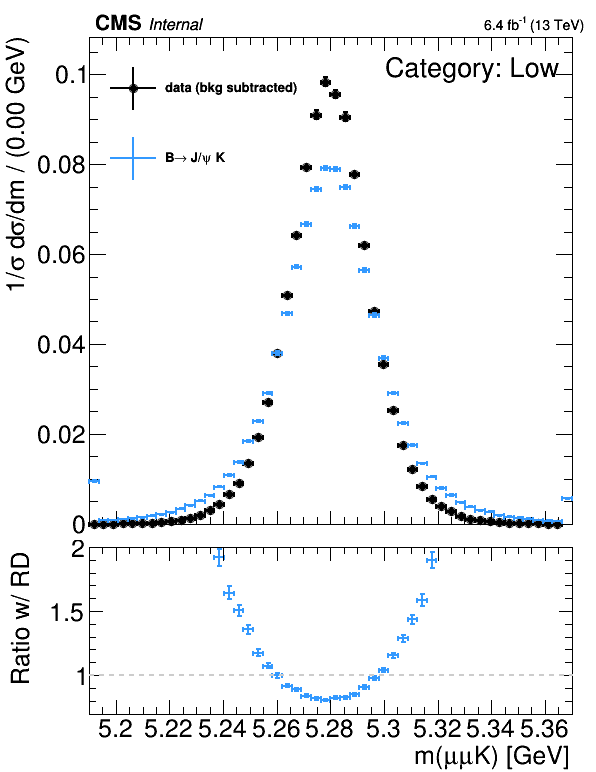

In [25]:
b=[50, 5.19, 5.37]
hRD = create_TH1D(dfRD['mass_mumuK_cJpsi'], name='hRD', title='RD',
                  weights=dfRD['sigSW'],
                  axis_title=['m(#mu#muK) [GeV]', '1/#sigma d#sigma/dm / '+'({:.2f} GeV)'.format((b[2]-b[1])/b[0])],
                  binning=b,
                  scale_histo='norm',
                  opt='overflow+underflow'
                 )
hRD.SetMarkerStyle(15)

hMCbare = create_TH1D(dfMC['mass_mumuK_cJpsi'], name='hMCbare',
                  title = 'Pythia Hard b#bar{b}',
                  scale_histo='norm', color=1,
                  binning=hRD.binning, opt='overflow+underflow')
    
hMC = create_TH1D(dfMC['mass_mumuK_cJpsi'], name='hMC',
                  weights=dfMC['w'],
                  scale_histo='norm', color=0,
                  binning=hRD.binning, opt='overflow+underflow')

leg = rt.TLegend(0.17, 0.75, 0.6,0.93)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
leg.AddEntry(hRD, 'data (bkg subtracted)', 'lep')
# leg.AddEntry(hMCbare, 'MC', 'le')
leg.AddEntry(hMC, 'B#rightarrow J/#psi K', 'le')

CMS_lumi.extraText = 7*' ' + 'Internal'
CMS_lumi.integrated_lumi = lumi_tot
# c = make_ratio_plot([hRD, hMCbare, hMC], leg_pos=None, ratio_bounds=[0.0,2])
c = make_ratio_plot([hRD, hMC], leg_pos=None, ratio_bounds=[0.7,2])
c.pad1.SetTopMargin(0.07)
CMS_lumi.CMS_lumi(c, -1, 0)
c.Draw()
catText.DrawLatexNDC(0.95, 0.9, 'Category: {}'.format(cat.name))
leg.Draw()
c.SaveAs('../data/calibration/Bcharged_pTspectrum/fig/massComaprison_' + cat.name + '_'+version + '.png')

### The true B spectrum

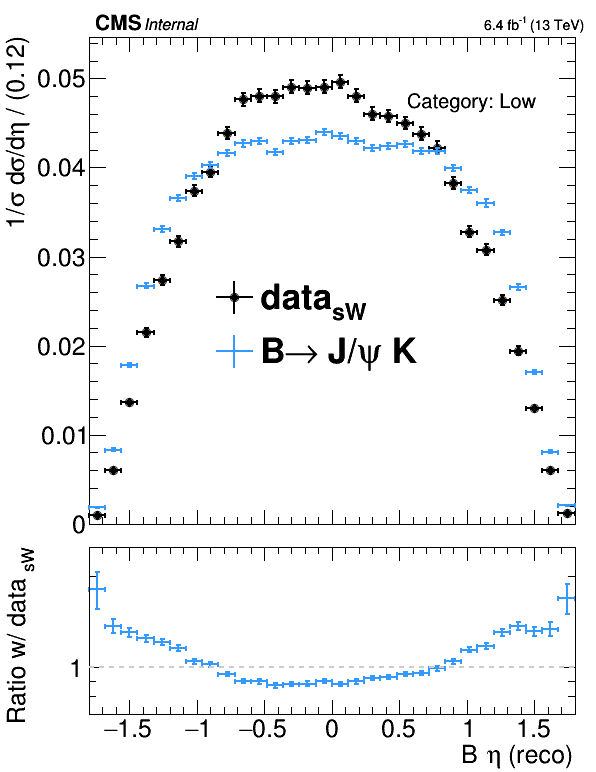

In [26]:
b=[30,-1.8,1.8]
binWdith = (b[2] - b[1])/float(b[0])
hRD = create_TH1D(dfRD['B_eta'], name='hRD',
                  weights=dfRD['nsig_sw'],
                  title='data_{sW}',
                  axis_title=['B #eta (reco)', 
                              '1/#sigma d#sigma/d#eta / '+'({:.2f})'.format(binWdith)],
                  binning=b,
                  scale_histo='norm',
                  opt='overflow+underflow'
                 )
hRD.SetMarkerStyle(15)

hMCb = create_TH1D(dfMC['B_eta'], name='hMCb',
                  title = 'MC',
                  scale_histo='norm', color=1,
                  binning=hRD.binning, opt='overflow+underflow')

hMC = create_TH1D(dfMC['B_eta'], name='hMC', 
                  weights=dfMC['w'],
#                   title = 'MC (weights)',
                  title = 'B#rightarrow J/#psi K',
                  scale_histo='norm', color=0,
                  binning=hRD.binning, opt='overflow+underflow')

CMS_lumi.extraText = '      Internal'
c = make_ratio_plot([hRD, hMC], ratio_bounds=[0.7, 2.5], draw_opt='E1')
# c = make_ratio_plot([hRD, hMCb, hMC], ratio_bounds=[0.7, 2.5], draw_opt='E1')
CMS_lumi.CMS_lumi(c, -1, 0)
c.pad1.SetTopMargin(0.07)
c.pad1.SetRightMargin(0.035)
c.pad2.SetRightMargin(0.035)
c.pad2.SetLogy()
c.leg.SetY1(0.3)
c.leg.SetY2(0.5)
c.leg.SetX1(0.35)
c.leg.SetX2(0.7)
c.Draw()

c.pad1.cd()
catText.SetTextSize(0.04)
catText.DrawLatexNDC(0.9, 0.8, 'Category: {}'.format(cat.name))
c.SaveAs('../data/calibration/Bcharged_pTspectrum/fig/B0etaComaprison_' + cat.name + '_' + version + '.png')

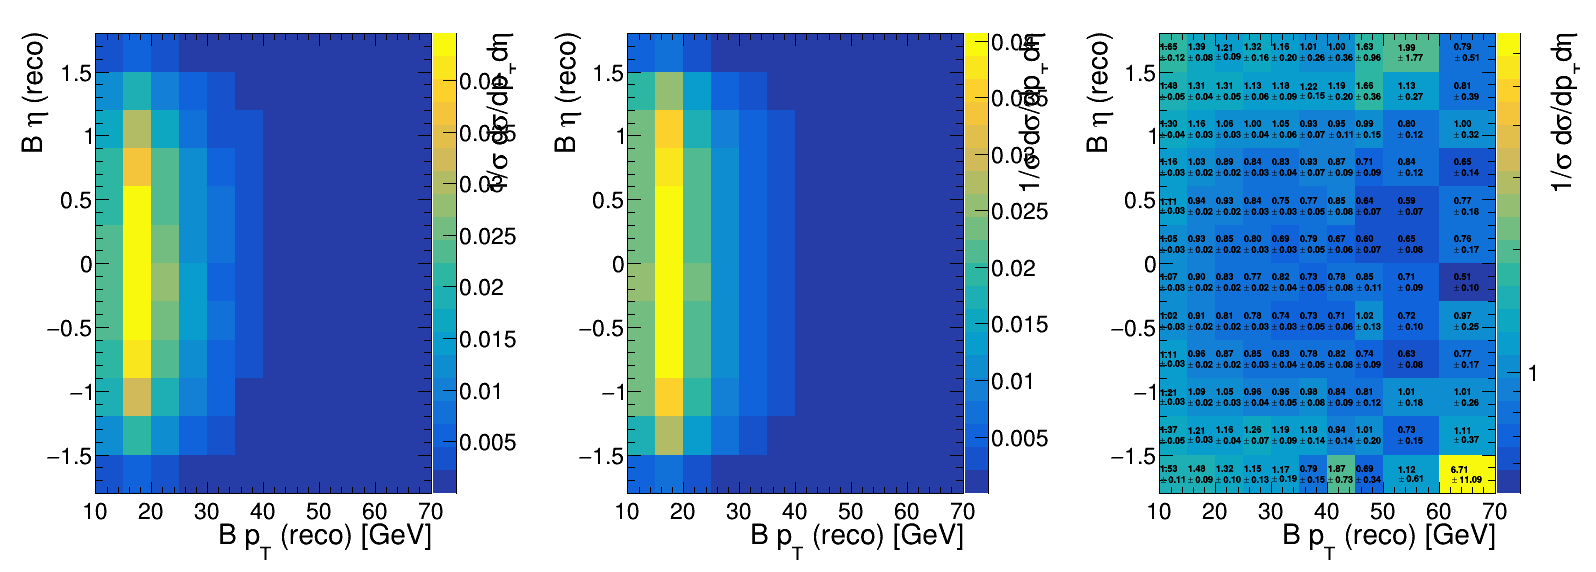

In [27]:
b = {'Low': array('d', list(np.arange(10, 50, 5)) + list(np.arange(50, 80, 10))),
     'Mid': array('d', list(np.arange(10, 60, 4)) + list(np.arange(60, 90, 8))),
     'High': array('d', list(np.arange(10, 90, 4)) + list(np.arange(90, 120, 15)))
    }
binWdith = b[cat.name][1] - b[cat.name][0]
hRD = create_TH2D(dfRD[['B_pt', 'B_eta']].values, name='hRD_2D',
                  weights=dfRD['nsig_sw'],
                  title='data_{sW}',
                  axis_title=['B p_{T} (reco) [GeV]', 'B #eta (reco)', '1/#sigma d#sigma/dp_{T}d#eta'],
                  binning=[b[cat.name], np.arange(-1.8,1.81, 0.3)],
                  scale_histo='norm',
                 )

hMC = create_TH2D(dfMC[['B_pt', 'B_eta']].values, name='hMC_2D',
                  weights=dfMC['w'],
                  binning=hRD.binning,
                  axis_title=['B p_{T} (reco) [GeV]', 'B #eta (reco)', '1/#sigma d#sigma/dp_{T}d#eta'],
                  scale_histo='norm',
                  )

hRatio = hMC.Clone('hRatio')
hRatio.Divide(hRD)

cc = rt.TCanvas('c2D', 'c2D', 50, 50, 1600, 600)
cc.SetTickx(0)
cc.SetTicky(0)
cc.Divide(3)

pad = cc.cd(1)
pad.SetRightMargin(0.17)
hRD.Draw('colz')

pad = cc.cd(2)
pad.SetRightMargin(0.17)
hMC.Draw('colz')

pad = cc.cd(3)
pad.SetRightMargin(0.17)
hRatio.Draw('colz')
rt.gStyle.SetPaintTextFormat('.2f')
hRatio.Draw('texte same')
pad.SetLogz()

cc.Draw()

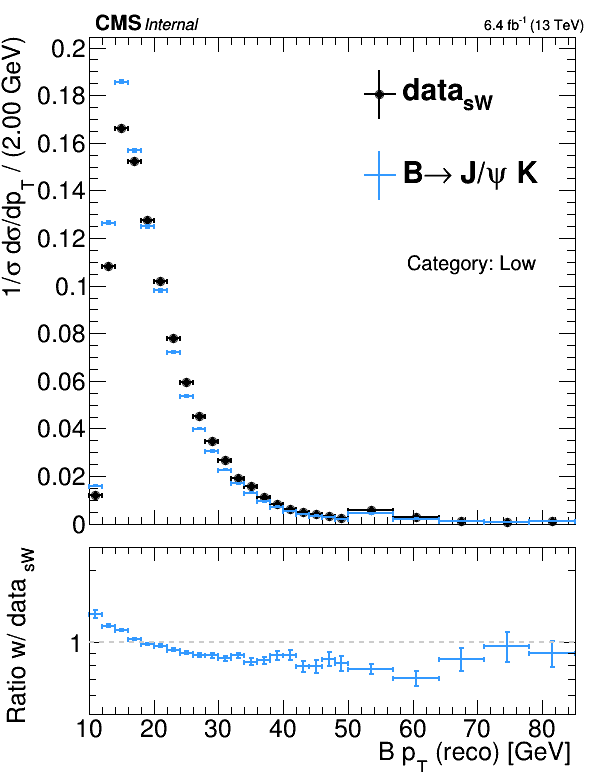

In [28]:
b = {'Low': array('d', list(np.arange(10, 50, 2)) + list(np.arange(50, 90, 7))),
     'Mid': array('d', list(np.arange(12, 60, 2)) + list(np.arange(60, 100, 5))),
     'High': array('d', list(np.arange(18, 90, 2)) + list(np.arange(90, 120, 10)))
    }
     
binWdith = b[cat.name][1] - b[cat.name][0]
hRD = create_TH1D(dfRD['B_pt'], name='hRD',
                  weights=dfRD['nsig_sw'],
                  title='data_{sW}',
                  axis_title=['B p_{T} (reco) [GeV]', 
                              '1/#sigma d#sigma/dp_{T} / '+'({:.2f} GeV)'.format(binWdith)],
                  binning=b[cat.name],
                  scale_histo='norm',
                  opt='overflow+underflow'
                 )
hRD.SetMarkerStyle(15)

hMCb = create_TH1D(dfMC['B_pt'], name='hMCb',
                  title = 'B#rightarrow J/#psi K (bare)',
                  scale_histo='norm', color=1,
                  binning=hRD.binning, opt='overflow+underflow')

hMC = create_TH1D(dfMC['B_pt'], name='hMC', 
                  weights=dfMC['w'],
                  title = 'B#rightarrow J/#psi K',
                  scale_histo='norm', color=0,
                  binning=hRD.binning, opt='overflow+underflow')

CMS_lumi.extraText = '      Internal'
c = make_ratio_plot([hRD, hMC], ratio_bounds=[0.5, 2.5], draw_opt='E1')
# c = make_ratio_plot([hRD, hMCb, hMC], ratio_bounds=[0.5, 10], draw_opt='E1')
CMS_lumi.CMS_lumi(c, -1, 0)
c.pad1.SetTopMargin(0.07)
c.pad1.SetRightMargin(0.035)
c.pad2.SetRightMargin(0.035)
c.pad2.SetLogy()
c.leg.SetY2(0.9)
c.leg.SetY1(0.6)
c.leg.SetX1(0.6)
c.Draw()

c.pad1.cd()
catText.SetTextSize(0.04)
catText.DrawLatexNDC(0.9, 0.5, 'Category: {}'.format(cat.name))
c.SaveAs('../data/calibration/Bcharged_pTspectrum/fig/B0pTcomaprison_' + cat.name + '_' + version + '.png')

In [29]:
uncertainty = 0.3
dic = {'pt':[], 'w':[], 'w_err':[], 'wUp':[], 'wDown':[]}

def f_arb_1(x, value_at_beg):
    center = 0.5*(hRD.binning[-1] + hRD.binning[0])
    k = (value_at_beg-1)/(hRD.binning[1] -  center)
    return k*(x - center)+1

def f_arb_2(x, pivFrac=0.3, lamToEnd=2):
    xPiv = pivFrac*(hRD.binning[-1] + hRD.binning[0])
    if x <= xPiv:
        dx = xPiv - x
        lam = (xPiv - hRD.binning[0])/lamToEnd
        sf = 1 - np.exp(-dx/lam)
        return -sf
    elif x > xPiv:
        dx = x - xPiv
        lam = (hRD.binning[-1] - xPiv)/lamToEnd
        sf = 1 - np.exp(-dx/lam)
        return sf

fout = open('../data/calibration/Bcharged_pTspectrum/pwWeights_{}_{}.txt'.format(cat.name, version), 'w')
fout.write('#'+'\t'.join(['pt','w', 'w_err', 'wUp', 'wDown'])+'\n')
for ib in range(1, hRD.GetNbinsX()+1):
    n = max(0, hRD.GetBinContent(ib))
    d = hMC.GetBinContent(ib)
    pt = hRD.GetBinCenter(ib)
    dic['pt'].append(pt)
    if d == 0:
        dic['w'].append(1)
        dic['w_err'].append(0)
        dic['wUp'].append(1)
        dic['wDown'].append(1)
        continue
        
    en = 0.
    ed = 0.
    if n > 0: en = hRD.GetBinError(ib)/n
    if d > 0: ed = hMC.GetBinError(ib)/d
    r = n/d
    dic['w'].append(r)
    if en != 0 and ed != 0:
        dr = r*np.hypot(en, ed)
    elif en == 0:
        dr = 0.5
    dic['w_err'].append(dr)
#     dic['wUp'].append(r * f_arb_1(pt, 1. - uncertainty))
#     dic['wDown'].append(r * f_arb_1(pt, 1. + uncertainty))
    dic['wUp'].append(max(0, r + dr *f_arb_2(pt)))
    dic['wDown'].append(max(0, r - dr * f_arb_2(pt)))
    
    fout.write('\t'.join(map(lambda x: '{:.3f}'.format(x), [pt, r, dr, dic['wUp'][-1], dic['wDown'][-1]]))+'\n')
fout.close()

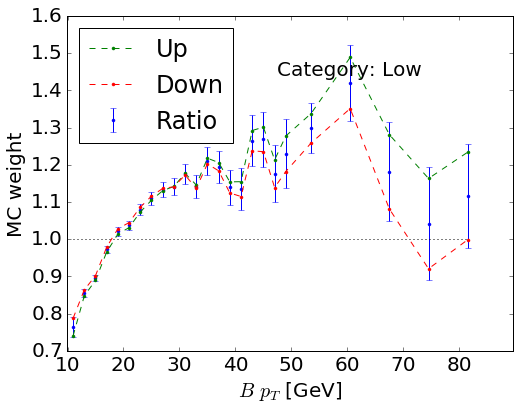

In [30]:
plt.rcParams.update({'font.size': 20})
f = plt.figure(figsize=(8,6))
plt.errorbar(dic['pt'], dic['w'], yerr=dic['w_err'], fmt='.', label='Ratio')
plt.plot(dic['pt'], dic['wUp'], '.--', label='Up')
plt.plot(dic['pt'], dic['wDown'], '.--', label='Down')
plt.plot(dic['pt'] , [1]*len(dic['pt']), ':k')
plt.legend(loc='best', numpoints=1)
plt.xlabel('$B\ p_T$ [GeV]')
plt.ylabel('MC weight')
_, ymax = plt.ylim()
plt.xlim(0.9*np.min(dic['pt']), 1.1*np.max(dic['pt']))
plt.text(0.9*np.max(dic['pt']) ,ymax*0.9, 'Category: ' + cat.name, horizontalalignment='right')
# plt.xscale('log')
plt.savefig('../data/calibration/Bcharged_pTspectrum/fig/weightsVSpt_' + cat.name + '_' + version + '.png')

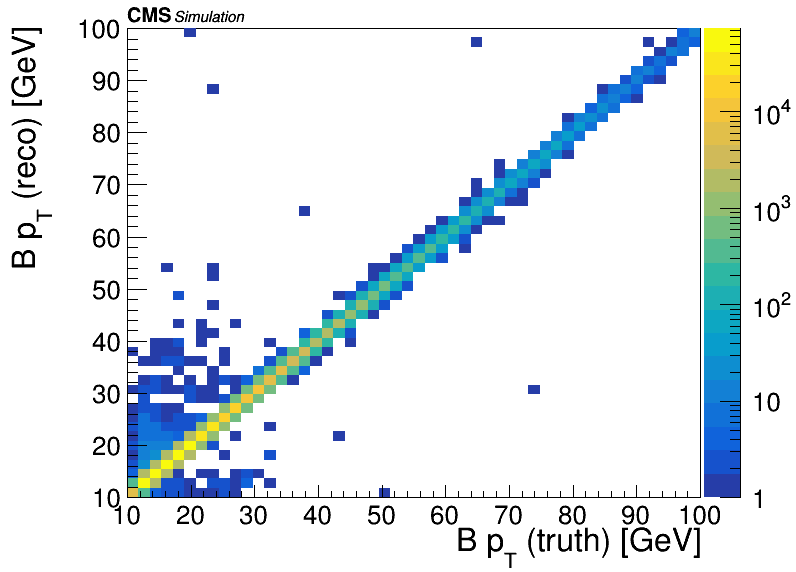

In [31]:
hMC2D = create_TH2D(dfMC[['B_pt', 'MC_B_pt']].values, name='hMC', title='',
                axis_title=['B p_{T} (truth) [GeV]', 'B p_{T} (reco) [GeV]', ''],
                binning=[50, 10, 100, 50, 10, 100]
               )

CMS_lumi.extraText = '     Simulation'
CMS_lumi.integrated_lumi = None
c = drawOnCMSCanvas(CMS_lumi, [hMC2D], ['colz'], mR=0.12)
c.SetLogz()

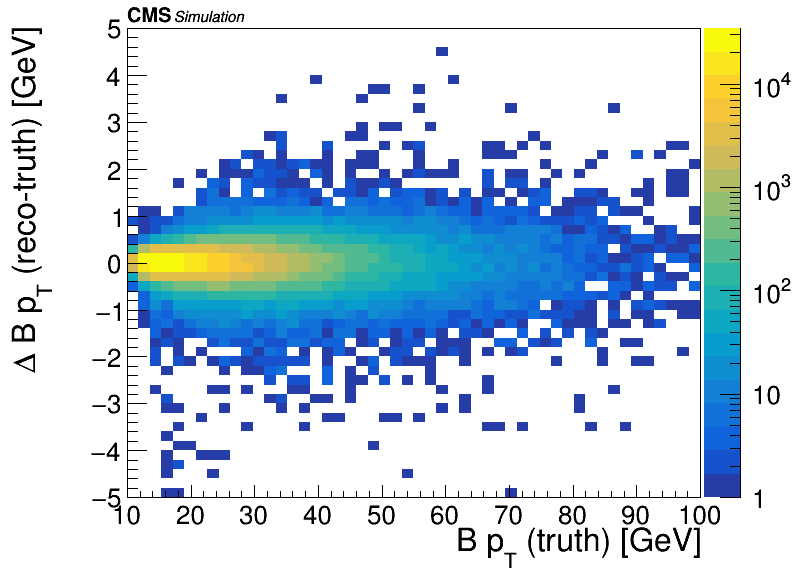

In [32]:

hMC2D = create_TH2D(np.column_stack((dfMC['MC_B_pt'], dfMC['B_pt'] - dfMC['MC_B_pt'])),
                    name='hMC', title='',
                    axis_title=['B p_{T} (truth) [GeV]', '#Delta B p_{T} (reco-truth) [GeV]', 'Events'],
                    binning=[50, 10, 100, 50, -5, 5],
                    weights=dfMC['MC_idxMatch']
                   )

CMS_lumi.extraText = '     Simulation'
CMS_lumi.integrated_lumi = None
c = drawOnCMSCanvas(CMS_lumi, [hMC2D], ['colz'], mR=0.12)
c.SetLogz()

In [33]:
from pT_calibration_reader import pTCalReader
cal_pT = pTCalReader(calibration_file='../data/calibration/Bcharged_pTspectrum/pwWeights_{}_{}.txt'.format(cat.name, version))

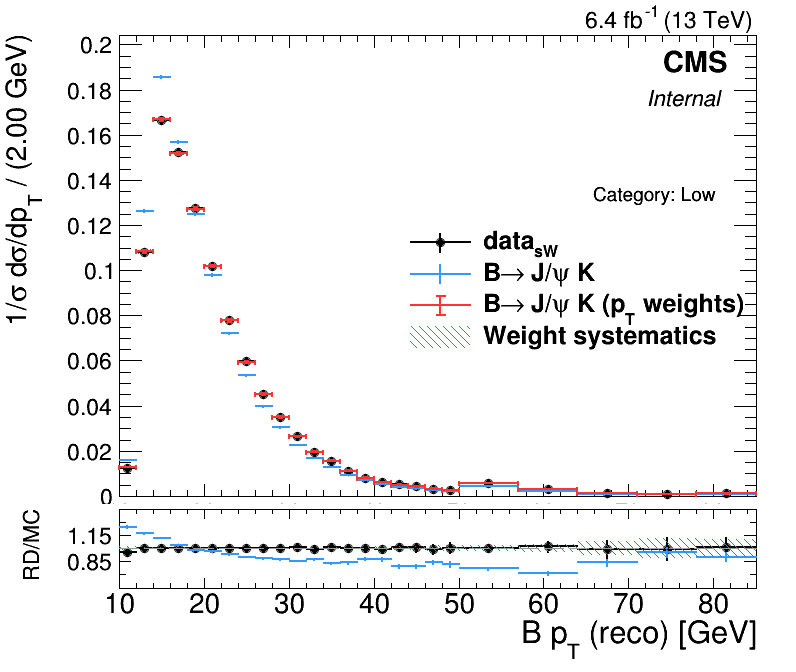

In [34]:
h_var = {}
colors = [5,6,8]
norm = None
for k in ['C', 'Up', 'Down']:
    h = create_TH1D(dfMC['B_pt'], name='h_var'+k, 
                    binning=hRD.binning, 
                    opt='underflow+overflow',
                    weights=cal_pT.f[k](dfMC['MC_B_pt'])*dfMC['muonSF']*dfMC['trgSF']*dfMC['wPU'],
#                     scale_histo='norm'
                   )
    if k == 'C':
        norm = h.Integral()
    h.Scale(1./float(norm))
    h_var[k] = h
    
gr_stat = rt.TGraphAsymmErrors()
gr_sys = rt.TGraphAsymmErrors()
h_dr = hRD.Clone('h_aux_dataratio')
h_mr = hMC.Clone('h_aux_MCratio')
g_up = rt.TGraph()
g_up.SetPoint(0, hMC.GetBinCenter(1)-0.5*hMC.GetBinWidth(1), 1)
g_down = rt.TGraph()
g_down.SetPoint(0, hMC.GetBinCenter(1)-0.5*hMC.GetBinWidth(1), 1)
for ib in range(1, hRD.GetNbinsX()+1):
    x = hRD.GetBinCenter(ib)
    y = h_var['C'].GetBinContent(ib)
    c = h_dr.GetBinContent(ib)
    e = h_dr.GetBinError(ib)
    h_dr.SetBinContent(ib, c/y)
    h_dr.SetBinError(ib, e/y)
    c = h_mr.GetBinContent(ib)
    e = h_mr.GetBinError(ib)
    h_mr.SetBinContent(ib, c/y)
    h_mr.SetBinError(ib, e/y)
    gr_stat.SetPoint(ib-1, x, y)
    dx = 0.5*hMC.GetBinWidth(ib)
    dy = h_var['C'].GetBinError(ib)
    gr_stat.SetPointError(ib-1, dx, dx, dy, dy)
    
    dy_low = max(y-h_var['Up'].GetBinContent(ib), y-h_var['Down'].GetBinContent(ib))
    dy_up = max(h_var['Up'].GetBinContent(ib)-y, h_var['Down'].GetBinContent(ib)-y)
    gr_sys.SetPoint(ib-1, x, y)
    gr_sys.SetPointError(ib-1, dx, dx, dy_low, dy_up)
    
    x_low = h_dr.GetBinCenter(ib) - 0.5*h_dr.GetBinWidth(ib)
    x_up = h_dr.GetBinCenter(ib) + 0.5*h_dr.GetBinWidth(ib)
    g_up.SetPoint(2*ib-1, x_low, (y+dy_up)/y)
    g_up.SetPoint(2*ib, x_up, (y+dy_up)/y)
    g_down.SetPoint(2*ib-1, x_low, (y-dy_low)/y)
    g_down.SetPoint(2*ib, x_up, (y-dy_low)/y)
g_up.SetPoint(2*ib+1, x_up, 1)
g_down.SetPoint(2*ib+1, x_up, 1)
gr_stat.SetLineColor(rt.kRed-4)
gr_stat.SetLineWidth(2)
gr_stat.SetMarkerColor(rt.kRed-4)
gr_sys.SetFillColor(rt.kRed-4)
gr_sys.SetFillStyle(3005)
gr_sys.SetLineWidth(0)
    

leg = rt.TLegend(0.5, 0.3, 0.93,0.55)
leg.SetBorderSize(0)
leg.AddEntry(hRD, hRD.GetTitle(), 'lep')
leg.AddEntry(hMC, 'B#rightarrow J/#psi K', 'le')
leg.AddEntry(gr_stat, 'B#rightarrow J/#psi K (p_{T} weights)', 'lep')
leg.AddEntry(gr_sys, 'Weight systematics', 'f')

SetMaxToMaxHist([hRD, hMC])
c = rt.TCanvas('c', 'c', 50, 50, 800, 700)
c.SetTickx(0)
c.SetTicky(0)

pad = rt.TPad('pmain', 'pmain', 0, 0.25, 1, 1)
pad.SetBottomMargin(0.015)
pad.SetTopMargin(0.07)
pad.SetRightMargin(0.05)
pad.SetLeftMargin(0.15)
pad.Draw()
pad.cd()
hRD.Draw()
hMC.Draw('same')
gr_stat.Draw('p')
gr_sys.Draw('2')
leg.Draw()
catText.DrawLatexNDC(0.9, 0.6, 'Category: {}'.format(cat.name))
CMS_lumi.extraText = '     Internal'
CMS_lumi.integrated_lumi = lumi_tot
CMS_lumi.CMS_lumi(pad, -1, 33, cmsTextSize=0.75*1.2, lumiTextSize=0.6*1.2)

c.cd()
pad = rt.TPad('ppull', 'ppull', 0, 0, 1, 0.25)
pad.SetBottomMargin(0.5)
pad.SetTopMargin(0.03)
pad.SetRightMargin(0.05)
pad.SetLeftMargin(0.15)
pad.Draw('same')
pad.cd()
h_dr.GetYaxis().SetTitle('RD/MC')
t = 0.15
h_dr.GetYaxis().SetRangeUser(1 - 3*t, 1 + 3*t)
h_dr.GetYaxis().SetTitleOffset(0.5)
h_dr.GetYaxis().SetTitleSize(0.14)
h_dr.GetYaxis().SetLabelSize(0.15)
h_dr.GetYaxis().SetNdivisions(-203)
h_dr.GetXaxis().SetTitleOffset(0.95)
h_dr.GetXaxis().SetTitleSize(0.2)
h_dr.GetXaxis().SetLabelSize(0.18)
h_dr.GetXaxis().SetTickSize(0.07)
h_dr.Draw('E0')
h_mr.Draw('sameE0')
g_up.SetFillColor(rt.kRed-4)
g_up.SetFillStyle(3005)
g_up.Draw('F')
g_down.SetFillColor(rt.kRed-4)
g_down.SetFillStyle(3005)
g_down.Draw('F')
gh_dr = rt.TGraphErrors()
for i in range(1, h_dr.GetNbinsX()+1):
    gh_dr.SetPoint(i-1, h_dr.GetBinCenter(i), h_dr.GetBinContent(i))
    gh_dr.SetPointError(i-1, h_dr.GetBinError(i))
gh_dr.SetLineColor(h_dr.GetLineColor())
gh_dr.Draw('P0')
ax = h_dr.GetYaxis()
ax.ChangeLabel(1, -1, -1, -1, -1, -1, ' ')
ax.ChangeLabel(4, -1, -1, -1, -1, -1, ' ')

l = rt.TLine()
l.SetLineColor(rt.kGray+1)
l.SetLineWidth(1)
l.SetLineStyle(9)
x_low = h_dr.GetBinCenter(1)-0.5*h_dr.GetBinWidth(1)
x_high = h_dr.GetBinCenter(h_dr.GetNbinsX())+0.5*h_dr.GetBinWidth(h_dr.GetNbinsX())
l.DrawLine(x_low, 1, x_high, 1)


c.Draw()
c.SaveAs('../data/calibration/Bcharged_pTspectrum/fig/closure_' + cat.name + '_' + version + '.png')